<a href="https://colab.research.google.com/github/HenningBuhl/DLML/blob/master/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DLML - GAN

## TODO

In [0]:
"""

TODO

- ...

DIFFICULT!
- Use different loss function?
- Use ProGAN
- Use Style GAN

"""

'\n\nTODO\n\n- ...\n\nDIFFICULT!\n- Use different loss function?\n- Use growing architecture\n- Use Style GAN\n\n\n\n\n'

## Sources

- https://github.com/eriklindernoren/Keras-GAN
- https://machinelearningmastery.com/how-to-code-generative-adversarial-network-hacks/
- https://www.youtube.com/watch?v=dCKbRCUyop8
- https://github.com/google/compare_gan
- https://arxiv.org/pdf/1806.11382.pdf
- https://arxiv.org/pdf/1812.04948.pdf
- https://arxiv.org/pdf/1710.10196.pdf
- https://arxiv.org/pdf/1801.04406.pdf
- https://medium.com/@jonathan_hui/gan-gan-series-2d279f906e7b
- https://gist.github.com/korakot/8409b3feec20f159d8a50b0a811d3bca
- 


## Random Seeds

In [0]:
# Set Numpy seed.
from numpy.random import seed
seed(1)

# Set TensorFlow seed.
from tensorflow import set_random_seed
set_random_seed(2)

## Imports

In [0]:
import keras
import keras.backend as K

from keras.layers import Input, Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from keras.layers import BatchNormalization, Dropout, Activation, ZeroPadding2D
from keras.layers import LeakyReLU, ReLU
from keras.initializers import RandomNormal, glorot_normal
from keras.models import load_model
from keras.optimizers import Adam
from keras.datasets import mnist, fashion_mnist, cifar10
from keras.utils import to_categorical
from keras.models import Sequential, Model

import os

import numpy as np
from numpy.random import random

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)

Using TensorFlow backend.


# Data

In [0]:
# Meta data.
x_dim = 28
y_dim = 28
channels = 1
img_shape = (x_dim, y_dim, channels)

In [0]:
# Load data.
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [0]:
# Concatonate train and test data.
#x_train = np.concatenate((x_train, x_test))

# Add channel dimension.
x_train = x_train.reshape(-1, x_dim, y_dim, channels)
x_test = x_test.reshape(-1, x_dim, y_dim, channels)

# Normalize data to interval (-1, 1).
x_train = x_train / 255 * 2 - 1
x_test = x_test / 255 * 2 - 1

In [0]:
# Print data shape.
print(x_train.shape)

(60000, 28, 28, 1)


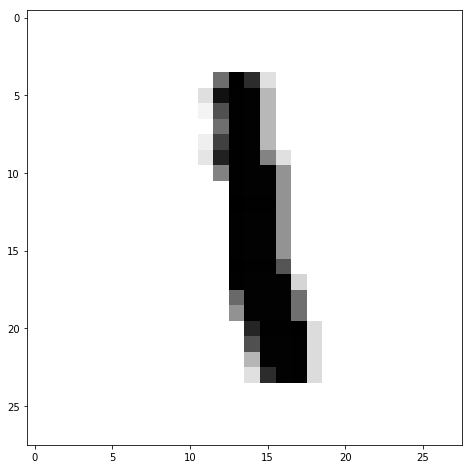

In [0]:
plt.imshow(x_train[6].reshape(x_dim, y_dim), cmap='gray_r')
plt.show()

# GAN

## Hyper Parameters

In [0]:
iterations = 10000
batch_size = 128
latent_dim = 100

init = glorot_normal() #RandomNormal(mean=0, stddev=0.02)
optimizer = Adam(lr=0.0002, beta_1=0.5)

## Generator

In [0]:
# Build generator model.
z = Input(shape=(latent_dim,))
x = Dense(128 * 7 * 7, kernel_initializer=init)(z)
x = LeakyReLU(0.2)(x)
x = Reshape((7, 7, 128))(x)

x = Conv2D(128, kernel_size=3, strides=(1, 1), padding="same", kernel_initializer=init)(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

x = Conv2DTranspose(128, kernel_size=3, strides=(2, 2), padding="same", kernel_initializer=init)(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

x = Conv2D(64, kernel_size=3, strides=(1, 1), padding="same", kernel_initializer=init)(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

x = Conv2DTranspose(64, kernel_size=3, strides=(2, 2), padding="same", kernel_initializer=init)(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

x = Conv2D(channels, kernel_size=3, strides=(1, 1), padding="same", kernel_initializer=init)(x)
x = Activation("tanh")(x)

generator = Model(z, x)
generator.name = "generator"
generator.summary()












Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)

## Discriminator

In [0]:
# Build discriminator model.
img_input = Input(shape=img_shape)
x = Conv2D(32, kernel_size=3, strides=(2, 2), padding="same", kernel_initializer=init)(img_input)
x = LeakyReLU(0.2)(x)
x = Dropout(0.25)(x)

x = Conv2D(64, kernel_size=3, strides=(2, 2), padding="same", kernel_initializer=init)(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = Dropout(0.25)(x)

x = Conv2D(128, kernel_size=3, strides=(2, 2), padding="same", kernel_initializer=init)(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = Dropout(0.25)(x)

x = Conv2D(256, kernel_size=3, strides=(1, 1), padding="same", kernel_initializer=init)(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(1, kernel_initializer=init)(x)
x = Activation("sigmoid")(x)

discriminator = Model(img_input, x)
discriminator.name = "discriminator"
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])
discriminator.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
________________________________________

## Combined Model

In [0]:
# For the combined model we will only train the generator.
discriminator.trainable = False

# Combined model (stacked generator and discriminator).
combined = Model(z, discriminator(generator(z)))
combined.name = "combined"
combined.summary()
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "combined"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
generator (Model)            (None, 28, 28, 1)         1041473   
_________________________________________________________________
discriminator (Model)        (None, 1)                 393729    
Total params: 1,435,202
Trainable params: 1,040,705
Non-trainable params: 394,497
_________________________________________________________________


## Training

In [0]:
# Loss history.
losses = {'d_loss_real' : [],
          'd_loss_fake' : [],
          'd_loss' : [],
          'g_loss' : []}

In [0]:
save_path_image = "images/"
if not os.path.exists(save_path_image):
    os.mkdir(save_path_image)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Iteration:     1 [D loss: 1.26645, acc.:  20.31%] [G loss: 0.69981]


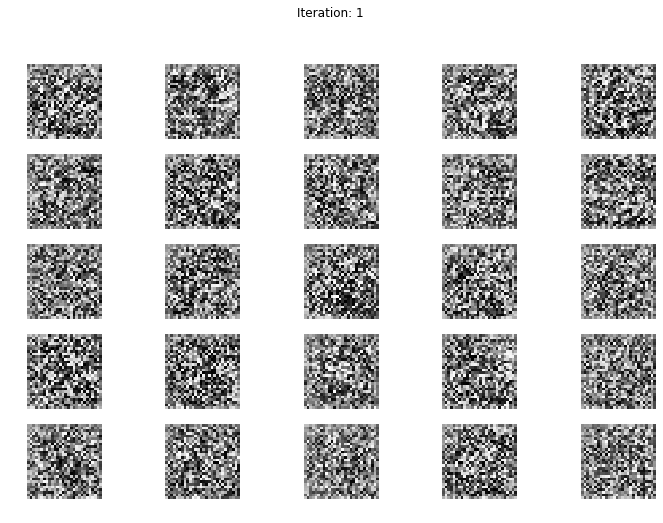

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Iteration:     2 [D loss: 0.71635, acc.:  58.59%] [G loss: 0.89851]
Iteration:     3 [D loss: 0.54283, acc.:  70.31%] [G loss: 1.11723]
Iteration:     4 [D loss: 0.48558, acc.:  78.91%] [G loss: 1.39536]
Iteration:     5 [D loss: 0.44643, acc.:  80.08%] [G loss: 1.32460]
Iteration:     6 [D loss: 0.42958, acc.:  82.03%] [G loss: 1.41216]
Iteration:     7 [D loss: 0.48626, acc.:  78.12%] [G loss: 1.14007]
Iteration:     8 [D loss: 0.43159, acc.:  82.03%] [G loss: 1.16878]
Iteration:     9 [D loss: 0.38928, acc.:  85.16%] [G loss: 0.97686]
Iteration:    10 [D loss: 0.38915, acc.:  82.42%] [G loss: 0.92964]
Iteration:    11 [D loss: 0.37285, acc.:  83.98%] [G loss: 0.82587]
Iteration:    12 [D loss: 0.44481, acc.:  78.91%] [G loss: 0.82379]
Iteration:    13 [D loss: 0.51550, acc.:  75.78%] [G loss: 0.73944]
Iteration:    14 [D loss: 0.40458, acc.:  83.20%] [G loss: 0.68460]
Iteration:    15 [D loss: 0.44979, acc.:  79.30%] [G loss: 0.51484]
Iteration:    16 [D loss: 0.51817, acc.:  75.00%

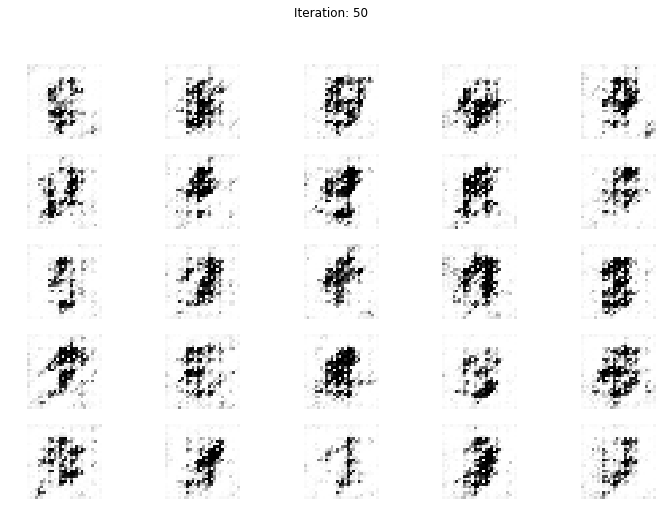

Iteration:    51 [D loss: 0.87632, acc.:  47.66%] [G loss: 1.96126]
Iteration:    52 [D loss: 0.98754, acc.:  46.48%] [G loss: 1.64340]
Iteration:    53 [D loss: 1.06237, acc.:  39.84%] [G loss: 1.39373]
Iteration:    54 [D loss: 0.94778, acc.:  47.27%] [G loss: 1.32084]
Iteration:    55 [D loss: 0.83535, acc.:  49.22%] [G loss: 1.53908]
Iteration:    56 [D loss: 0.88634, acc.:  49.22%] [G loss: 1.58679]
Iteration:    57 [D loss: 0.88849, acc.:  49.22%] [G loss: 1.64977]
Iteration:    58 [D loss: 0.83851, acc.:  53.12%] [G loss: 1.45904]
Iteration:    59 [D loss: 1.01507, acc.:  40.23%] [G loss: 1.54685]
Iteration:    60 [D loss: 0.96594, acc.:  43.36%] [G loss: 1.38810]
Iteration:    61 [D loss: 1.03735, acc.:  42.19%] [G loss: 1.38852]
Iteration:    62 [D loss: 1.07540, acc.:  39.06%] [G loss: 1.21457]
Iteration:    63 [D loss: 1.08602, acc.:  37.11%] [G loss: 1.17227]
Iteration:    64 [D loss: 1.03699, acc.:  39.84%] [G loss: 1.33618]
Iteration:    65 [D loss: 0.99728, acc.:  41.41%

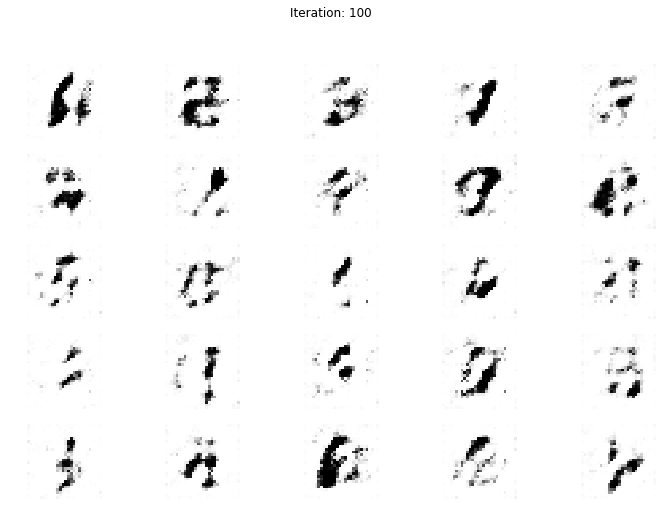

Iteration:   101 [D loss: 0.82399, acc.:  49.22%] [G loss: 1.19969]
Iteration:   102 [D loss: 0.85793, acc.:  48.44%] [G loss: 1.00632]
Iteration:   103 [D loss: 0.86849, acc.:  45.31%] [G loss: 1.20453]
Iteration:   104 [D loss: 0.84293, acc.:  50.00%] [G loss: 1.31729]
Iteration:   105 [D loss: 0.81419, acc.:  49.61%] [G loss: 1.21864]
Iteration:   106 [D loss: 0.76925, acc.:  51.95%] [G loss: 1.29300]
Iteration:   107 [D loss: 0.88969, acc.:  45.31%] [G loss: 1.17529]
Iteration:   108 [D loss: 0.84140, acc.:  50.39%] [G loss: 1.07119]
Iteration:   109 [D loss: 0.82815, acc.:  48.05%] [G loss: 1.03260]
Iteration:   110 [D loss: 0.76888, acc.:  52.34%] [G loss: 1.01175]
Iteration:   111 [D loss: 0.83339, acc.:  48.05%] [G loss: 1.19038]
Iteration:   112 [D loss: 0.87622, acc.:  40.62%] [G loss: 1.07575]
Iteration:   113 [D loss: 0.93498, acc.:  41.80%] [G loss: 1.13718]
Iteration:   114 [D loss: 0.92544, acc.:  45.70%] [G loss: 1.03664]
Iteration:   115 [D loss: 0.89193, acc.:  39.45%

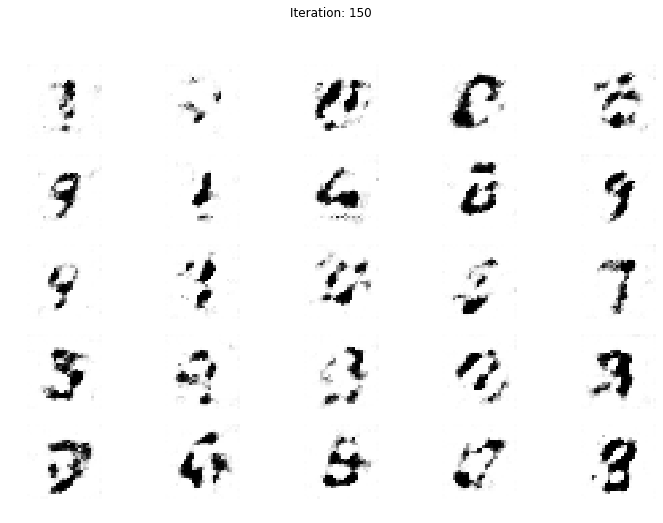

Iteration:   151 [D loss: 0.81071, acc.:  50.00%] [G loss: 0.99310]
Iteration:   152 [D loss: 0.81727, acc.:  44.14%] [G loss: 0.97974]
Iteration:   153 [D loss: 0.82522, acc.:  45.70%] [G loss: 0.96051]
Iteration:   154 [D loss: 0.81452, acc.:  49.22%] [G loss: 0.89970]
Iteration:   155 [D loss: 0.85024, acc.:  46.09%] [G loss: 0.93352]
Iteration:   156 [D loss: 0.83932, acc.:  45.70%] [G loss: 0.93107]
Iteration:   157 [D loss: 0.83661, acc.:  48.44%] [G loss: 0.99481]
Iteration:   158 [D loss: 0.84819, acc.:  46.09%] [G loss: 1.07321]
Iteration:   159 [D loss: 0.77151, acc.:  52.73%] [G loss: 1.09175]
Iteration:   160 [D loss: 0.89251, acc.:  41.41%] [G loss: 1.06188]
Iteration:   161 [D loss: 0.83027, acc.:  46.88%] [G loss: 0.99608]
Iteration:   162 [D loss: 0.81348, acc.:  45.70%] [G loss: 1.02676]
Iteration:   163 [D loss: 0.80075, acc.:  45.70%] [G loss: 1.00094]
Iteration:   164 [D loss: 0.84005, acc.:  43.36%] [G loss: 0.99911]
Iteration:   165 [D loss: 0.83043, acc.:  46.48%

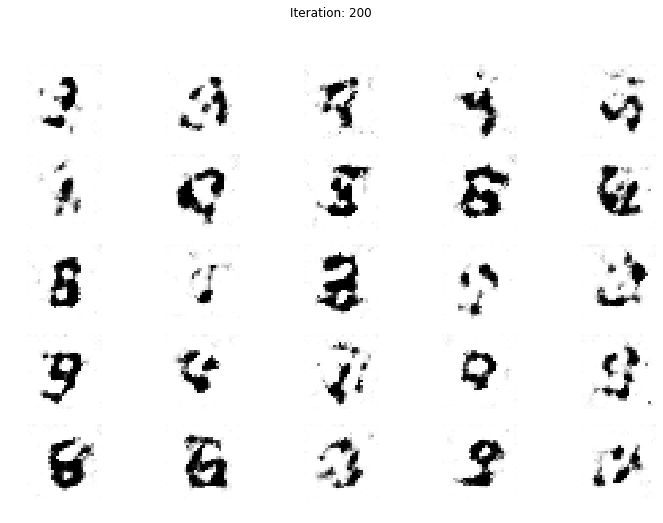

Iteration:   201 [D loss: 0.84429, acc.:  41.41%] [G loss: 0.90390]
Iteration:   202 [D loss: 0.87434, acc.:  40.23%] [G loss: 0.96952]
Iteration:   203 [D loss: 0.88806, acc.:  41.80%] [G loss: 1.06443]
Iteration:   204 [D loss: 0.77930, acc.:  52.73%] [G loss: 0.98771]
Iteration:   205 [D loss: 0.88267, acc.:  38.28%] [G loss: 1.05703]
Iteration:   206 [D loss: 0.83998, acc.:  42.97%] [G loss: 1.02311]
Iteration:   207 [D loss: 0.78144, acc.:  48.44%] [G loss: 1.04269]
Iteration:   208 [D loss: 0.77753, acc.:  48.05%] [G loss: 1.00836]
Iteration:   209 [D loss: 0.76713, acc.:  50.78%] [G loss: 1.04148]
Iteration:   210 [D loss: 0.74016, acc.:  53.52%] [G loss: 0.95006]
Iteration:   211 [D loss: 0.82848, acc.:  46.48%] [G loss: 1.00805]
Iteration:   212 [D loss: 0.79062, acc.:  50.00%] [G loss: 0.95300]
Iteration:   213 [D loss: 0.83454, acc.:  48.83%] [G loss: 0.92124]
Iteration:   214 [D loss: 0.80080, acc.:  45.70%] [G loss: 0.83032]
Iteration:   215 [D loss: 0.79203, acc.:  44.53%

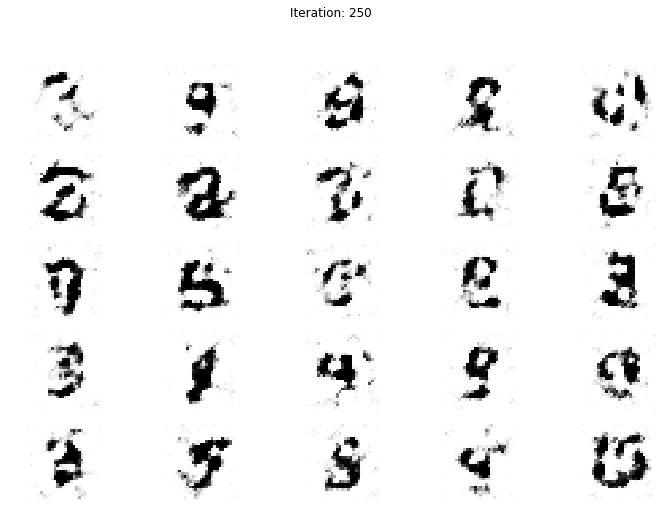

Iteration:   251 [D loss: 0.77897, acc.:  47.27%] [G loss: 1.01014]
Iteration:   252 [D loss: 0.78358, acc.:  50.00%] [G loss: 0.97364]
Iteration:   253 [D loss: 0.76583, acc.:  50.78%] [G loss: 0.99764]
Iteration:   254 [D loss: 0.80769, acc.:  49.61%] [G loss: 0.97680]
Iteration:   255 [D loss: 0.80150, acc.:  46.09%] [G loss: 0.94810]
Iteration:   256 [D loss: 0.75730, acc.:  51.17%] [G loss: 0.96584]
Iteration:   257 [D loss: 0.78772, acc.:  48.05%] [G loss: 0.99041]
Iteration:   258 [D loss: 0.79724, acc.:  42.19%] [G loss: 1.00107]
Iteration:   259 [D loss: 0.72226, acc.:  54.69%] [G loss: 0.94525]
Iteration:   260 [D loss: 0.80687, acc.:  43.36%] [G loss: 0.86726]
Iteration:   261 [D loss: 0.80038, acc.:  44.53%] [G loss: 0.97248]
Iteration:   262 [D loss: 0.78938, acc.:  47.66%] [G loss: 0.94913]
Iteration:   263 [D loss: 0.73757, acc.:  50.39%] [G loss: 1.00686]
Iteration:   264 [D loss: 0.81067, acc.:  42.58%] [G loss: 0.87189]
Iteration:   265 [D loss: 0.72512, acc.:  55.08%

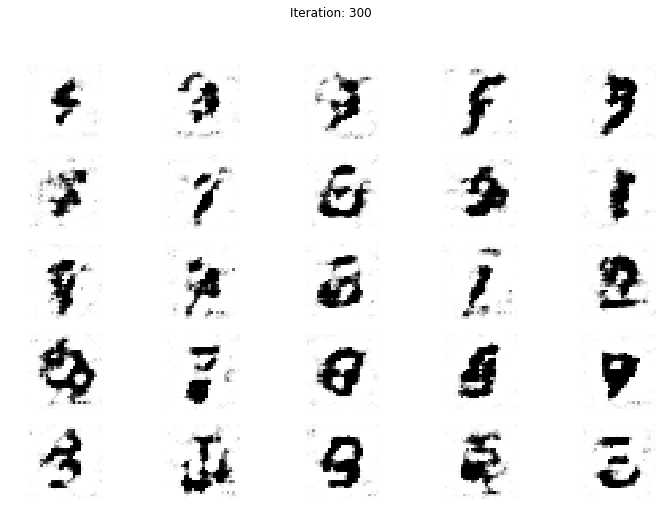

Iteration:   301 [D loss: 0.77458, acc.:  49.61%] [G loss: 0.93291]
Iteration:   302 [D loss: 0.77336, acc.:  50.39%] [G loss: 0.99405]
Iteration:   303 [D loss: 0.76035, acc.:  48.83%] [G loss: 0.90296]
Iteration:   304 [D loss: 0.77890, acc.:  48.44%] [G loss: 0.91009]
Iteration:   305 [D loss: 0.71962, acc.:  58.20%] [G loss: 0.98990]
Iteration:   306 [D loss: 0.78370, acc.:  45.31%] [G loss: 0.95485]
Iteration:   307 [D loss: 0.78104, acc.:  48.44%] [G loss: 1.02324]
Iteration:   308 [D loss: 0.79997, acc.:  46.48%] [G loss: 0.94569]
Iteration:   309 [D loss: 0.75405, acc.:  49.22%] [G loss: 0.98956]
Iteration:   310 [D loss: 0.82611, acc.:  46.48%] [G loss: 0.95239]
Iteration:   311 [D loss: 0.73718, acc.:  54.30%] [G loss: 1.06411]
Iteration:   312 [D loss: 0.74168, acc.:  51.17%] [G loss: 0.91760]
Iteration:   313 [D loss: 0.76932, acc.:  51.56%] [G loss: 1.02832]
Iteration:   314 [D loss: 0.74799, acc.:  49.61%] [G loss: 1.02602]
Iteration:   315 [D loss: 0.76951, acc.:  48.44%

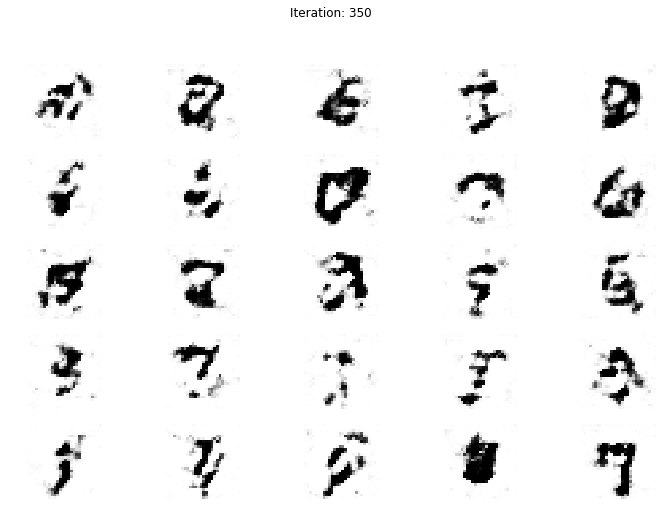

Iteration:   351 [D loss: 0.81030, acc.:  46.48%] [G loss: 0.96124]
Iteration:   352 [D loss: 0.73697, acc.:  53.52%] [G loss: 0.96612]
Iteration:   353 [D loss: 0.71760, acc.:  54.30%] [G loss: 1.00009]
Iteration:   354 [D loss: 0.72499, acc.:  54.69%] [G loss: 0.97598]
Iteration:   355 [D loss: 0.74334, acc.:  54.30%] [G loss: 0.98884]
Iteration:   356 [D loss: 0.76938, acc.:  48.83%] [G loss: 1.04697]
Iteration:   357 [D loss: 0.77611, acc.:  48.83%] [G loss: 0.91340]
Iteration:   358 [D loss: 0.76898, acc.:  46.88%] [G loss: 0.95915]
Iteration:   359 [D loss: 0.74914, acc.:  49.61%] [G loss: 0.89290]
Iteration:   360 [D loss: 0.74557, acc.:  49.61%] [G loss: 0.99291]
Iteration:   361 [D loss: 0.76077, acc.:  48.05%] [G loss: 0.89596]
Iteration:   362 [D loss: 0.77335, acc.:  48.83%] [G loss: 0.93615]
Iteration:   363 [D loss: 0.74706, acc.:  54.30%] [G loss: 0.96667]
Iteration:   364 [D loss: 0.73245, acc.:  50.78%] [G loss: 0.95585]
Iteration:   365 [D loss: 0.79398, acc.:  47.27%

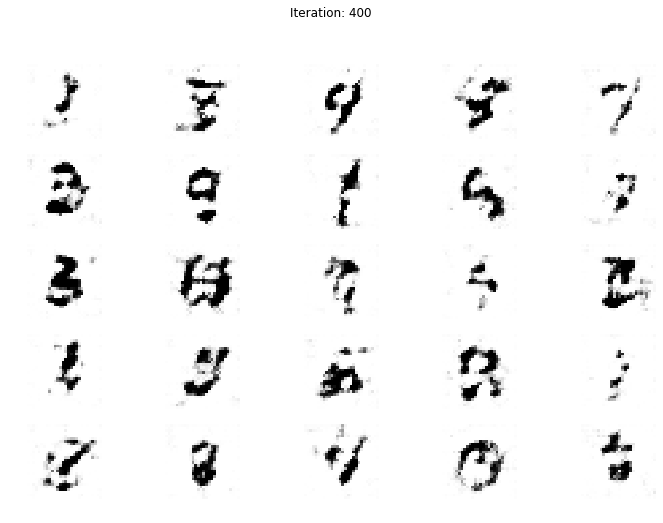

Iteration:   401 [D loss: 0.72450, acc.:  53.52%] [G loss: 0.96102]
Iteration:   402 [D loss: 0.76074, acc.:  54.69%] [G loss: 0.91829]
Iteration:   403 [D loss: 0.71850, acc.:  55.47%] [G loss: 0.94813]
Iteration:   404 [D loss: 0.70640, acc.:  53.12%] [G loss: 1.00356]
Iteration:   405 [D loss: 0.71270, acc.:  54.30%] [G loss: 0.97649]
Iteration:   406 [D loss: 0.70666, acc.:  52.34%] [G loss: 0.96301]
Iteration:   407 [D loss: 0.77879, acc.:  50.00%] [G loss: 0.93517]
Iteration:   408 [D loss: 0.73682, acc.:  53.12%] [G loss: 1.10054]
Iteration:   409 [D loss: 0.74694, acc.:  51.17%] [G loss: 0.97606]
Iteration:   410 [D loss: 0.71340, acc.:  53.52%] [G loss: 0.97353]
Iteration:   411 [D loss: 0.74773, acc.:  51.17%] [G loss: 0.92482]
Iteration:   412 [D loss: 0.67739, acc.:  57.42%] [G loss: 0.95750]
Iteration:   413 [D loss: 0.72478, acc.:  53.91%] [G loss: 0.97848]
Iteration:   414 [D loss: 0.77109, acc.:  48.44%] [G loss: 0.99145]
Iteration:   415 [D loss: 0.70819, acc.:  55.86%

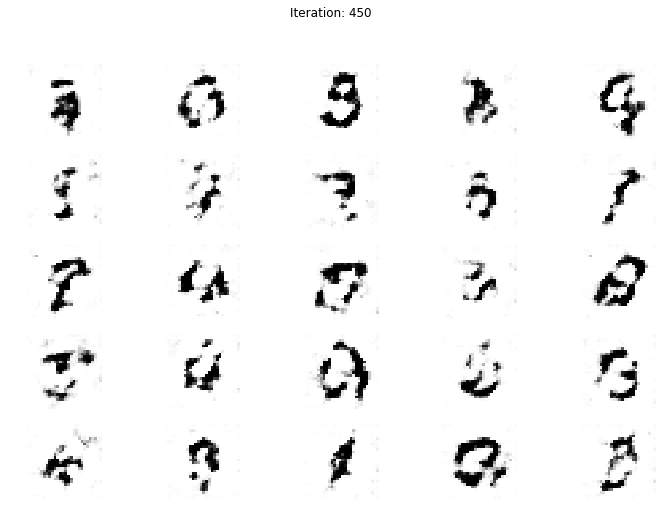

Iteration:   451 [D loss: 0.69383, acc.:  55.08%] [G loss: 0.98407]
Iteration:   452 [D loss: 0.72071, acc.:  51.56%] [G loss: 1.02723]
Iteration:   453 [D loss: 0.73774, acc.:  54.30%] [G loss: 1.01796]
Iteration:   454 [D loss: 0.72843, acc.:  51.95%] [G loss: 0.96168]
Iteration:   455 [D loss: 0.76543, acc.:  46.88%] [G loss: 1.03051]
Iteration:   456 [D loss: 0.71823, acc.:  57.03%] [G loss: 0.99421]
Iteration:   457 [D loss: 0.74131, acc.:  48.83%] [G loss: 0.96638]
Iteration:   458 [D loss: 0.68979, acc.:  59.77%] [G loss: 1.02415]
Iteration:   459 [D loss: 0.74365, acc.:  48.83%] [G loss: 0.88818]
Iteration:   460 [D loss: 0.72292, acc.:  55.47%] [G loss: 0.95660]
Iteration:   461 [D loss: 0.69964, acc.:  57.81%] [G loss: 1.03382]
Iteration:   462 [D loss: 0.70675, acc.:  57.03%] [G loss: 0.97229]
Iteration:   463 [D loss: 0.68136, acc.:  58.98%] [G loss: 0.94499]
Iteration:   464 [D loss: 0.70805, acc.:  53.91%] [G loss: 0.94964]
Iteration:   465 [D loss: 0.69620, acc.:  53.52%

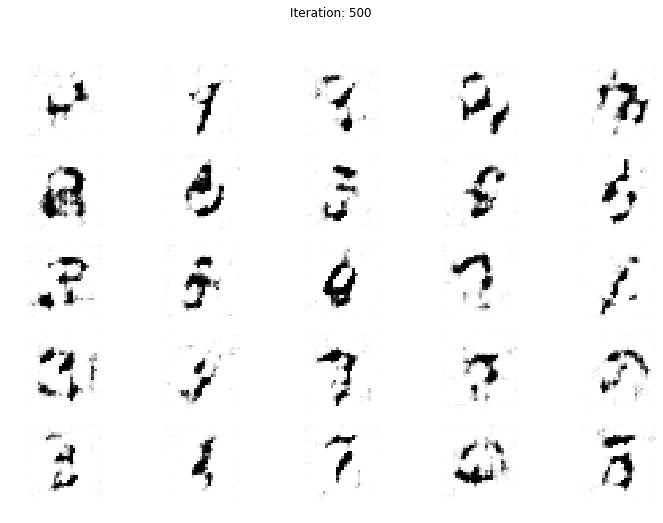

Iteration:   501 [D loss: 0.68157, acc.:  60.55%] [G loss: 1.03912]
Iteration:   502 [D loss: 0.71134, acc.:  57.81%] [G loss: 0.96227]
Iteration:   503 [D loss: 0.70276, acc.:  58.59%] [G loss: 0.97908]
Iteration:   504 [D loss: 0.75808, acc.:  46.88%] [G loss: 1.02494]
Iteration:   505 [D loss: 0.71922, acc.:  55.47%] [G loss: 1.13752]
Iteration:   506 [D loss: 0.73830, acc.:  51.56%] [G loss: 1.00971]
Iteration:   507 [D loss: 0.73774, acc.:  48.83%] [G loss: 1.04845]
Iteration:   508 [D loss: 0.70486, acc.:  53.12%] [G loss: 1.00600]
Iteration:   509 [D loss: 0.74002, acc.:  50.00%] [G loss: 0.99334]
Iteration:   510 [D loss: 0.66307, acc.:  58.98%] [G loss: 0.97471]
Iteration:   511 [D loss: 0.70481, acc.:  55.08%] [G loss: 0.92733]
Iteration:   512 [D loss: 0.65116, acc.:  63.28%] [G loss: 0.93726]
Iteration:   513 [D loss: 0.70085, acc.:  58.59%] [G loss: 0.89964]
Iteration:   514 [D loss: 0.72348, acc.:  57.42%] [G loss: 1.00676]
Iteration:   515 [D loss: 0.70142, acc.:  56.64%

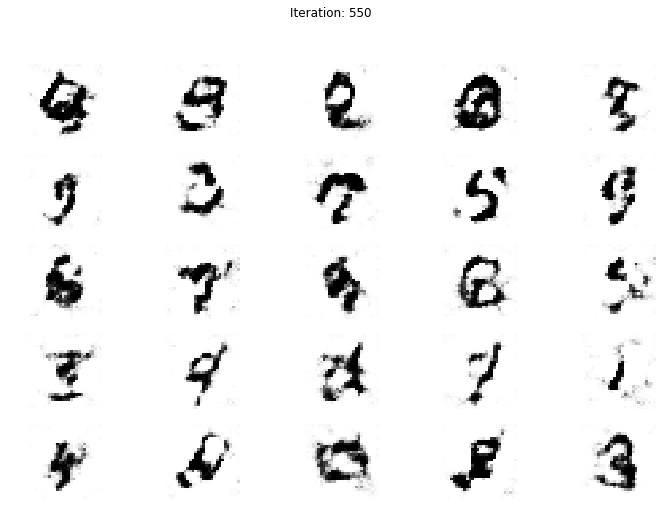

Iteration:   551 [D loss: 0.71238, acc.:  55.86%] [G loss: 0.99453]
Iteration:   552 [D loss: 0.71643, acc.:  52.34%] [G loss: 1.03946]
Iteration:   553 [D loss: 0.71096, acc.:  56.25%] [G loss: 0.97832]
Iteration:   554 [D loss: 0.72489, acc.:  53.52%] [G loss: 0.98349]
Iteration:   555 [D loss: 0.74532, acc.:  51.95%] [G loss: 0.88961]
Iteration:   556 [D loss: 0.80934, acc.:  45.31%] [G loss: 0.89180]
Iteration:   557 [D loss: 0.72951, acc.:  53.12%] [G loss: 0.90597]
Iteration:   558 [D loss: 0.72935, acc.:  51.95%] [G loss: 0.91578]
Iteration:   559 [D loss: 0.75394, acc.:  48.83%] [G loss: 0.94295]
Iteration:   560 [D loss: 0.71365, acc.:  53.52%] [G loss: 0.97268]
Iteration:   561 [D loss: 0.72729, acc.:  54.30%] [G loss: 1.03823]
Iteration:   562 [D loss: 0.70406, acc.:  56.64%] [G loss: 0.93674]
Iteration:   563 [D loss: 0.73000, acc.:  54.69%] [G loss: 1.01355]
Iteration:   564 [D loss: 0.68728, acc.:  54.69%] [G loss: 0.98589]
Iteration:   565 [D loss: 0.72773, acc.:  52.73%

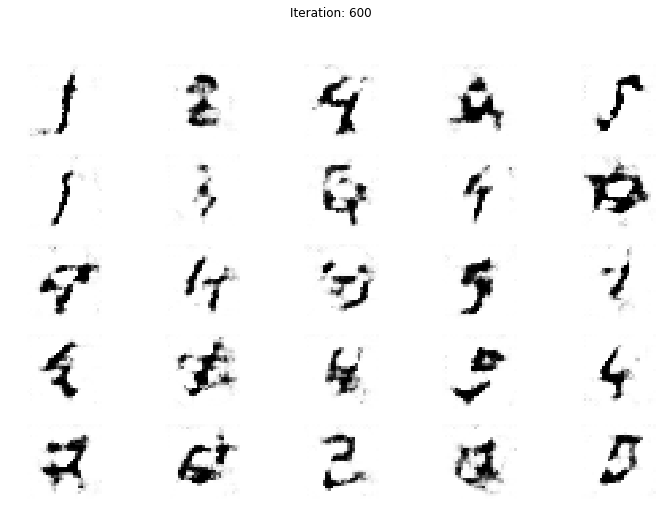

Iteration:   601 [D loss: 0.72217, acc.:  53.91%] [G loss: 0.97670]
Iteration:   602 [D loss: 0.71391, acc.:  55.08%] [G loss: 0.92830]
Iteration:   603 [D loss: 0.73914, acc.:  51.56%] [G loss: 0.98650]
Iteration:   604 [D loss: 0.70984, acc.:  54.69%] [G loss: 0.95363]
Iteration:   605 [D loss: 0.69016, acc.:  55.86%] [G loss: 0.90548]
Iteration:   606 [D loss: 0.71326, acc.:  54.69%] [G loss: 0.91816]
Iteration:   607 [D loss: 0.69686, acc.:  60.55%] [G loss: 0.79442]
Iteration:   608 [D loss: 0.69646, acc.:  57.81%] [G loss: 0.85759]
Iteration:   609 [D loss: 0.75344, acc.:  51.56%] [G loss: 0.91492]
Iteration:   610 [D loss: 0.73284, acc.:  51.17%] [G loss: 0.84360]
Iteration:   611 [D loss: 0.72563, acc.:  55.08%] [G loss: 0.93587]
Iteration:   612 [D loss: 0.74983, acc.:  51.17%] [G loss: 0.94748]
Iteration:   613 [D loss: 0.68786, acc.:  55.86%] [G loss: 1.06250]
Iteration:   614 [D loss: 0.76251, acc.:  46.48%] [G loss: 1.00120]
Iteration:   615 [D loss: 0.73267, acc.:  51.17%

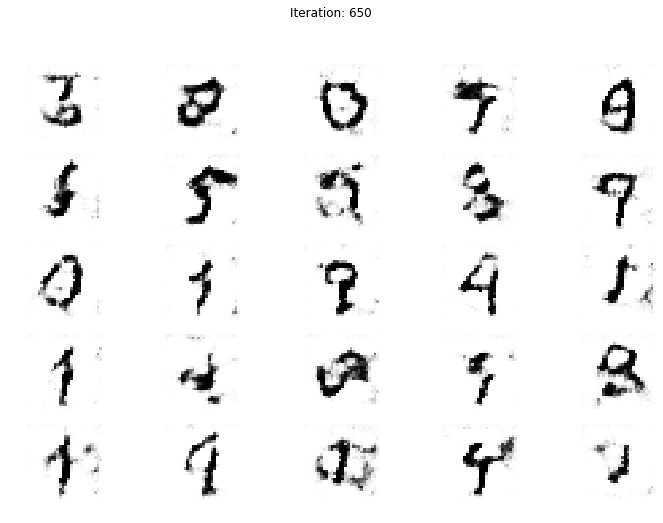

Iteration:   651 [D loss: 0.71447, acc.:  53.12%] [G loss: 0.89467]
Iteration:   652 [D loss: 0.70459, acc.:  55.47%] [G loss: 0.92362]
Iteration:   653 [D loss: 0.71002, acc.:  56.25%] [G loss: 0.89533]
Iteration:   654 [D loss: 0.70195, acc.:  55.47%] [G loss: 0.90723]
Iteration:   655 [D loss: 0.75187, acc.:  47.27%] [G loss: 0.85084]
Iteration:   656 [D loss: 0.72624, acc.:  53.52%] [G loss: 0.94700]
Iteration:   657 [D loss: 0.74489, acc.:  48.83%] [G loss: 0.92691]
Iteration:   658 [D loss: 0.70962, acc.:  52.34%] [G loss: 0.99454]
Iteration:   659 [D loss: 0.72921, acc.:  48.83%] [G loss: 0.98411]
Iteration:   660 [D loss: 0.74158, acc.:  51.17%] [G loss: 1.00480]
Iteration:   661 [D loss: 0.77622, acc.:  47.27%] [G loss: 0.91716]
Iteration:   662 [D loss: 0.77675, acc.:  46.09%] [G loss: 0.93681]
Iteration:   663 [D loss: 0.77273, acc.:  45.70%] [G loss: 0.90916]
Iteration:   664 [D loss: 0.74928, acc.:  52.73%] [G loss: 0.92460]
Iteration:   665 [D loss: 0.76239, acc.:  46.48%

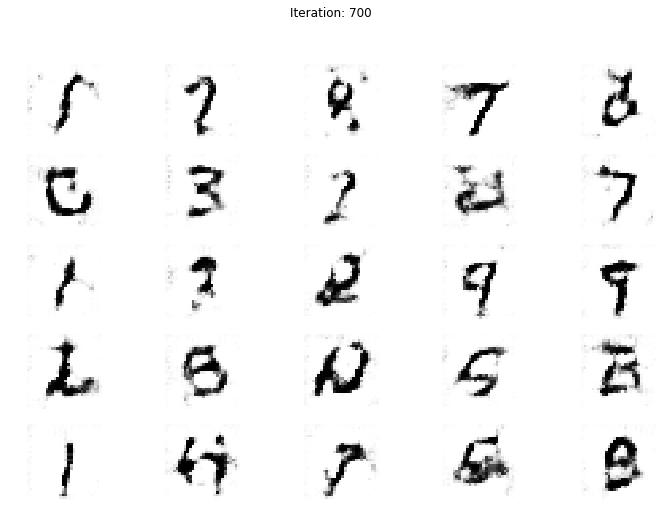

Iteration:   701 [D loss: 0.73493, acc.:  51.56%] [G loss: 0.91454]
Iteration:   702 [D loss: 0.76456, acc.:  47.27%] [G loss: 0.89730]
Iteration:   703 [D loss: 0.76021, acc.:  50.00%] [G loss: 0.87323]
Iteration:   704 [D loss: 0.70746, acc.:  53.91%] [G loss: 0.82474]
Iteration:   705 [D loss: 0.67638, acc.:  57.81%] [G loss: 0.83401]
Iteration:   706 [D loss: 0.67928, acc.:  59.77%] [G loss: 0.84804]
Iteration:   707 [D loss: 0.75112, acc.:  46.88%] [G loss: 0.85159]
Iteration:   708 [D loss: 0.70925, acc.:  52.34%] [G loss: 0.90893]
Iteration:   709 [D loss: 0.77496, acc.:  44.92%] [G loss: 0.87856]
Iteration:   710 [D loss: 0.69110, acc.:  57.03%] [G loss: 0.84743]
Iteration:   711 [D loss: 0.70637, acc.:  52.73%] [G loss: 0.83641]
Iteration:   712 [D loss: 0.71748, acc.:  51.56%] [G loss: 0.89131]
Iteration:   713 [D loss: 0.76328, acc.:  47.66%] [G loss: 0.84276]
Iteration:   714 [D loss: 0.71520, acc.:  53.52%] [G loss: 0.90529]
Iteration:   715 [D loss: 0.67432, acc.:  60.94%

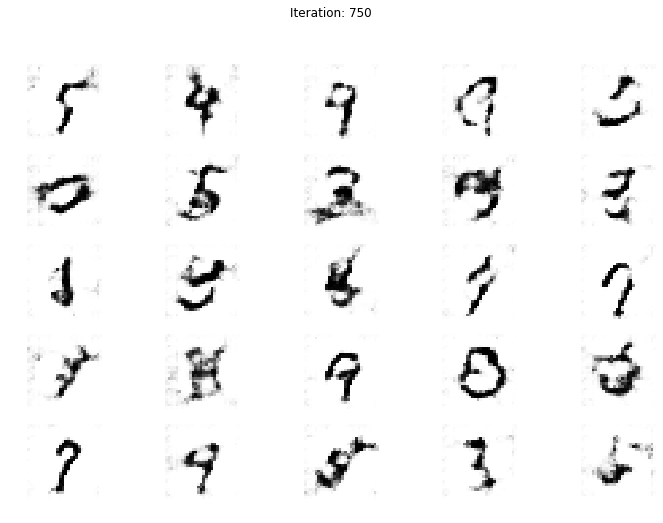

Iteration:   751 [D loss: 0.71720, acc.:  52.34%] [G loss: 0.92211]
Iteration:   752 [D loss: 0.70353, acc.:  56.25%] [G loss: 0.95935]
Iteration:   753 [D loss: 0.71420, acc.:  53.91%] [G loss: 0.81482]
Iteration:   754 [D loss: 0.71136, acc.:  52.34%] [G loss: 0.81770]
Iteration:   755 [D loss: 0.68679, acc.:  56.64%] [G loss: 0.85891]
Iteration:   756 [D loss: 0.72647, acc.:  51.95%] [G loss: 0.78827]
Iteration:   757 [D loss: 0.75609, acc.:  53.91%] [G loss: 0.84716]
Iteration:   758 [D loss: 0.72811, acc.:  55.08%] [G loss: 0.79904]
Iteration:   759 [D loss: 0.70479, acc.:  54.30%] [G loss: 0.88135]
Iteration:   760 [D loss: 0.69767, acc.:  56.64%] [G loss: 0.95024]
Iteration:   761 [D loss: 0.73151, acc.:  52.34%] [G loss: 0.88876]
Iteration:   762 [D loss: 0.73186, acc.:  49.61%] [G loss: 0.88114]
Iteration:   763 [D loss: 0.76054, acc.:  42.97%] [G loss: 0.86290]
Iteration:   764 [D loss: 0.76700, acc.:  51.17%] [G loss: 0.79400]
Iteration:   765 [D loss: 0.73285, acc.:  52.73%

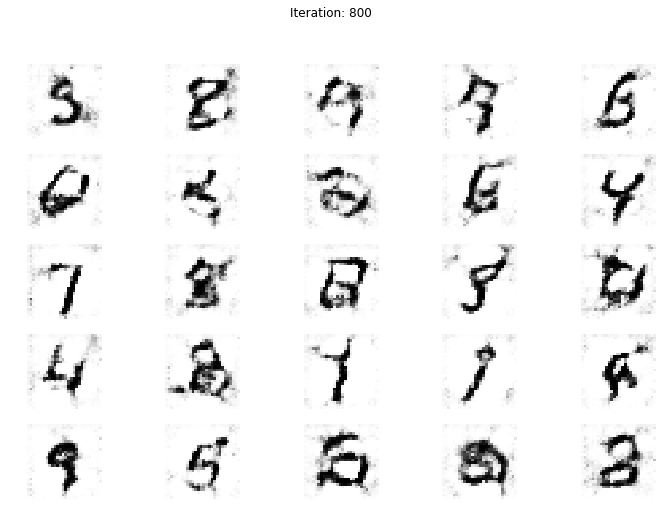

Iteration:   801 [D loss: 0.74801, acc.:  52.34%] [G loss: 0.89573]
Iteration:   802 [D loss: 0.73387, acc.:  49.61%] [G loss: 0.87956]
Iteration:   803 [D loss: 0.72480, acc.:  48.83%] [G loss: 0.85162]
Iteration:   804 [D loss: 0.72641, acc.:  54.30%] [G loss: 0.93186]
Iteration:   805 [D loss: 0.75598, acc.:  46.48%] [G loss: 0.95010]
Iteration:   806 [D loss: 0.74872, acc.:  50.00%] [G loss: 0.92517]
Iteration:   807 [D loss: 0.72501, acc.:  49.22%] [G loss: 0.95038]
Iteration:   808 [D loss: 0.74860, acc.:  49.61%] [G loss: 0.84691]
Iteration:   809 [D loss: 0.76987, acc.:  48.83%] [G loss: 0.92467]
Iteration:   810 [D loss: 0.66971, acc.:  58.59%] [G loss: 0.93180]
Iteration:   811 [D loss: 0.73453, acc.:  48.05%] [G loss: 0.90686]
Iteration:   812 [D loss: 0.72916, acc.:  49.61%] [G loss: 0.89163]
Iteration:   813 [D loss: 0.71095, acc.:  53.52%] [G loss: 0.93640]
Iteration:   814 [D loss: 0.74296, acc.:  50.39%] [G loss: 0.90105]
Iteration:   815 [D loss: 0.73012, acc.:  53.12%

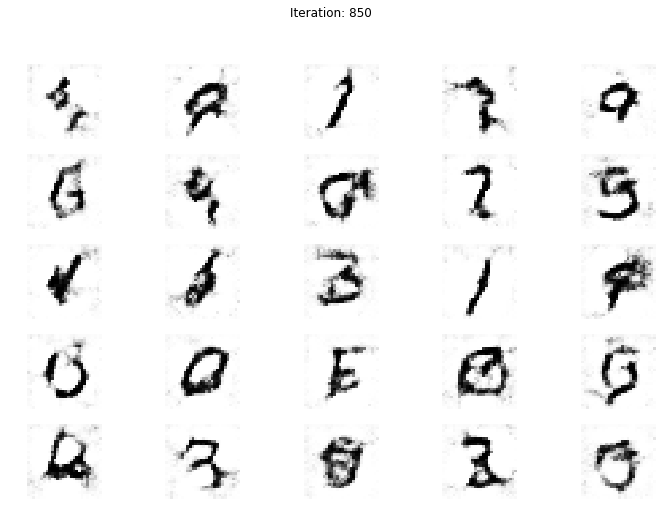

Iteration:   851 [D loss: 0.71886, acc.:  49.22%] [G loss: 0.97757]
Iteration:   852 [D loss: 0.73305, acc.:  53.52%] [G loss: 0.93222]
Iteration:   853 [D loss: 0.73674, acc.:  50.39%] [G loss: 0.84307]
Iteration:   854 [D loss: 0.74844, acc.:  51.17%] [G loss: 0.84331]
Iteration:   855 [D loss: 0.67972, acc.:  62.11%] [G loss: 0.90345]
Iteration:   856 [D loss: 0.73054, acc.:  52.34%] [G loss: 0.88612]
Iteration:   857 [D loss: 0.77214, acc.:  44.92%] [G loss: 0.86446]
Iteration:   858 [D loss: 0.70563, acc.:  51.17%] [G loss: 0.91408]
Iteration:   859 [D loss: 0.71657, acc.:  55.08%] [G loss: 0.83632]
Iteration:   860 [D loss: 0.78528, acc.:  44.53%] [G loss: 0.86778]
Iteration:   861 [D loss: 0.72147, acc.:  53.12%] [G loss: 0.88241]
Iteration:   862 [D loss: 0.74259, acc.:  49.22%] [G loss: 0.84516]
Iteration:   863 [D loss: 0.75990, acc.:  49.22%] [G loss: 0.92022]
Iteration:   864 [D loss: 0.74404, acc.:  49.22%] [G loss: 0.88465]
Iteration:   865 [D loss: 0.72184, acc.:  49.22%

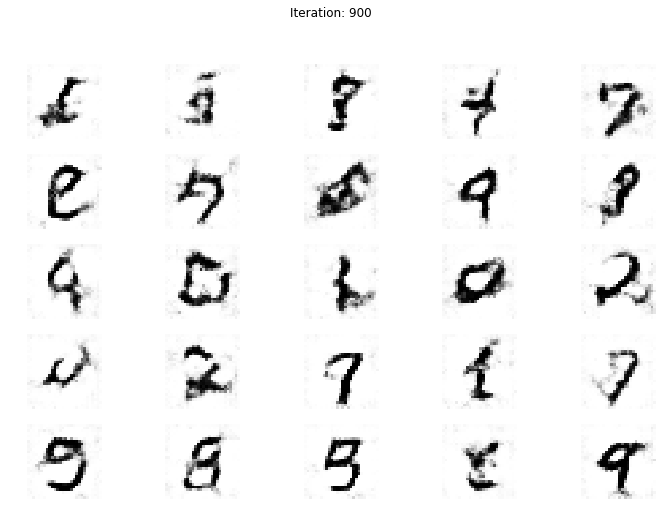

Iteration:   901 [D loss: 0.68953, acc.:  53.91%] [G loss: 0.90499]
Iteration:   902 [D loss: 0.76200, acc.:  47.66%] [G loss: 0.93287]
Iteration:   903 [D loss: 0.71696, acc.:  52.73%] [G loss: 0.87212]
Iteration:   904 [D loss: 0.74075, acc.:  48.05%] [G loss: 0.93811]
Iteration:   905 [D loss: 0.71720, acc.:  53.91%] [G loss: 0.91439]
Iteration:   906 [D loss: 0.72444, acc.:  53.91%] [G loss: 0.87642]
Iteration:   907 [D loss: 0.73182, acc.:  51.95%] [G loss: 0.87727]
Iteration:   908 [D loss: 0.72996, acc.:  48.44%] [G loss: 0.87320]
Iteration:   909 [D loss: 0.75351, acc.:  51.17%] [G loss: 0.81819]
Iteration:   910 [D loss: 0.73869, acc.:  50.00%] [G loss: 0.91205]
Iteration:   911 [D loss: 0.74561, acc.:  49.61%] [G loss: 0.91395]
Iteration:   912 [D loss: 0.71349, acc.:  55.86%] [G loss: 0.91499]
Iteration:   913 [D loss: 0.74846, acc.:  48.44%] [G loss: 0.90132]
Iteration:   914 [D loss: 0.73114, acc.:  49.61%] [G loss: 0.91065]
Iteration:   915 [D loss: 0.72766, acc.:  52.34%

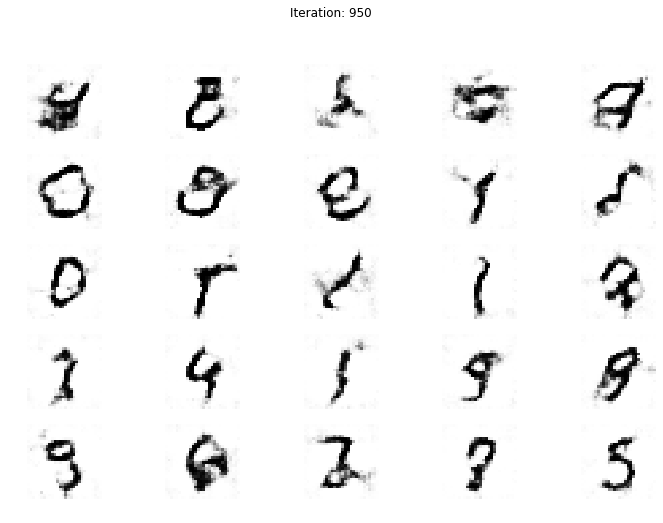

Iteration:   951 [D loss: 0.73072, acc.:  50.78%] [G loss: 0.91916]
Iteration:   952 [D loss: 0.73937, acc.:  48.83%] [G loss: 0.89787]
Iteration:   953 [D loss: 0.71592, acc.:  55.08%] [G loss: 0.92399]
Iteration:   954 [D loss: 0.69427, acc.:  57.81%] [G loss: 0.92864]
Iteration:   955 [D loss: 0.73766, acc.:  48.83%] [G loss: 0.85894]
Iteration:   956 [D loss: 0.73724, acc.:  50.78%] [G loss: 0.90802]
Iteration:   957 [D loss: 0.70937, acc.:  54.69%] [G loss: 0.86257]
Iteration:   958 [D loss: 0.73247, acc.:  50.39%] [G loss: 0.86292]
Iteration:   959 [D loss: 0.69207, acc.:  56.25%] [G loss: 0.88703]
Iteration:   960 [D loss: 0.75323, acc.:  49.61%] [G loss: 0.92847]
Iteration:   961 [D loss: 0.69814, acc.:  58.59%] [G loss: 0.90852]
Iteration:   962 [D loss: 0.73020, acc.:  53.91%] [G loss: 0.97536]
Iteration:   963 [D loss: 0.72556, acc.:  50.39%] [G loss: 0.95333]
Iteration:   964 [D loss: 0.74259, acc.:  51.17%] [G loss: 0.91993]
Iteration:   965 [D loss: 0.73637, acc.:  52.34%

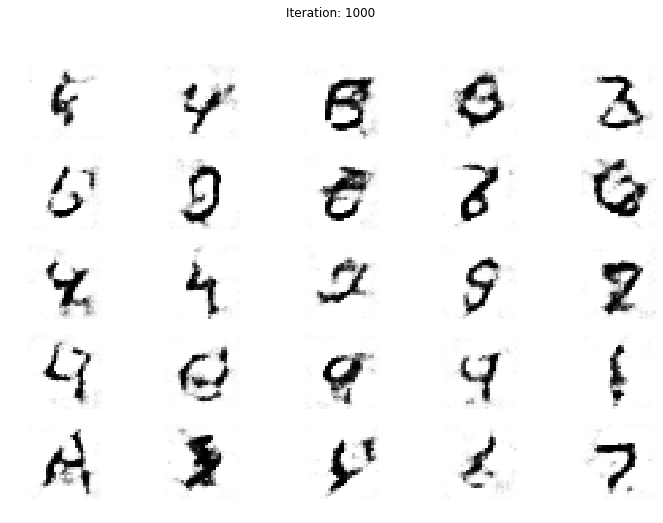

Iteration:  1001 [D loss: 0.71969, acc.:  52.73%] [G loss: 0.85210]
Iteration:  1002 [D loss: 0.78170, acc.:  46.09%] [G loss: 0.88254]
Iteration:  1003 [D loss: 0.74549, acc.:  48.83%] [G loss: 0.94222]
Iteration:  1004 [D loss: 0.73168, acc.:  53.12%] [G loss: 0.94564]
Iteration:  1005 [D loss: 0.72867, acc.:  49.61%] [G loss: 0.94689]
Iteration:  1006 [D loss: 0.74400, acc.:  50.78%] [G loss: 0.87739]
Iteration:  1007 [D loss: 0.73223, acc.:  52.34%] [G loss: 0.87915]
Iteration:  1008 [D loss: 0.72259, acc.:  53.12%] [G loss: 0.90170]
Iteration:  1009 [D loss: 0.75652, acc.:  46.48%] [G loss: 0.88157]
Iteration:  1010 [D loss: 0.76056, acc.:  43.75%] [G loss: 0.85511]
Iteration:  1011 [D loss: 0.73419, acc.:  50.00%] [G loss: 0.88229]
Iteration:  1012 [D loss: 0.74261, acc.:  50.00%] [G loss: 0.88027]
Iteration:  1013 [D loss: 0.70602, acc.:  55.86%] [G loss: 0.89759]
Iteration:  1014 [D loss: 0.76304, acc.:  45.70%] [G loss: 0.87502]
Iteration:  1015 [D loss: 0.70259, acc.:  57.81%

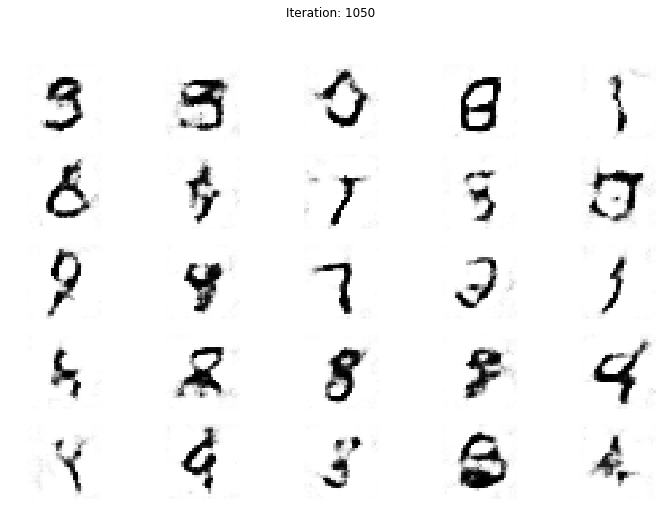

Iteration:  1051 [D loss: 0.72688, acc.:  50.78%] [G loss: 0.85339]
Iteration:  1052 [D loss: 0.74594, acc.:  51.17%] [G loss: 0.86362]
Iteration:  1053 [D loss: 0.74045, acc.:  51.17%] [G loss: 0.78035]
Iteration:  1054 [D loss: 0.67909, acc.:  56.25%] [G loss: 0.88238]
Iteration:  1055 [D loss: 0.67752, acc.:  58.20%] [G loss: 0.89750]
Iteration:  1056 [D loss: 0.68762, acc.:  60.94%] [G loss: 0.86797]
Iteration:  1057 [D loss: 0.73222, acc.:  51.56%] [G loss: 0.87937]
Iteration:  1058 [D loss: 0.71857, acc.:  51.17%] [G loss: 0.83243]
Iteration:  1059 [D loss: 0.74492, acc.:  50.78%] [G loss: 0.91206]
Iteration:  1060 [D loss: 0.69579, acc.:  53.52%] [G loss: 0.92522]
Iteration:  1061 [D loss: 0.69981, acc.:  54.30%] [G loss: 0.85795]
Iteration:  1062 [D loss: 0.72236, acc.:  54.30%] [G loss: 0.88664]
Iteration:  1063 [D loss: 0.74790, acc.:  51.56%] [G loss: 0.84242]
Iteration:  1064 [D loss: 0.71843, acc.:  53.52%] [G loss: 0.87170]
Iteration:  1065 [D loss: 0.71168, acc.:  52.73%

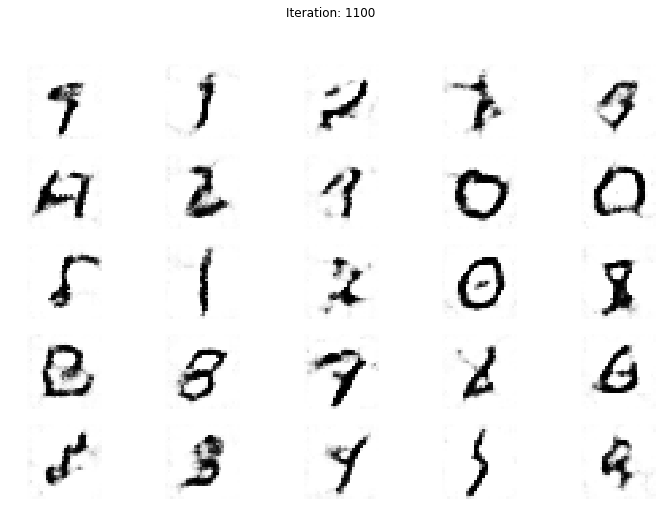

Iteration:  1101 [D loss: 0.71999, acc.:  53.12%] [G loss: 0.93819]
Iteration:  1102 [D loss: 0.75506, acc.:  46.09%] [G loss: 0.86932]
Iteration:  1103 [D loss: 0.69607, acc.:  53.91%] [G loss: 0.96887]
Iteration:  1104 [D loss: 0.73657, acc.:  49.22%] [G loss: 0.82920]
Iteration:  1105 [D loss: 0.67431, acc.:  58.98%] [G loss: 0.88999]
Iteration:  1106 [D loss: 0.71133, acc.:  51.95%] [G loss: 0.91325]
Iteration:  1107 [D loss: 0.69758, acc.:  56.25%] [G loss: 0.89798]
Iteration:  1108 [D loss: 0.73116, acc.:  50.78%] [G loss: 0.85860]
Iteration:  1109 [D loss: 0.69903, acc.:  55.47%] [G loss: 0.86912]
Iteration:  1110 [D loss: 0.70469, acc.:  55.86%] [G loss: 0.85448]
Iteration:  1111 [D loss: 0.74995, acc.:  48.05%] [G loss: 0.86491]
Iteration:  1112 [D loss: 0.68499, acc.:  55.08%] [G loss: 0.89672]
Iteration:  1113 [D loss: 0.71148, acc.:  52.73%] [G loss: 0.85318]
Iteration:  1114 [D loss: 0.72663, acc.:  50.39%] [G loss: 0.92491]
Iteration:  1115 [D loss: 0.72027, acc.:  51.56%

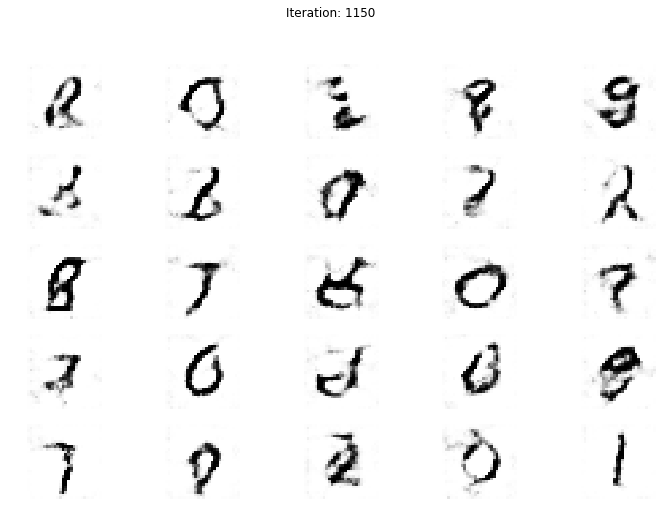

Iteration:  1151 [D loss: 0.73261, acc.:  56.25%] [G loss: 0.93286]
Iteration:  1152 [D loss: 0.74905, acc.:  47.27%] [G loss: 0.79385]
Iteration:  1153 [D loss: 0.67726, acc.:  57.03%] [G loss: 0.84165]
Iteration:  1154 [D loss: 0.74559, acc.:  50.39%] [G loss: 0.87515]
Iteration:  1155 [D loss: 0.70988, acc.:  51.56%] [G loss: 0.91693]
Iteration:  1156 [D loss: 0.69768, acc.:  57.03%] [G loss: 0.85276]
Iteration:  1157 [D loss: 0.71490, acc.:  54.69%] [G loss: 0.88859]
Iteration:  1158 [D loss: 0.72607, acc.:  50.78%] [G loss: 0.88736]
Iteration:  1159 [D loss: 0.70921, acc.:  55.08%] [G loss: 0.87903]
Iteration:  1160 [D loss: 0.75809, acc.:  43.75%] [G loss: 0.87843]
Iteration:  1161 [D loss: 0.73789, acc.:  52.73%] [G loss: 0.88739]
Iteration:  1162 [D loss: 0.72080, acc.:  52.34%] [G loss: 0.87668]
Iteration:  1163 [D loss: 0.71410, acc.:  51.95%] [G loss: 0.87610]
Iteration:  1164 [D loss: 0.71944, acc.:  51.56%] [G loss: 0.93656]
Iteration:  1165 [D loss: 0.72727, acc.:  51.95%

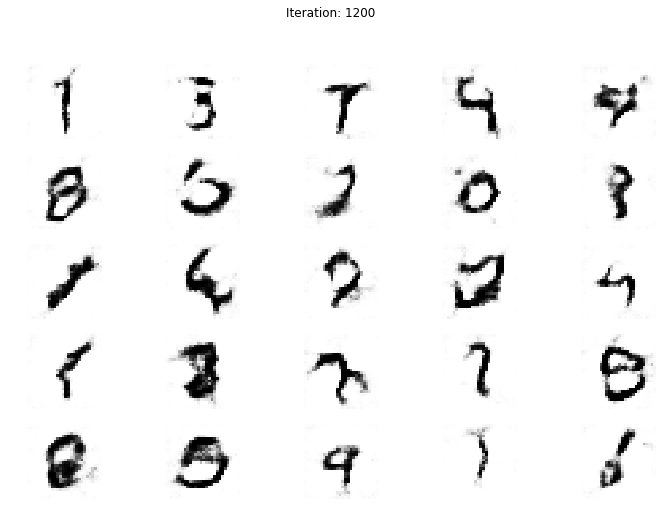

Iteration:  1201 [D loss: 0.74887, acc.:  47.27%] [G loss: 0.90374]
Iteration:  1202 [D loss: 0.71009, acc.:  50.00%] [G loss: 0.87494]
Iteration:  1203 [D loss: 0.67392, acc.:  57.42%] [G loss: 0.89648]
Iteration:  1204 [D loss: 0.73173, acc.:  50.78%] [G loss: 0.84256]
Iteration:  1205 [D loss: 0.69056, acc.:  57.42%] [G loss: 0.88528]
Iteration:  1206 [D loss: 0.72606, acc.:  47.27%] [G loss: 0.82382]
Iteration:  1207 [D loss: 0.69255, acc.:  55.08%] [G loss: 0.84323]
Iteration:  1208 [D loss: 0.69035, acc.:  55.08%] [G loss: 0.86230]
Iteration:  1209 [D loss: 0.72993, acc.:  51.56%] [G loss: 0.85146]
Iteration:  1210 [D loss: 0.70908, acc.:  54.30%] [G loss: 0.91196]
Iteration:  1211 [D loss: 0.70904, acc.:  52.73%] [G loss: 0.88461]
Iteration:  1212 [D loss: 0.71281, acc.:  50.78%] [G loss: 0.89873]
Iteration:  1213 [D loss: 0.70802, acc.:  55.08%] [G loss: 0.88841]
Iteration:  1214 [D loss: 0.70691, acc.:  51.95%] [G loss: 0.89213]
Iteration:  1215 [D loss: 0.72798, acc.:  51.56%

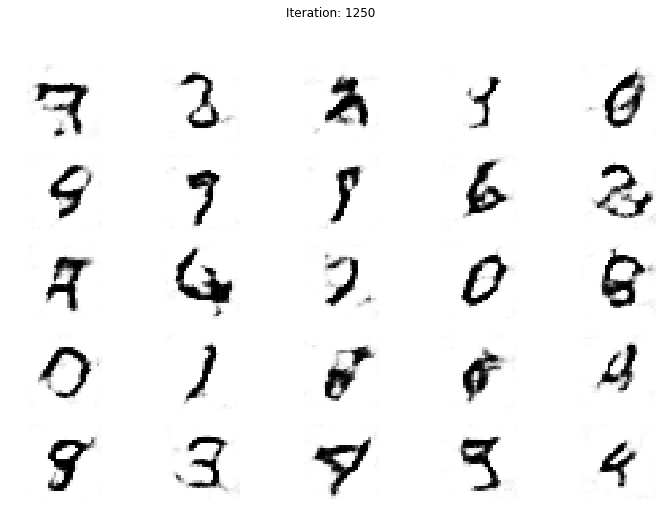

Iteration:  1251 [D loss: 0.69031, acc.:  58.20%] [G loss: 0.87109]
Iteration:  1252 [D loss: 0.72407, acc.:  49.22%] [G loss: 0.85162]
Iteration:  1253 [D loss: 0.74756, acc.:  49.22%] [G loss: 0.85490]
Iteration:  1254 [D loss: 0.71970, acc.:  47.66%] [G loss: 0.89828]
Iteration:  1255 [D loss: 0.71801, acc.:  51.95%] [G loss: 0.88583]
Iteration:  1256 [D loss: 0.69198, acc.:  56.64%] [G loss: 0.83425]
Iteration:  1257 [D loss: 0.75021, acc.:  44.92%] [G loss: 0.82389]
Iteration:  1258 [D loss: 0.70800, acc.:  52.73%] [G loss: 0.86002]
Iteration:  1259 [D loss: 0.73710, acc.:  53.12%] [G loss: 0.82586]
Iteration:  1260 [D loss: 0.68481, acc.:  56.64%] [G loss: 0.85840]
Iteration:  1261 [D loss: 0.73107, acc.:  55.47%] [G loss: 0.83856]
Iteration:  1262 [D loss: 0.73232, acc.:  51.56%] [G loss: 0.85469]
Iteration:  1263 [D loss: 0.73190, acc.:  50.00%] [G loss: 0.84367]
Iteration:  1264 [D loss: 0.69891, acc.:  53.12%] [G loss: 0.84509]
Iteration:  1265 [D loss: 0.71664, acc.:  54.69%

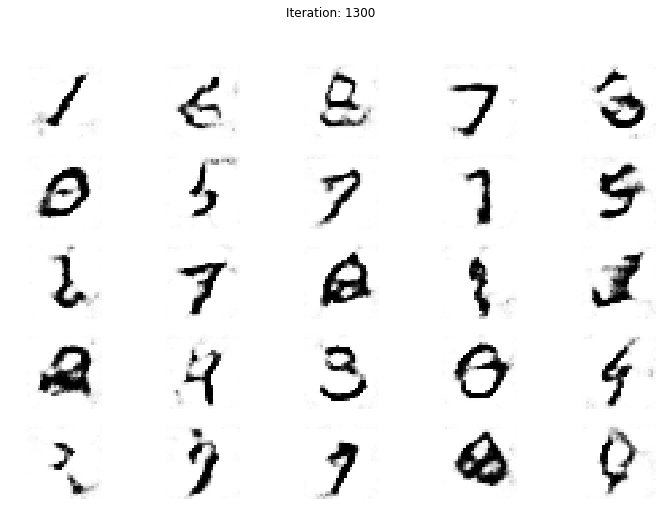

Iteration:  1301 [D loss: 0.70772, acc.:  56.25%] [G loss: 0.81916]
Iteration:  1302 [D loss: 0.68759, acc.:  52.73%] [G loss: 0.86327]
Iteration:  1303 [D loss: 0.68682, acc.:  58.20%] [G loss: 0.90254]
Iteration:  1304 [D loss: 0.72838, acc.:  53.12%] [G loss: 0.89224]
Iteration:  1305 [D loss: 0.70163, acc.:  50.00%] [G loss: 0.88868]
Iteration:  1306 [D loss: 0.72124, acc.:  51.95%] [G loss: 0.85281]
Iteration:  1307 [D loss: 0.71209, acc.:  50.39%] [G loss: 0.87184]
Iteration:  1308 [D loss: 0.70689, acc.:  52.34%] [G loss: 0.89794]
Iteration:  1309 [D loss: 0.70370, acc.:  57.03%] [G loss: 0.84804]
Iteration:  1310 [D loss: 0.72903, acc.:  49.22%] [G loss: 0.93419]
Iteration:  1311 [D loss: 0.70821, acc.:  53.91%] [G loss: 0.92022]
Iteration:  1312 [D loss: 0.74480, acc.:  49.61%] [G loss: 0.87693]
Iteration:  1313 [D loss: 0.67860, acc.:  60.94%] [G loss: 0.86156]
Iteration:  1314 [D loss: 0.67040, acc.:  60.16%] [G loss: 0.89903]
Iteration:  1315 [D loss: 0.73387, acc.:  51.17%

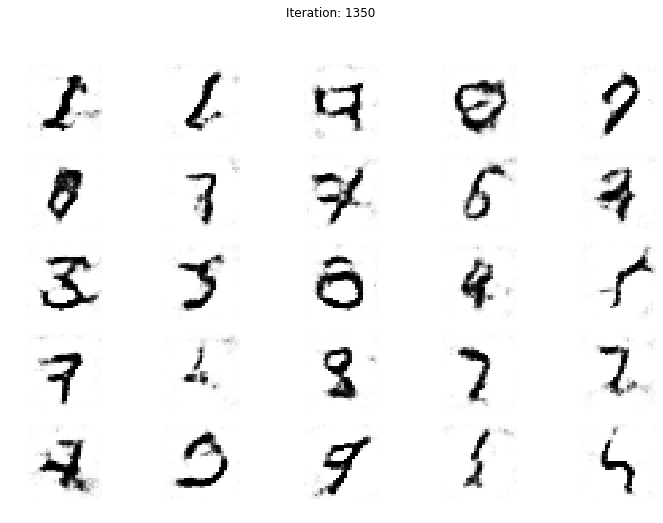

Iteration:  1351 [D loss: 0.68469, acc.:  56.64%] [G loss: 0.90758]
Iteration:  1352 [D loss: 0.71954, acc.:  52.73%] [G loss: 0.84429]
Iteration:  1353 [D loss: 0.71993, acc.:  50.78%] [G loss: 0.86021]
Iteration:  1354 [D loss: 0.74595, acc.:  52.34%] [G loss: 0.79744]
Iteration:  1355 [D loss: 0.71396, acc.:  49.61%] [G loss: 0.90072]
Iteration:  1356 [D loss: 0.72609, acc.:  49.61%] [G loss: 0.89992]
Iteration:  1357 [D loss: 0.70373, acc.:  55.47%] [G loss: 0.89937]
Iteration:  1358 [D loss: 0.70829, acc.:  57.03%] [G loss: 0.90400]
Iteration:  1359 [D loss: 0.68008, acc.:  56.64%] [G loss: 0.89924]
Iteration:  1360 [D loss: 0.71856, acc.:  56.64%] [G loss: 0.82669]
Iteration:  1361 [D loss: 0.67573, acc.:  60.94%] [G loss: 0.86746]
Iteration:  1362 [D loss: 0.71139, acc.:  55.86%] [G loss: 0.83953]
Iteration:  1363 [D loss: 0.73005, acc.:  51.17%] [G loss: 0.87889]
Iteration:  1364 [D loss: 0.72240, acc.:  55.08%] [G loss: 0.86503]
Iteration:  1365 [D loss: 0.71407, acc.:  51.95%

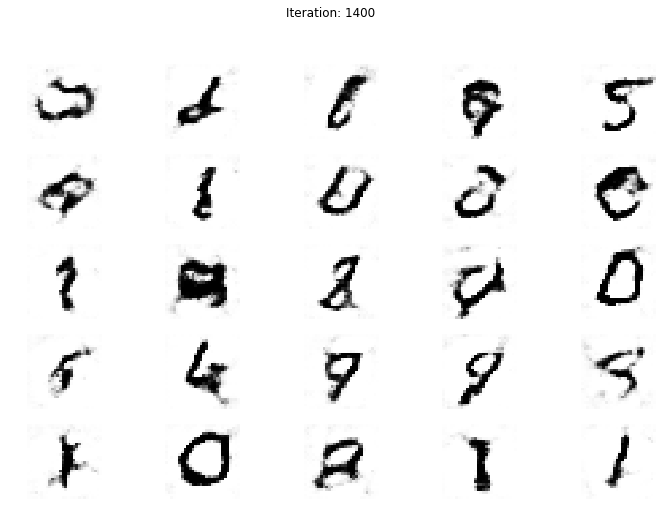

Iteration:  1401 [D loss: 0.73773, acc.:  48.44%] [G loss: 0.90001]
Iteration:  1402 [D loss: 0.72163, acc.:  51.17%] [G loss: 0.83204]
Iteration:  1403 [D loss: 0.70486, acc.:  52.73%] [G loss: 0.83071]
Iteration:  1404 [D loss: 0.71244, acc.:  55.86%] [G loss: 0.89100]
Iteration:  1405 [D loss: 0.70596, acc.:  53.52%] [G loss: 0.87708]
Iteration:  1406 [D loss: 0.73987, acc.:  46.09%] [G loss: 0.87303]
Iteration:  1407 [D loss: 0.74652, acc.:  48.83%] [G loss: 0.86311]
Iteration:  1408 [D loss: 0.71748, acc.:  49.61%] [G loss: 0.88713]
Iteration:  1409 [D loss: 0.76927, acc.:  45.31%] [G loss: 0.88097]
Iteration:  1410 [D loss: 0.71969, acc.:  52.34%] [G loss: 0.78394]
Iteration:  1411 [D loss: 0.74467, acc.:  51.56%] [G loss: 0.87793]
Iteration:  1412 [D loss: 0.67882, acc.:  55.08%] [G loss: 0.84564]
Iteration:  1413 [D loss: 0.70386, acc.:  52.34%] [G loss: 0.95651]
Iteration:  1414 [D loss: 0.72879, acc.:  50.39%] [G loss: 0.85158]
Iteration:  1415 [D loss: 0.70722, acc.:  53.12%

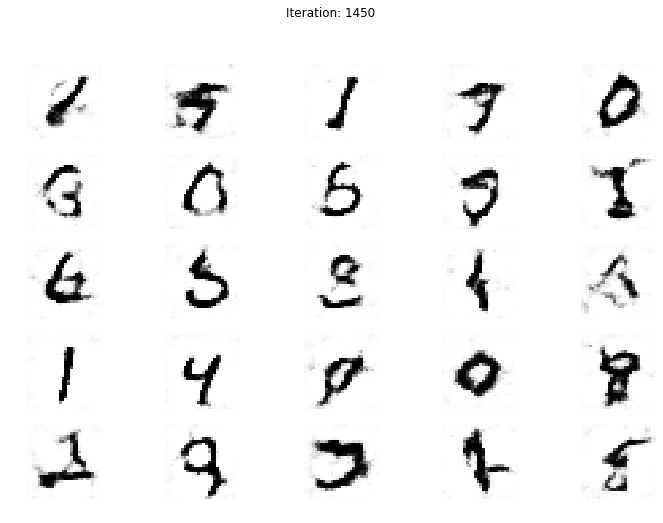

Iteration:  1451 [D loss: 0.74479, acc.:  50.78%] [G loss: 0.83261]
Iteration:  1452 [D loss: 0.73377, acc.:  52.73%] [G loss: 0.83466]
Iteration:  1453 [D loss: 0.69821, acc.:  55.47%] [G loss: 0.89945]
Iteration:  1454 [D loss: 0.68037, acc.:  61.33%] [G loss: 0.85602]
Iteration:  1455 [D loss: 0.75868, acc.:  48.05%] [G loss: 0.87254]
Iteration:  1456 [D loss: 0.69842, acc.:  57.03%] [G loss: 0.84151]
Iteration:  1457 [D loss: 0.70858, acc.:  53.91%] [G loss: 0.84511]
Iteration:  1458 [D loss: 0.73405, acc.:  51.56%] [G loss: 0.86473]
Iteration:  1459 [D loss: 0.72594, acc.:  50.78%] [G loss: 0.88668]
Iteration:  1460 [D loss: 0.69952, acc.:  56.64%] [G loss: 0.77622]
Iteration:  1461 [D loss: 0.72344, acc.:  50.78%] [G loss: 0.80631]
Iteration:  1462 [D loss: 0.72072, acc.:  50.39%] [G loss: 0.88348]
Iteration:  1463 [D loss: 0.69635, acc.:  57.81%] [G loss: 0.89850]
Iteration:  1464 [D loss: 0.68129, acc.:  54.30%] [G loss: 0.87317]
Iteration:  1465 [D loss: 0.70505, acc.:  53.12%

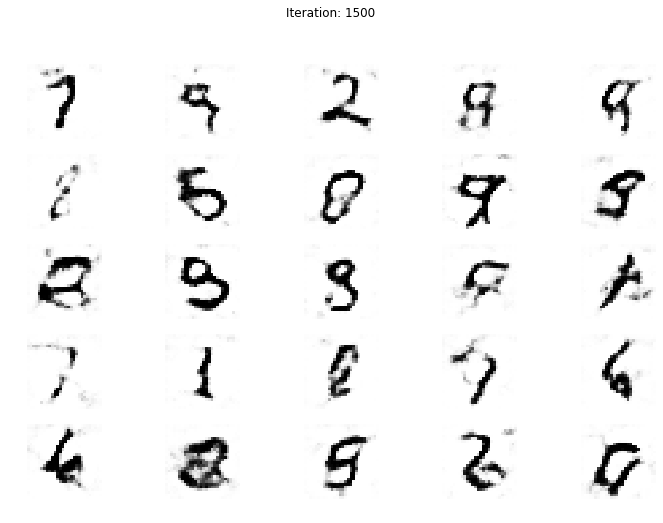

Iteration:  1501 [D loss: 0.73237, acc.:  56.25%] [G loss: 0.78229]
Iteration:  1502 [D loss: 0.70978, acc.:  55.08%] [G loss: 0.87067]
Iteration:  1503 [D loss: 0.64736, acc.:  62.50%] [G loss: 0.85953]
Iteration:  1504 [D loss: 0.71974, acc.:  53.12%] [G loss: 0.85557]
Iteration:  1505 [D loss: 0.70613, acc.:  52.34%] [G loss: 0.84967]
Iteration:  1506 [D loss: 0.70674, acc.:  57.03%] [G loss: 0.83498]
Iteration:  1507 [D loss: 0.71489, acc.:  49.61%] [G loss: 0.86355]
Iteration:  1508 [D loss: 0.68395, acc.:  58.20%] [G loss: 0.88990]
Iteration:  1509 [D loss: 0.71997, acc.:  51.56%] [G loss: 0.88999]
Iteration:  1510 [D loss: 0.74005, acc.:  50.00%] [G loss: 0.87332]
Iteration:  1511 [D loss: 0.70924, acc.:  52.73%] [G loss: 0.86964]
Iteration:  1512 [D loss: 0.70981, acc.:  51.95%] [G loss: 0.92745]
Iteration:  1513 [D loss: 0.69373, acc.:  58.20%] [G loss: 0.88426]
Iteration:  1514 [D loss: 0.72992, acc.:  48.83%] [G loss: 0.82045]
Iteration:  1515 [D loss: 0.74801, acc.:  51.17%

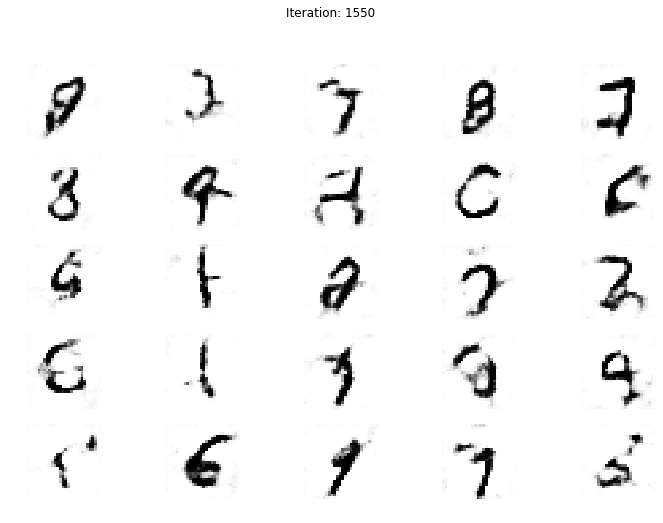

Iteration:  1551 [D loss: 0.69843, acc.:  57.03%] [G loss: 0.87674]
Iteration:  1552 [D loss: 0.69356, acc.:  55.86%] [G loss: 0.85326]
Iteration:  1553 [D loss: 0.71326, acc.:  53.52%] [G loss: 0.81697]
Iteration:  1554 [D loss: 0.67259, acc.:  60.55%] [G loss: 0.82496]
Iteration:  1555 [D loss: 0.71076, acc.:  52.34%] [G loss: 0.83921]
Iteration:  1556 [D loss: 0.66836, acc.:  57.81%] [G loss: 0.87819]
Iteration:  1557 [D loss: 0.73009, acc.:  50.78%] [G loss: 0.88253]
Iteration:  1558 [D loss: 0.71309, acc.:  55.08%] [G loss: 0.81194]
Iteration:  1559 [D loss: 0.74584, acc.:  45.31%] [G loss: 0.91377]
Iteration:  1560 [D loss: 0.68232, acc.:  57.42%] [G loss: 0.86029]
Iteration:  1561 [D loss: 0.71804, acc.:  50.00%] [G loss: 0.86350]
Iteration:  1562 [D loss: 0.70147, acc.:  52.73%] [G loss: 0.87733]
Iteration:  1563 [D loss: 0.75467, acc.:  50.00%] [G loss: 0.85638]
Iteration:  1564 [D loss: 0.70584, acc.:  51.56%] [G loss: 0.89626]
Iteration:  1565 [D loss: 0.68633, acc.:  58.59%

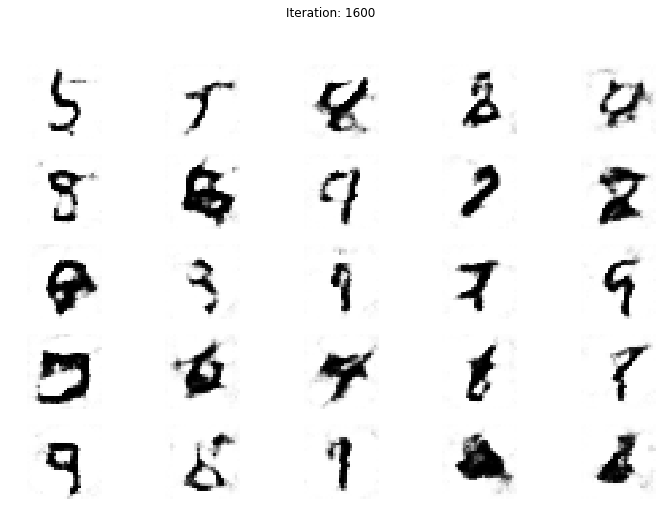

Iteration:  1601 [D loss: 0.69865, acc.:  56.25%] [G loss: 0.86141]
Iteration:  1602 [D loss: 0.69074, acc.:  57.81%] [G loss: 0.88763]
Iteration:  1603 [D loss: 0.68328, acc.:  58.98%] [G loss: 0.83798]
Iteration:  1604 [D loss: 0.72795, acc.:  53.52%] [G loss: 0.84121]
Iteration:  1605 [D loss: 0.69007, acc.:  56.64%] [G loss: 0.86049]
Iteration:  1606 [D loss: 0.69928, acc.:  55.47%] [G loss: 0.86649]
Iteration:  1607 [D loss: 0.71214, acc.:  54.69%] [G loss: 0.79641]
Iteration:  1608 [D loss: 0.69072, acc.:  54.30%] [G loss: 0.87444]
Iteration:  1609 [D loss: 0.69423, acc.:  54.30%] [G loss: 0.89402]
Iteration:  1610 [D loss: 0.70003, acc.:  51.95%] [G loss: 0.85047]
Iteration:  1611 [D loss: 0.73297, acc.:  48.44%] [G loss: 0.90117]
Iteration:  1612 [D loss: 0.73009, acc.:  48.83%] [G loss: 0.87220]
Iteration:  1613 [D loss: 0.70580, acc.:  54.30%] [G loss: 0.84558]
Iteration:  1614 [D loss: 0.67619, acc.:  58.20%] [G loss: 0.86540]
Iteration:  1615 [D loss: 0.72363, acc.:  53.52%

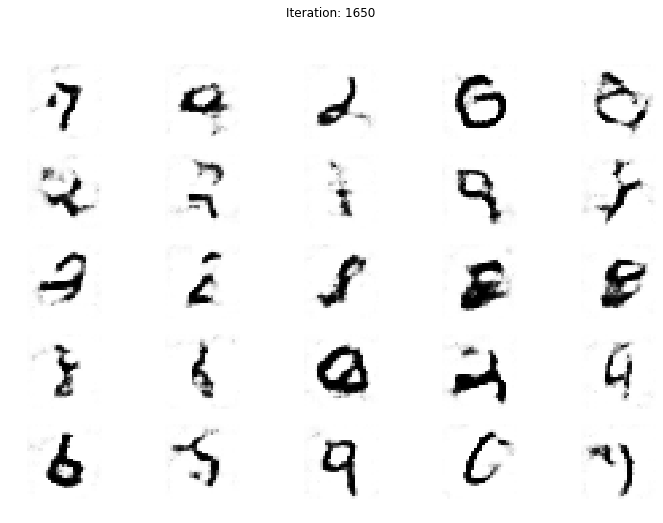

Iteration:  1651 [D loss: 0.74555, acc.:  47.66%] [G loss: 0.88680]
Iteration:  1652 [D loss: 0.70161, acc.:  52.73%] [G loss: 0.88144]
Iteration:  1653 [D loss: 0.74008, acc.:  48.83%] [G loss: 0.91080]
Iteration:  1654 [D loss: 0.72306, acc.:  53.52%] [G loss: 0.87132]
Iteration:  1655 [D loss: 0.70628, acc.:  53.52%] [G loss: 0.85249]
Iteration:  1656 [D loss: 0.69869, acc.:  52.73%] [G loss: 0.87206]
Iteration:  1657 [D loss: 0.71164, acc.:  55.08%] [G loss: 0.85051]
Iteration:  1658 [D loss: 0.72606, acc.:  50.78%] [G loss: 0.86392]
Iteration:  1659 [D loss: 0.67267, acc.:  58.20%] [G loss: 0.92123]
Iteration:  1660 [D loss: 0.72851, acc.:  52.34%] [G loss: 0.84793]
Iteration:  1661 [D loss: 0.72498, acc.:  51.95%] [G loss: 0.86721]
Iteration:  1662 [D loss: 0.68649, acc.:  55.47%] [G loss: 0.83458]
Iteration:  1663 [D loss: 0.68747, acc.:  56.25%] [G loss: 0.83119]
Iteration:  1664 [D loss: 0.66650, acc.:  60.16%] [G loss: 0.89274]
Iteration:  1665 [D loss: 0.76992, acc.:  44.53%

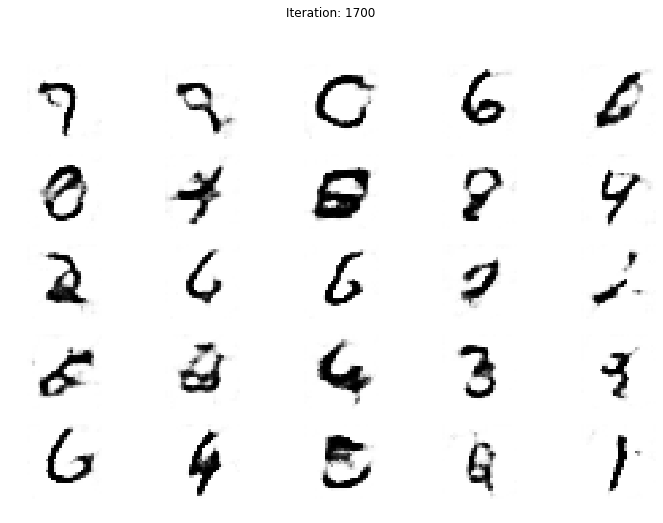

Iteration:  1701 [D loss: 0.69463, acc.:  51.56%] [G loss: 0.81967]
Iteration:  1702 [D loss: 0.70505, acc.:  58.59%] [G loss: 0.84660]
Iteration:  1703 [D loss: 0.72808, acc.:  51.95%] [G loss: 0.85068]
Iteration:  1704 [D loss: 0.64772, acc.:  60.16%] [G loss: 0.78881]
Iteration:  1705 [D loss: 0.71164, acc.:  49.22%] [G loss: 0.85930]
Iteration:  1706 [D loss: 0.70353, acc.:  52.73%] [G loss: 0.86712]
Iteration:  1707 [D loss: 0.72134, acc.:  50.39%] [G loss: 0.91698]
Iteration:  1708 [D loss: 0.69287, acc.:  58.59%] [G loss: 0.85568]
Iteration:  1709 [D loss: 0.74976, acc.:  45.31%] [G loss: 0.83811]
Iteration:  1710 [D loss: 0.70373, acc.:  58.59%] [G loss: 0.90223]
Iteration:  1711 [D loss: 0.70264, acc.:  51.95%] [G loss: 0.84159]
Iteration:  1712 [D loss: 0.71690, acc.:  54.30%] [G loss: 0.86267]
Iteration:  1713 [D loss: 0.70264, acc.:  51.95%] [G loss: 0.86057]
Iteration:  1714 [D loss: 0.70402, acc.:  54.30%] [G loss: 0.83966]
Iteration:  1715 [D loss: 0.69152, acc.:  54.69%

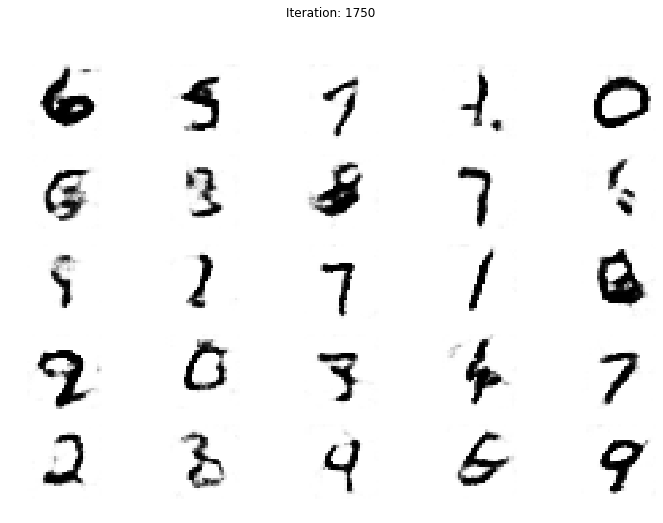

Iteration:  1751 [D loss: 0.69139, acc.:  57.03%] [G loss: 0.79902]
Iteration:  1752 [D loss: 0.69308, acc.:  54.69%] [G loss: 0.78547]
Iteration:  1753 [D loss: 0.70520, acc.:  53.12%] [G loss: 0.83891]
Iteration:  1754 [D loss: 0.74960, acc.:  47.66%] [G loss: 0.82149]
Iteration:  1755 [D loss: 0.67399, acc.:  56.64%] [G loss: 0.93294]
Iteration:  1756 [D loss: 0.69415, acc.:  57.81%] [G loss: 0.93827]
Iteration:  1757 [D loss: 0.73174, acc.:  52.34%] [G loss: 0.82684]
Iteration:  1758 [D loss: 0.68311, acc.:  54.69%] [G loss: 0.83700]
Iteration:  1759 [D loss: 0.73641, acc.:  46.48%] [G loss: 0.83696]
Iteration:  1760 [D loss: 0.70260, acc.:  54.30%] [G loss: 0.85698]
Iteration:  1761 [D loss: 0.68880, acc.:  57.42%] [G loss: 0.78014]
Iteration:  1762 [D loss: 0.71021, acc.:  53.91%] [G loss: 0.87212]
Iteration:  1763 [D loss: 0.70345, acc.:  57.42%] [G loss: 0.93126]
Iteration:  1764 [D loss: 0.72369, acc.:  48.05%] [G loss: 0.90183]
Iteration:  1765 [D loss: 0.69309, acc.:  53.52%

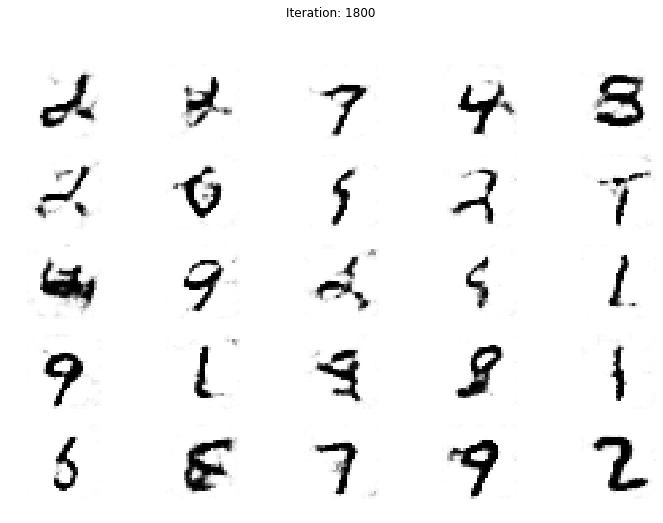

Iteration:  1801 [D loss: 0.72930, acc.:  49.61%] [G loss: 0.84636]
Iteration:  1802 [D loss: 0.67657, acc.:  58.98%] [G loss: 0.84953]
Iteration:  1803 [D loss: 0.73696, acc.:  47.27%] [G loss: 0.86262]
Iteration:  1804 [D loss: 0.68168, acc.:  59.38%] [G loss: 0.90938]
Iteration:  1805 [D loss: 0.70329, acc.:  53.12%] [G loss: 0.87257]
Iteration:  1806 [D loss: 0.73564, acc.:  53.91%] [G loss: 0.90896]
Iteration:  1807 [D loss: 0.69575, acc.:  56.64%] [G loss: 0.88917]
Iteration:  1808 [D loss: 0.72713, acc.:  47.66%] [G loss: 0.86494]
Iteration:  1809 [D loss: 0.70101, acc.:  54.30%] [G loss: 0.87974]
Iteration:  1810 [D loss: 0.71732, acc.:  48.44%] [G loss: 0.82595]
Iteration:  1811 [D loss: 0.70015, acc.:  53.12%] [G loss: 0.85228]
Iteration:  1812 [D loss: 0.71626, acc.:  57.03%] [G loss: 0.84151]
Iteration:  1813 [D loss: 0.71058, acc.:  51.95%] [G loss: 0.89986]
Iteration:  1814 [D loss: 0.68527, acc.:  57.03%] [G loss: 0.87643]
Iteration:  1815 [D loss: 0.73405, acc.:  50.78%

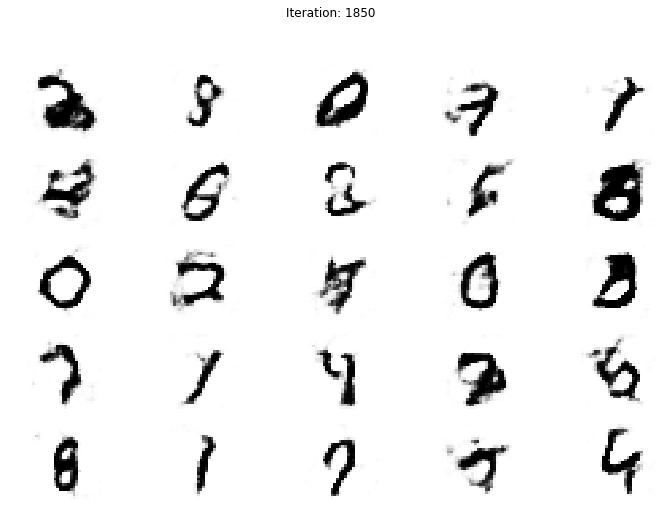

Iteration:  1851 [D loss: 0.74603, acc.:  46.88%] [G loss: 0.92007]
Iteration:  1852 [D loss: 0.69790, acc.:  52.34%] [G loss: 0.91176]
Iteration:  1853 [D loss: 0.74015, acc.:  48.83%] [G loss: 0.85201]
Iteration:  1854 [D loss: 0.72411, acc.:  52.73%] [G loss: 0.94851]
Iteration:  1855 [D loss: 0.69728, acc.:  56.25%] [G loss: 0.87492]
Iteration:  1856 [D loss: 0.69375, acc.:  55.08%] [G loss: 0.84020]
Iteration:  1857 [D loss: 0.67984, acc.:  58.59%] [G loss: 0.87966]
Iteration:  1858 [D loss: 0.75298, acc.:  43.36%] [G loss: 0.81689]
Iteration:  1859 [D loss: 0.71316, acc.:  56.25%] [G loss: 0.78560]
Iteration:  1860 [D loss: 0.70798, acc.:  55.86%] [G loss: 0.83413]
Iteration:  1861 [D loss: 0.66467, acc.:  58.59%] [G loss: 0.87401]
Iteration:  1862 [D loss: 0.70949, acc.:  53.52%] [G loss: 0.82967]
Iteration:  1863 [D loss: 0.70144, acc.:  52.34%] [G loss: 0.85727]
Iteration:  1864 [D loss: 0.69865, acc.:  58.20%] [G loss: 0.87782]
Iteration:  1865 [D loss: 0.68113, acc.:  58.98%

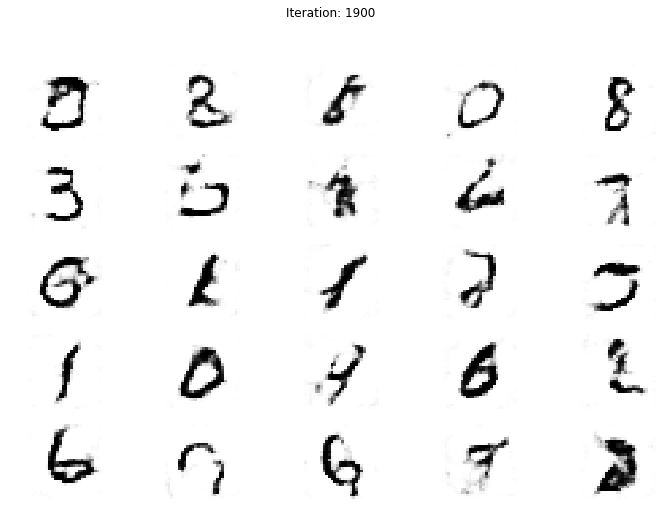

Iteration:  1901 [D loss: 0.71384, acc.:  52.34%] [G loss: 0.81319]
Iteration:  1902 [D loss: 0.68004, acc.:  57.03%] [G loss: 0.88858]
Iteration:  1903 [D loss: 0.71670, acc.:  51.17%] [G loss: 0.81926]
Iteration:  1904 [D loss: 0.73273, acc.:  48.44%] [G loss: 0.84015]
Iteration:  1905 [D loss: 0.70646, acc.:  51.95%] [G loss: 0.81113]
Iteration:  1906 [D loss: 0.73577, acc.:  51.56%] [G loss: 0.79569]
Iteration:  1907 [D loss: 0.67648, acc.:  55.86%] [G loss: 0.86421]
Iteration:  1908 [D loss: 0.70474, acc.:  54.30%] [G loss: 0.86294]
Iteration:  1909 [D loss: 0.71534, acc.:  55.47%] [G loss: 0.87513]
Iteration:  1910 [D loss: 0.66151, acc.:  62.11%] [G loss: 0.89416]
Iteration:  1911 [D loss: 0.66214, acc.:  58.20%] [G loss: 0.87349]
Iteration:  1912 [D loss: 0.72414, acc.:  49.61%] [G loss: 0.83272]
Iteration:  1913 [D loss: 0.68347, acc.:  58.20%] [G loss: 0.92755]
Iteration:  1914 [D loss: 0.74758, acc.:  48.83%] [G loss: 0.88388]
Iteration:  1915 [D loss: 0.71976, acc.:  51.56%

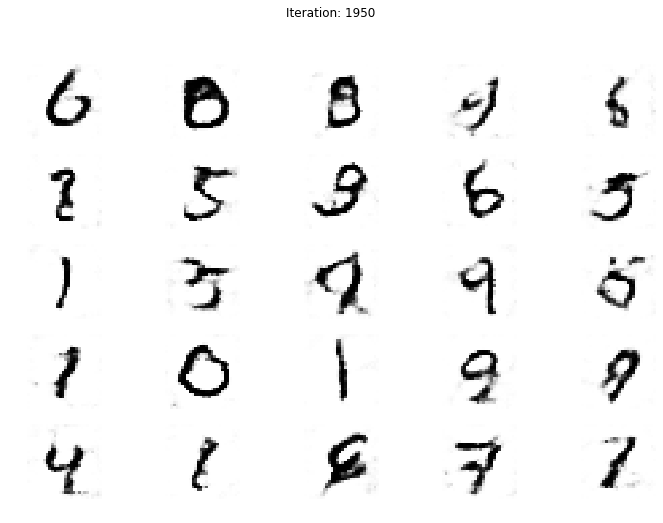

Iteration:  1951 [D loss: 0.74148, acc.:  53.12%] [G loss: 0.85202]
Iteration:  1952 [D loss: 0.71066, acc.:  51.56%] [G loss: 0.87298]
Iteration:  1953 [D loss: 0.68944, acc.:  57.42%] [G loss: 0.86352]
Iteration:  1954 [D loss: 0.69942, acc.:  53.52%] [G loss: 0.91143]
Iteration:  1955 [D loss: 0.74201, acc.:  47.66%] [G loss: 0.82750]
Iteration:  1956 [D loss: 0.69407, acc.:  53.52%] [G loss: 0.88842]
Iteration:  1957 [D loss: 0.74311, acc.:  46.09%] [G loss: 0.84267]
Iteration:  1958 [D loss: 0.69260, acc.:  55.08%] [G loss: 0.88255]
Iteration:  1959 [D loss: 0.69868, acc.:  55.47%] [G loss: 0.85088]
Iteration:  1960 [D loss: 0.71285, acc.:  51.56%] [G loss: 0.88871]
Iteration:  1961 [D loss: 0.69947, acc.:  54.69%] [G loss: 0.86642]
Iteration:  1962 [D loss: 0.69219, acc.:  55.08%] [G loss: 0.95736]
Iteration:  1963 [D loss: 0.72095, acc.:  49.61%] [G loss: 0.88221]
Iteration:  1964 [D loss: 0.67388, acc.:  60.16%] [G loss: 0.89625]
Iteration:  1965 [D loss: 0.69276, acc.:  54.30%

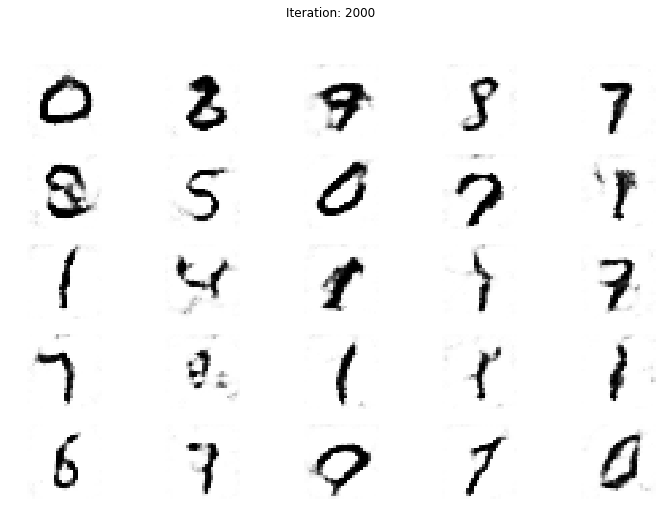

Iteration:  2001 [D loss: 0.70653, acc.:  53.52%] [G loss: 0.90508]
Iteration:  2002 [D loss: 0.70709, acc.:  55.47%] [G loss: 0.83921]
Iteration:  2003 [D loss: 0.70511, acc.:  51.17%] [G loss: 0.85541]
Iteration:  2004 [D loss: 0.71122, acc.:  49.61%] [G loss: 0.83101]
Iteration:  2005 [D loss: 0.69776, acc.:  53.12%] [G loss: 0.79613]
Iteration:  2006 [D loss: 0.66506, acc.:  58.98%] [G loss: 0.76832]
Iteration:  2007 [D loss: 0.70128, acc.:  53.12%] [G loss: 0.84602]
Iteration:  2008 [D loss: 0.69932, acc.:  55.08%] [G loss: 0.87455]
Iteration:  2009 [D loss: 0.69412, acc.:  55.08%] [G loss: 0.82275]
Iteration:  2010 [D loss: 0.72219, acc.:  50.00%] [G loss: 0.82859]
Iteration:  2011 [D loss: 0.71087, acc.:  51.95%] [G loss: 0.87159]
Iteration:  2012 [D loss: 0.70073, acc.:  54.30%] [G loss: 0.90254]
Iteration:  2013 [D loss: 0.68859, acc.:  59.77%] [G loss: 0.84038]
Iteration:  2014 [D loss: 0.68875, acc.:  56.64%] [G loss: 0.84709]
Iteration:  2015 [D loss: 0.73281, acc.:  48.05%

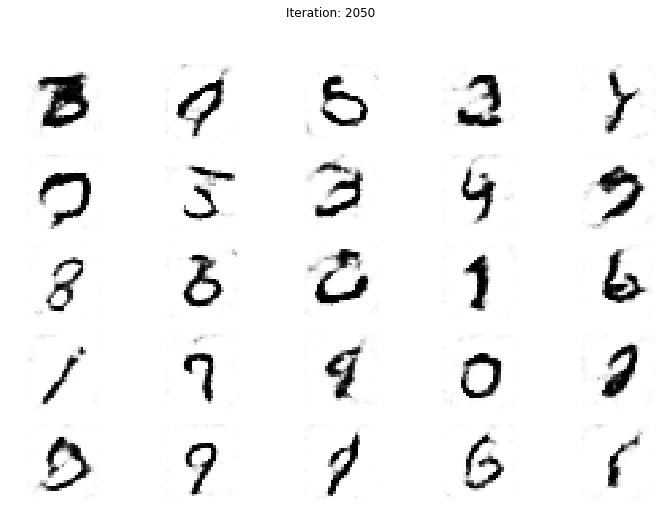

Iteration:  2051 [D loss: 0.68181, acc.:  55.47%] [G loss: 0.84260]
Iteration:  2052 [D loss: 0.69137, acc.:  55.86%] [G loss: 0.83965]
Iteration:  2053 [D loss: 0.69539, acc.:  53.91%] [G loss: 0.93566]
Iteration:  2054 [D loss: 0.67267, acc.:  58.59%] [G loss: 0.84266]
Iteration:  2055 [D loss: 0.68723, acc.:  55.08%] [G loss: 0.88699]
Iteration:  2056 [D loss: 0.69683, acc.:  56.25%] [G loss: 0.90356]
Iteration:  2057 [D loss: 0.69760, acc.:  54.30%] [G loss: 0.89800]
Iteration:  2058 [D loss: 0.72705, acc.:  51.17%] [G loss: 0.83390]
Iteration:  2059 [D loss: 0.74290, acc.:  48.44%] [G loss: 0.88100]
Iteration:  2060 [D loss: 0.68782, acc.:  54.69%] [G loss: 0.83354]
Iteration:  2061 [D loss: 0.68135, acc.:  60.16%] [G loss: 0.90931]
Iteration:  2062 [D loss: 0.69877, acc.:  52.34%] [G loss: 0.86461]
Iteration:  2063 [D loss: 0.70116, acc.:  52.73%] [G loss: 0.87383]
Iteration:  2064 [D loss: 0.70054, acc.:  53.52%] [G loss: 0.83093]
Iteration:  2065 [D loss: 0.70155, acc.:  53.52%

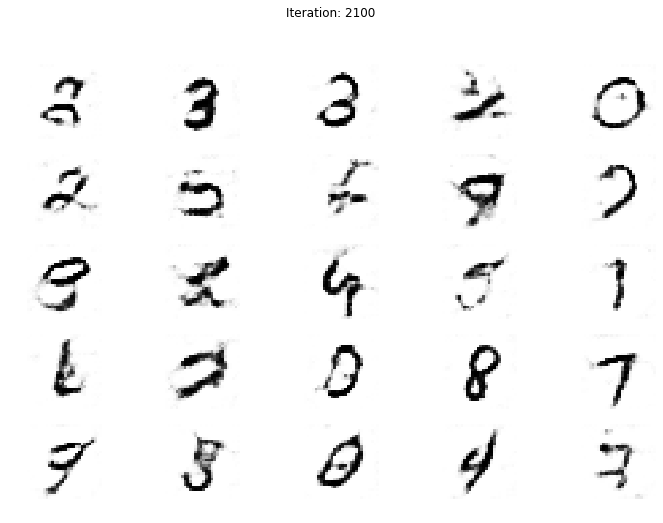

Iteration:  2101 [D loss: 0.71947, acc.:  50.39%] [G loss: 0.88827]
Iteration:  2102 [D loss: 0.73102, acc.:  49.22%] [G loss: 0.82857]
Iteration:  2103 [D loss: 0.72670, acc.:  51.56%] [G loss: 0.84461]
Iteration:  2104 [D loss: 0.70640, acc.:  54.69%] [G loss: 0.84903]
Iteration:  2105 [D loss: 0.70768, acc.:  53.12%] [G loss: 0.81704]
Iteration:  2106 [D loss: 0.73085, acc.:  51.17%] [G loss: 0.81981]
Iteration:  2107 [D loss: 0.75000, acc.:  48.83%] [G loss: 0.84806]
Iteration:  2108 [D loss: 0.74136, acc.:  47.27%] [G loss: 0.83727]
Iteration:  2109 [D loss: 0.70036, acc.:  55.47%] [G loss: 0.85057]
Iteration:  2110 [D loss: 0.70002, acc.:  56.64%] [G loss: 0.83972]
Iteration:  2111 [D loss: 0.69313, acc.:  55.86%] [G loss: 0.82515]
Iteration:  2112 [D loss: 0.71631, acc.:  50.78%] [G loss: 0.80529]
Iteration:  2113 [D loss: 0.71076, acc.:  51.95%] [G loss: 0.82093]
Iteration:  2114 [D loss: 0.70230, acc.:  53.52%] [G loss: 0.83695]
Iteration:  2115 [D loss: 0.70866, acc.:  50.39%

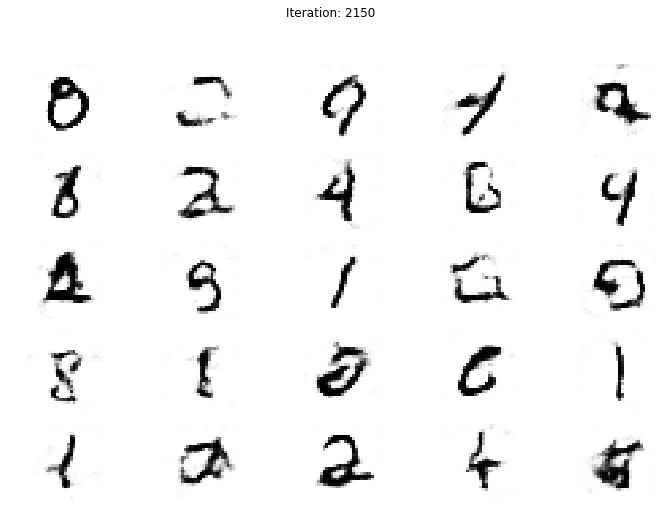

Iteration:  2151 [D loss: 0.72041, acc.:  50.00%] [G loss: 0.83752]
Iteration:  2152 [D loss: 0.72599, acc.:  49.22%] [G loss: 0.81800]
Iteration:  2153 [D loss: 0.70034, acc.:  53.91%] [G loss: 0.84456]
Iteration:  2154 [D loss: 0.70395, acc.:  52.34%] [G loss: 0.84474]
Iteration:  2155 [D loss: 0.70248, acc.:  53.91%] [G loss: 0.88693]
Iteration:  2156 [D loss: 0.72423, acc.:  50.00%] [G loss: 0.79232]
Iteration:  2157 [D loss: 0.70041, acc.:  53.52%] [G loss: 0.81242]
Iteration:  2158 [D loss: 0.67968, acc.:  57.03%] [G loss: 0.81825]
Iteration:  2159 [D loss: 0.69691, acc.:  55.86%] [G loss: 0.83638]
Iteration:  2160 [D loss: 0.67927, acc.:  56.64%] [G loss: 0.83767]
Iteration:  2161 [D loss: 0.68551, acc.:  57.03%] [G loss: 0.79408]
Iteration:  2162 [D loss: 0.66622, acc.:  57.81%] [G loss: 0.87644]
Iteration:  2163 [D loss: 0.69286, acc.:  55.47%] [G loss: 0.94096]
Iteration:  2164 [D loss: 0.71551, acc.:  51.56%] [G loss: 0.81712]
Iteration:  2165 [D loss: 0.72645, acc.:  51.56%

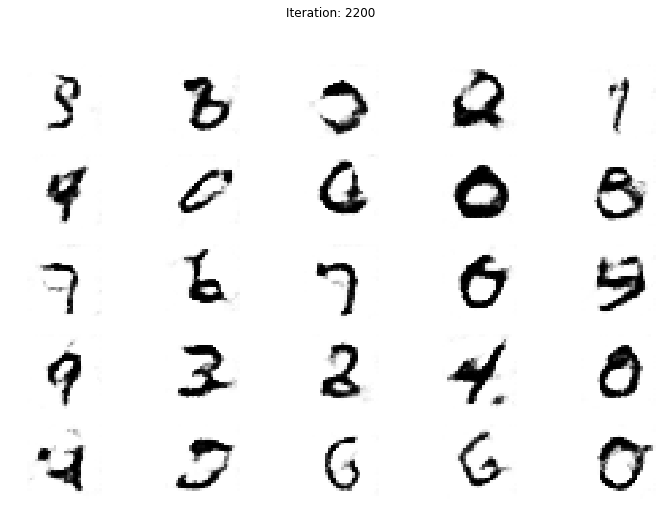

Iteration:  2201 [D loss: 0.69663, acc.:  56.64%] [G loss: 0.80362]
Iteration:  2202 [D loss: 0.68555, acc.:  56.25%] [G loss: 0.86638]
Iteration:  2203 [D loss: 0.72862, acc.:  49.61%] [G loss: 0.85611]
Iteration:  2204 [D loss: 0.71079, acc.:  48.05%] [G loss: 0.84165]
Iteration:  2205 [D loss: 0.70537, acc.:  57.03%] [G loss: 0.93113]
Iteration:  2206 [D loss: 0.69556, acc.:  56.64%] [G loss: 0.81985]
Iteration:  2207 [D loss: 0.70384, acc.:  52.73%] [G loss: 0.84791]
Iteration:  2208 [D loss: 0.70575, acc.:  49.61%] [G loss: 0.89296]
Iteration:  2209 [D loss: 0.68860, acc.:  53.91%] [G loss: 0.84030]
Iteration:  2210 [D loss: 0.70001, acc.:  54.69%] [G loss: 0.82100]
Iteration:  2211 [D loss: 0.70771, acc.:  52.73%] [G loss: 0.88377]
Iteration:  2212 [D loss: 0.73153, acc.:  48.83%] [G loss: 0.83722]
Iteration:  2213 [D loss: 0.72575, acc.:  47.27%] [G loss: 0.89208]
Iteration:  2214 [D loss: 0.72329, acc.:  51.17%] [G loss: 0.81280]
Iteration:  2215 [D loss: 0.70006, acc.:  56.25%

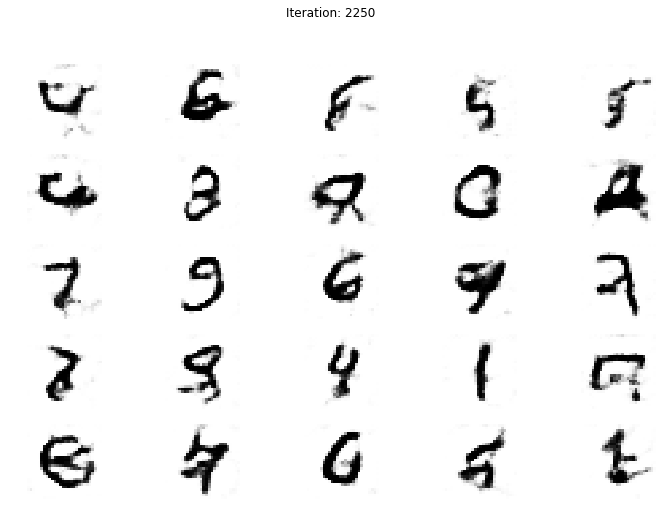

Iteration:  2251 [D loss: 0.71343, acc.:  52.34%] [G loss: 0.81794]
Iteration:  2252 [D loss: 0.71331, acc.:  51.95%] [G loss: 0.83579]
Iteration:  2253 [D loss: 0.71965, acc.:  54.69%] [G loss: 0.85228]
Iteration:  2254 [D loss: 0.69707, acc.:  53.52%] [G loss: 0.80698]
Iteration:  2255 [D loss: 0.68650, acc.:  56.64%] [G loss: 0.86337]
Iteration:  2256 [D loss: 0.76478, acc.:  40.62%] [G loss: 0.85654]
Iteration:  2257 [D loss: 0.72672, acc.:  51.17%] [G loss: 0.92672]
Iteration:  2258 [D loss: 0.74848, acc.:  49.22%] [G loss: 0.86680]
Iteration:  2259 [D loss: 0.71057, acc.:  54.69%] [G loss: 0.82952]
Iteration:  2260 [D loss: 0.70615, acc.:  49.61%] [G loss: 0.81080]
Iteration:  2261 [D loss: 0.71358, acc.:  52.73%] [G loss: 0.90229]
Iteration:  2262 [D loss: 0.71541, acc.:  53.91%] [G loss: 0.83691]
Iteration:  2263 [D loss: 0.71819, acc.:  51.56%] [G loss: 0.80236]
Iteration:  2264 [D loss: 0.74769, acc.:  49.22%] [G loss: 0.84719]
Iteration:  2265 [D loss: 0.69097, acc.:  56.64%

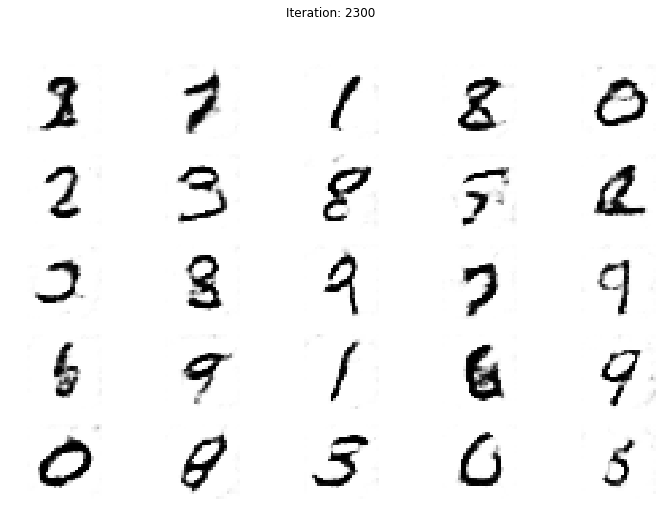

Iteration:  2301 [D loss: 0.72980, acc.:  50.39%] [G loss: 0.87697]
Iteration:  2302 [D loss: 0.69615, acc.:  53.52%] [G loss: 0.90984]
Iteration:  2303 [D loss: 0.67640, acc.:  57.03%] [G loss: 0.87989]
Iteration:  2304 [D loss: 0.71316, acc.:  49.61%] [G loss: 0.83645]
Iteration:  2305 [D loss: 0.70618, acc.:  54.69%] [G loss: 0.83258]
Iteration:  2306 [D loss: 0.68972, acc.:  57.81%] [G loss: 0.84914]
Iteration:  2307 [D loss: 0.69817, acc.:  58.20%] [G loss: 0.89321]
Iteration:  2308 [D loss: 0.71944, acc.:  49.22%] [G loss: 0.87615]
Iteration:  2309 [D loss: 0.68877, acc.:  54.30%] [G loss: 0.82693]
Iteration:  2310 [D loss: 0.71009, acc.:  53.12%] [G loss: 0.84466]
Iteration:  2311 [D loss: 0.69327, acc.:  52.34%] [G loss: 0.83712]
Iteration:  2312 [D loss: 0.71509, acc.:  53.52%] [G loss: 0.80240]
Iteration:  2313 [D loss: 0.71396, acc.:  52.73%] [G loss: 0.78773]
Iteration:  2314 [D loss: 0.69378, acc.:  53.12%] [G loss: 0.86352]
Iteration:  2315 [D loss: 0.70906, acc.:  52.73%

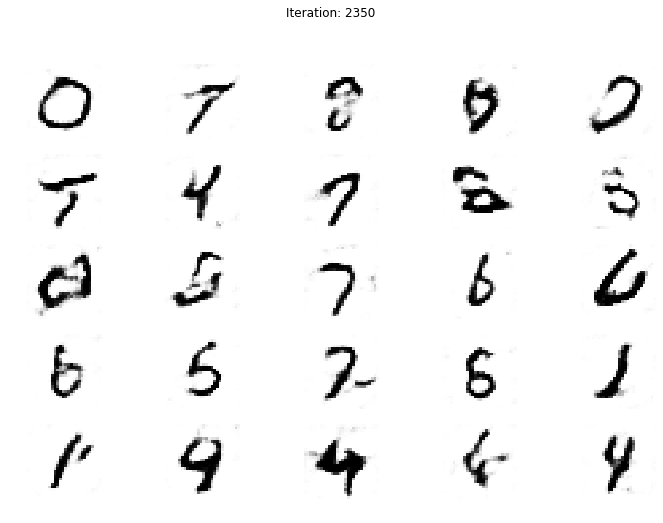

Iteration:  2351 [D loss: 0.70991, acc.:  49.61%] [G loss: 0.88882]
Iteration:  2352 [D loss: 0.69841, acc.:  53.12%] [G loss: 0.94647]
Iteration:  2353 [D loss: 0.69246, acc.:  55.47%] [G loss: 0.87829]
Iteration:  2354 [D loss: 0.68551, acc.:  56.64%] [G loss: 0.86781]
Iteration:  2355 [D loss: 0.70673, acc.:  50.78%] [G loss: 0.82994]
Iteration:  2356 [D loss: 0.69013, acc.:  54.30%] [G loss: 0.86951]
Iteration:  2357 [D loss: 0.72985, acc.:  46.88%] [G loss: 0.77867]
Iteration:  2358 [D loss: 0.66384, acc.:  56.25%] [G loss: 0.81257]
Iteration:  2359 [D loss: 0.70867, acc.:  55.08%] [G loss: 0.82091]
Iteration:  2360 [D loss: 0.67189, acc.:  59.77%] [G loss: 0.82694]
Iteration:  2361 [D loss: 0.69775, acc.:  58.59%] [G loss: 0.87059]
Iteration:  2362 [D loss: 0.70748, acc.:  55.86%] [G loss: 0.81729]
Iteration:  2363 [D loss: 0.73199, acc.:  46.48%] [G loss: 0.85466]
Iteration:  2364 [D loss: 0.70241, acc.:  52.34%] [G loss: 0.82137]
Iteration:  2365 [D loss: 0.70630, acc.:  51.17%

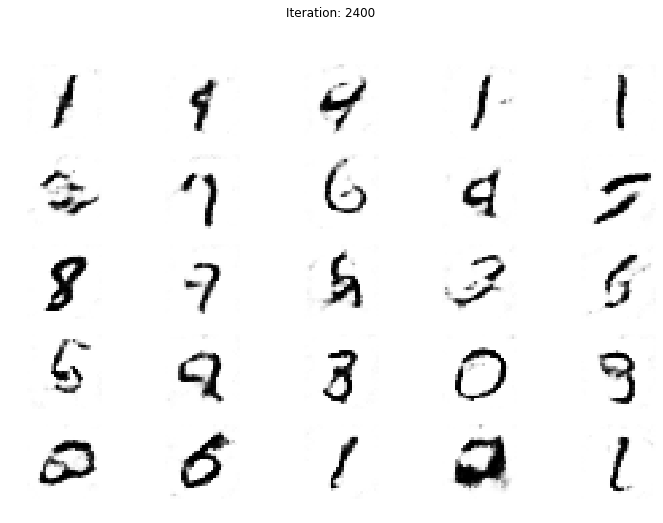

Iteration:  2401 [D loss: 0.71965, acc.:  55.08%] [G loss: 0.84017]
Iteration:  2402 [D loss: 0.68547, acc.:  59.77%] [G loss: 0.83484]
Iteration:  2403 [D loss: 0.71041, acc.:  54.30%] [G loss: 0.82681]
Iteration:  2404 [D loss: 0.71056, acc.:  50.00%] [G loss: 0.83067]
Iteration:  2405 [D loss: 0.70738, acc.:  52.73%] [G loss: 0.91028]
Iteration:  2406 [D loss: 0.69527, acc.:  55.08%] [G loss: 0.79805]
Iteration:  2407 [D loss: 0.68474, acc.:  57.03%] [G loss: 0.86265]
Iteration:  2408 [D loss: 0.71168, acc.:  49.22%] [G loss: 0.90368]
Iteration:  2409 [D loss: 0.69156, acc.:  54.30%] [G loss: 0.88266]
Iteration:  2410 [D loss: 0.70663, acc.:  55.86%] [G loss: 0.81765]
Iteration:  2411 [D loss: 0.71690, acc.:  51.17%] [G loss: 0.80136]
Iteration:  2412 [D loss: 0.69868, acc.:  52.73%] [G loss: 0.89253]
Iteration:  2413 [D loss: 0.66923, acc.:  55.47%] [G loss: 0.83467]
Iteration:  2414 [D loss: 0.70618, acc.:  51.95%] [G loss: 0.82414]
Iteration:  2415 [D loss: 0.70876, acc.:  53.52%

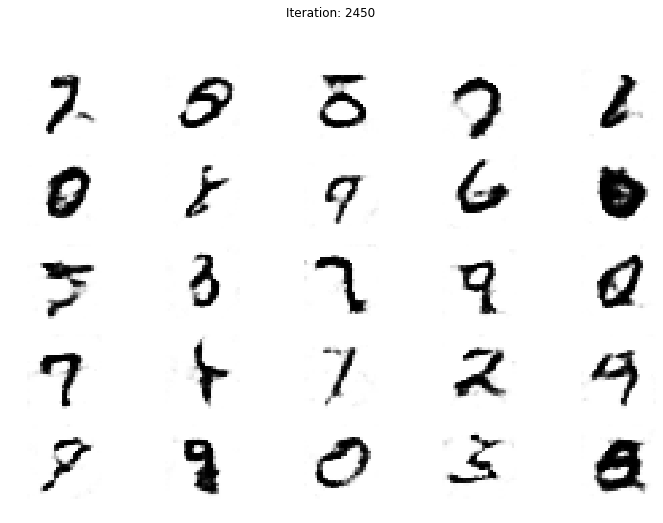

Iteration:  2451 [D loss: 0.71073, acc.:  54.30%] [G loss: 0.81872]
Iteration:  2452 [D loss: 0.72510, acc.:  45.70%] [G loss: 0.82837]
Iteration:  2453 [D loss: 0.69945, acc.:  53.91%] [G loss: 0.84885]
Iteration:  2454 [D loss: 0.69120, acc.:  53.12%] [G loss: 0.90023]
Iteration:  2455 [D loss: 0.70666, acc.:  57.42%] [G loss: 0.85185]
Iteration:  2456 [D loss: 0.72206, acc.:  51.95%] [G loss: 0.86434]
Iteration:  2457 [D loss: 0.72129, acc.:  50.39%] [G loss: 0.83114]
Iteration:  2458 [D loss: 0.72480, acc.:  50.00%] [G loss: 0.85387]
Iteration:  2459 [D loss: 0.70708, acc.:  53.91%] [G loss: 0.89755]
Iteration:  2460 [D loss: 0.72785, acc.:  51.56%] [G loss: 0.86972]
Iteration:  2461 [D loss: 0.70370, acc.:  54.30%] [G loss: 0.91126]
Iteration:  2462 [D loss: 0.71070, acc.:  50.39%] [G loss: 0.82460]
Iteration:  2463 [D loss: 0.68910, acc.:  54.30%] [G loss: 0.88341]
Iteration:  2464 [D loss: 0.72407, acc.:  50.00%] [G loss: 0.88826]
Iteration:  2465 [D loss: 0.69195, acc.:  57.03%

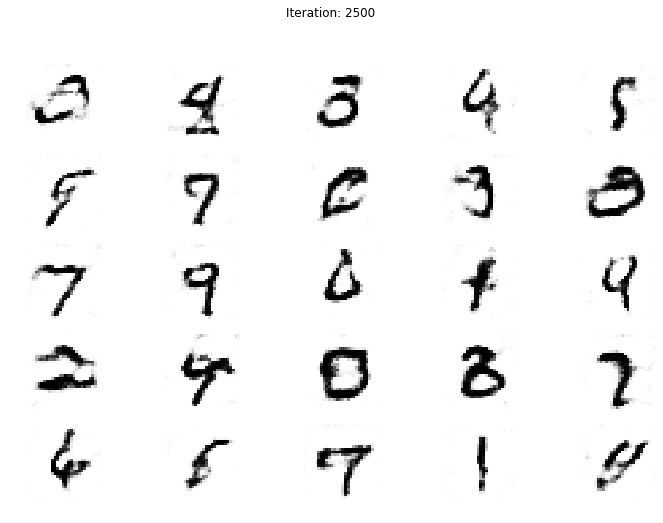

Iteration:  2501 [D loss: 0.70326, acc.:  52.34%] [G loss: 0.81154]
Iteration:  2502 [D loss: 0.71372, acc.:  52.34%] [G loss: 0.78427]
Iteration:  2503 [D loss: 0.71719, acc.:  50.78%] [G loss: 0.79322]
Iteration:  2504 [D loss: 0.68432, acc.:  58.98%] [G loss: 0.83963]
Iteration:  2505 [D loss: 0.72590, acc.:  50.78%] [G loss: 0.82259]
Iteration:  2506 [D loss: 0.72405, acc.:  44.53%] [G loss: 0.82916]
Iteration:  2507 [D loss: 0.70194, acc.:  53.52%] [G loss: 0.78792]
Iteration:  2508 [D loss: 0.73092, acc.:  47.27%] [G loss: 0.85648]
Iteration:  2509 [D loss: 0.68897, acc.:  51.95%] [G loss: 0.87185]
Iteration:  2510 [D loss: 0.70897, acc.:  51.56%] [G loss: 0.86635]
Iteration:  2511 [D loss: 0.71119, acc.:  51.17%] [G loss: 0.80969]
Iteration:  2512 [D loss: 0.68070, acc.:  56.64%] [G loss: 0.82417]
Iteration:  2513 [D loss: 0.71341, acc.:  49.61%] [G loss: 0.83593]
Iteration:  2514 [D loss: 0.72408, acc.:  48.05%] [G loss: 0.90087]
Iteration:  2515 [D loss: 0.73590, acc.:  48.44%

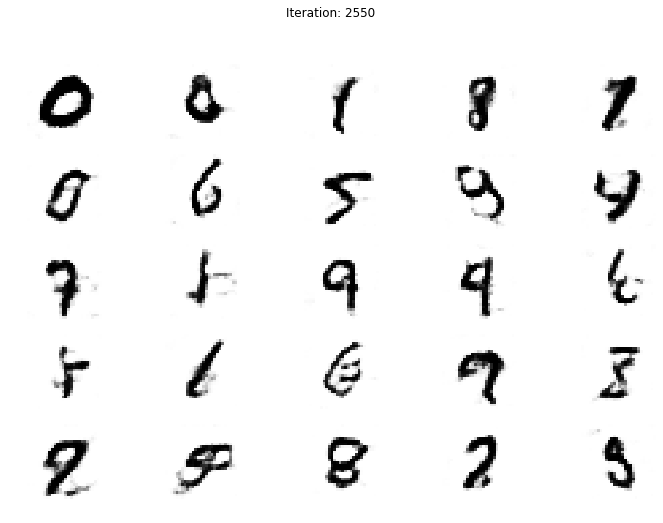

Iteration:  2551 [D loss: 0.67467, acc.:  52.34%] [G loss: 0.87887]
Iteration:  2552 [D loss: 0.73065, acc.:  48.05%] [G loss: 0.84410]
Iteration:  2553 [D loss: 0.69086, acc.:  55.08%] [G loss: 0.83602]
Iteration:  2554 [D loss: 0.67659, acc.:  55.47%] [G loss: 0.81639]
Iteration:  2555 [D loss: 0.69412, acc.:  57.03%] [G loss: 0.79299]
Iteration:  2556 [D loss: 0.70081, acc.:  51.17%] [G loss: 0.83400]
Iteration:  2557 [D loss: 0.65322, acc.:  62.11%] [G loss: 0.82996]
Iteration:  2558 [D loss: 0.70134, acc.:  51.56%] [G loss: 0.90136]
Iteration:  2559 [D loss: 0.71016, acc.:  50.00%] [G loss: 0.87479]
Iteration:  2560 [D loss: 0.69870, acc.:  52.73%] [G loss: 0.89433]
Iteration:  2561 [D loss: 0.71965, acc.:  51.95%] [G loss: 0.85084]
Iteration:  2562 [D loss: 0.70455, acc.:  53.12%] [G loss: 0.80508]
Iteration:  2563 [D loss: 0.72187, acc.:  48.83%] [G loss: 0.85872]
Iteration:  2564 [D loss: 0.69552, acc.:  56.25%] [G loss: 0.85648]
Iteration:  2565 [D loss: 0.71155, acc.:  50.00%

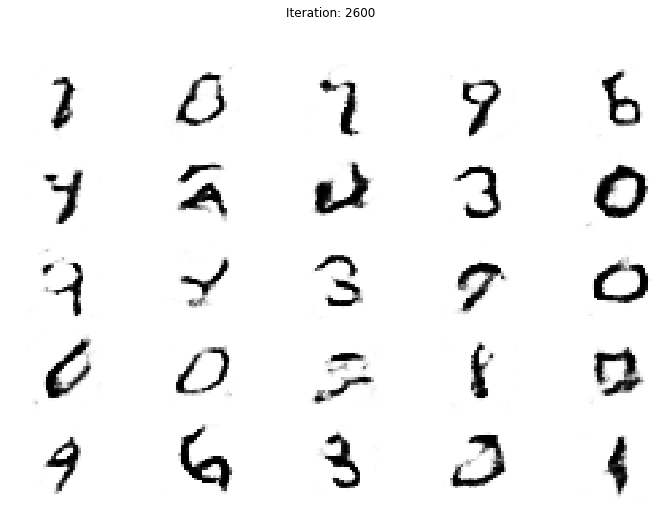

Iteration:  2601 [D loss: 0.68020, acc.:  55.08%] [G loss: 0.85043]
Iteration:  2602 [D loss: 0.73446, acc.:  48.83%] [G loss: 0.87973]
Iteration:  2603 [D loss: 0.71155, acc.:  50.00%] [G loss: 0.79465]
Iteration:  2604 [D loss: 0.72386, acc.:  55.47%] [G loss: 0.81311]
Iteration:  2605 [D loss: 0.66269, acc.:  60.16%] [G loss: 0.81323]
Iteration:  2606 [D loss: 0.69195, acc.:  51.56%] [G loss: 0.86570]
Iteration:  2607 [D loss: 0.70736, acc.:  51.56%] [G loss: 0.80171]
Iteration:  2608 [D loss: 0.71807, acc.:  51.95%] [G loss: 0.79795]
Iteration:  2609 [D loss: 0.69278, acc.:  52.34%] [G loss: 0.87251]
Iteration:  2610 [D loss: 0.68475, acc.:  57.42%] [G loss: 0.79478]
Iteration:  2611 [D loss: 0.69748, acc.:  58.20%] [G loss: 0.81348]
Iteration:  2612 [D loss: 0.71595, acc.:  52.73%] [G loss: 0.84361]
Iteration:  2613 [D loss: 0.71436, acc.:  52.34%] [G loss: 0.88372]
Iteration:  2614 [D loss: 0.66900, acc.:  57.42%] [G loss: 0.80668]
Iteration:  2615 [D loss: 0.67913, acc.:  57.81%

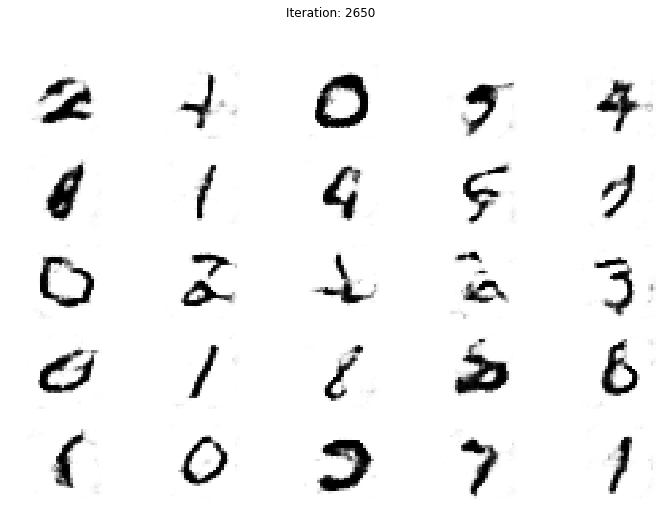

Iteration:  2651 [D loss: 0.68530, acc.:  55.86%] [G loss: 0.86031]
Iteration:  2652 [D loss: 0.69915, acc.:  53.91%] [G loss: 0.84963]
Iteration:  2653 [D loss: 0.68760, acc.:  53.52%] [G loss: 0.86555]
Iteration:  2654 [D loss: 0.71729, acc.:  48.05%] [G loss: 0.89834]
Iteration:  2655 [D loss: 0.70802, acc.:  53.91%] [G loss: 0.91257]
Iteration:  2656 [D loss: 0.71246, acc.:  52.73%] [G loss: 0.85463]
Iteration:  2657 [D loss: 0.71771, acc.:  51.17%] [G loss: 0.85528]
Iteration:  2658 [D loss: 0.71795, acc.:  51.17%] [G loss: 0.82245]
Iteration:  2659 [D loss: 0.72772, acc.:  49.22%] [G loss: 0.83556]
Iteration:  2660 [D loss: 0.67367, acc.:  58.59%] [G loss: 0.81793]
Iteration:  2661 [D loss: 0.69709, acc.:  55.86%] [G loss: 0.87844]
Iteration:  2662 [D loss: 0.72461, acc.:  46.09%] [G loss: 0.86755]
Iteration:  2663 [D loss: 0.69758, acc.:  55.47%] [G loss: 0.81076]
Iteration:  2664 [D loss: 0.72068, acc.:  45.70%] [G loss: 0.89458]
Iteration:  2665 [D loss: 0.73974, acc.:  50.00%

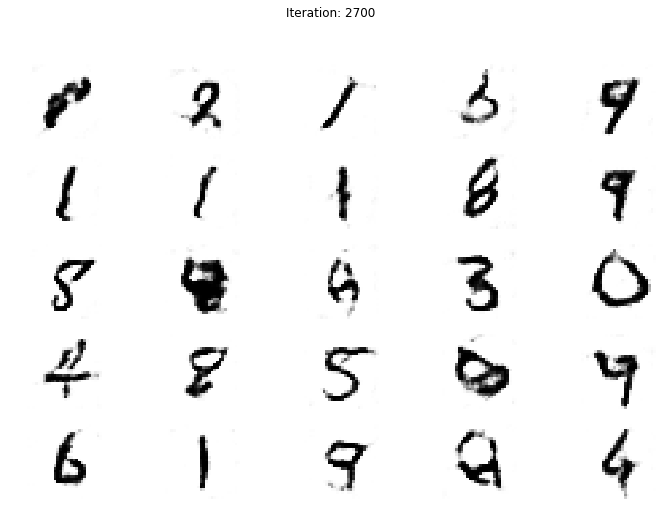

Iteration:  2701 [D loss: 0.71264, acc.:  50.39%] [G loss: 0.85457]
Iteration:  2702 [D loss: 0.73901, acc.:  49.61%] [G loss: 0.80626]
Iteration:  2703 [D loss: 0.69861, acc.:  52.73%] [G loss: 0.88287]
Iteration:  2704 [D loss: 0.68103, acc.:  57.81%] [G loss: 0.88292]
Iteration:  2705 [D loss: 0.68206, acc.:  58.20%] [G loss: 0.83245]
Iteration:  2706 [D loss: 0.69589, acc.:  54.30%] [G loss: 0.83734]
Iteration:  2707 [D loss: 0.73437, acc.:  51.56%] [G loss: 0.83874]
Iteration:  2708 [D loss: 0.70593, acc.:  54.30%] [G loss: 0.84387]
Iteration:  2709 [D loss: 0.70800, acc.:  54.30%] [G loss: 0.84048]
Iteration:  2710 [D loss: 0.68692, acc.:  56.25%] [G loss: 0.79711]
Iteration:  2711 [D loss: 0.68814, acc.:  53.52%] [G loss: 0.83141]
Iteration:  2712 [D loss: 0.72235, acc.:  48.83%] [G loss: 0.81335]
Iteration:  2713 [D loss: 0.69249, acc.:  57.03%] [G loss: 0.84236]
Iteration:  2714 [D loss: 0.70012, acc.:  51.17%] [G loss: 0.79652]
Iteration:  2715 [D loss: 0.72102, acc.:  49.22%

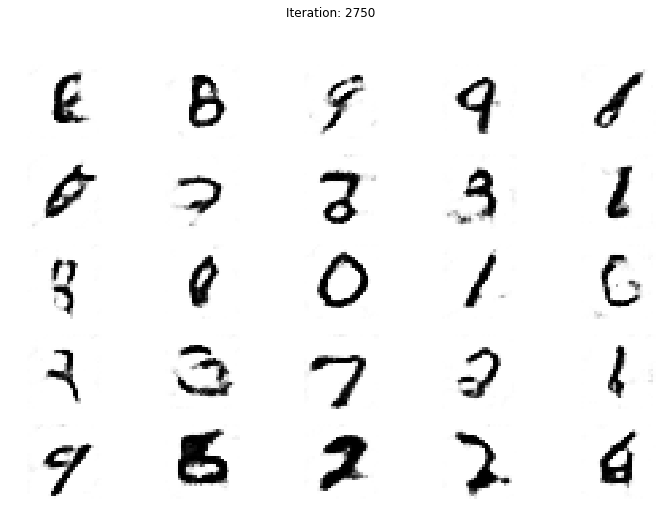

Iteration:  2751 [D loss: 0.73237, acc.:  48.44%] [G loss: 0.77785]
Iteration:  2752 [D loss: 0.69267, acc.:  52.73%] [G loss: 0.74468]
Iteration:  2753 [D loss: 0.72950, acc.:  51.95%] [G loss: 0.78568]
Iteration:  2754 [D loss: 0.67604, acc.:  60.55%] [G loss: 0.82078]
Iteration:  2755 [D loss: 0.71944, acc.:  52.34%] [G loss: 0.82703]
Iteration:  2756 [D loss: 0.69357, acc.:  54.69%] [G loss: 0.84093]
Iteration:  2757 [D loss: 0.72179, acc.:  52.34%] [G loss: 0.84191]
Iteration:  2758 [D loss: 0.70125, acc.:  53.91%] [G loss: 0.78217]
Iteration:  2759 [D loss: 0.69222, acc.:  52.34%] [G loss: 0.78136]
Iteration:  2760 [D loss: 0.71125, acc.:  53.12%] [G loss: 0.80090]
Iteration:  2761 [D loss: 0.72984, acc.:  46.88%] [G loss: 0.83267]
Iteration:  2762 [D loss: 0.70921, acc.:  50.78%] [G loss: 0.82438]
Iteration:  2763 [D loss: 0.69598, acc.:  53.91%] [G loss: 0.80358]
Iteration:  2764 [D loss: 0.69703, acc.:  51.95%] [G loss: 0.84289]
Iteration:  2765 [D loss: 0.69800, acc.:  52.73%

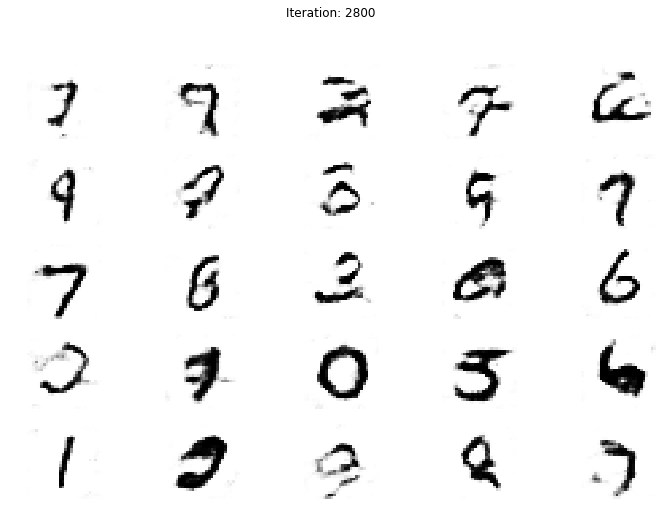

Iteration:  2801 [D loss: 0.69509, acc.:  56.25%] [G loss: 0.80588]
Iteration:  2802 [D loss: 0.70179, acc.:  54.30%] [G loss: 0.79507]
Iteration:  2803 [D loss: 0.72159, acc.:  50.00%] [G loss: 0.82350]
Iteration:  2804 [D loss: 0.71982, acc.:  51.56%] [G loss: 0.82131]
Iteration:  2805 [D loss: 0.69495, acc.:  57.42%] [G loss: 0.85718]
Iteration:  2806 [D loss: 0.70917, acc.:  49.22%] [G loss: 0.79693]
Iteration:  2807 [D loss: 0.74683, acc.:  46.88%] [G loss: 0.79869]
Iteration:  2808 [D loss: 0.72804, acc.:  51.95%] [G loss: 0.86512]
Iteration:  2809 [D loss: 0.72921, acc.:  46.88%] [G loss: 0.84839]
Iteration:  2810 [D loss: 0.71078, acc.:  52.34%] [G loss: 0.82211]
Iteration:  2811 [D loss: 0.69807, acc.:  53.91%] [G loss: 0.84576]
Iteration:  2812 [D loss: 0.70562, acc.:  53.12%] [G loss: 0.86601]
Iteration:  2813 [D loss: 0.72551, acc.:  49.22%] [G loss: 0.79469]
Iteration:  2814 [D loss: 0.74256, acc.:  45.31%] [G loss: 0.81967]
Iteration:  2815 [D loss: 0.71369, acc.:  51.17%

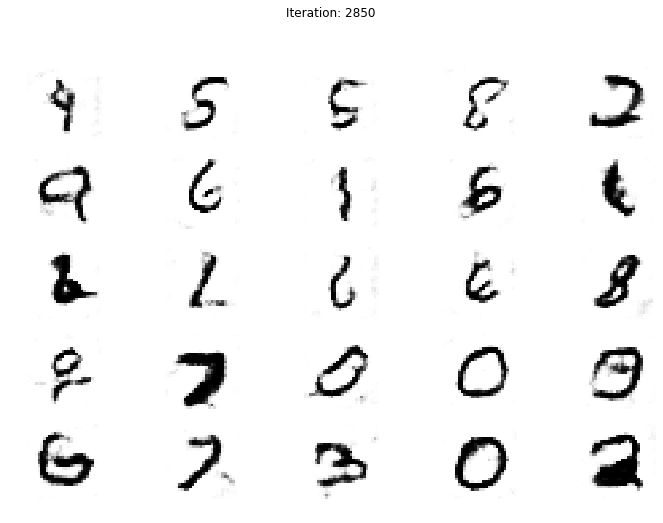

Iteration:  2851 [D loss: 0.69262, acc.:  57.03%] [G loss: 0.85252]
Iteration:  2852 [D loss: 0.67456, acc.:  55.86%] [G loss: 0.78081]
Iteration:  2853 [D loss: 0.70620, acc.:  54.30%] [G loss: 0.82735]
Iteration:  2854 [D loss: 0.70600, acc.:  55.86%] [G loss: 0.81774]
Iteration:  2855 [D loss: 0.70642, acc.:  51.95%] [G loss: 0.83276]
Iteration:  2856 [D loss: 0.68414, acc.:  57.81%] [G loss: 0.82336]
Iteration:  2857 [D loss: 0.67676, acc.:  55.47%] [G loss: 0.84040]
Iteration:  2858 [D loss: 0.69809, acc.:  55.86%] [G loss: 0.84719]
Iteration:  2859 [D loss: 0.69649, acc.:  50.78%] [G loss: 0.82547]
Iteration:  2860 [D loss: 0.72081, acc.:  50.78%] [G loss: 0.79244]
Iteration:  2861 [D loss: 0.69282, acc.:  52.34%] [G loss: 0.88253]
Iteration:  2862 [D loss: 0.71164, acc.:  50.39%] [G loss: 0.82205]
Iteration:  2863 [D loss: 0.71434, acc.:  52.73%] [G loss: 0.81149]
Iteration:  2864 [D loss: 0.74439, acc.:  46.48%] [G loss: 0.83665]
Iteration:  2865 [D loss: 0.68473, acc.:  58.98%

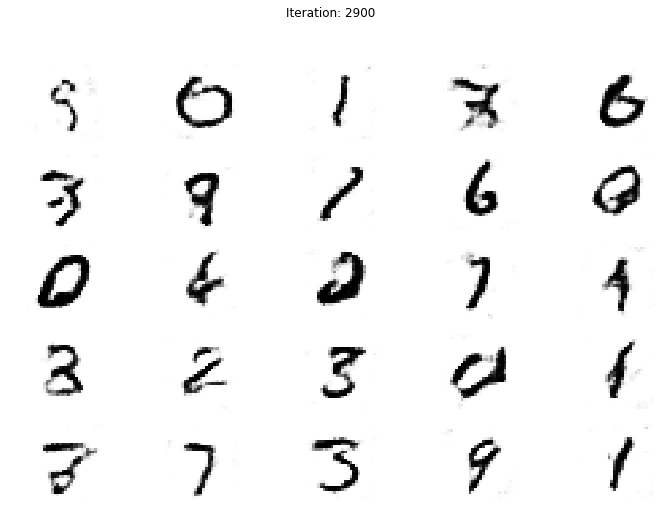

Iteration:  2901 [D loss: 0.65407, acc.:  60.16%] [G loss: 0.82079]
Iteration:  2902 [D loss: 0.71866, acc.:  48.05%] [G loss: 0.85206]
Iteration:  2903 [D loss: 0.72259, acc.:  50.00%] [G loss: 0.79978]
Iteration:  2904 [D loss: 0.70308, acc.:  53.12%] [G loss: 0.82363]
Iteration:  2905 [D loss: 0.71312, acc.:  52.73%] [G loss: 0.89858]
Iteration:  2906 [D loss: 0.72196, acc.:  48.83%] [G loss: 0.86446]
Iteration:  2907 [D loss: 0.67706, acc.:  58.20%] [G loss: 0.82989]
Iteration:  2908 [D loss: 0.70279, acc.:  52.34%] [G loss: 0.82555]
Iteration:  2909 [D loss: 0.71290, acc.:  48.83%] [G loss: 0.84956]
Iteration:  2910 [D loss: 0.70133, acc.:  48.83%] [G loss: 0.81965]
Iteration:  2911 [D loss: 0.71660, acc.:  51.95%] [G loss: 0.81985]
Iteration:  2912 [D loss: 0.69424, acc.:  53.52%] [G loss: 0.82994]
Iteration:  2913 [D loss: 0.72449, acc.:  53.12%] [G loss: 0.85128]
Iteration:  2914 [D loss: 0.70866, acc.:  51.95%] [G loss: 0.83658]
Iteration:  2915 [D loss: 0.70704, acc.:  53.91%

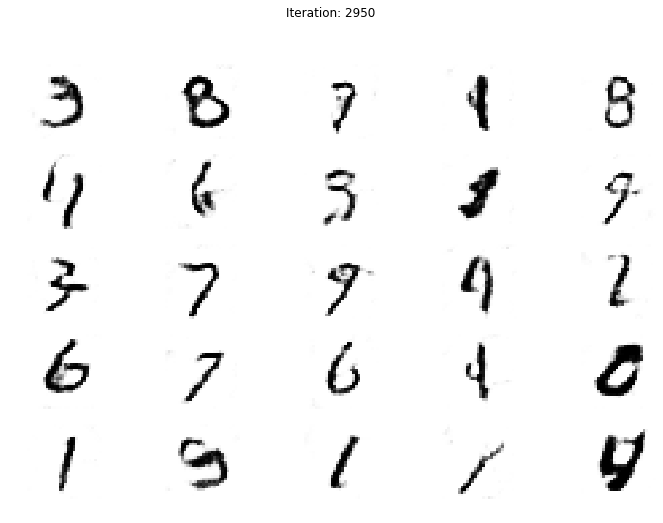

Iteration:  2951 [D loss: 0.73760, acc.:  44.92%] [G loss: 0.79628]
Iteration:  2952 [D loss: 0.69361, acc.:  53.91%] [G loss: 0.86915]
Iteration:  2953 [D loss: 0.71653, acc.:  53.12%] [G loss: 0.89796]
Iteration:  2954 [D loss: 0.68586, acc.:  54.69%] [G loss: 0.83578]
Iteration:  2955 [D loss: 0.69293, acc.:  58.20%] [G loss: 0.87769]
Iteration:  2956 [D loss: 0.72917, acc.:  47.27%] [G loss: 0.82853]
Iteration:  2957 [D loss: 0.70067, acc.:  56.25%] [G loss: 0.87162]
Iteration:  2958 [D loss: 0.70835, acc.:  49.61%] [G loss: 0.83542]
Iteration:  2959 [D loss: 0.69849, acc.:  51.56%] [G loss: 0.83243]
Iteration:  2960 [D loss: 0.71834, acc.:  52.34%] [G loss: 0.83058]
Iteration:  2961 [D loss: 0.71550, acc.:  50.78%] [G loss: 0.82857]
Iteration:  2962 [D loss: 0.71942, acc.:  50.00%] [G loss: 0.78478]
Iteration:  2963 [D loss: 0.70308, acc.:  57.42%] [G loss: 0.79514]
Iteration:  2964 [D loss: 0.70431, acc.:  53.91%] [G loss: 0.76979]
Iteration:  2965 [D loss: 0.69828, acc.:  51.95%

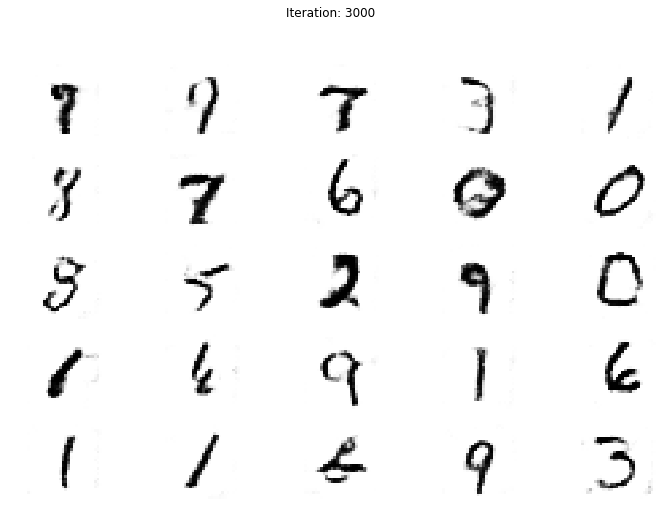

Iteration:  3001 [D loss: 0.69875, acc.:  53.12%] [G loss: 0.79419]
Iteration:  3002 [D loss: 0.70921, acc.:  50.78%] [G loss: 0.77305]
Iteration:  3003 [D loss: 0.69383, acc.:  51.56%] [G loss: 0.80195]
Iteration:  3004 [D loss: 0.71249, acc.:  50.78%] [G loss: 0.80548]
Iteration:  3005 [D loss: 0.73793, acc.:  47.27%] [G loss: 0.81819]
Iteration:  3006 [D loss: 0.71293, acc.:  51.17%] [G loss: 0.79823]
Iteration:  3007 [D loss: 0.70788, acc.:  49.61%] [G loss: 0.80056]
Iteration:  3008 [D loss: 0.68371, acc.:  57.42%] [G loss: 0.84255]
Iteration:  3009 [D loss: 0.69589, acc.:  56.25%] [G loss: 0.87598]
Iteration:  3010 [D loss: 0.73885, acc.:  48.83%] [G loss: 0.80393]
Iteration:  3011 [D loss: 0.71134, acc.:  53.12%] [G loss: 0.77429]
Iteration:  3012 [D loss: 0.72675, acc.:  47.27%] [G loss: 0.84274]
Iteration:  3013 [D loss: 0.68542, acc.:  54.30%] [G loss: 0.84086]
Iteration:  3014 [D loss: 0.71122, acc.:  50.39%] [G loss: 0.83650]
Iteration:  3015 [D loss: 0.74952, acc.:  42.97%

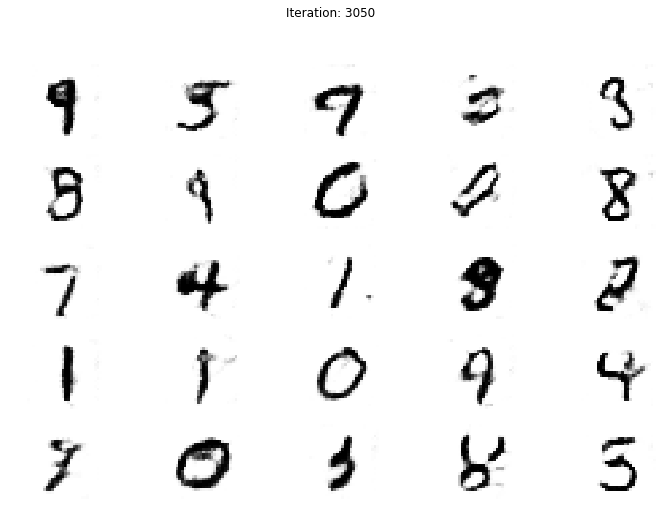

Iteration:  3051 [D loss: 0.69611, acc.:  53.52%] [G loss: 0.86566]
Iteration:  3052 [D loss: 0.72286, acc.:  49.61%] [G loss: 0.84229]
Iteration:  3053 [D loss: 0.71274, acc.:  52.34%] [G loss: 0.89578]
Iteration:  3054 [D loss: 0.72969, acc.:  49.22%] [G loss: 0.86250]
Iteration:  3055 [D loss: 0.73681, acc.:  50.39%] [G loss: 0.82563]
Iteration:  3056 [D loss: 0.73196, acc.:  46.48%] [G loss: 0.83402]
Iteration:  3057 [D loss: 0.71440, acc.:  49.61%] [G loss: 0.75340]
Iteration:  3058 [D loss: 0.72969, acc.:  48.05%] [G loss: 0.80771]
Iteration:  3059 [D loss: 0.72591, acc.:  49.22%] [G loss: 0.81382]
Iteration:  3060 [D loss: 0.71473, acc.:  50.78%] [G loss: 0.77849]
Iteration:  3061 [D loss: 0.72405, acc.:  45.31%] [G loss: 0.82939]
Iteration:  3062 [D loss: 0.70813, acc.:  48.44%] [G loss: 0.81539]
Iteration:  3063 [D loss: 0.75483, acc.:  47.66%] [G loss: 0.83189]
Iteration:  3064 [D loss: 0.71030, acc.:  51.56%] [G loss: 0.84500]
Iteration:  3065 [D loss: 0.69706, acc.:  53.12%

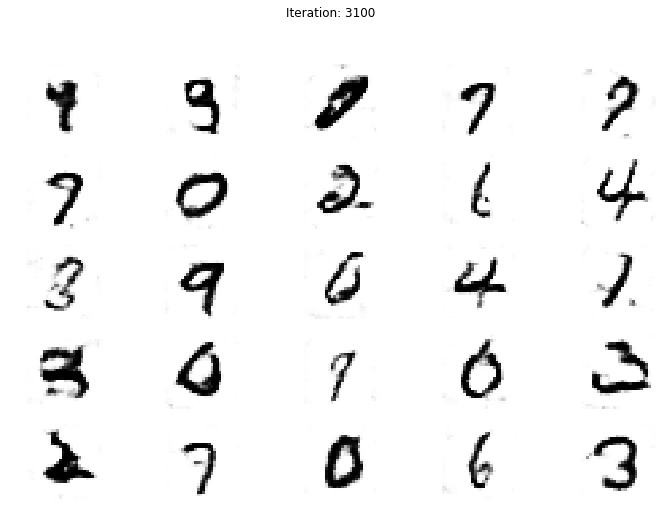

Iteration:  3101 [D loss: 0.71693, acc.:  52.34%] [G loss: 0.81882]
Iteration:  3102 [D loss: 0.70768, acc.:  51.17%] [G loss: 0.80264]
Iteration:  3103 [D loss: 0.71585, acc.:  53.12%] [G loss: 0.84407]
Iteration:  3104 [D loss: 0.71894, acc.:  52.34%] [G loss: 0.86146]
Iteration:  3105 [D loss: 0.73020, acc.:  48.05%] [G loss: 0.82649]
Iteration:  3106 [D loss: 0.68050, acc.:  57.03%] [G loss: 0.86188]
Iteration:  3107 [D loss: 0.68301, acc.:  57.81%] [G loss: 0.84974]
Iteration:  3108 [D loss: 0.71443, acc.:  51.17%] [G loss: 0.80698]
Iteration:  3109 [D loss: 0.70059, acc.:  49.61%] [G loss: 0.75467]
Iteration:  3110 [D loss: 0.70098, acc.:  55.86%] [G loss: 0.79332]
Iteration:  3111 [D loss: 0.71275, acc.:  51.17%] [G loss: 0.83931]
Iteration:  3112 [D loss: 0.70552, acc.:  51.95%] [G loss: 0.83730]
Iteration:  3113 [D loss: 0.72397, acc.:  52.34%] [G loss: 0.85501]
Iteration:  3114 [D loss: 0.72397, acc.:  50.39%] [G loss: 0.79997]
Iteration:  3115 [D loss: 0.71042, acc.:  52.34%

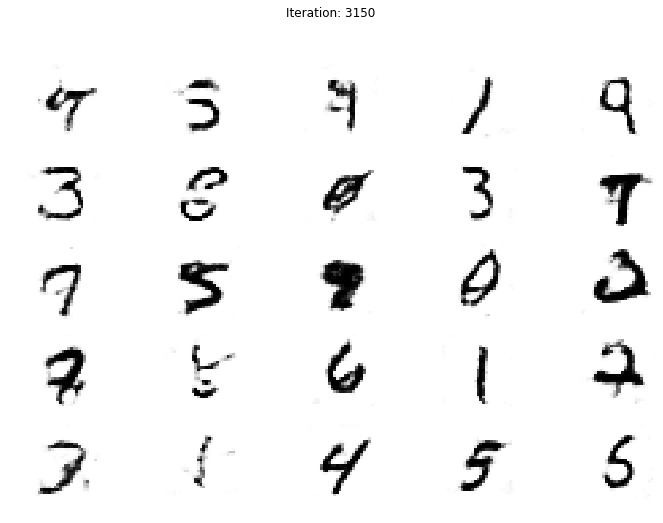

Iteration:  3151 [D loss: 0.70568, acc.:  52.34%] [G loss: 0.83000]
Iteration:  3152 [D loss: 0.68803, acc.:  55.08%] [G loss: 0.86901]
Iteration:  3153 [D loss: 0.71262, acc.:  50.00%] [G loss: 0.86179]
Iteration:  3154 [D loss: 0.72309, acc.:  48.05%] [G loss: 0.84452]
Iteration:  3155 [D loss: 0.71134, acc.:  53.91%] [G loss: 0.78810]
Iteration:  3156 [D loss: 0.71942, acc.:  51.95%] [G loss: 0.80344]
Iteration:  3157 [D loss: 0.69040, acc.:  56.25%] [G loss: 0.81480]
Iteration:  3158 [D loss: 0.71154, acc.:  52.34%] [G loss: 0.82553]
Iteration:  3159 [D loss: 0.70663, acc.:  54.30%] [G loss: 0.77542]
Iteration:  3160 [D loss: 0.69070, acc.:  54.30%] [G loss: 0.81084]
Iteration:  3161 [D loss: 0.71475, acc.:  52.73%] [G loss: 0.80474]
Iteration:  3162 [D loss: 0.68806, acc.:  55.86%] [G loss: 0.80894]
Iteration:  3163 [D loss: 0.70084, acc.:  58.20%] [G loss: 0.79247]
Iteration:  3164 [D loss: 0.70767, acc.:  54.30%] [G loss: 0.81433]
Iteration:  3165 [D loss: 0.70189, acc.:  51.95%

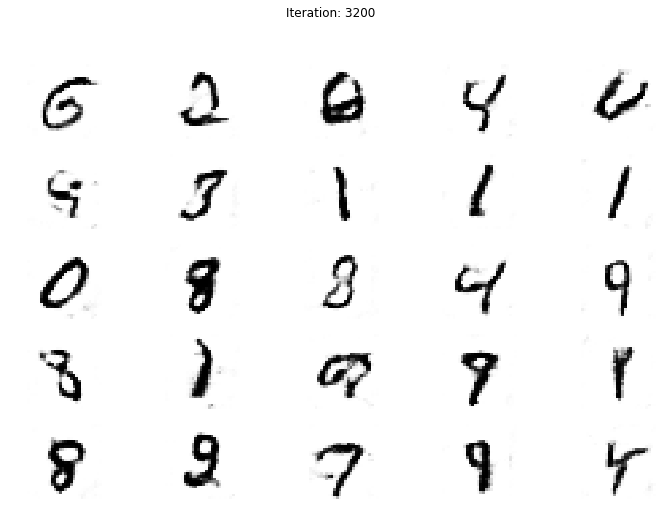

Iteration:  3201 [D loss: 0.66109, acc.:  57.42%] [G loss: 0.79458]
Iteration:  3202 [D loss: 0.68619, acc.:  53.91%] [G loss: 0.78038]
Iteration:  3203 [D loss: 0.72362, acc.:  49.22%] [G loss: 0.85329]
Iteration:  3204 [D loss: 0.72078, acc.:  48.05%] [G loss: 0.80394]
Iteration:  3205 [D loss: 0.70534, acc.:  54.30%] [G loss: 0.81516]
Iteration:  3206 [D loss: 0.71059, acc.:  54.30%] [G loss: 0.79092]
Iteration:  3207 [D loss: 0.70414, acc.:  51.56%] [G loss: 0.83192]
Iteration:  3208 [D loss: 0.72838, acc.:  42.58%] [G loss: 0.82497]
Iteration:  3209 [D loss: 0.69240, acc.:  59.38%] [G loss: 0.84328]
Iteration:  3210 [D loss: 0.71162, acc.:  53.91%] [G loss: 0.79566]
Iteration:  3211 [D loss: 0.69761, acc.:  54.69%] [G loss: 0.79028]
Iteration:  3212 [D loss: 0.70894, acc.:  51.17%] [G loss: 0.82718]
Iteration:  3213 [D loss: 0.70097, acc.:  52.34%] [G loss: 0.83720]
Iteration:  3214 [D loss: 0.70851, acc.:  55.86%] [G loss: 0.76382]
Iteration:  3215 [D loss: 0.69125, acc.:  55.47%

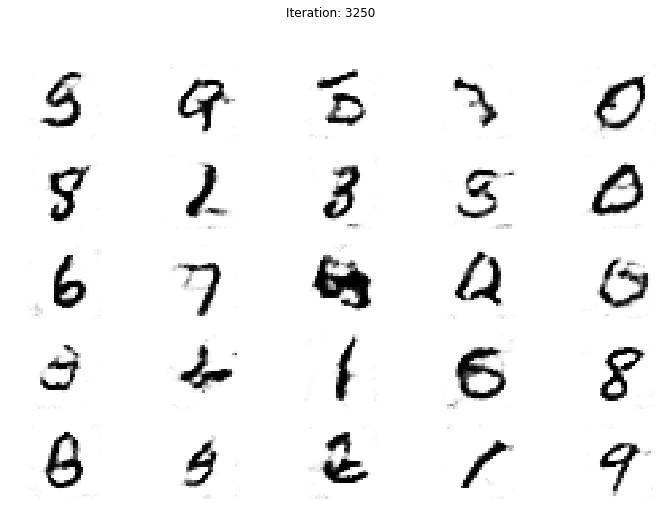

Iteration:  3251 [D loss: 0.70705, acc.:  51.56%] [G loss: 0.90453]
Iteration:  3252 [D loss: 0.73303, acc.:  48.05%] [G loss: 0.81345]
Iteration:  3253 [D loss: 0.69952, acc.:  46.48%] [G loss: 0.87830]
Iteration:  3254 [D loss: 0.69391, acc.:  56.64%] [G loss: 0.84671]
Iteration:  3255 [D loss: 0.75054, acc.:  42.97%] [G loss: 0.79878]
Iteration:  3256 [D loss: 0.68403, acc.:  55.86%] [G loss: 0.77060]
Iteration:  3257 [D loss: 0.73237, acc.:  47.27%] [G loss: 0.83167]
Iteration:  3258 [D loss: 0.71663, acc.:  50.00%] [G loss: 0.83117]
Iteration:  3259 [D loss: 0.68586, acc.:  57.42%] [G loss: 0.80502]
Iteration:  3260 [D loss: 0.71752, acc.:  49.61%] [G loss: 0.78098]
Iteration:  3261 [D loss: 0.73134, acc.:  48.05%] [G loss: 0.80651]
Iteration:  3262 [D loss: 0.71862, acc.:  51.95%] [G loss: 0.79541]
Iteration:  3263 [D loss: 0.69610, acc.:  54.69%] [G loss: 0.84025]
Iteration:  3264 [D loss: 0.70658, acc.:  51.17%] [G loss: 0.83540]
Iteration:  3265 [D loss: 0.70222, acc.:  52.73%

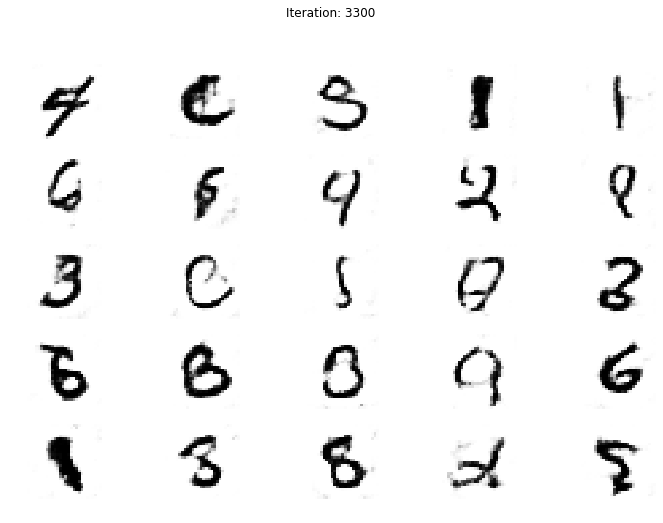

Iteration:  3301 [D loss: 0.70593, acc.:  53.12%] [G loss: 0.83503]
Iteration:  3302 [D loss: 0.70942, acc.:  53.12%] [G loss: 0.78508]
Iteration:  3303 [D loss: 0.71269, acc.:  51.56%] [G loss: 0.81873]
Iteration:  3304 [D loss: 0.71625, acc.:  53.12%] [G loss: 0.81217]
Iteration:  3305 [D loss: 0.72899, acc.:  47.66%] [G loss: 0.86223]
Iteration:  3306 [D loss: 0.71632, acc.:  52.73%] [G loss: 0.81931]
Iteration:  3307 [D loss: 0.70821, acc.:  51.56%] [G loss: 0.82771]
Iteration:  3308 [D loss: 0.69611, acc.:  54.30%] [G loss: 0.81488]
Iteration:  3309 [D loss: 0.71488, acc.:  51.56%] [G loss: 0.81559]
Iteration:  3310 [D loss: 0.69957, acc.:  54.69%] [G loss: 0.88879]
Iteration:  3311 [D loss: 0.70445, acc.:  53.12%] [G loss: 0.80924]
Iteration:  3312 [D loss: 0.68494, acc.:  58.98%] [G loss: 0.85819]
Iteration:  3313 [D loss: 0.70976, acc.:  50.39%] [G loss: 0.83796]
Iteration:  3314 [D loss: 0.72388, acc.:  50.00%] [G loss: 0.82272]
Iteration:  3315 [D loss: 0.72177, acc.:  51.56%

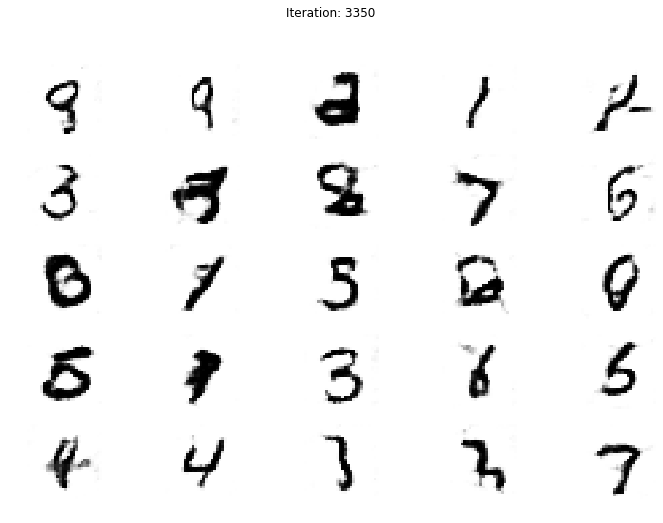

Iteration:  3351 [D loss: 0.69753, acc.:  50.00%] [G loss: 0.80796]
Iteration:  3352 [D loss: 0.71438, acc.:  46.48%] [G loss: 0.80545]
Iteration:  3353 [D loss: 0.69726, acc.:  52.34%] [G loss: 0.82145]
Iteration:  3354 [D loss: 0.69423, acc.:  53.91%] [G loss: 0.79563]
Iteration:  3355 [D loss: 0.67574, acc.:  55.47%] [G loss: 0.83088]
Iteration:  3356 [D loss: 0.70731, acc.:  51.17%] [G loss: 0.81692]
Iteration:  3357 [D loss: 0.69352, acc.:  57.03%] [G loss: 0.80009]
Iteration:  3358 [D loss: 0.70732, acc.:  50.00%] [G loss: 0.83301]
Iteration:  3359 [D loss: 0.73371, acc.:  46.09%] [G loss: 0.82608]
Iteration:  3360 [D loss: 0.67711, acc.:  58.98%] [G loss: 0.82094]
Iteration:  3361 [D loss: 0.72218, acc.:  46.88%] [G loss: 0.82448]
Iteration:  3362 [D loss: 0.73383, acc.:  47.27%] [G loss: 0.79046]
Iteration:  3363 [D loss: 0.70835, acc.:  52.73%] [G loss: 0.83252]
Iteration:  3364 [D loss: 0.73703, acc.:  45.70%] [G loss: 0.85484]
Iteration:  3365 [D loss: 0.71014, acc.:  50.39%

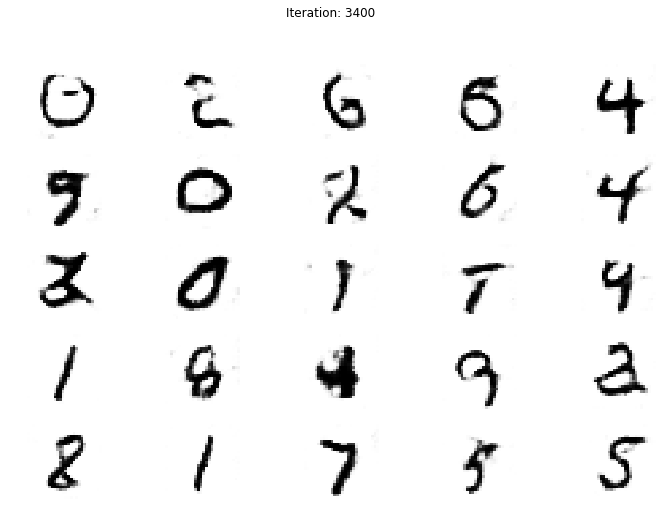

Iteration:  3401 [D loss: 0.70854, acc.:  54.69%] [G loss: 0.78651]
Iteration:  3402 [D loss: 0.75072, acc.:  45.31%] [G loss: 0.82109]
Iteration:  3403 [D loss: 0.69582, acc.:  53.52%] [G loss: 0.82961]
Iteration:  3404 [D loss: 0.69962, acc.:  50.00%] [G loss: 0.81184]
Iteration:  3405 [D loss: 0.69563, acc.:  54.69%] [G loss: 0.78810]
Iteration:  3406 [D loss: 0.70155, acc.:  54.69%] [G loss: 0.78489]
Iteration:  3407 [D loss: 0.70266, acc.:  52.34%] [G loss: 0.77983]
Iteration:  3408 [D loss: 0.68667, acc.:  58.20%] [G loss: 0.77751]
Iteration:  3409 [D loss: 0.69939, acc.:  51.95%] [G loss: 0.80479]
Iteration:  3410 [D loss: 0.71746, acc.:  47.66%] [G loss: 0.82487]
Iteration:  3411 [D loss: 0.69149, acc.:  53.52%] [G loss: 0.84020]
Iteration:  3412 [D loss: 0.70253, acc.:  53.12%] [G loss: 0.82597]
Iteration:  3413 [D loss: 0.71651, acc.:  51.56%] [G loss: 0.81715]
Iteration:  3414 [D loss: 0.71390, acc.:  49.61%] [G loss: 0.82750]
Iteration:  3415 [D loss: 0.70657, acc.:  51.95%

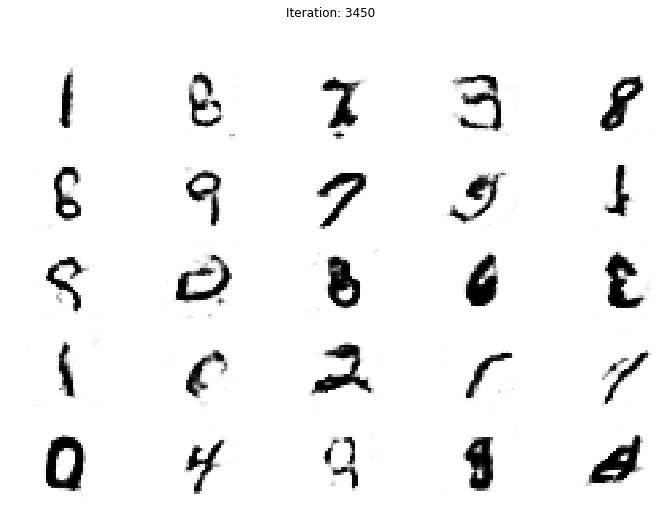

Iteration:  3451 [D loss: 0.71774, acc.:  49.22%] [G loss: 0.78624]
Iteration:  3452 [D loss: 0.70441, acc.:  53.91%] [G loss: 0.82144]
Iteration:  3453 [D loss: 0.69224, acc.:  56.64%] [G loss: 0.81140]
Iteration:  3454 [D loss: 0.67153, acc.:  58.59%] [G loss: 0.82318]
Iteration:  3455 [D loss: 0.73361, acc.:  49.22%] [G loss: 0.75698]
Iteration:  3456 [D loss: 0.72009, acc.:  51.17%] [G loss: 0.85985]
Iteration:  3457 [D loss: 0.73278, acc.:  46.88%] [G loss: 0.77968]
Iteration:  3458 [D loss: 0.68972, acc.:  57.03%] [G loss: 0.82657]
Iteration:  3459 [D loss: 0.71529, acc.:  50.78%] [G loss: 0.77020]
Iteration:  3460 [D loss: 0.73779, acc.:  46.88%] [G loss: 0.80107]
Iteration:  3461 [D loss: 0.68346, acc.:  52.73%] [G loss: 0.80013]
Iteration:  3462 [D loss: 0.70580, acc.:  51.17%] [G loss: 0.79421]
Iteration:  3463 [D loss: 0.71961, acc.:  46.48%] [G loss: 0.82824]
Iteration:  3464 [D loss: 0.72955, acc.:  44.92%] [G loss: 0.82608]
Iteration:  3465 [D loss: 0.70210, acc.:  55.08%

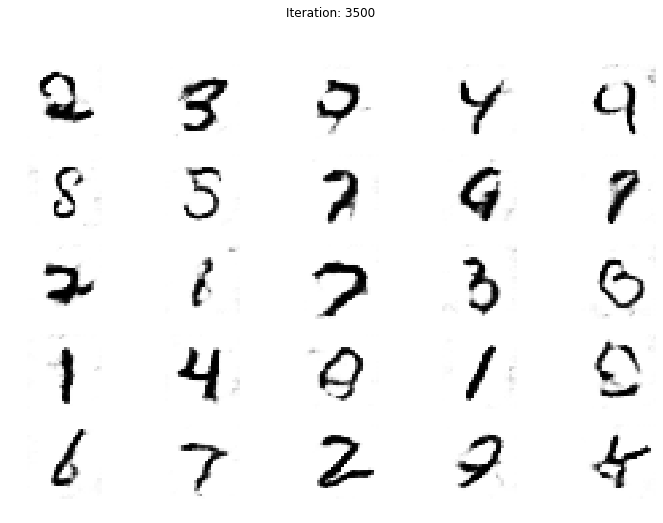

Iteration:  3501 [D loss: 0.67781, acc.:  58.59%] [G loss: 0.78972]
Iteration:  3502 [D loss: 0.72301, acc.:  49.22%] [G loss: 0.79330]
Iteration:  3503 [D loss: 0.75035, acc.:  43.75%] [G loss: 0.79362]
Iteration:  3504 [D loss: 0.69003, acc.:  57.03%] [G loss: 0.78888]
Iteration:  3505 [D loss: 0.68577, acc.:  48.83%] [G loss: 0.80275]
Iteration:  3506 [D loss: 0.69431, acc.:  55.86%] [G loss: 0.78198]
Iteration:  3507 [D loss: 0.67560, acc.:  54.30%] [G loss: 0.75933]
Iteration:  3508 [D loss: 0.72126, acc.:  45.70%] [G loss: 0.75241]
Iteration:  3509 [D loss: 0.71620, acc.:  49.22%] [G loss: 0.77890]
Iteration:  3510 [D loss: 0.69327, acc.:  52.73%] [G loss: 0.80789]
Iteration:  3511 [D loss: 0.70668, acc.:  52.73%] [G loss: 0.80401]
Iteration:  3512 [D loss: 0.70030, acc.:  52.34%] [G loss: 0.80543]
Iteration:  3513 [D loss: 0.70377, acc.:  49.22%] [G loss: 0.82261]
Iteration:  3514 [D loss: 0.72252, acc.:  46.88%] [G loss: 0.84386]
Iteration:  3515 [D loss: 0.70316, acc.:  51.95%

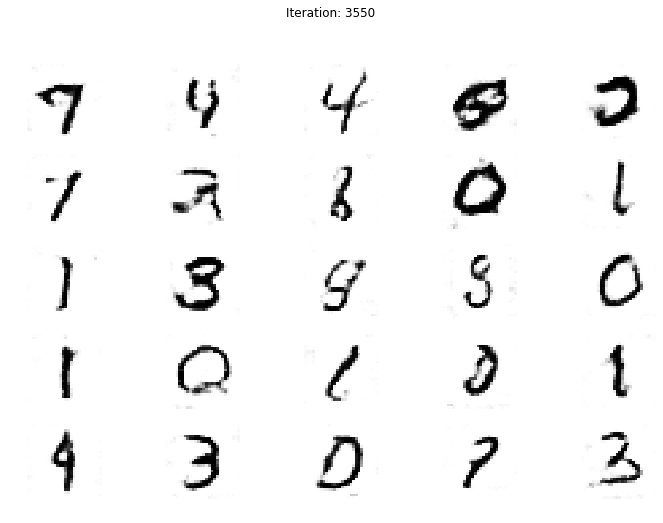

Iteration:  3551 [D loss: 0.72282, acc.:  51.95%] [G loss: 0.74013]
Iteration:  3552 [D loss: 0.72887, acc.:  46.88%] [G loss: 0.76889]
Iteration:  3553 [D loss: 0.72900, acc.:  47.66%] [G loss: 0.79095]
Iteration:  3554 [D loss: 0.68110, acc.:  58.59%] [G loss: 0.80337]
Iteration:  3555 [D loss: 0.70371, acc.:  53.12%] [G loss: 0.82152]
Iteration:  3556 [D loss: 0.72822, acc.:  50.78%] [G loss: 0.84907]
Iteration:  3557 [D loss: 0.68097, acc.:  54.69%] [G loss: 0.87304]
Iteration:  3558 [D loss: 0.71398, acc.:  52.73%] [G loss: 0.82510]
Iteration:  3559 [D loss: 0.71647, acc.:  51.17%] [G loss: 0.82126]
Iteration:  3560 [D loss: 0.72329, acc.:  48.83%] [G loss: 0.83201]
Iteration:  3561 [D loss: 0.71478, acc.:  48.44%] [G loss: 0.81648]
Iteration:  3562 [D loss: 0.70338, acc.:  51.95%] [G loss: 0.80141]
Iteration:  3563 [D loss: 0.70937, acc.:  49.61%] [G loss: 0.79683]
Iteration:  3564 [D loss: 0.72569, acc.:  51.95%] [G loss: 0.80231]
Iteration:  3565 [D loss: 0.71998, acc.:  51.95%

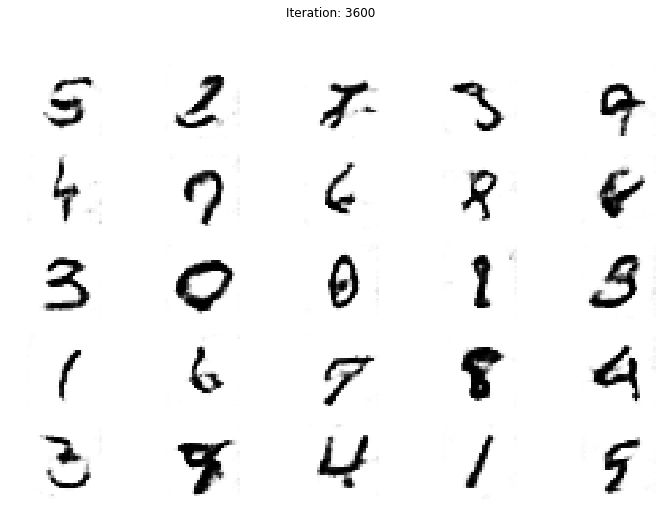

Iteration:  3601 [D loss: 0.73803, acc.:  46.48%] [G loss: 0.76381]
Iteration:  3602 [D loss: 0.72594, acc.:  48.44%] [G loss: 0.80226]
Iteration:  3603 [D loss: 0.71166, acc.:  50.78%] [G loss: 0.76647]
Iteration:  3604 [D loss: 0.72433, acc.:  48.83%] [G loss: 0.75730]
Iteration:  3605 [D loss: 0.71389, acc.:  50.39%] [G loss: 0.78836]
Iteration:  3606 [D loss: 0.71148, acc.:  50.00%] [G loss: 0.83096]
Iteration:  3607 [D loss: 0.71929, acc.:  49.22%] [G loss: 0.79127]
Iteration:  3608 [D loss: 0.69620, acc.:  55.86%] [G loss: 0.82869]
Iteration:  3609 [D loss: 0.70408, acc.:  51.17%] [G loss: 0.76069]
Iteration:  3610 [D loss: 0.70268, acc.:  53.52%] [G loss: 0.81276]
Iteration:  3611 [D loss: 0.71000, acc.:  51.95%] [G loss: 0.80200]
Iteration:  3612 [D loss: 0.71989, acc.:  49.22%] [G loss: 0.82960]
Iteration:  3613 [D loss: 0.72581, acc.:  50.78%] [G loss: 0.81137]
Iteration:  3614 [D loss: 0.68611, acc.:  55.08%] [G loss: 0.77088]
Iteration:  3615 [D loss: 0.72239, acc.:  50.00%

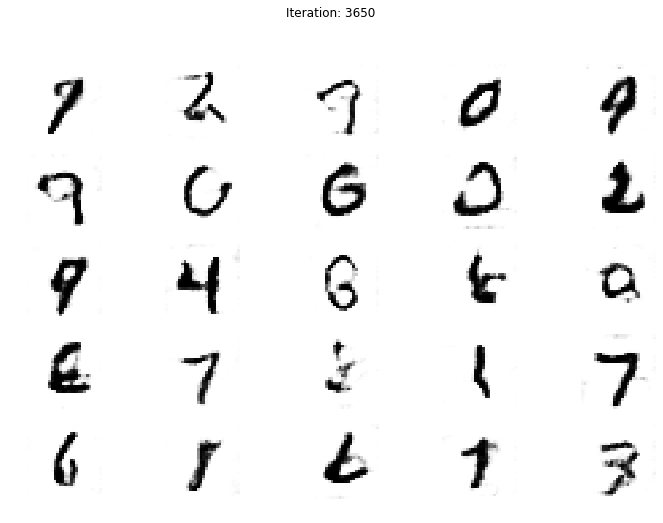

Iteration:  3651 [D loss: 0.68447, acc.:  56.64%] [G loss: 0.82307]
Iteration:  3652 [D loss: 0.70046, acc.:  54.69%] [G loss: 0.81594]
Iteration:  3653 [D loss: 0.70383, acc.:  55.47%] [G loss: 0.80469]
Iteration:  3654 [D loss: 0.71934, acc.:  53.12%] [G loss: 0.78923]
Iteration:  3655 [D loss: 0.71231, acc.:  51.17%] [G loss: 0.81763]
Iteration:  3656 [D loss: 0.69983, acc.:  51.95%] [G loss: 0.81227]
Iteration:  3657 [D loss: 0.72099, acc.:  50.00%] [G loss: 0.84635]
Iteration:  3658 [D loss: 0.69984, acc.:  53.91%] [G loss: 0.82571]
Iteration:  3659 [D loss: 0.70203, acc.:  54.30%] [G loss: 0.78796]
Iteration:  3660 [D loss: 0.70220, acc.:  51.95%] [G loss: 0.78849]
Iteration:  3661 [D loss: 0.75138, acc.:  44.92%] [G loss: 0.78597]
Iteration:  3662 [D loss: 0.70958, acc.:  49.61%] [G loss: 0.82735]
Iteration:  3663 [D loss: 0.72287, acc.:  51.56%] [G loss: 0.79567]
Iteration:  3664 [D loss: 0.71179, acc.:  54.69%] [G loss: 0.80476]
Iteration:  3665 [D loss: 0.70116, acc.:  50.78%

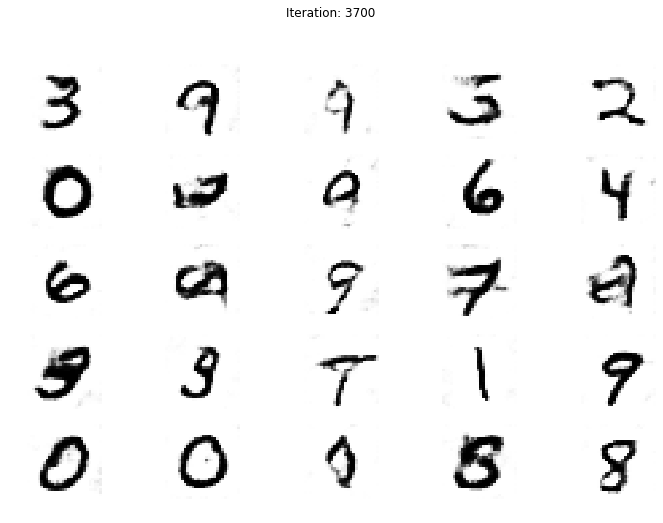

Iteration:  3701 [D loss: 0.71369, acc.:  48.83%] [G loss: 0.79826]
Iteration:  3702 [D loss: 0.69936, acc.:  53.52%] [G loss: 0.84766]
Iteration:  3703 [D loss: 0.71076, acc.:  49.61%] [G loss: 0.78062]
Iteration:  3704 [D loss: 0.70266, acc.:  48.83%] [G loss: 0.80938]
Iteration:  3705 [D loss: 0.66259, acc.:  62.50%] [G loss: 0.76933]
Iteration:  3706 [D loss: 0.70125, acc.:  50.00%] [G loss: 0.77375]
Iteration:  3707 [D loss: 0.69083, acc.:  53.91%] [G loss: 0.81409]
Iteration:  3708 [D loss: 0.72496, acc.:  46.09%] [G loss: 0.82927]
Iteration:  3709 [D loss: 0.72245, acc.:  50.78%] [G loss: 0.76706]
Iteration:  3710 [D loss: 0.72425, acc.:  51.95%] [G loss: 0.78768]
Iteration:  3711 [D loss: 0.70535, acc.:  53.12%] [G loss: 0.82267]
Iteration:  3712 [D loss: 0.73037, acc.:  46.09%] [G loss: 0.82902]
Iteration:  3713 [D loss: 0.72159, acc.:  53.12%] [G loss: 0.78061]
Iteration:  3714 [D loss: 0.71445, acc.:  47.66%] [G loss: 0.78772]
Iteration:  3715 [D loss: 0.69470, acc.:  54.30%

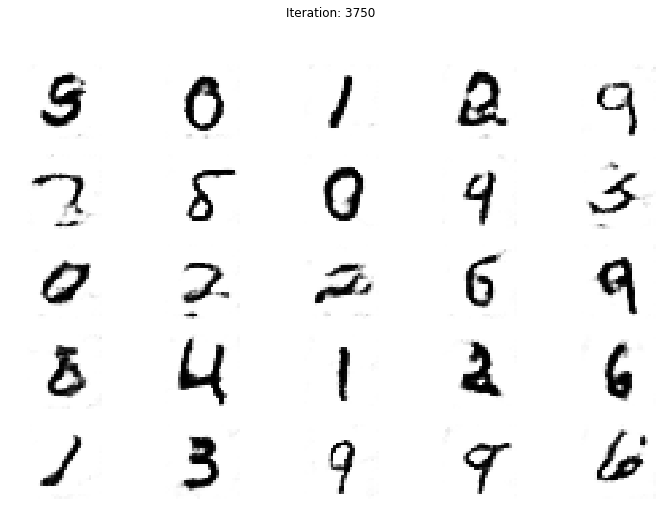

Iteration:  3751 [D loss: 0.71464, acc.:  50.78%] [G loss: 0.81766]
Iteration:  3752 [D loss: 0.72472, acc.:  46.88%] [G loss: 0.80368]
Iteration:  3753 [D loss: 0.71491, acc.:  51.17%] [G loss: 0.80210]
Iteration:  3754 [D loss: 0.69666, acc.:  50.78%] [G loss: 0.81734]
Iteration:  3755 [D loss: 0.69043, acc.:  54.69%] [G loss: 0.79804]
Iteration:  3756 [D loss: 0.70158, acc.:  53.12%] [G loss: 0.81863]
Iteration:  3757 [D loss: 0.70472, acc.:  53.12%] [G loss: 0.84238]
Iteration:  3758 [D loss: 0.67336, acc.:  58.59%] [G loss: 0.81595]
Iteration:  3759 [D loss: 0.69575, acc.:  53.52%] [G loss: 0.78851]
Iteration:  3760 [D loss: 0.72316, acc.:  48.83%] [G loss: 0.83666]
Iteration:  3761 [D loss: 0.72461, acc.:  48.44%] [G loss: 0.76359]
Iteration:  3762 [D loss: 0.70415, acc.:  49.61%] [G loss: 0.80404]
Iteration:  3763 [D loss: 0.69246, acc.:  52.73%] [G loss: 0.79174]
Iteration:  3764 [D loss: 0.69627, acc.:  53.91%] [G loss: 0.77803]
Iteration:  3765 [D loss: 0.68890, acc.:  55.86%

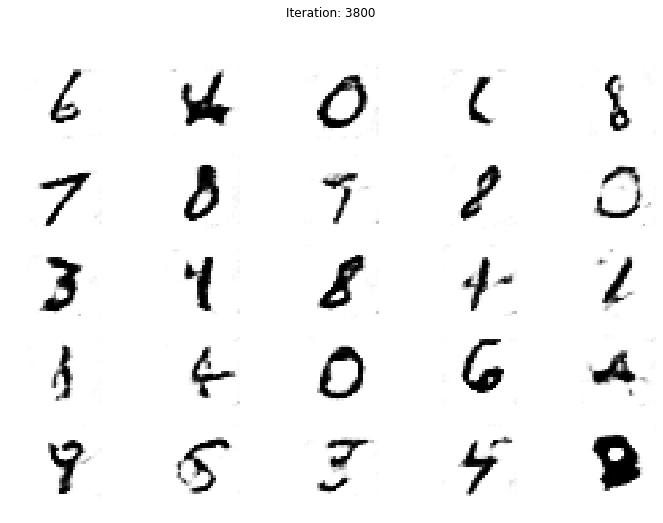

Iteration:  3801 [D loss: 0.70531, acc.:  51.95%] [G loss: 0.79027]
Iteration:  3802 [D loss: 0.70994, acc.:  52.34%] [G loss: 0.86661]
Iteration:  3803 [D loss: 0.73088, acc.:  48.05%] [G loss: 0.78427]
Iteration:  3804 [D loss: 0.70686, acc.:  53.12%] [G loss: 0.78572]
Iteration:  3805 [D loss: 0.72789, acc.:  48.05%] [G loss: 0.77192]
Iteration:  3806 [D loss: 0.71003, acc.:  47.66%] [G loss: 0.81475]
Iteration:  3807 [D loss: 0.69349, acc.:  56.64%] [G loss: 0.82542]
Iteration:  3808 [D loss: 0.69610, acc.:  52.73%] [G loss: 0.76632]
Iteration:  3809 [D loss: 0.71453, acc.:  49.22%] [G loss: 0.75003]
Iteration:  3810 [D loss: 0.69808, acc.:  51.17%] [G loss: 0.80591]
Iteration:  3811 [D loss: 0.66649, acc.:  55.86%] [G loss: 0.81902]
Iteration:  3812 [D loss: 0.70864, acc.:  53.52%] [G loss: 0.78791]
Iteration:  3813 [D loss: 0.71006, acc.:  55.47%] [G loss: 0.81629]
Iteration:  3814 [D loss: 0.69820, acc.:  52.34%] [G loss: 0.83754]
Iteration:  3815 [D loss: 0.69206, acc.:  57.03%

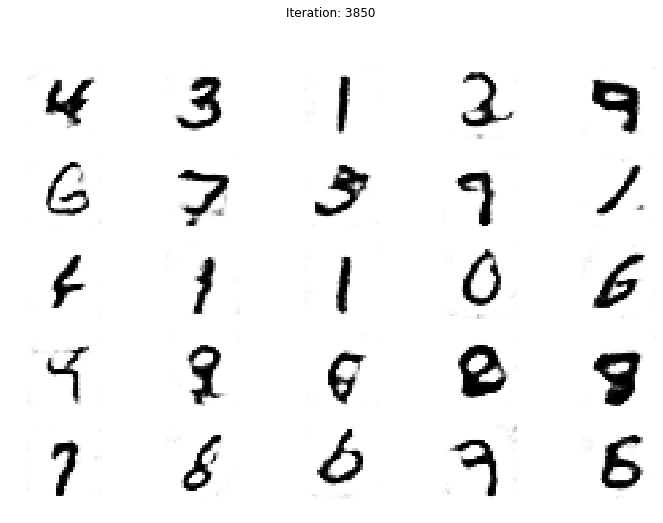

Iteration:  3851 [D loss: 0.70744, acc.:  52.34%] [G loss: 0.83300]
Iteration:  3852 [D loss: 0.72045, acc.:  48.44%] [G loss: 0.80775]
Iteration:  3853 [D loss: 0.72194, acc.:  48.05%] [G loss: 0.82910]
Iteration:  3854 [D loss: 0.70897, acc.:  55.86%] [G loss: 0.77915]
Iteration:  3855 [D loss: 0.71526, acc.:  50.78%] [G loss: 0.76566]
Iteration:  3856 [D loss: 0.71360, acc.:  52.73%] [G loss: 0.74841]
Iteration:  3857 [D loss: 0.71249, acc.:  51.17%] [G loss: 0.82358]
Iteration:  3858 [D loss: 0.71939, acc.:  48.44%] [G loss: 0.78720]
Iteration:  3859 [D loss: 0.70613, acc.:  54.30%] [G loss: 0.78757]
Iteration:  3860 [D loss: 0.71510, acc.:  53.91%] [G loss: 0.78412]
Iteration:  3861 [D loss: 0.70666, acc.:  51.56%] [G loss: 0.85803]
Iteration:  3862 [D loss: 0.73325, acc.:  41.41%] [G loss: 0.82005]
Iteration:  3863 [D loss: 0.72198, acc.:  47.66%] [G loss: 0.76416]
Iteration:  3864 [D loss: 0.72595, acc.:  45.70%] [G loss: 0.75146]
Iteration:  3865 [D loss: 0.72037, acc.:  49.22%

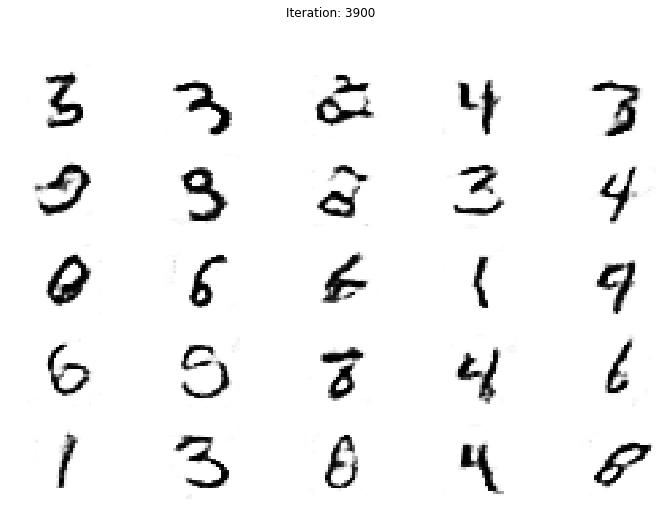

Iteration:  3901 [D loss: 0.70131, acc.:  55.08%] [G loss: 0.78382]
Iteration:  3902 [D loss: 0.68629, acc.:  53.12%] [G loss: 0.81235]
Iteration:  3903 [D loss: 0.70365, acc.:  50.78%] [G loss: 0.78734]
Iteration:  3904 [D loss: 0.72003, acc.:  48.83%] [G loss: 0.74029]
Iteration:  3905 [D loss: 0.69002, acc.:  57.03%] [G loss: 0.79662]
Iteration:  3906 [D loss: 0.71693, acc.:  51.56%] [G loss: 0.81694]
Iteration:  3907 [D loss: 0.70826, acc.:  52.73%] [G loss: 0.79157]
Iteration:  3908 [D loss: 0.72017, acc.:  45.70%] [G loss: 0.79719]
Iteration:  3909 [D loss: 0.71908, acc.:  47.66%] [G loss: 0.82232]
Iteration:  3910 [D loss: 0.70121, acc.:  50.78%] [G loss: 0.82320]
Iteration:  3911 [D loss: 0.71512, acc.:  50.78%] [G loss: 0.78833]
Iteration:  3912 [D loss: 0.71982, acc.:  47.27%] [G loss: 0.78987]
Iteration:  3913 [D loss: 0.70488, acc.:  50.78%] [G loss: 0.78251]
Iteration:  3914 [D loss: 0.70798, acc.:  50.78%] [G loss: 0.83185]
Iteration:  3915 [D loss: 0.70718, acc.:  54.30%

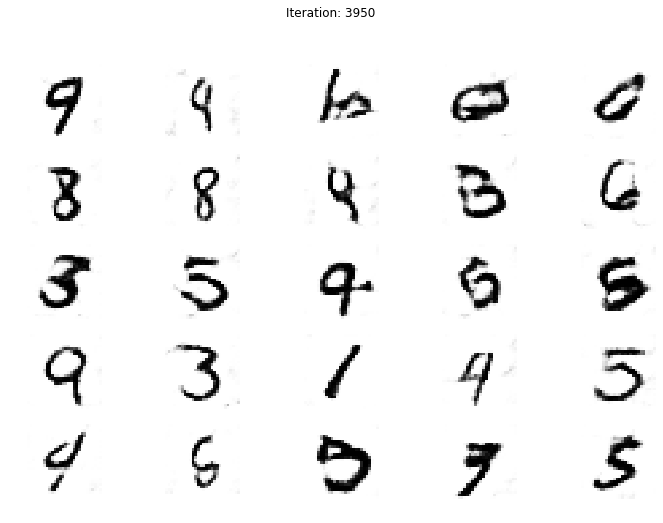

Iteration:  3951 [D loss: 0.67044, acc.:  55.47%] [G loss: 0.80075]
Iteration:  3952 [D loss: 0.72606, acc.:  47.27%] [G loss: 0.77695]
Iteration:  3953 [D loss: 0.70345, acc.:  50.78%] [G loss: 0.79370]
Iteration:  3954 [D loss: 0.71797, acc.:  47.27%] [G loss: 0.78647]
Iteration:  3955 [D loss: 0.69794, acc.:  54.30%] [G loss: 0.79746]
Iteration:  3956 [D loss: 0.68927, acc.:  57.03%] [G loss: 0.81496]
Iteration:  3957 [D loss: 0.72277, acc.:  51.17%] [G loss: 0.79470]
Iteration:  3958 [D loss: 0.70187, acc.:  51.17%] [G loss: 0.78794]
Iteration:  3959 [D loss: 0.71191, acc.:  51.17%] [G loss: 0.81920]
Iteration:  3960 [D loss: 0.69119, acc.:  53.12%] [G loss: 0.80100]
Iteration:  3961 [D loss: 0.70953, acc.:  52.34%] [G loss: 0.77629]
Iteration:  3962 [D loss: 0.71667, acc.:  52.34%] [G loss: 0.79639]
Iteration:  3963 [D loss: 0.69694, acc.:  54.30%] [G loss: 0.80793]
Iteration:  3964 [D loss: 0.68932, acc.:  53.91%] [G loss: 0.82448]
Iteration:  3965 [D loss: 0.69854, acc.:  53.52%

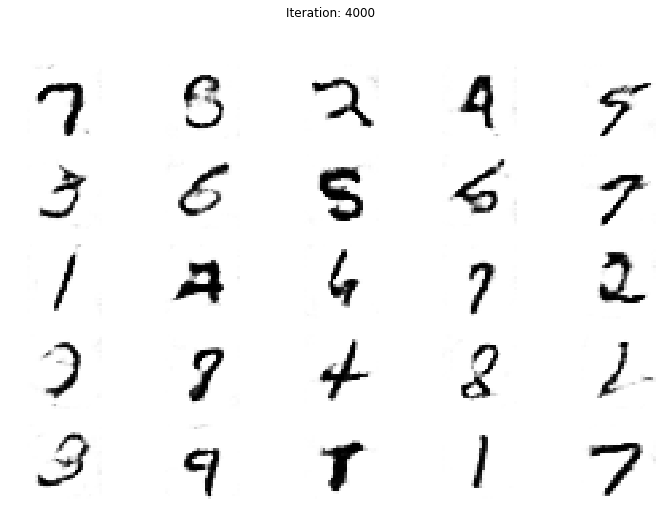

Iteration:  4001 [D loss: 0.73698, acc.:  47.66%] [G loss: 0.83368]
Iteration:  4002 [D loss: 0.71958, acc.:  50.78%] [G loss: 0.75387]
Iteration:  4003 [D loss: 0.72103, acc.:  50.39%] [G loss: 0.79483]
Iteration:  4004 [D loss: 0.73336, acc.:  46.09%] [G loss: 0.76447]
Iteration:  4005 [D loss: 0.71979, acc.:  48.83%] [G loss: 0.78389]
Iteration:  4006 [D loss: 0.72345, acc.:  50.00%] [G loss: 0.79844]
Iteration:  4007 [D loss: 0.71748, acc.:  49.22%] [G loss: 0.81783]
Iteration:  4008 [D loss: 0.73549, acc.:  45.31%] [G loss: 0.78439]
Iteration:  4009 [D loss: 0.70595, acc.:  53.12%] [G loss: 0.77749]
Iteration:  4010 [D loss: 0.72109, acc.:  50.39%] [G loss: 0.82287]
Iteration:  4011 [D loss: 0.74977, acc.:  42.97%] [G loss: 0.76570]
Iteration:  4012 [D loss: 0.70942, acc.:  49.22%] [G loss: 0.79611]
Iteration:  4013 [D loss: 0.67065, acc.:  60.94%] [G loss: 0.74710]
Iteration:  4014 [D loss: 0.72125, acc.:  50.78%] [G loss: 0.77947]
Iteration:  4015 [D loss: 0.71604, acc.:  51.56%

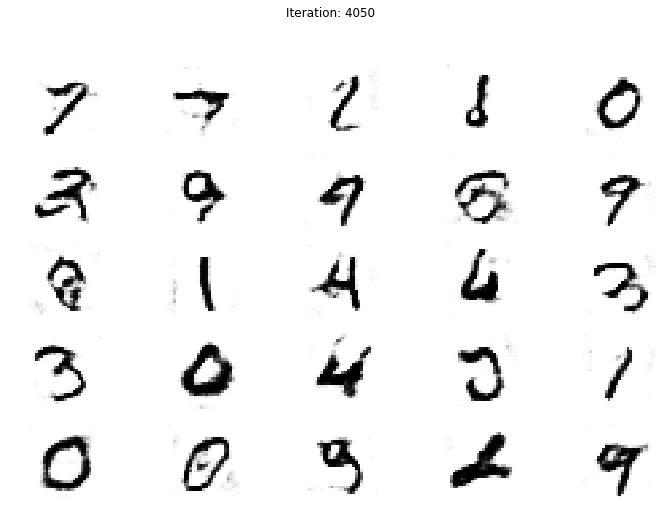

Iteration:  4051 [D loss: 0.71561, acc.:  51.95%] [G loss: 0.77983]
Iteration:  4052 [D loss: 0.70576, acc.:  54.30%] [G loss: 0.78832]
Iteration:  4053 [D loss: 0.74401, acc.:  44.14%] [G loss: 0.80929]
Iteration:  4054 [D loss: 0.73217, acc.:  46.09%] [G loss: 0.77431]
Iteration:  4055 [D loss: 0.69867, acc.:  49.22%] [G loss: 0.78861]
Iteration:  4056 [D loss: 0.70319, acc.:  53.52%] [G loss: 0.81253]
Iteration:  4057 [D loss: 0.71542, acc.:  52.34%] [G loss: 0.77285]
Iteration:  4058 [D loss: 0.72293, acc.:  47.27%] [G loss: 0.76857]
Iteration:  4059 [D loss: 0.70257, acc.:  50.78%] [G loss: 0.80404]
Iteration:  4060 [D loss: 0.70322, acc.:  49.61%] [G loss: 0.78952]
Iteration:  4061 [D loss: 0.71454, acc.:  50.00%] [G loss: 0.81320]
Iteration:  4062 [D loss: 0.69237, acc.:  56.64%] [G loss: 0.80929]
Iteration:  4063 [D loss: 0.68035, acc.:  57.42%] [G loss: 0.79807]
Iteration:  4064 [D loss: 0.72079, acc.:  47.27%] [G loss: 0.81244]
Iteration:  4065 [D loss: 0.70218, acc.:  50.78%

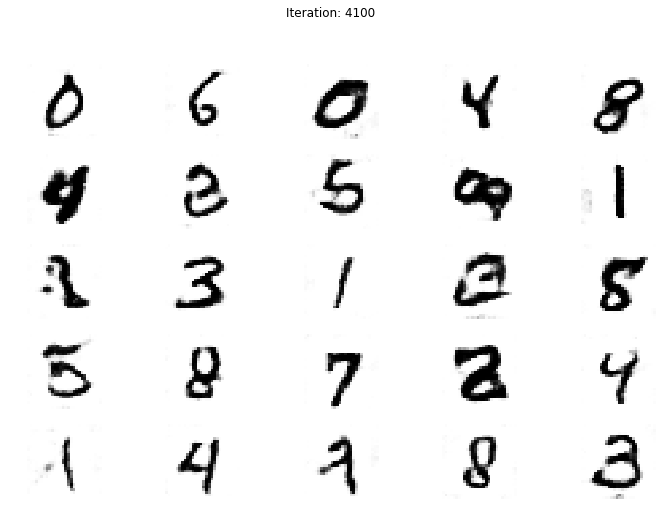

Iteration:  4101 [D loss: 0.71322, acc.:  51.95%] [G loss: 0.74229]
Iteration:  4102 [D loss: 0.71779, acc.:  48.44%] [G loss: 0.75007]
Iteration:  4103 [D loss: 0.71831, acc.:  49.22%] [G loss: 0.76893]
Iteration:  4104 [D loss: 0.72339, acc.:  46.48%] [G loss: 0.79026]
Iteration:  4105 [D loss: 0.67045, acc.:  56.64%] [G loss: 0.81820]
Iteration:  4106 [D loss: 0.71142, acc.:  48.83%] [G loss: 0.80490]
Iteration:  4107 [D loss: 0.68957, acc.:  53.52%] [G loss: 0.79975]
Iteration:  4108 [D loss: 0.72332, acc.:  44.14%] [G loss: 0.77806]
Iteration:  4109 [D loss: 0.71350, acc.:  50.00%] [G loss: 0.77537]
Iteration:  4110 [D loss: 0.72051, acc.:  49.61%] [G loss: 0.82243]
Iteration:  4111 [D loss: 0.70371, acc.:  51.95%] [G loss: 0.75401]
Iteration:  4112 [D loss: 0.71349, acc.:  46.88%] [G loss: 0.80262]
Iteration:  4113 [D loss: 0.70566, acc.:  51.56%] [G loss: 0.77954]
Iteration:  4114 [D loss: 0.71175, acc.:  48.44%] [G loss: 0.77728]
Iteration:  4115 [D loss: 0.71393, acc.:  50.78%

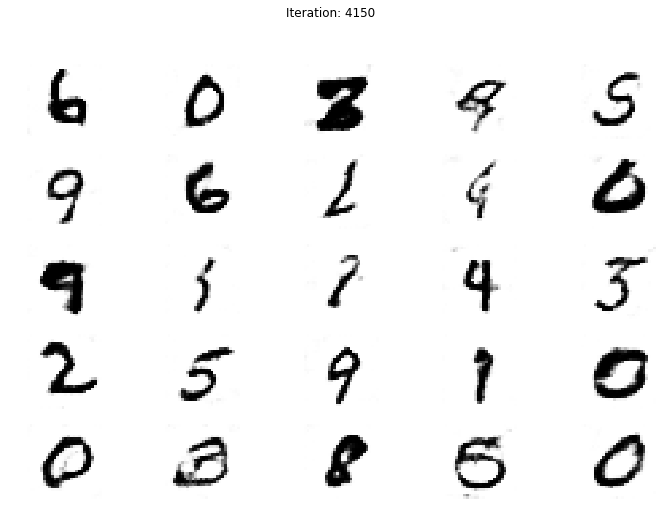

Iteration:  4151 [D loss: 0.73531, acc.:  47.66%] [G loss: 0.80332]
Iteration:  4152 [D loss: 0.68819, acc.:  57.81%] [G loss: 0.80969]
Iteration:  4153 [D loss: 0.72689, acc.:  47.66%] [G loss: 0.78757]
Iteration:  4154 [D loss: 0.72042, acc.:  48.05%] [G loss: 0.79721]
Iteration:  4155 [D loss: 0.71904, acc.:  45.70%] [G loss: 0.80551]
Iteration:  4156 [D loss: 0.70495, acc.:  54.30%] [G loss: 0.81662]
Iteration:  4157 [D loss: 0.72520, acc.:  46.48%] [G loss: 0.79351]
Iteration:  4158 [D loss: 0.71981, acc.:  50.00%] [G loss: 0.82533]
Iteration:  4159 [D loss: 0.68568, acc.:  58.98%] [G loss: 0.81820]
Iteration:  4160 [D loss: 0.71092, acc.:  52.73%] [G loss: 0.78889]
Iteration:  4161 [D loss: 0.70522, acc.:  52.73%] [G loss: 0.77676]
Iteration:  4162 [D loss: 0.73329, acc.:  48.83%] [G loss: 0.81633]
Iteration:  4163 [D loss: 0.69287, acc.:  58.59%] [G loss: 0.80760]
Iteration:  4164 [D loss: 0.72534, acc.:  47.27%] [G loss: 0.80708]
Iteration:  4165 [D loss: 0.68040, acc.:  59.38%

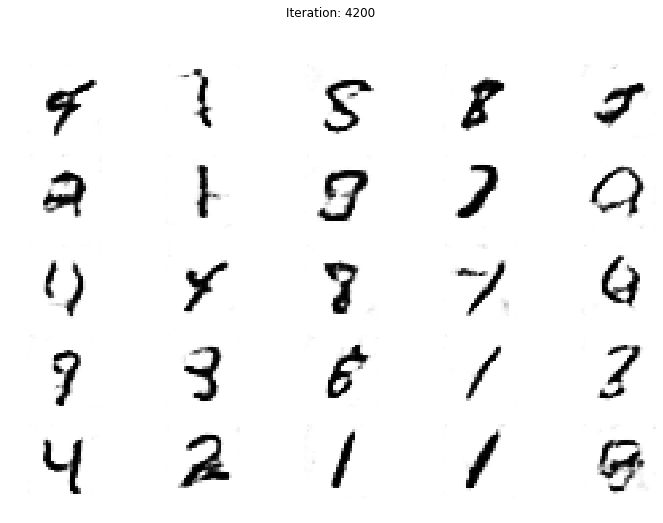

Iteration:  4201 [D loss: 0.69908, acc.:  53.52%] [G loss: 0.74750]
Iteration:  4202 [D loss: 0.70363, acc.:  51.17%] [G loss: 0.81582]
Iteration:  4203 [D loss: 0.71192, acc.:  50.00%] [G loss: 0.79046]
Iteration:  4204 [D loss: 0.69400, acc.:  55.86%] [G loss: 0.82722]
Iteration:  4205 [D loss: 0.71315, acc.:  48.83%] [G loss: 0.83096]
Iteration:  4206 [D loss: 0.70308, acc.:  54.30%] [G loss: 0.82634]
Iteration:  4207 [D loss: 0.71801, acc.:  48.44%] [G loss: 0.77410]
Iteration:  4208 [D loss: 0.71334, acc.:  53.52%] [G loss: 0.79175]
Iteration:  4209 [D loss: 0.70479, acc.:  48.44%] [G loss: 0.78730]
Iteration:  4210 [D loss: 0.72651, acc.:  46.88%] [G loss: 0.78885]
Iteration:  4211 [D loss: 0.69903, acc.:  55.08%] [G loss: 0.80833]
Iteration:  4212 [D loss: 0.70567, acc.:  53.12%] [G loss: 0.84626]
Iteration:  4213 [D loss: 0.71166, acc.:  54.30%] [G loss: 0.73246]
Iteration:  4214 [D loss: 0.71584, acc.:  48.05%] [G loss: 0.81928]
Iteration:  4215 [D loss: 0.72657, acc.:  46.48%

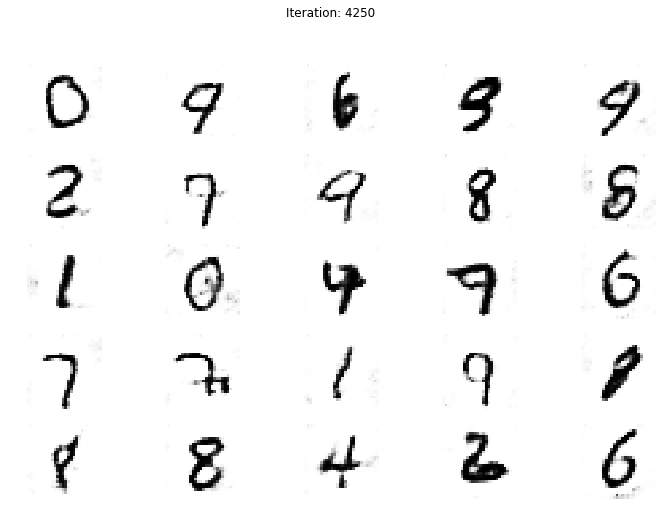

Iteration:  4251 [D loss: 0.69428, acc.:  50.39%] [G loss: 0.81506]
Iteration:  4252 [D loss: 0.69904, acc.:  52.34%] [G loss: 0.78264]
Iteration:  4253 [D loss: 0.71940, acc.:  49.61%] [G loss: 0.83313]
Iteration:  4254 [D loss: 0.72552, acc.:  49.22%] [G loss: 0.78673]
Iteration:  4255 [D loss: 0.69816, acc.:  56.25%] [G loss: 0.79835]
Iteration:  4256 [D loss: 0.70404, acc.:  51.95%] [G loss: 0.79153]
Iteration:  4257 [D loss: 0.72729, acc.:  45.70%] [G loss: 0.77501]
Iteration:  4258 [D loss: 0.71391, acc.:  49.22%] [G loss: 0.79884]
Iteration:  4259 [D loss: 0.71131, acc.:  50.00%] [G loss: 0.83215]
Iteration:  4260 [D loss: 0.70214, acc.:  52.73%] [G loss: 0.81619]
Iteration:  4261 [D loss: 0.69881, acc.:  54.30%] [G loss: 0.79452]
Iteration:  4262 [D loss: 0.68639, acc.:  54.69%] [G loss: 0.81583]
Iteration:  4263 [D loss: 0.70096, acc.:  54.69%] [G loss: 0.83839]
Iteration:  4264 [D loss: 0.70987, acc.:  49.61%] [G loss: 0.82902]
Iteration:  4265 [D loss: 0.72106, acc.:  47.27%

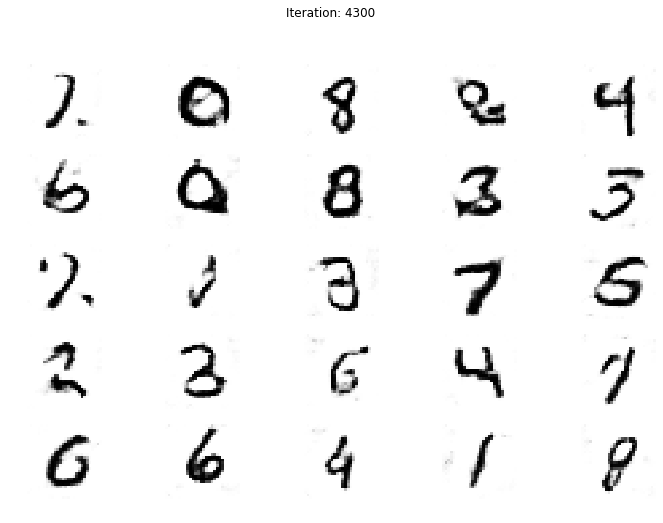

Iteration:  4301 [D loss: 0.67989, acc.:  58.20%] [G loss: 0.82587]
Iteration:  4302 [D loss: 0.69936, acc.:  54.30%] [G loss: 0.79324]
Iteration:  4303 [D loss: 0.70405, acc.:  54.69%] [G loss: 0.85897]
Iteration:  4304 [D loss: 0.70785, acc.:  50.78%] [G loss: 0.80267]
Iteration:  4305 [D loss: 0.72204, acc.:  53.52%] [G loss: 0.77795]
Iteration:  4306 [D loss: 0.74832, acc.:  44.92%] [G loss: 0.79753]
Iteration:  4307 [D loss: 0.68888, acc.:  56.25%] [G loss: 0.76584]
Iteration:  4308 [D loss: 0.72382, acc.:  44.92%] [G loss: 0.81312]
Iteration:  4309 [D loss: 0.75452, acc.:  42.97%] [G loss: 0.77825]
Iteration:  4310 [D loss: 0.69111, acc.:  55.47%] [G loss: 0.79037]
Iteration:  4311 [D loss: 0.68918, acc.:  55.47%] [G loss: 0.80150]
Iteration:  4312 [D loss: 0.68638, acc.:  55.86%] [G loss: 0.75809]
Iteration:  4313 [D loss: 0.70365, acc.:  50.00%] [G loss: 0.80406]
Iteration:  4314 [D loss: 0.71594, acc.:  51.56%] [G loss: 0.74276]
Iteration:  4315 [D loss: 0.70165, acc.:  50.39%

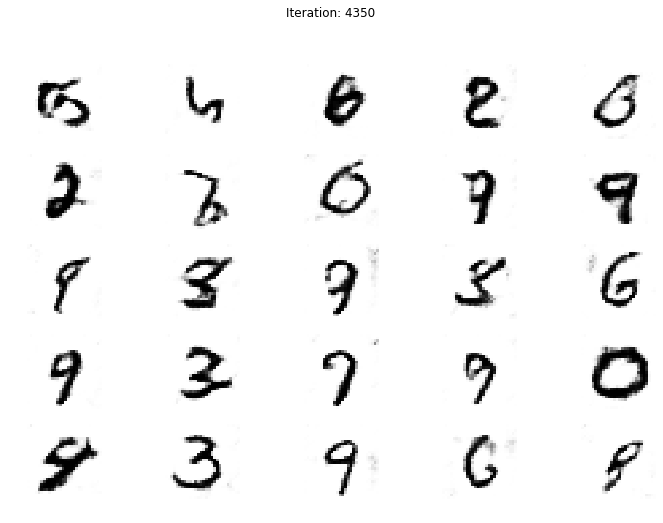

Iteration:  4351 [D loss: 0.68914, acc.:  55.47%] [G loss: 0.79079]
Iteration:  4352 [D loss: 0.71578, acc.:  51.56%] [G loss: 0.77001]
Iteration:  4353 [D loss: 0.69281, acc.:  52.34%] [G loss: 0.76325]
Iteration:  4354 [D loss: 0.70030, acc.:  53.91%] [G loss: 0.74254]
Iteration:  4355 [D loss: 0.68803, acc.:  57.03%] [G loss: 0.79393]
Iteration:  4356 [D loss: 0.71408, acc.:  51.95%] [G loss: 0.80165]
Iteration:  4357 [D loss: 0.70712, acc.:  52.73%] [G loss: 0.78765]
Iteration:  4358 [D loss: 0.71019, acc.:  49.61%] [G loss: 0.81859]
Iteration:  4359 [D loss: 0.71237, acc.:  50.78%] [G loss: 0.80469]
Iteration:  4360 [D loss: 0.71639, acc.:  51.17%] [G loss: 0.82108]
Iteration:  4361 [D loss: 0.70641, acc.:  52.34%] [G loss: 0.78575]
Iteration:  4362 [D loss: 0.71005, acc.:  51.17%] [G loss: 0.82675]
Iteration:  4363 [D loss: 0.71105, acc.:  52.73%] [G loss: 0.81850]
Iteration:  4364 [D loss: 0.71206, acc.:  45.31%] [G loss: 0.81101]
Iteration:  4365 [D loss: 0.70538, acc.:  49.61%

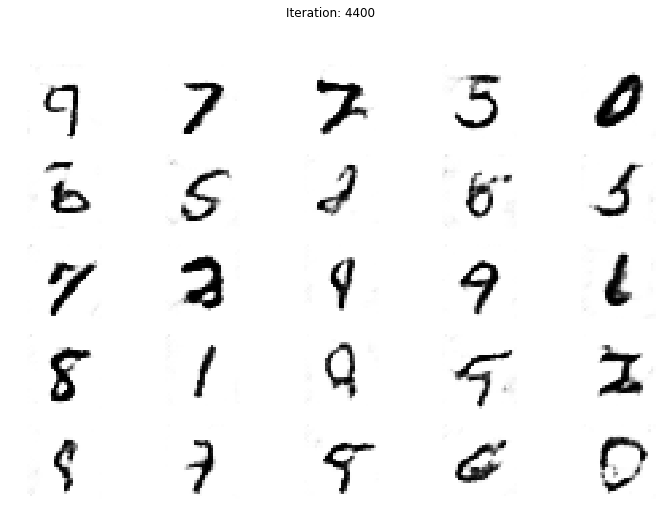

Iteration:  4401 [D loss: 0.69509, acc.:  53.12%] [G loss: 0.82460]
Iteration:  4402 [D loss: 0.71760, acc.:  48.44%] [G loss: 0.81178]
Iteration:  4403 [D loss: 0.70094, acc.:  53.52%] [G loss: 0.79699]
Iteration:  4404 [D loss: 0.72162, acc.:  48.83%] [G loss: 0.86387]
Iteration:  4405 [D loss: 0.71853, acc.:  47.66%] [G loss: 0.82018]
Iteration:  4406 [D loss: 0.70971, acc.:  54.69%] [G loss: 0.77793]
Iteration:  4407 [D loss: 0.70232, acc.:  50.39%] [G loss: 0.76975]
Iteration:  4408 [D loss: 0.69025, acc.:  55.47%] [G loss: 0.79788]
Iteration:  4409 [D loss: 0.70084, acc.:  51.17%] [G loss: 0.80889]
Iteration:  4410 [D loss: 0.68732, acc.:  57.42%] [G loss: 0.79282]
Iteration:  4411 [D loss: 0.71568, acc.:  49.22%] [G loss: 0.80901]
Iteration:  4412 [D loss: 0.67186, acc.:  57.03%] [G loss: 0.83621]
Iteration:  4413 [D loss: 0.74179, acc.:  46.09%] [G loss: 0.80639]
Iteration:  4414 [D loss: 0.69914, acc.:  52.34%] [G loss: 0.74601]
Iteration:  4415 [D loss: 0.73487, acc.:  45.70%

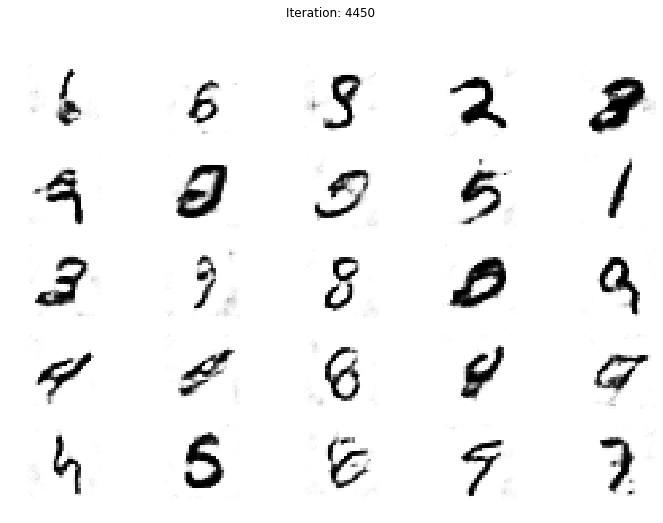

Iteration:  4451 [D loss: 0.69423, acc.:  55.08%] [G loss: 0.80438]
Iteration:  4452 [D loss: 0.71599, acc.:  51.17%] [G loss: 0.79271]
Iteration:  4453 [D loss: 0.73667, acc.:  46.09%] [G loss: 0.79086]
Iteration:  4454 [D loss: 0.71269, acc.:  44.92%] [G loss: 0.78664]
Iteration:  4455 [D loss: 0.72325, acc.:  49.61%] [G loss: 0.78858]
Iteration:  4456 [D loss: 0.70982, acc.:  48.83%] [G loss: 0.79935]
Iteration:  4457 [D loss: 0.72413, acc.:  50.39%] [G loss: 0.79628]
Iteration:  4458 [D loss: 0.71510, acc.:  49.61%] [G loss: 0.79913]
Iteration:  4459 [D loss: 0.69532, acc.:  53.52%] [G loss: 0.79448]
Iteration:  4460 [D loss: 0.67838, acc.:  55.86%] [G loss: 0.81236]
Iteration:  4461 [D loss: 0.70263, acc.:  52.34%] [G loss: 0.78638]
Iteration:  4462 [D loss: 0.71480, acc.:  52.34%] [G loss: 0.78557]
Iteration:  4463 [D loss: 0.70429, acc.:  50.78%] [G loss: 0.77836]
Iteration:  4464 [D loss: 0.72751, acc.:  46.48%] [G loss: 0.75310]
Iteration:  4465 [D loss: 0.71531, acc.:  50.00%

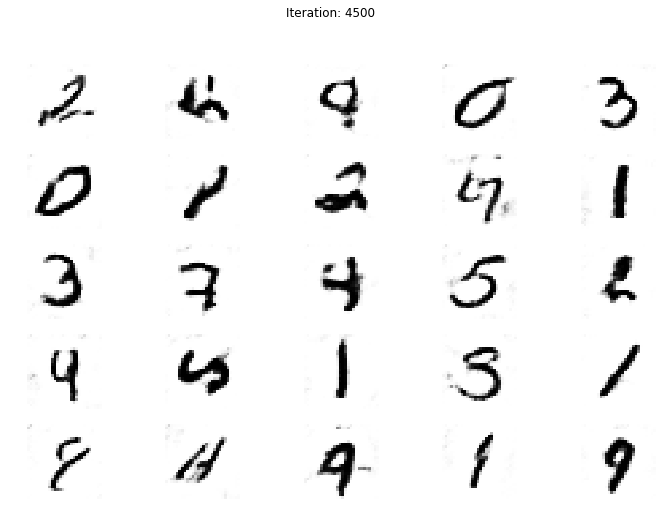

Iteration:  4501 [D loss: 0.73073, acc.:  44.92%] [G loss: 0.76981]
Iteration:  4502 [D loss: 0.74198, acc.:  47.27%] [G loss: 0.81586]
Iteration:  4503 [D loss: 0.71338, acc.:  50.39%] [G loss: 0.79932]
Iteration:  4504 [D loss: 0.71496, acc.:  48.83%] [G loss: 0.81340]
Iteration:  4505 [D loss: 0.71423, acc.:  50.39%] [G loss: 0.81281]
Iteration:  4506 [D loss: 0.70331, acc.:  53.52%] [G loss: 0.78551]
Iteration:  4507 [D loss: 0.68180, acc.:  54.69%] [G loss: 0.82550]
Iteration:  4508 [D loss: 0.71327, acc.:  50.78%] [G loss: 0.78139]
Iteration:  4509 [D loss: 0.67376, acc.:  57.81%] [G loss: 0.77077]
Iteration:  4510 [D loss: 0.72537, acc.:  47.27%] [G loss: 0.79341]
Iteration:  4511 [D loss: 0.69216, acc.:  50.39%] [G loss: 0.79733]
Iteration:  4512 [D loss: 0.74142, acc.:  44.53%] [G loss: 0.82090]
Iteration:  4513 [D loss: 0.73457, acc.:  48.44%] [G loss: 0.77925]
Iteration:  4514 [D loss: 0.73808, acc.:  42.97%] [G loss: 0.74983]
Iteration:  4515 [D loss: 0.70736, acc.:  50.39%

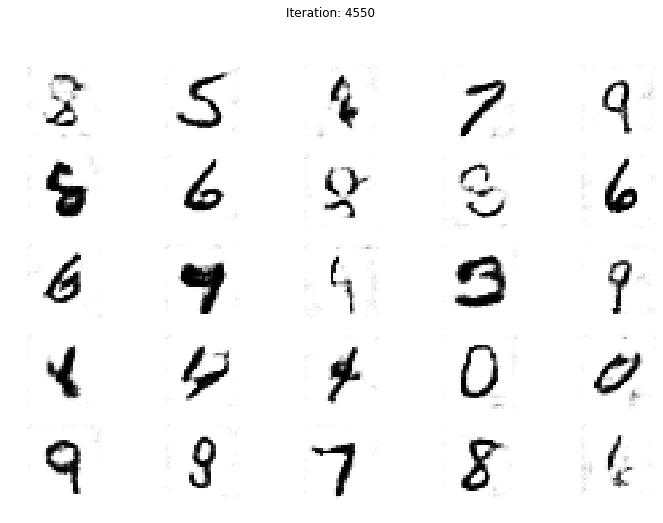

Iteration:  4551 [D loss: 0.69849, acc.:  55.86%] [G loss: 0.76960]
Iteration:  4552 [D loss: 0.68981, acc.:  57.42%] [G loss: 0.75165]
Iteration:  4553 [D loss: 0.68740, acc.:  53.91%] [G loss: 0.74016]
Iteration:  4554 [D loss: 0.71599, acc.:  49.22%] [G loss: 0.79869]
Iteration:  4555 [D loss: 0.71213, acc.:  50.00%] [G loss: 0.76817]
Iteration:  4556 [D loss: 0.71259, acc.:  48.83%] [G loss: 0.80149]
Iteration:  4557 [D loss: 0.72548, acc.:  48.44%] [G loss: 0.78653]
Iteration:  4558 [D loss: 0.73289, acc.:  41.80%] [G loss: 0.78615]
Iteration:  4559 [D loss: 0.73651, acc.:  44.14%] [G loss: 0.76936]
Iteration:  4560 [D loss: 0.70974, acc.:  49.61%] [G loss: 0.77019]
Iteration:  4561 [D loss: 0.68785, acc.:  53.91%] [G loss: 0.84507]
Iteration:  4562 [D loss: 0.69497, acc.:  53.91%] [G loss: 0.77534]
Iteration:  4563 [D loss: 0.68894, acc.:  52.34%] [G loss: 0.79228]
Iteration:  4564 [D loss: 0.70273, acc.:  51.95%] [G loss: 0.78630]
Iteration:  4565 [D loss: 0.71617, acc.:  46.48%

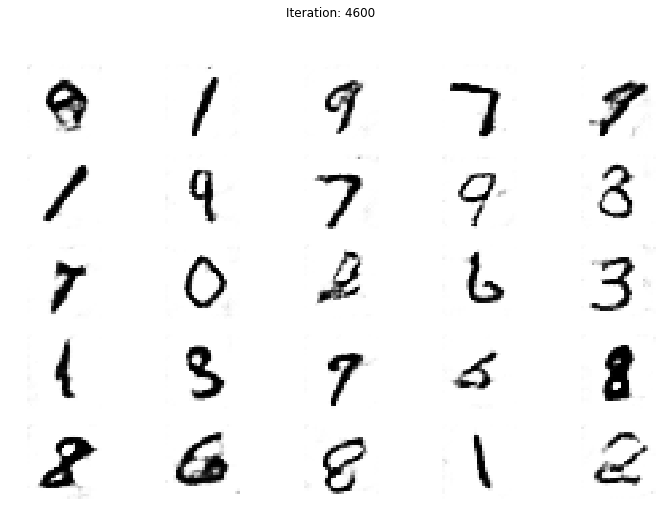

Iteration:  4601 [D loss: 0.73952, acc.:  43.75%] [G loss: 0.76895]
Iteration:  4602 [D loss: 0.69853, acc.:  50.39%] [G loss: 0.77321]
Iteration:  4603 [D loss: 0.68957, acc.:  54.69%] [G loss: 0.78098]
Iteration:  4604 [D loss: 0.70395, acc.:  51.56%] [G loss: 0.77194]
Iteration:  4605 [D loss: 0.73763, acc.:  42.97%] [G loss: 0.80666]
Iteration:  4606 [D loss: 0.70310, acc.:  53.91%] [G loss: 0.77633]
Iteration:  4607 [D loss: 0.67659, acc.:  57.42%] [G loss: 0.82345]
Iteration:  4608 [D loss: 0.71901, acc.:  46.88%] [G loss: 0.78408]
Iteration:  4609 [D loss: 0.72152, acc.:  48.44%] [G loss: 0.77196]
Iteration:  4610 [D loss: 0.72926, acc.:  46.48%] [G loss: 0.79615]
Iteration:  4611 [D loss: 0.72225, acc.:  47.66%] [G loss: 0.82617]
Iteration:  4612 [D loss: 0.71848, acc.:  47.66%] [G loss: 0.79108]
Iteration:  4613 [D loss: 0.73582, acc.:  46.09%] [G loss: 0.77103]
Iteration:  4614 [D loss: 0.71645, acc.:  51.95%] [G loss: 0.76594]
Iteration:  4615 [D loss: 0.71834, acc.:  48.83%

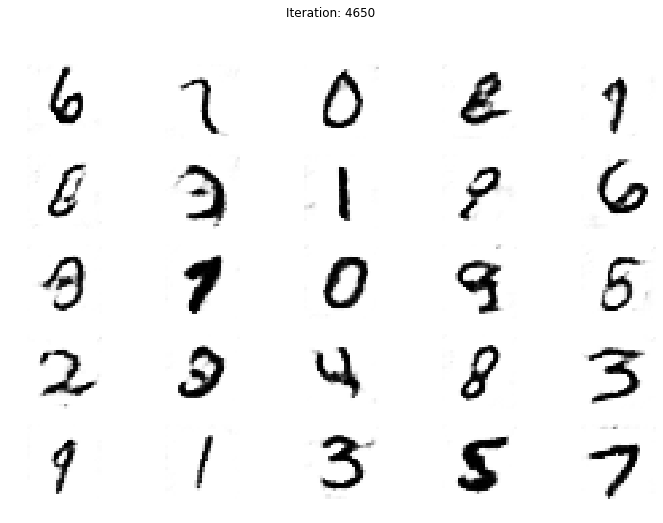

Iteration:  4651 [D loss: 0.70026, acc.:  51.17%] [G loss: 0.82457]
Iteration:  4652 [D loss: 0.70146, acc.:  52.34%] [G loss: 0.77773]
Iteration:  4653 [D loss: 0.71111, acc.:  55.47%] [G loss: 0.72372]
Iteration:  4654 [D loss: 0.71305, acc.:  48.44%] [G loss: 0.75356]
Iteration:  4655 [D loss: 0.70315, acc.:  52.34%] [G loss: 0.76149]
Iteration:  4656 [D loss: 0.71716, acc.:  49.22%] [G loss: 0.82045]
Iteration:  4657 [D loss: 0.68197, acc.:  51.95%] [G loss: 0.82687]
Iteration:  4658 [D loss: 0.71420, acc.:  45.70%] [G loss: 0.77693]
Iteration:  4659 [D loss: 0.67058, acc.:  55.86%] [G loss: 0.78787]
Iteration:  4660 [D loss: 0.70595, acc.:  51.17%] [G loss: 0.78520]
Iteration:  4661 [D loss: 0.69750, acc.:  50.00%] [G loss: 0.77235]
Iteration:  4662 [D loss: 0.72083, acc.:  46.48%] [G loss: 0.76290]
Iteration:  4663 [D loss: 0.70867, acc.:  50.00%] [G loss: 0.77573]
Iteration:  4664 [D loss: 0.70977, acc.:  51.95%] [G loss: 0.77775]
Iteration:  4665 [D loss: 0.73061, acc.:  44.14%

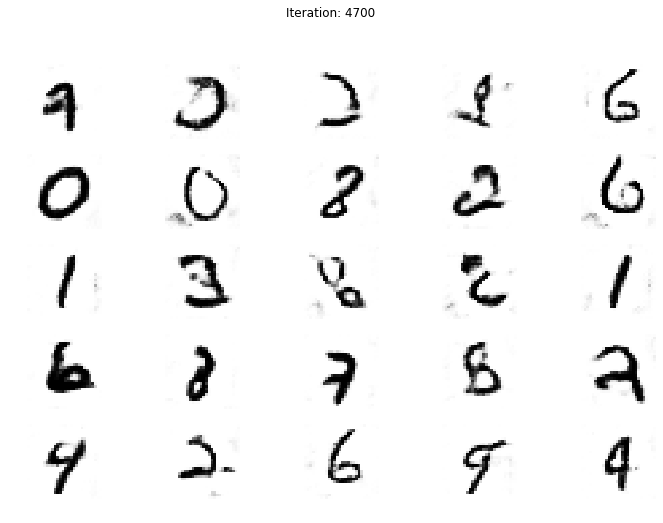

Iteration:  4701 [D loss: 0.70157, acc.:  54.30%] [G loss: 0.79456]
Iteration:  4702 [D loss: 0.70188, acc.:  49.61%] [G loss: 0.76421]
Iteration:  4703 [D loss: 0.70936, acc.:  49.61%] [G loss: 0.80996]
Iteration:  4704 [D loss: 0.69840, acc.:  49.61%] [G loss: 0.77818]
Iteration:  4705 [D loss: 0.71942, acc.:  47.66%] [G loss: 0.80499]
Iteration:  4706 [D loss: 0.70052, acc.:  53.12%] [G loss: 0.78602]
Iteration:  4707 [D loss: 0.69651, acc.:  54.30%] [G loss: 0.78937]
Iteration:  4708 [D loss: 0.68469, acc.:  52.73%] [G loss: 0.76107]
Iteration:  4709 [D loss: 0.71916, acc.:  48.05%] [G loss: 0.76688]
Iteration:  4710 [D loss: 0.71116, acc.:  49.22%] [G loss: 0.79846]
Iteration:  4711 [D loss: 0.70250, acc.:  51.17%] [G loss: 0.82677]
Iteration:  4712 [D loss: 0.72501, acc.:  50.00%] [G loss: 0.80665]
Iteration:  4713 [D loss: 0.72160, acc.:  47.27%] [G loss: 0.77060]
Iteration:  4714 [D loss: 0.69416, acc.:  53.12%] [G loss: 0.74703]
Iteration:  4715 [D loss: 0.69474, acc.:  54.69%

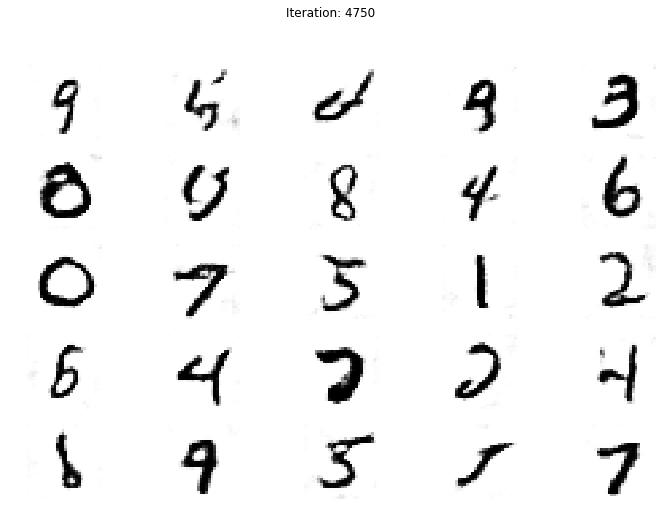

Iteration:  4751 [D loss: 0.68744, acc.:  55.47%] [G loss: 0.79948]
Iteration:  4752 [D loss: 0.70113, acc.:  54.69%] [G loss: 0.79349]
Iteration:  4753 [D loss: 0.69264, acc.:  54.30%] [G loss: 0.78496]
Iteration:  4754 [D loss: 0.69824, acc.:  53.12%] [G loss: 0.79282]
Iteration:  4755 [D loss: 0.71526, acc.:  52.73%] [G loss: 0.76757]
Iteration:  4756 [D loss: 0.67909, acc.:  57.42%] [G loss: 0.78840]
Iteration:  4757 [D loss: 0.71377, acc.:  49.22%] [G loss: 0.81651]
Iteration:  4758 [D loss: 0.71446, acc.:  52.73%] [G loss: 0.74986]
Iteration:  4759 [D loss: 0.71180, acc.:  50.00%] [G loss: 0.81431]
Iteration:  4760 [D loss: 0.69918, acc.:  56.64%] [G loss: 0.77822]
Iteration:  4761 [D loss: 0.72920, acc.:  45.70%] [G loss: 0.75538]
Iteration:  4762 [D loss: 0.70188, acc.:  52.73%] [G loss: 0.75873]
Iteration:  4763 [D loss: 0.71000, acc.:  50.78%] [G loss: 0.78270]
Iteration:  4764 [D loss: 0.73574, acc.:  41.02%] [G loss: 0.78178]
Iteration:  4765 [D loss: 0.68844, acc.:  55.47%

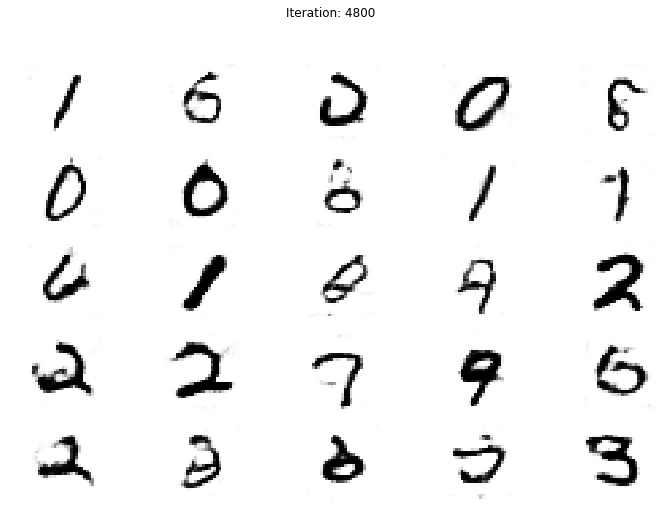

Iteration:  4801 [D loss: 0.70279, acc.:  50.78%] [G loss: 0.75543]
Iteration:  4802 [D loss: 0.71665, acc.:  51.17%] [G loss: 0.75831]
Iteration:  4803 [D loss: 0.68345, acc.:  55.47%] [G loss: 0.74876]
Iteration:  4804 [D loss: 0.69553, acc.:  53.52%] [G loss: 0.76469]
Iteration:  4805 [D loss: 0.70622, acc.:  55.08%] [G loss: 0.75645]
Iteration:  4806 [D loss: 0.71727, acc.:  46.48%] [G loss: 0.76915]
Iteration:  4807 [D loss: 0.71949, acc.:  47.66%] [G loss: 0.74669]
Iteration:  4808 [D loss: 0.73137, acc.:  44.14%] [G loss: 0.72491]
Iteration:  4809 [D loss: 0.69437, acc.:  52.73%] [G loss: 0.74963]
Iteration:  4810 [D loss: 0.70959, acc.:  53.91%] [G loss: 0.78529]
Iteration:  4811 [D loss: 0.72069, acc.:  48.05%] [G loss: 0.77010]
Iteration:  4812 [D loss: 0.72611, acc.:  45.31%] [G loss: 0.79251]
Iteration:  4813 [D loss: 0.68924, acc.:  54.69%] [G loss: 0.79484]
Iteration:  4814 [D loss: 0.71531, acc.:  48.05%] [G loss: 0.78041]
Iteration:  4815 [D loss: 0.72082, acc.:  49.22%

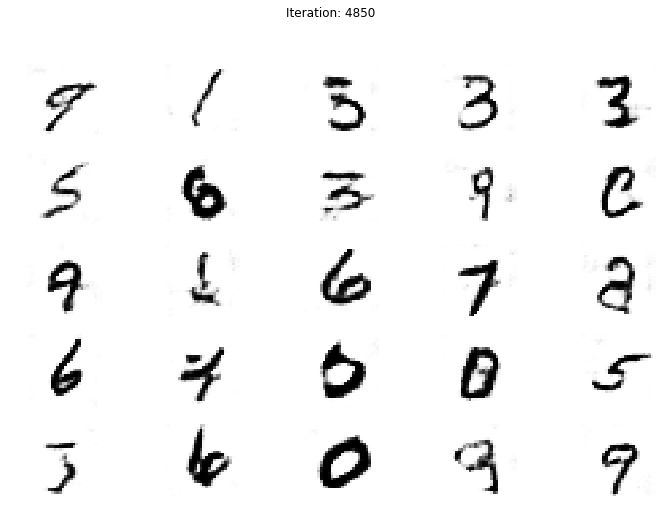

Iteration:  4851 [D loss: 0.71126, acc.:  50.39%] [G loss: 0.76988]
Iteration:  4852 [D loss: 0.72951, acc.:  44.92%] [G loss: 0.76328]
Iteration:  4853 [D loss: 0.70238, acc.:  49.22%] [G loss: 0.79269]
Iteration:  4854 [D loss: 0.69254, acc.:  50.00%] [G loss: 0.78203]
Iteration:  4855 [D loss: 0.71109, acc.:  50.39%] [G loss: 0.78824]
Iteration:  4856 [D loss: 0.71033, acc.:  49.22%] [G loss: 0.80569]
Iteration:  4857 [D loss: 0.70194, acc.:  55.86%] [G loss: 0.82232]
Iteration:  4858 [D loss: 0.69329, acc.:  55.08%] [G loss: 0.80077]
Iteration:  4859 [D loss: 0.71507, acc.:  45.31%] [G loss: 0.75730]
Iteration:  4860 [D loss: 0.72197, acc.:  46.88%] [G loss: 0.78252]
Iteration:  4861 [D loss: 0.70407, acc.:  51.17%] [G loss: 0.74278]
Iteration:  4862 [D loss: 0.70789, acc.:  46.09%] [G loss: 0.77241]
Iteration:  4863 [D loss: 0.71346, acc.:  49.61%] [G loss: 0.79434]
Iteration:  4864 [D loss: 0.68790, acc.:  54.30%] [G loss: 0.78166]
Iteration:  4865 [D loss: 0.71015, acc.:  46.48%

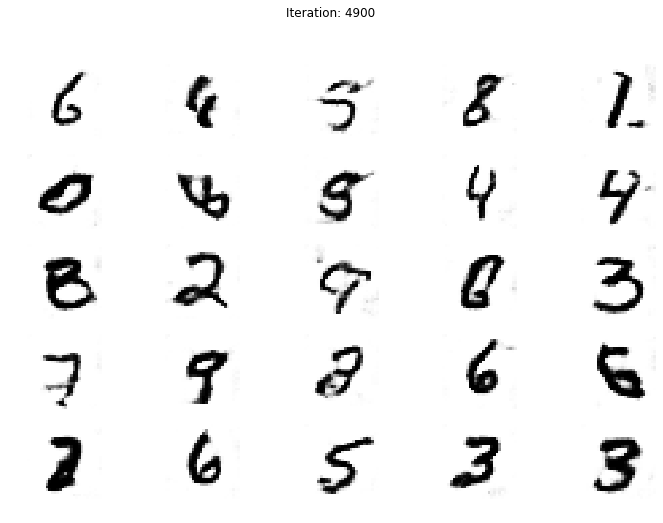

Iteration:  4901 [D loss: 0.72054, acc.:  50.00%] [G loss: 0.75620]
Iteration:  4902 [D loss: 0.69199, acc.:  51.95%] [G loss: 0.80068]
Iteration:  4903 [D loss: 0.68532, acc.:  53.91%] [G loss: 0.77430]
Iteration:  4904 [D loss: 0.74587, acc.:  41.41%] [G loss: 0.76331]
Iteration:  4905 [D loss: 0.71260, acc.:  52.34%] [G loss: 0.76022]
Iteration:  4906 [D loss: 0.70100, acc.:  52.73%] [G loss: 0.73302]
Iteration:  4907 [D loss: 0.68590, acc.:  52.34%] [G loss: 0.81235]
Iteration:  4908 [D loss: 0.71490, acc.:  50.78%] [G loss: 0.78798]
Iteration:  4909 [D loss: 0.73436, acc.:  45.31%] [G loss: 0.77460]
Iteration:  4910 [D loss: 0.72403, acc.:  49.22%] [G loss: 0.78356]
Iteration:  4911 [D loss: 0.71659, acc.:  48.44%] [G loss: 0.79542]
Iteration:  4912 [D loss: 0.67327, acc.:  58.59%] [G loss: 0.77945]
Iteration:  4913 [D loss: 0.70770, acc.:  50.00%] [G loss: 0.76015]
Iteration:  4914 [D loss: 0.71571, acc.:  46.48%] [G loss: 0.75321]
Iteration:  4915 [D loss: 0.69883, acc.:  50.00%

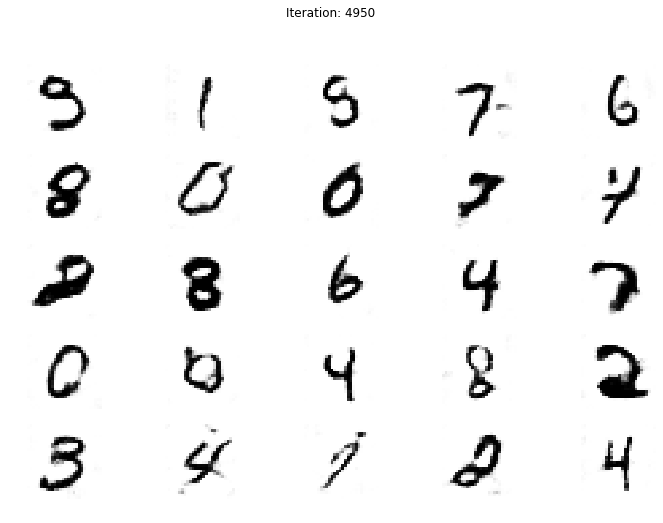

Iteration:  4951 [D loss: 0.72507, acc.:  48.83%] [G loss: 0.74381]
Iteration:  4952 [D loss: 0.69472, acc.:  51.56%] [G loss: 0.74714]
Iteration:  4953 [D loss: 0.69732, acc.:  57.03%] [G loss: 0.76236]
Iteration:  4954 [D loss: 0.70733, acc.:  49.61%] [G loss: 0.78297]
Iteration:  4955 [D loss: 0.70811, acc.:  52.34%] [G loss: 0.79677]
Iteration:  4956 [D loss: 0.73290, acc.:  42.97%] [G loss: 0.77369]
Iteration:  4957 [D loss: 0.70677, acc.:  51.17%] [G loss: 0.78403]
Iteration:  4958 [D loss: 0.69609, acc.:  53.12%] [G loss: 0.78755]
Iteration:  4959 [D loss: 0.70659, acc.:  51.56%] [G loss: 0.78616]
Iteration:  4960 [D loss: 0.69814, acc.:  53.91%] [G loss: 0.79048]
Iteration:  4961 [D loss: 0.72685, acc.:  46.09%] [G loss: 0.80206]
Iteration:  4962 [D loss: 0.69943, acc.:  51.56%] [G loss: 0.75407]
Iteration:  4963 [D loss: 0.72315, acc.:  45.31%] [G loss: 0.78957]
Iteration:  4964 [D loss: 0.71215, acc.:  51.17%] [G loss: 0.73383]
Iteration:  4965 [D loss: 0.69794, acc.:  51.17%

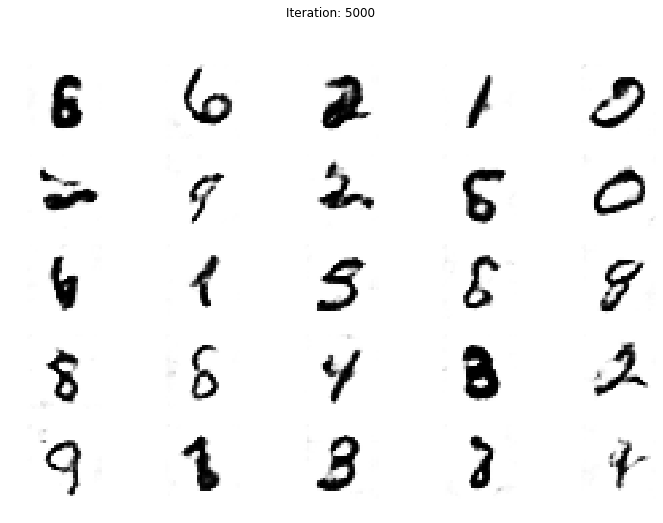

Iteration:  5001 [D loss: 0.70938, acc.:  51.56%] [G loss: 0.78682]
Iteration:  5002 [D loss: 0.71392, acc.:  48.83%] [G loss: 0.75469]
Iteration:  5003 [D loss: 0.73059, acc.:  48.44%] [G loss: 0.77700]
Iteration:  5004 [D loss: 0.71996, acc.:  48.05%] [G loss: 0.75811]
Iteration:  5005 [D loss: 0.70053, acc.:  50.39%] [G loss: 0.77266]
Iteration:  5006 [D loss: 0.70455, acc.:  48.05%] [G loss: 0.75757]
Iteration:  5007 [D loss: 0.70395, acc.:  53.12%] [G loss: 0.78406]
Iteration:  5008 [D loss: 0.70938, acc.:  49.61%] [G loss: 0.76153]
Iteration:  5009 [D loss: 0.73312, acc.:  42.19%] [G loss: 0.78050]
Iteration:  5010 [D loss: 0.71670, acc.:  49.22%] [G loss: 0.76350]
Iteration:  5011 [D loss: 0.70305, acc.:  51.17%] [G loss: 0.78818]
Iteration:  5012 [D loss: 0.69892, acc.:  52.73%] [G loss: 0.78594]
Iteration:  5013 [D loss: 0.68541, acc.:  52.34%] [G loss: 0.82600]
Iteration:  5014 [D loss: 0.70294, acc.:  50.00%] [G loss: 0.77830]
Iteration:  5015 [D loss: 0.70688, acc.:  51.17%

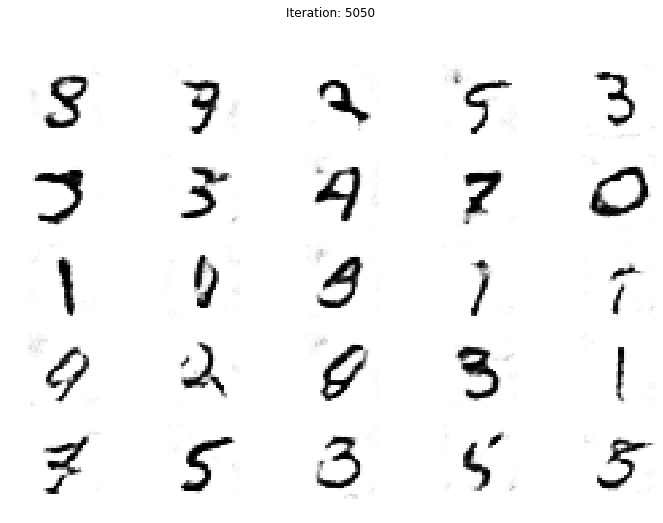

Iteration:  5051 [D loss: 0.68406, acc.:  53.12%] [G loss: 0.78705]
Iteration:  5052 [D loss: 0.71168, acc.:  48.44%] [G loss: 0.79382]
Iteration:  5053 [D loss: 0.70775, acc.:  50.78%] [G loss: 0.77041]
Iteration:  5054 [D loss: 0.69213, acc.:  56.25%] [G loss: 0.75082]
Iteration:  5055 [D loss: 0.71826, acc.:  48.83%] [G loss: 0.77341]
Iteration:  5056 [D loss: 0.69584, acc.:  51.56%] [G loss: 0.75772]
Iteration:  5057 [D loss: 0.72584, acc.:  48.05%] [G loss: 0.76345]
Iteration:  5058 [D loss: 0.70435, acc.:  50.39%] [G loss: 0.80700]
Iteration:  5059 [D loss: 0.72981, acc.:  46.88%] [G loss: 0.77237]
Iteration:  5060 [D loss: 0.69872, acc.:  53.12%] [G loss: 0.77103]
Iteration:  5061 [D loss: 0.72953, acc.:  47.66%] [G loss: 0.78084]
Iteration:  5062 [D loss: 0.71622, acc.:  46.48%] [G loss: 0.77348]
Iteration:  5063 [D loss: 0.69042, acc.:  53.91%] [G loss: 0.80104]
Iteration:  5064 [D loss: 0.69913, acc.:  52.34%] [G loss: 0.74982]
Iteration:  5065 [D loss: 0.70150, acc.:  50.00%

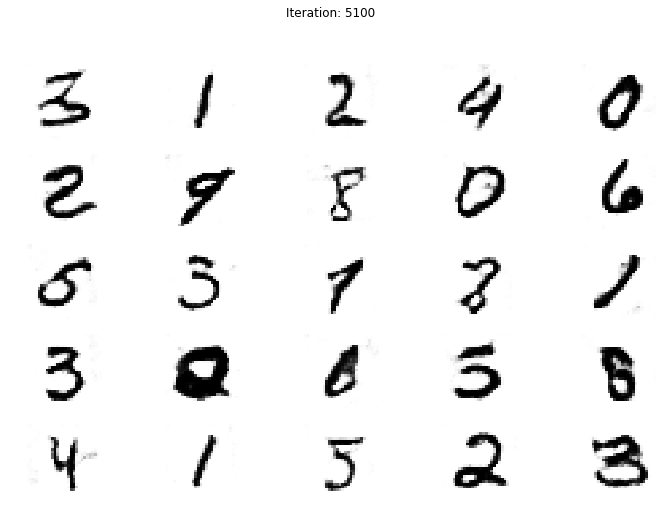

Iteration:  5101 [D loss: 0.72311, acc.:  45.31%] [G loss: 0.80069]
Iteration:  5102 [D loss: 0.69843, acc.:  52.34%] [G loss: 0.81662]
Iteration:  5103 [D loss: 0.70461, acc.:  47.27%] [G loss: 0.78092]
Iteration:  5104 [D loss: 0.69205, acc.:  53.12%] [G loss: 0.76512]
Iteration:  5105 [D loss: 0.69950, acc.:  50.78%] [G loss: 0.78344]
Iteration:  5106 [D loss: 0.70434, acc.:  48.83%] [G loss: 0.78175]
Iteration:  5107 [D loss: 0.72180, acc.:  48.83%] [G loss: 0.77228]
Iteration:  5108 [D loss: 0.70486, acc.:  51.95%] [G loss: 0.74948]
Iteration:  5109 [D loss: 0.68880, acc.:  53.52%] [G loss: 0.81117]
Iteration:  5110 [D loss: 0.72455, acc.:  50.00%] [G loss: 0.76465]
Iteration:  5111 [D loss: 0.70798, acc.:  49.22%] [G loss: 0.77659]
Iteration:  5112 [D loss: 0.71291, acc.:  51.56%] [G loss: 0.74212]
Iteration:  5113 [D loss: 0.70141, acc.:  51.95%] [G loss: 0.75563]
Iteration:  5114 [D loss: 0.73132, acc.:  46.09%] [G loss: 0.77777]
Iteration:  5115 [D loss: 0.71413, acc.:  47.66%

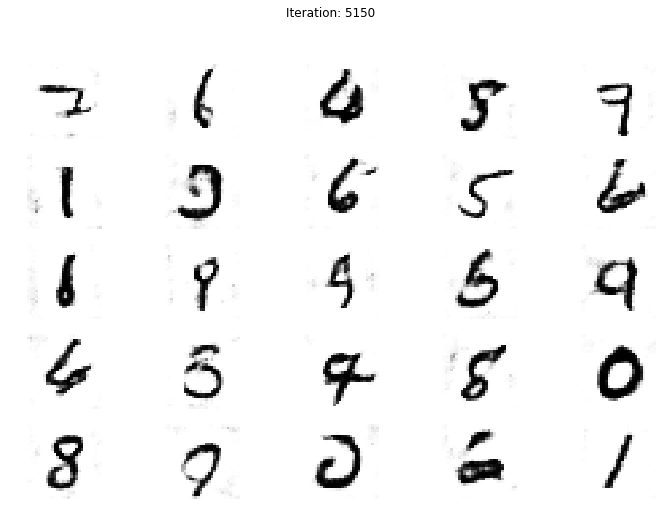

Iteration:  5151 [D loss: 0.72823, acc.:  45.31%] [G loss: 0.78405]
Iteration:  5152 [D loss: 0.70063, acc.:  49.61%] [G loss: 0.78307]
Iteration:  5153 [D loss: 0.72714, acc.:  50.00%] [G loss: 0.79206]
Iteration:  5154 [D loss: 0.73381, acc.:  42.58%] [G loss: 0.77842]
Iteration:  5155 [D loss: 0.70739, acc.:  51.95%] [G loss: 0.78475]
Iteration:  5156 [D loss: 0.71840, acc.:  48.83%] [G loss: 0.74384]
Iteration:  5157 [D loss: 0.70940, acc.:  47.27%] [G loss: 0.78449]
Iteration:  5158 [D loss: 0.71000, acc.:  51.17%] [G loss: 0.76310]
Iteration:  5159 [D loss: 0.72276, acc.:  47.66%] [G loss: 0.82143]
Iteration:  5160 [D loss: 0.73519, acc.:  43.36%] [G loss: 0.80565]
Iteration:  5161 [D loss: 0.70549, acc.:  49.22%] [G loss: 0.76765]
Iteration:  5162 [D loss: 0.70984, acc.:  46.88%] [G loss: 0.77661]
Iteration:  5163 [D loss: 0.69191, acc.:  55.47%] [G loss: 0.77886]
Iteration:  5164 [D loss: 0.71183, acc.:  51.56%] [G loss: 0.74103]
Iteration:  5165 [D loss: 0.74091, acc.:  44.53%

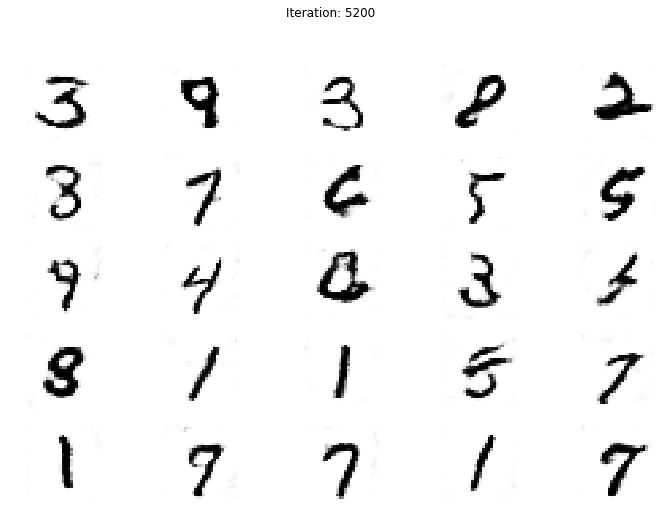

Iteration:  5201 [D loss: 0.70896, acc.:  50.78%] [G loss: 0.75252]
Iteration:  5202 [D loss: 0.70636, acc.:  51.95%] [G loss: 0.77767]
Iteration:  5203 [D loss: 0.67278, acc.:  58.98%] [G loss: 0.77289]
Iteration:  5204 [D loss: 0.70760, acc.:  47.66%] [G loss: 0.75594]
Iteration:  5205 [D loss: 0.69790, acc.:  55.08%] [G loss: 0.78712]
Iteration:  5206 [D loss: 0.71542, acc.:  49.61%] [G loss: 0.77809]
Iteration:  5207 [D loss: 0.69120, acc.:  53.91%] [G loss: 0.75493]
Iteration:  5208 [D loss: 0.72074, acc.:  47.66%] [G loss: 0.75900]
Iteration:  5209 [D loss: 0.68676, acc.:  52.34%] [G loss: 0.75125]
Iteration:  5210 [D loss: 0.71620, acc.:  51.95%] [G loss: 0.78517]
Iteration:  5211 [D loss: 0.71600, acc.:  48.83%] [G loss: 0.75650]
Iteration:  5212 [D loss: 0.71501, acc.:  50.00%] [G loss: 0.76182]
Iteration:  5213 [D loss: 0.71679, acc.:  47.66%] [G loss: 0.77716]
Iteration:  5214 [D loss: 0.72068, acc.:  44.53%] [G loss: 0.78442]
Iteration:  5215 [D loss: 0.69482, acc.:  53.52%

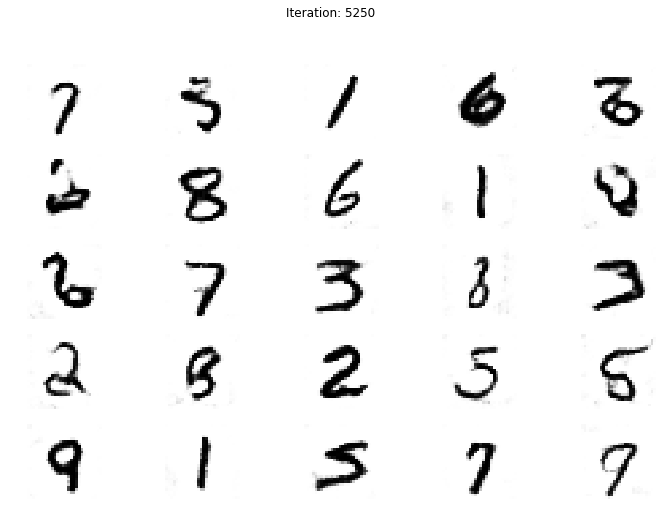

Iteration:  5251 [D loss: 0.68708, acc.:  55.47%] [G loss: 0.76151]
Iteration:  5252 [D loss: 0.72376, acc.:  45.70%] [G loss: 0.76792]
Iteration:  5253 [D loss: 0.71842, acc.:  49.22%] [G loss: 0.76609]
Iteration:  5254 [D loss: 0.70501, acc.:  50.00%] [G loss: 0.75653]
Iteration:  5255 [D loss: 0.73479, acc.:  48.44%] [G loss: 0.77467]
Iteration:  5256 [D loss: 0.67833, acc.:  54.30%] [G loss: 0.77582]
Iteration:  5257 [D loss: 0.70100, acc.:  53.91%] [G loss: 0.76360]
Iteration:  5258 [D loss: 0.71776, acc.:  48.44%] [G loss: 0.77075]
Iteration:  5259 [D loss: 0.70066, acc.:  53.52%] [G loss: 0.74290]
Iteration:  5260 [D loss: 0.70582, acc.:  51.17%] [G loss: 0.78223]
Iteration:  5261 [D loss: 0.71709, acc.:  48.05%] [G loss: 0.75152]
Iteration:  5262 [D loss: 0.70648, acc.:  52.73%] [G loss: 0.77169]
Iteration:  5263 [D loss: 0.70845, acc.:  50.78%] [G loss: 0.72817]
Iteration:  5264 [D loss: 0.69841, acc.:  50.39%] [G loss: 0.77131]
Iteration:  5265 [D loss: 0.72879, acc.:  42.19%

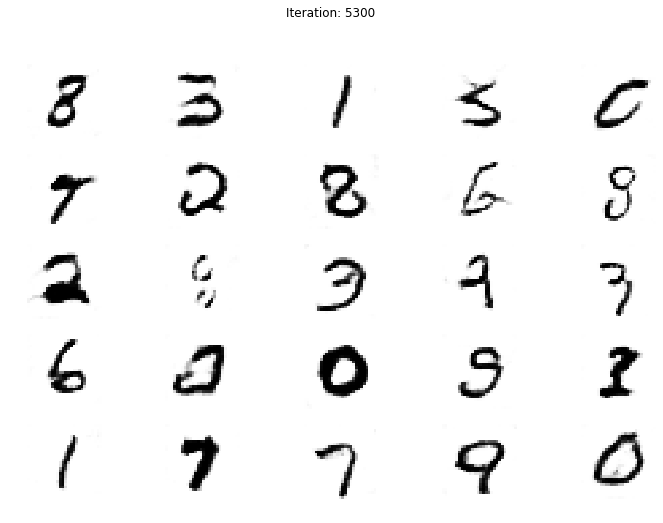

Iteration:  5301 [D loss: 0.70542, acc.:  51.17%] [G loss: 0.77253]
Iteration:  5302 [D loss: 0.71193, acc.:  47.66%] [G loss: 0.79472]
Iteration:  5303 [D loss: 0.72619, acc.:  42.19%] [G loss: 0.74806]
Iteration:  5304 [D loss: 0.70994, acc.:  49.61%] [G loss: 0.78544]
Iteration:  5305 [D loss: 0.71050, acc.:  51.95%] [G loss: 0.79785]
Iteration:  5306 [D loss: 0.72135, acc.:  43.36%] [G loss: 0.78271]
Iteration:  5307 [D loss: 0.70953, acc.:  48.44%] [G loss: 0.75890]
Iteration:  5308 [D loss: 0.71544, acc.:  49.22%] [G loss: 0.80590]
Iteration:  5309 [D loss: 0.71614, acc.:  49.22%] [G loss: 0.79383]
Iteration:  5310 [D loss: 0.71449, acc.:  48.05%] [G loss: 0.79270]
Iteration:  5311 [D loss: 0.70449, acc.:  50.78%] [G loss: 0.76138]
Iteration:  5312 [D loss: 0.70118, acc.:  49.22%] [G loss: 0.78046]
Iteration:  5313 [D loss: 0.70110, acc.:  50.78%] [G loss: 0.80032]
Iteration:  5314 [D loss: 0.69139, acc.:  53.12%] [G loss: 0.77865]
Iteration:  5315 [D loss: 0.70488, acc.:  51.17%

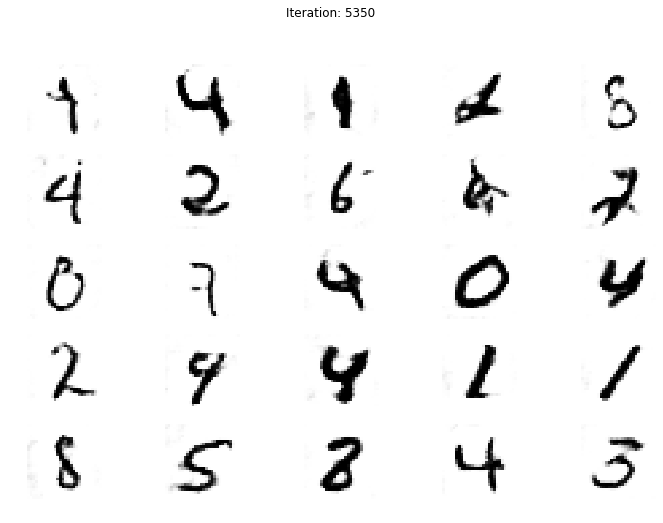

Iteration:  5351 [D loss: 0.71555, acc.:  49.61%] [G loss: 0.78514]
Iteration:  5352 [D loss: 0.71243, acc.:  48.44%] [G loss: 0.76509]
Iteration:  5353 [D loss: 0.69702, acc.:  53.91%] [G loss: 0.78273]
Iteration:  5354 [D loss: 0.73136, acc.:  47.27%] [G loss: 0.76981]
Iteration:  5355 [D loss: 0.72442, acc.:  44.14%] [G loss: 0.75892]
Iteration:  5356 [D loss: 0.70424, acc.:  50.78%] [G loss: 0.75641]
Iteration:  5357 [D loss: 0.72400, acc.:  49.61%] [G loss: 0.75192]
Iteration:  5358 [D loss: 0.68323, acc.:  54.69%] [G loss: 0.75859]
Iteration:  5359 [D loss: 0.68799, acc.:  53.52%] [G loss: 0.77992]
Iteration:  5360 [D loss: 0.71834, acc.:  48.83%] [G loss: 0.82179]
Iteration:  5361 [D loss: 0.74379, acc.:  42.19%] [G loss: 0.80298]
Iteration:  5362 [D loss: 0.69211, acc.:  51.56%] [G loss: 0.77875]
Iteration:  5363 [D loss: 0.69801, acc.:  50.78%] [G loss: 0.80148]
Iteration:  5364 [D loss: 0.74272, acc.:  46.48%] [G loss: 0.75822]
Iteration:  5365 [D loss: 0.70523, acc.:  50.78%

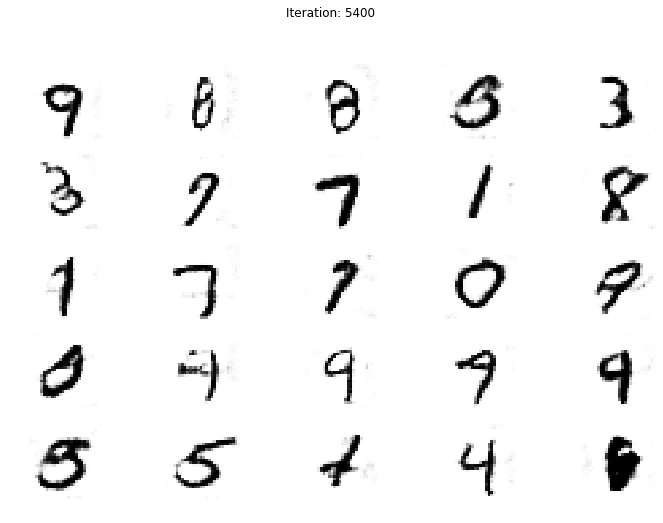

Iteration:  5401 [D loss: 0.70469, acc.:  50.78%] [G loss: 0.76822]
Iteration:  5402 [D loss: 0.71683, acc.:  48.05%] [G loss: 0.77381]
Iteration:  5403 [D loss: 0.71002, acc.:  49.22%] [G loss: 0.72640]
Iteration:  5404 [D loss: 0.70854, acc.:  50.78%] [G loss: 0.77335]
Iteration:  5405 [D loss: 0.71218, acc.:  48.44%] [G loss: 0.75791]
Iteration:  5406 [D loss: 0.70528, acc.:  55.08%] [G loss: 0.75542]
Iteration:  5407 [D loss: 0.68984, acc.:  55.86%] [G loss: 0.75019]
Iteration:  5408 [D loss: 0.70835, acc.:  48.44%] [G loss: 0.76468]
Iteration:  5409 [D loss: 0.69616, acc.:  54.69%] [G loss: 0.78743]
Iteration:  5410 [D loss: 0.71171, acc.:  50.39%] [G loss: 0.77309]
Iteration:  5411 [D loss: 0.68554, acc.:  56.64%] [G loss: 0.75409]
Iteration:  5412 [D loss: 0.71854, acc.:  48.05%] [G loss: 0.75357]
Iteration:  5413 [D loss: 0.70591, acc.:  49.61%] [G loss: 0.78105]
Iteration:  5414 [D loss: 0.70494, acc.:  48.44%] [G loss: 0.79112]
Iteration:  5415 [D loss: 0.71813, acc.:  50.39%

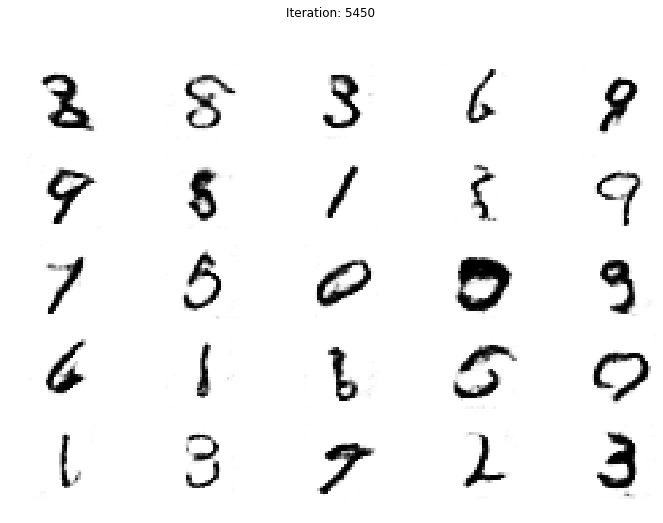

Iteration:  5451 [D loss: 0.70128, acc.:  51.56%] [G loss: 0.78511]
Iteration:  5452 [D loss: 0.68608, acc.:  57.03%] [G loss: 0.79850]
Iteration:  5453 [D loss: 0.71493, acc.:  51.17%] [G loss: 0.78989]
Iteration:  5454 [D loss: 0.70439, acc.:  50.39%] [G loss: 0.76109]
Iteration:  5455 [D loss: 0.71219, acc.:  49.61%] [G loss: 0.78851]
Iteration:  5456 [D loss: 0.71298, acc.:  50.78%] [G loss: 0.78317]
Iteration:  5457 [D loss: 0.69475, acc.:  53.91%] [G loss: 0.76392]
Iteration:  5458 [D loss: 0.71426, acc.:  49.61%] [G loss: 0.78126]
Iteration:  5459 [D loss: 0.70346, acc.:  48.44%] [G loss: 0.79939]
Iteration:  5460 [D loss: 0.69991, acc.:  52.34%] [G loss: 0.78222]
Iteration:  5461 [D loss: 0.69877, acc.:  52.73%] [G loss: 0.74543]
Iteration:  5462 [D loss: 0.70452, acc.:  50.00%] [G loss: 0.75521]
Iteration:  5463 [D loss: 0.72514, acc.:  46.88%] [G loss: 0.74542]
Iteration:  5464 [D loss: 0.71826, acc.:  46.48%] [G loss: 0.74480]
Iteration:  5465 [D loss: 0.71638, acc.:  45.31%

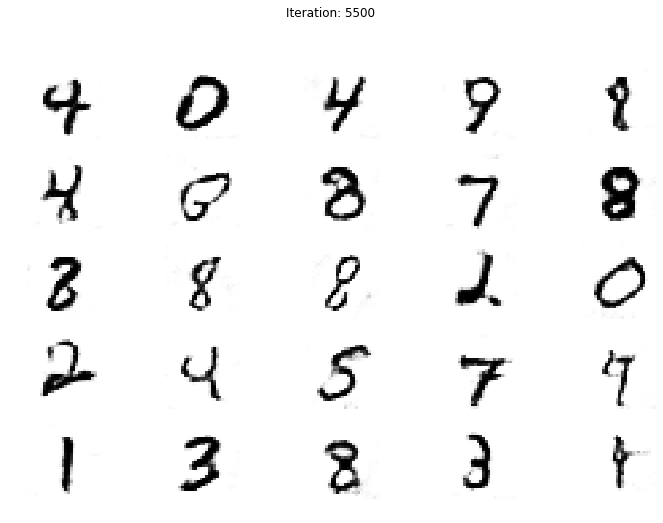

Iteration:  5501 [D loss: 0.67867, acc.:  56.25%] [G loss: 0.80413]
Iteration:  5502 [D loss: 0.70278, acc.:  51.17%] [G loss: 0.78263]
Iteration:  5503 [D loss: 0.70874, acc.:  49.22%] [G loss: 0.83569]
Iteration:  5504 [D loss: 0.70817, acc.:  49.61%] [G loss: 0.78326]
Iteration:  5505 [D loss: 0.71000, acc.:  49.61%] [G loss: 0.76570]
Iteration:  5506 [D loss: 0.70707, acc.:  46.09%] [G loss: 0.77608]
Iteration:  5507 [D loss: 0.72685, acc.:  46.48%] [G loss: 0.76010]
Iteration:  5508 [D loss: 0.72009, acc.:  44.92%] [G loss: 0.78796]
Iteration:  5509 [D loss: 0.67754, acc.:  54.30%] [G loss: 0.78412]
Iteration:  5510 [D loss: 0.70122, acc.:  48.44%] [G loss: 0.80404]
Iteration:  5511 [D loss: 0.71025, acc.:  51.17%] [G loss: 0.74222]
Iteration:  5512 [D loss: 0.69621, acc.:  55.86%] [G loss: 0.76912]
Iteration:  5513 [D loss: 0.72953, acc.:  47.27%] [G loss: 0.78814]
Iteration:  5514 [D loss: 0.71014, acc.:  50.00%] [G loss: 0.75884]
Iteration:  5515 [D loss: 0.70609, acc.:  50.00%

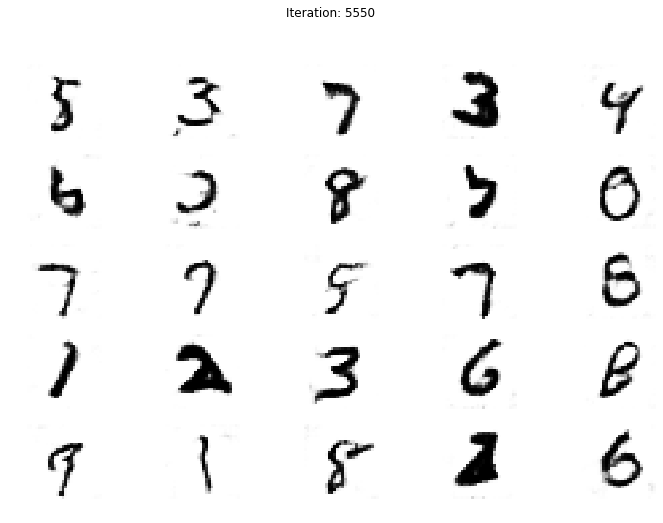

Iteration:  5551 [D loss: 0.69873, acc.:  53.52%] [G loss: 0.74495]
Iteration:  5552 [D loss: 0.71489, acc.:  48.83%] [G loss: 0.74612]
Iteration:  5553 [D loss: 0.71821, acc.:  49.22%] [G loss: 0.75718]
Iteration:  5554 [D loss: 0.71196, acc.:  49.22%] [G loss: 0.77228]
Iteration:  5555 [D loss: 0.68502, acc.:  56.25%] [G loss: 0.82139]
Iteration:  5556 [D loss: 0.73413, acc.:  45.31%] [G loss: 0.78247]
Iteration:  5557 [D loss: 0.70563, acc.:  49.61%] [G loss: 0.77004]
Iteration:  5558 [D loss: 0.71317, acc.:  46.09%] [G loss: 0.76835]
Iteration:  5559 [D loss: 0.70732, acc.:  48.83%] [G loss: 0.75991]
Iteration:  5560 [D loss: 0.71216, acc.:  50.00%] [G loss: 0.78645]
Iteration:  5561 [D loss: 0.72933, acc.:  45.70%] [G loss: 0.75508]
Iteration:  5562 [D loss: 0.72910, acc.:  48.44%] [G loss: 0.80926]
Iteration:  5563 [D loss: 0.69099, acc.:  53.91%] [G loss: 0.76261]
Iteration:  5564 [D loss: 0.69268, acc.:  54.30%] [G loss: 0.76256]
Iteration:  5565 [D loss: 0.72031, acc.:  46.88%

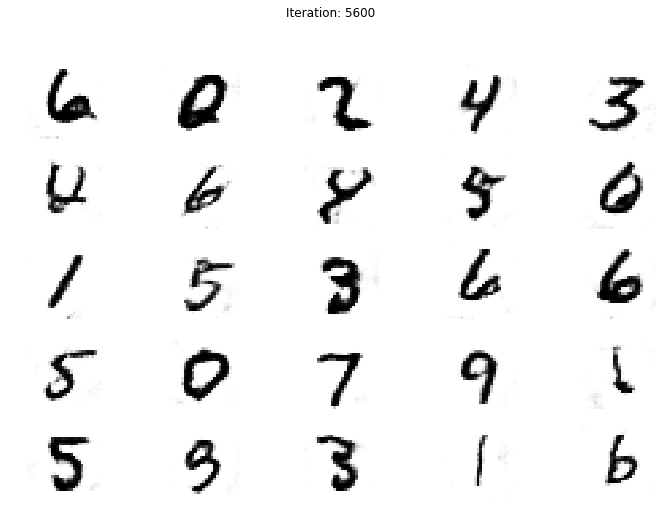

Iteration:  5601 [D loss: 0.69002, acc.:  55.08%] [G loss: 0.77727]
Iteration:  5602 [D loss: 0.72066, acc.:  48.05%] [G loss: 0.80734]
Iteration:  5603 [D loss: 0.70989, acc.:  50.00%] [G loss: 0.80385]
Iteration:  5604 [D loss: 0.71616, acc.:  50.00%] [G loss: 0.78824]
Iteration:  5605 [D loss: 0.68868, acc.:  54.69%] [G loss: 0.79526]
Iteration:  5606 [D loss: 0.69311, acc.:  51.95%] [G loss: 0.80953]
Iteration:  5607 [D loss: 0.72492, acc.:  49.61%] [G loss: 0.81548]
Iteration:  5608 [D loss: 0.69508, acc.:  53.12%] [G loss: 0.76213]
Iteration:  5609 [D loss: 0.68289, acc.:  58.20%] [G loss: 0.77971]
Iteration:  5610 [D loss: 0.71295, acc.:  46.09%] [G loss: 0.74771]
Iteration:  5611 [D loss: 0.73497, acc.:  43.36%] [G loss: 0.75516]
Iteration:  5612 [D loss: 0.71037, acc.:  51.17%] [G loss: 0.76026]
Iteration:  5613 [D loss: 0.71100, acc.:  46.88%] [G loss: 0.77683]
Iteration:  5614 [D loss: 0.69782, acc.:  50.00%] [G loss: 0.74097]
Iteration:  5615 [D loss: 0.71257, acc.:  52.73%

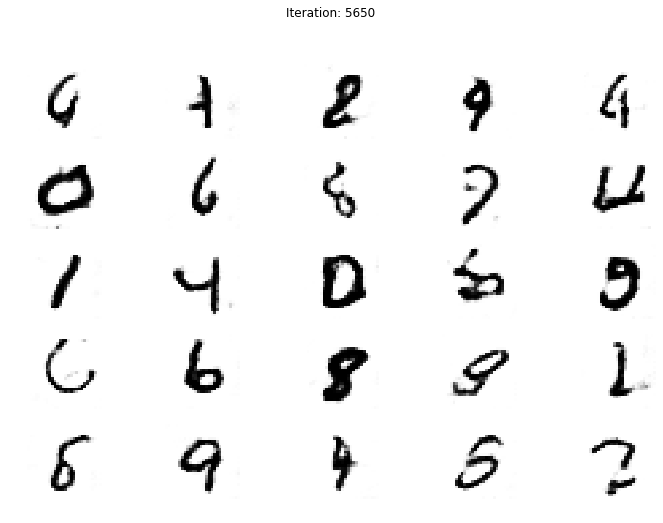

Iteration:  5651 [D loss: 0.70205, acc.:  52.73%] [G loss: 0.77560]
Iteration:  5652 [D loss: 0.72758, acc.:  45.31%] [G loss: 0.76525]
Iteration:  5653 [D loss: 0.70954, acc.:  48.44%] [G loss: 0.74561]
Iteration:  5654 [D loss: 0.69678, acc.:  52.34%] [G loss: 0.76562]
Iteration:  5655 [D loss: 0.69805, acc.:  52.34%] [G loss: 0.77151]
Iteration:  5656 [D loss: 0.69329, acc.:  54.30%] [G loss: 0.75770]
Iteration:  5657 [D loss: 0.69161, acc.:  53.12%] [G loss: 0.75981]
Iteration:  5658 [D loss: 0.72687, acc.:  46.48%] [G loss: 0.72234]
Iteration:  5659 [D loss: 0.71021, acc.:  53.91%] [G loss: 0.79319]
Iteration:  5660 [D loss: 0.73217, acc.:  46.88%] [G loss: 0.75978]
Iteration:  5661 [D loss: 0.70394, acc.:  48.44%] [G loss: 0.78588]
Iteration:  5662 [D loss: 0.69538, acc.:  51.17%] [G loss: 0.78000]
Iteration:  5663 [D loss: 0.73134, acc.:  46.09%] [G loss: 0.76731]
Iteration:  5664 [D loss: 0.70476, acc.:  49.22%] [G loss: 0.75403]
Iteration:  5665 [D loss: 0.70882, acc.:  50.39%

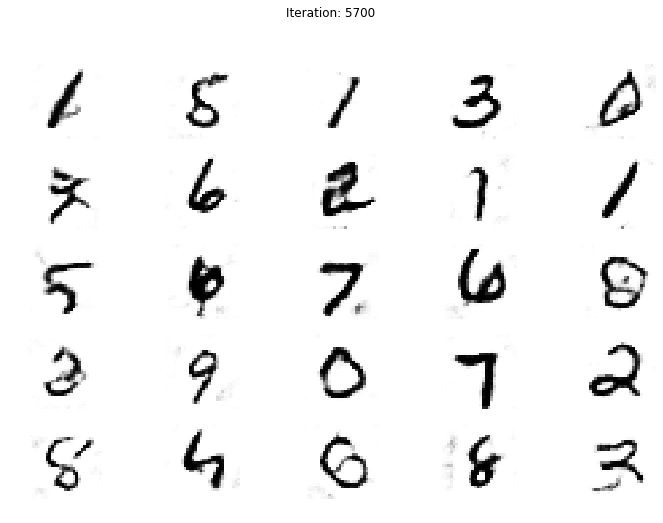

Iteration:  5701 [D loss: 0.72050, acc.:  49.61%] [G loss: 0.80275]
Iteration:  5702 [D loss: 0.67688, acc.:  58.98%] [G loss: 0.77408]
Iteration:  5703 [D loss: 0.71556, acc.:  46.88%] [G loss: 0.78133]
Iteration:  5704 [D loss: 0.70704, acc.:  49.22%] [G loss: 0.77698]
Iteration:  5705 [D loss: 0.69099, acc.:  53.12%] [G loss: 0.73960]
Iteration:  5706 [D loss: 0.71382, acc.:  47.27%] [G loss: 0.77943]
Iteration:  5707 [D loss: 0.71445, acc.:  48.83%] [G loss: 0.74779]
Iteration:  5708 [D loss: 0.70834, acc.:  51.56%] [G loss: 0.76489]
Iteration:  5709 [D loss: 0.69718, acc.:  48.44%] [G loss: 0.79010]
Iteration:  5710 [D loss: 0.69662, acc.:  50.78%] [G loss: 0.75798]
Iteration:  5711 [D loss: 0.71573, acc.:  49.22%] [G loss: 0.74691]
Iteration:  5712 [D loss: 0.70114, acc.:  51.17%] [G loss: 0.76328]
Iteration:  5713 [D loss: 0.73139, acc.:  43.75%] [G loss: 0.78040]
Iteration:  5714 [D loss: 0.70380, acc.:  49.22%] [G loss: 0.76599]
Iteration:  5715 [D loss: 0.72203, acc.:  47.27%

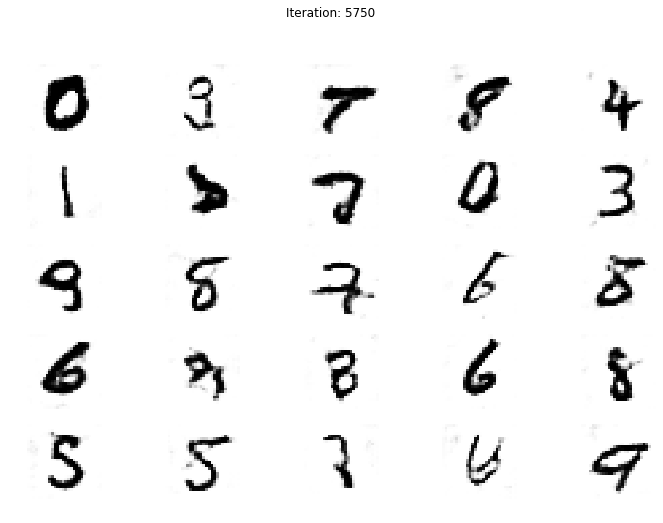

Iteration:  5751 [D loss: 0.68712, acc.:  53.52%] [G loss: 0.77857]
Iteration:  5752 [D loss: 0.68887, acc.:  53.52%] [G loss: 0.78243]
Iteration:  5753 [D loss: 0.69654, acc.:  51.95%] [G loss: 0.76484]
Iteration:  5754 [D loss: 0.70671, acc.:  52.34%] [G loss: 0.76216]
Iteration:  5755 [D loss: 0.71723, acc.:  46.88%] [G loss: 0.75367]
Iteration:  5756 [D loss: 0.71507, acc.:  45.31%] [G loss: 0.74746]
Iteration:  5757 [D loss: 0.70379, acc.:  54.30%] [G loss: 0.74720]
Iteration:  5758 [D loss: 0.69370, acc.:  54.69%] [G loss: 0.75416]
Iteration:  5759 [D loss: 0.71888, acc.:  46.09%] [G loss: 0.78290]
Iteration:  5760 [D loss: 0.68322, acc.:  55.86%] [G loss: 0.78310]
Iteration:  5761 [D loss: 0.70243, acc.:  55.47%] [G loss: 0.81284]
Iteration:  5762 [D loss: 0.70284, acc.:  50.78%] [G loss: 0.78690]
Iteration:  5763 [D loss: 0.69880, acc.:  50.78%] [G loss: 0.77699]
Iteration:  5764 [D loss: 0.70821, acc.:  50.78%] [G loss: 0.74884]
Iteration:  5765 [D loss: 0.67550, acc.:  58.98%

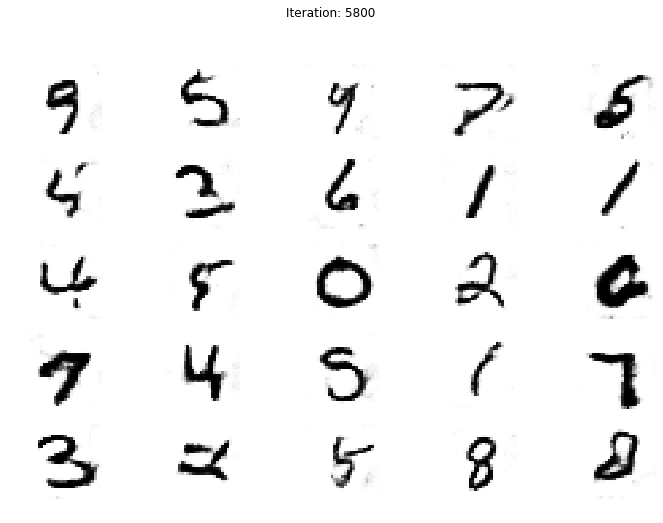

Iteration:  5801 [D loss: 0.68255, acc.:  56.25%] [G loss: 0.78249]
Iteration:  5802 [D loss: 0.71758, acc.:  48.83%] [G loss: 0.76447]
Iteration:  5803 [D loss: 0.70064, acc.:  55.86%] [G loss: 0.75789]
Iteration:  5804 [D loss: 0.70369, acc.:  52.73%] [G loss: 0.78618]
Iteration:  5805 [D loss: 0.71140, acc.:  51.17%] [G loss: 0.72956]
Iteration:  5806 [D loss: 0.70147, acc.:  49.61%] [G loss: 0.78821]
Iteration:  5807 [D loss: 0.71048, acc.:  52.34%] [G loss: 0.75754]
Iteration:  5808 [D loss: 0.71231, acc.:  46.09%] [G loss: 0.75126]
Iteration:  5809 [D loss: 0.73435, acc.:  41.02%] [G loss: 0.76296]
Iteration:  5810 [D loss: 0.73736, acc.:  44.53%] [G loss: 0.74952]
Iteration:  5811 [D loss: 0.71055, acc.:  49.22%] [G loss: 0.77951]
Iteration:  5812 [D loss: 0.69662, acc.:  49.61%] [G loss: 0.74885]
Iteration:  5813 [D loss: 0.70302, acc.:  52.34%] [G loss: 0.79211]
Iteration:  5814 [D loss: 0.71556, acc.:  48.83%] [G loss: 0.76450]
Iteration:  5815 [D loss: 0.70588, acc.:  50.39%

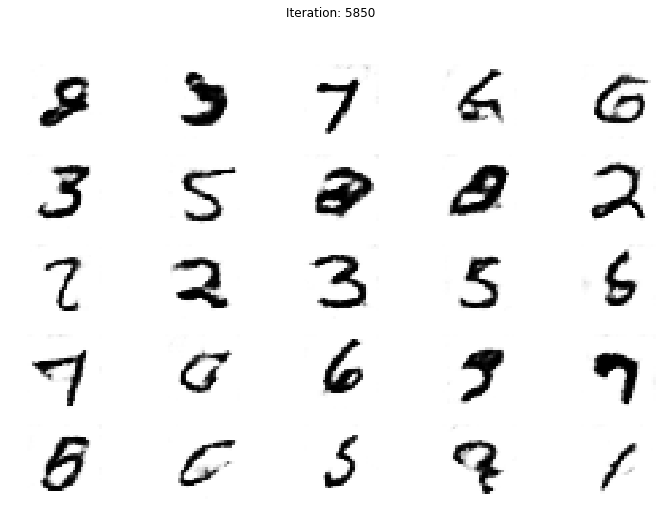

Iteration:  5851 [D loss: 0.72279, acc.:  47.66%] [G loss: 0.76290]
Iteration:  5852 [D loss: 0.70206, acc.:  50.39%] [G loss: 0.77211]
Iteration:  5853 [D loss: 0.69960, acc.:  52.34%] [G loss: 0.76358]
Iteration:  5854 [D loss: 0.73759, acc.:  41.41%] [G loss: 0.72996]
Iteration:  5855 [D loss: 0.67673, acc.:  53.12%] [G loss: 0.77282]
Iteration:  5856 [D loss: 0.71141, acc.:  50.39%] [G loss: 0.81458]
Iteration:  5857 [D loss: 0.71291, acc.:  49.61%] [G loss: 0.75968]
Iteration:  5858 [D loss: 0.71921, acc.:  48.44%] [G loss: 0.79986]
Iteration:  5859 [D loss: 0.70913, acc.:  46.48%] [G loss: 0.74972]
Iteration:  5860 [D loss: 0.69243, acc.:  51.95%] [G loss: 0.78261]
Iteration:  5861 [D loss: 0.68575, acc.:  55.86%] [G loss: 0.75846]
Iteration:  5862 [D loss: 0.71597, acc.:  49.61%] [G loss: 0.76724]
Iteration:  5863 [D loss: 0.71399, acc.:  47.27%] [G loss: 0.78623]
Iteration:  5864 [D loss: 0.70256, acc.:  51.56%] [G loss: 0.77110]
Iteration:  5865 [D loss: 0.70102, acc.:  51.95%

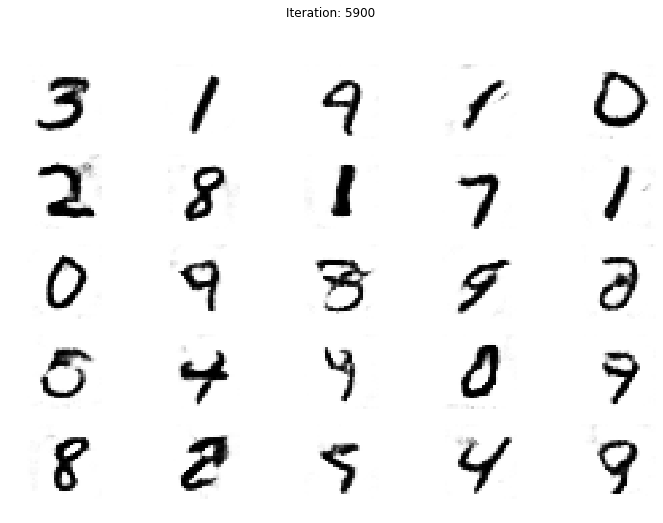

Iteration:  5901 [D loss: 0.69789, acc.:  50.39%] [G loss: 0.75960]
Iteration:  5902 [D loss: 0.69558, acc.:  55.86%] [G loss: 0.78499]
Iteration:  5903 [D loss: 0.70472, acc.:  52.73%] [G loss: 0.77372]
Iteration:  5904 [D loss: 0.71765, acc.:  46.48%] [G loss: 0.75862]
Iteration:  5905 [D loss: 0.70395, acc.:  49.61%] [G loss: 0.76487]
Iteration:  5906 [D loss: 0.71505, acc.:  49.61%] [G loss: 0.74394]
Iteration:  5907 [D loss: 0.71011, acc.:  45.70%] [G loss: 0.76607]
Iteration:  5908 [D loss: 0.71443, acc.:  47.27%] [G loss: 0.78684]
Iteration:  5909 [D loss: 0.71430, acc.:  46.88%] [G loss: 0.75999]
Iteration:  5910 [D loss: 0.71683, acc.:  48.44%] [G loss: 0.76277]
Iteration:  5911 [D loss: 0.68543, acc.:  56.64%] [G loss: 0.80304]
Iteration:  5912 [D loss: 0.69188, acc.:  57.03%] [G loss: 0.80899]
Iteration:  5913 [D loss: 0.70988, acc.:  51.56%] [G loss: 0.80082]
Iteration:  5914 [D loss: 0.71153, acc.:  47.27%] [G loss: 0.78179]
Iteration:  5915 [D loss: 0.70333, acc.:  49.22%

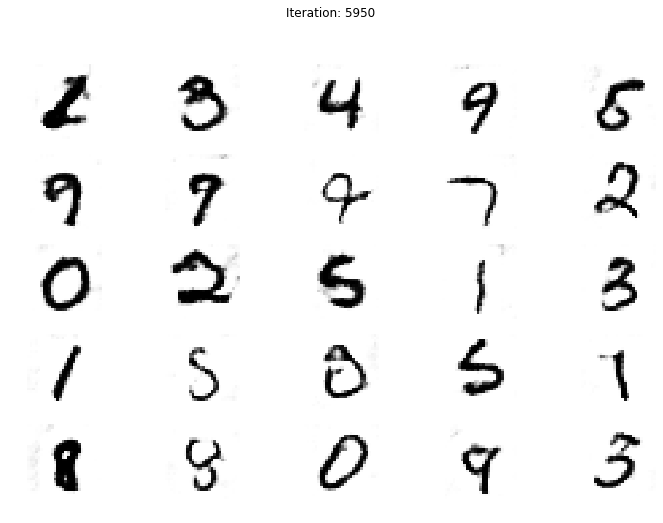

Iteration:  5951 [D loss: 0.70147, acc.:  52.73%] [G loss: 0.79446]
Iteration:  5952 [D loss: 0.71988, acc.:  46.48%] [G loss: 0.75686]
Iteration:  5953 [D loss: 0.71880, acc.:  47.66%] [G loss: 0.78743]
Iteration:  5954 [D loss: 0.70130, acc.:  49.22%] [G loss: 0.75804]
Iteration:  5955 [D loss: 0.72051, acc.:  45.31%] [G loss: 0.77114]
Iteration:  5956 [D loss: 0.69979, acc.:  50.39%] [G loss: 0.78165]
Iteration:  5957 [D loss: 0.71288, acc.:  50.39%] [G loss: 0.78575]
Iteration:  5958 [D loss: 0.70907, acc.:  50.00%] [G loss: 0.77550]
Iteration:  5959 [D loss: 0.69861, acc.:  52.34%] [G loss: 0.73479]
Iteration:  5960 [D loss: 0.73664, acc.:  48.05%] [G loss: 0.75025]
Iteration:  5961 [D loss: 0.70667, acc.:  49.61%] [G loss: 0.73669]
Iteration:  5962 [D loss: 0.68317, acc.:  59.38%] [G loss: 0.74101]
Iteration:  5963 [D loss: 0.68980, acc.:  53.12%] [G loss: 0.75029]
Iteration:  5964 [D loss: 0.70454, acc.:  48.05%] [G loss: 0.75629]
Iteration:  5965 [D loss: 0.68352, acc.:  55.86%

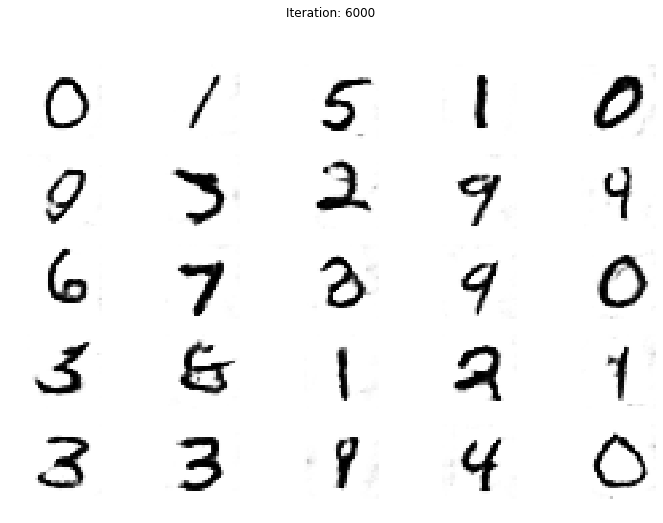

Iteration:  6001 [D loss: 0.69906, acc.:  51.17%] [G loss: 0.78459]
Iteration:  6002 [D loss: 0.70672, acc.:  51.17%] [G loss: 0.77264]
Iteration:  6003 [D loss: 0.71418, acc.:  50.39%] [G loss: 0.74843]
Iteration:  6004 [D loss: 0.71231, acc.:  46.48%] [G loss: 0.77972]
Iteration:  6005 [D loss: 0.70806, acc.:  51.17%] [G loss: 0.78179]
Iteration:  6006 [D loss: 0.70960, acc.:  50.00%] [G loss: 0.79365]
Iteration:  6007 [D loss: 0.70890, acc.:  48.05%] [G loss: 0.79925]
Iteration:  6008 [D loss: 0.70846, acc.:  51.95%] [G loss: 0.76452]
Iteration:  6009 [D loss: 0.70759, acc.:  46.09%] [G loss: 0.76994]
Iteration:  6010 [D loss: 0.71060, acc.:  48.05%] [G loss: 0.73793]
Iteration:  6011 [D loss: 0.70091, acc.:  53.12%] [G loss: 0.78419]
Iteration:  6012 [D loss: 0.71380, acc.:  48.05%] [G loss: 0.76548]
Iteration:  6013 [D loss: 0.72320, acc.:  46.48%] [G loss: 0.74366]
Iteration:  6014 [D loss: 0.73708, acc.:  42.97%] [G loss: 0.73058]
Iteration:  6015 [D loss: 0.70648, acc.:  48.05%

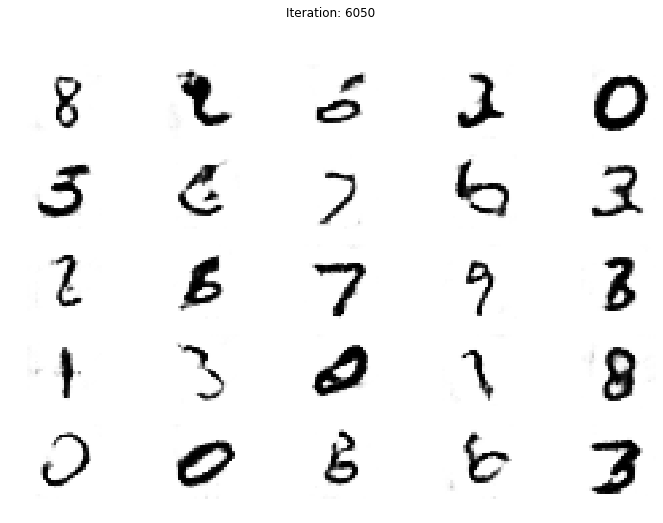

Iteration:  6051 [D loss: 0.69928, acc.:  50.00%] [G loss: 0.75352]
Iteration:  6052 [D loss: 0.70368, acc.:  52.34%] [G loss: 0.72348]
Iteration:  6053 [D loss: 0.70147, acc.:  57.03%] [G loss: 0.79702]
Iteration:  6054 [D loss: 0.71103, acc.:  48.05%] [G loss: 0.76162]
Iteration:  6055 [D loss: 0.72009, acc.:  43.75%] [G loss: 0.74371]
Iteration:  6056 [D loss: 0.72699, acc.:  46.88%] [G loss: 0.78345]
Iteration:  6057 [D loss: 0.71627, acc.:  50.00%] [G loss: 0.77177]
Iteration:  6058 [D loss: 0.69862, acc.:  52.73%] [G loss: 0.77683]
Iteration:  6059 [D loss: 0.69160, acc.:  51.95%] [G loss: 0.77622]
Iteration:  6060 [D loss: 0.71727, acc.:  46.88%] [G loss: 0.75898]
Iteration:  6061 [D loss: 0.71120, acc.:  46.48%] [G loss: 0.76134]
Iteration:  6062 [D loss: 0.69809, acc.:  54.69%] [G loss: 0.74948]
Iteration:  6063 [D loss: 0.70992, acc.:  48.05%] [G loss: 0.76053]
Iteration:  6064 [D loss: 0.70762, acc.:  48.83%] [G loss: 0.75052]
Iteration:  6065 [D loss: 0.69994, acc.:  51.95%

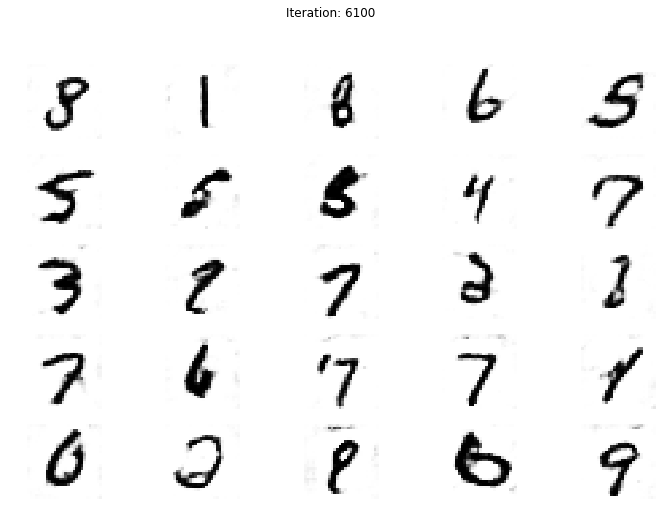

Iteration:  6101 [D loss: 0.68179, acc.:  57.81%] [G loss: 0.76594]
Iteration:  6102 [D loss: 0.70319, acc.:  53.12%] [G loss: 0.76661]
Iteration:  6103 [D loss: 0.70705, acc.:  48.05%] [G loss: 0.76582]
Iteration:  6104 [D loss: 0.69166, acc.:  51.95%] [G loss: 0.78715]
Iteration:  6105 [D loss: 0.71580, acc.:  49.22%] [G loss: 0.76199]
Iteration:  6106 [D loss: 0.70324, acc.:  50.00%] [G loss: 0.80341]
Iteration:  6107 [D loss: 0.70190, acc.:  50.78%] [G loss: 0.77262]
Iteration:  6108 [D loss: 0.70432, acc.:  53.52%] [G loss: 0.77699]
Iteration:  6109 [D loss: 0.69921, acc.:  53.52%] [G loss: 0.75855]
Iteration:  6110 [D loss: 0.70058, acc.:  51.56%] [G loss: 0.75561]
Iteration:  6111 [D loss: 0.72031, acc.:  48.05%] [G loss: 0.76594]
Iteration:  6112 [D loss: 0.69724, acc.:  51.56%] [G loss: 0.75026]
Iteration:  6113 [D loss: 0.69456, acc.:  53.52%] [G loss: 0.77622]
Iteration:  6114 [D loss: 0.72360, acc.:  45.31%] [G loss: 0.77374]
Iteration:  6115 [D loss: 0.69167, acc.:  55.47%

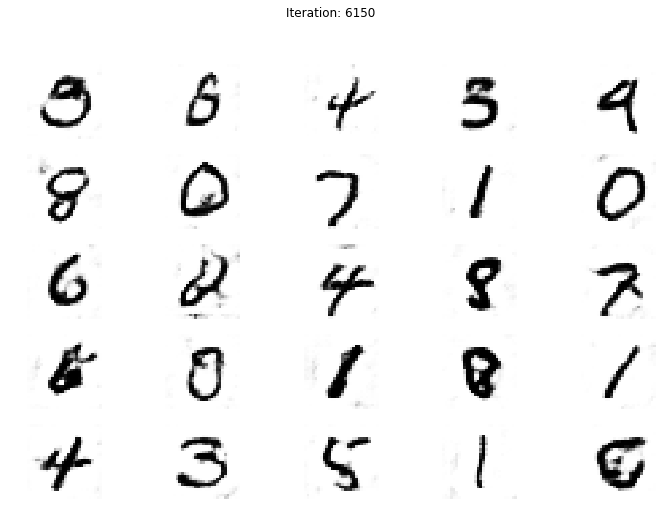

Iteration:  6151 [D loss: 0.69515, acc.:  53.52%] [G loss: 0.77091]
Iteration:  6152 [D loss: 0.71464, acc.:  48.83%] [G loss: 0.74551]
Iteration:  6153 [D loss: 0.70058, acc.:  49.61%] [G loss: 0.79435]
Iteration:  6154 [D loss: 0.70451, acc.:  48.44%] [G loss: 0.77432]
Iteration:  6155 [D loss: 0.70558, acc.:  45.31%] [G loss: 0.73695]
Iteration:  6156 [D loss: 0.70095, acc.:  49.22%] [G loss: 0.75932]
Iteration:  6157 [D loss: 0.73835, acc.:  42.97%] [G loss: 0.74317]
Iteration:  6158 [D loss: 0.70110, acc.:  53.91%] [G loss: 0.75894]
Iteration:  6159 [D loss: 0.71641, acc.:  43.36%] [G loss: 0.74615]
Iteration:  6160 [D loss: 0.68715, acc.:  55.86%] [G loss: 0.74701]
Iteration:  6161 [D loss: 0.70096, acc.:  49.22%] [G loss: 0.76314]
Iteration:  6162 [D loss: 0.69741, acc.:  50.78%] [G loss: 0.76150]
Iteration:  6163 [D loss: 0.69382, acc.:  54.30%] [G loss: 0.76024]
Iteration:  6164 [D loss: 0.71069, acc.:  50.00%] [G loss: 0.76160]
Iteration:  6165 [D loss: 0.70911, acc.:  47.27%

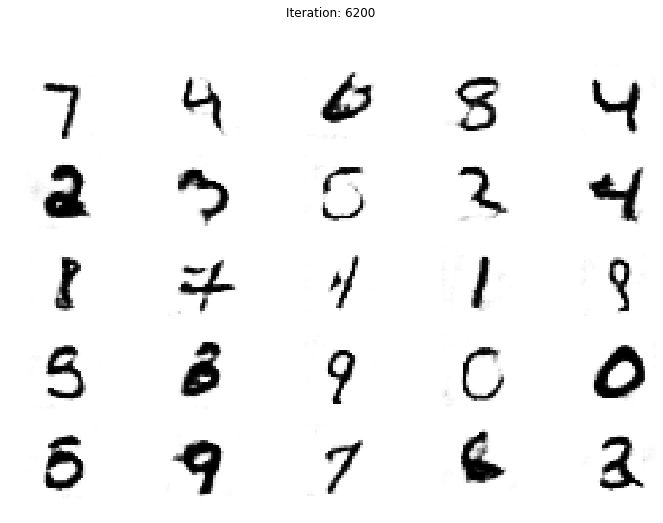

Iteration:  6201 [D loss: 0.70327, acc.:  51.17%] [G loss: 0.76094]
Iteration:  6202 [D loss: 0.69946, acc.:  54.69%] [G loss: 0.76062]
Iteration:  6203 [D loss: 0.68553, acc.:  55.08%] [G loss: 0.79241]
Iteration:  6204 [D loss: 0.72081, acc.:  44.14%] [G loss: 0.72985]
Iteration:  6205 [D loss: 0.71968, acc.:  46.88%] [G loss: 0.74460]
Iteration:  6206 [D loss: 0.71569, acc.:  47.66%] [G loss: 0.76785]
Iteration:  6207 [D loss: 0.70882, acc.:  49.61%] [G loss: 0.74104]
Iteration:  6208 [D loss: 0.68859, acc.:  53.91%] [G loss: 0.77052]
Iteration:  6209 [D loss: 0.70622, acc.:  52.34%] [G loss: 0.75603]
Iteration:  6210 [D loss: 0.70829, acc.:  50.00%] [G loss: 0.75990]
Iteration:  6211 [D loss: 0.70080, acc.:  51.17%] [G loss: 0.74484]
Iteration:  6212 [D loss: 0.69915, acc.:  51.17%] [G loss: 0.76684]
Iteration:  6213 [D loss: 0.67997, acc.:  57.03%] [G loss: 0.75265]
Iteration:  6214 [D loss: 0.71965, acc.:  48.05%] [G loss: 0.75169]
Iteration:  6215 [D loss: 0.70226, acc.:  51.56%

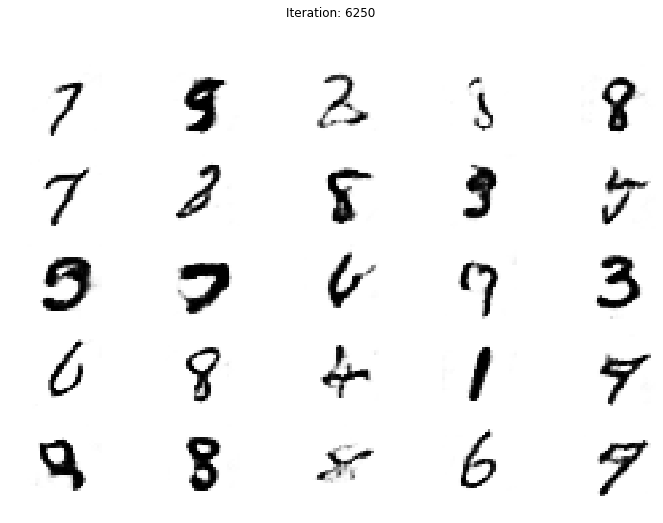

Iteration:  6251 [D loss: 0.71458, acc.:  46.88%] [G loss: 0.78309]
Iteration:  6252 [D loss: 0.71388, acc.:  53.12%] [G loss: 0.74764]
Iteration:  6253 [D loss: 0.73798, acc.:  41.80%] [G loss: 0.75325]
Iteration:  6254 [D loss: 0.68936, acc.:  56.64%] [G loss: 0.78464]
Iteration:  6255 [D loss: 0.70200, acc.:  52.73%] [G loss: 0.78689]
Iteration:  6256 [D loss: 0.69709, acc.:  47.66%] [G loss: 0.80409]
Iteration:  6257 [D loss: 0.69466, acc.:  54.30%] [G loss: 0.76119]
Iteration:  6258 [D loss: 0.70741, acc.:  52.34%] [G loss: 0.76320]
Iteration:  6259 [D loss: 0.68429, acc.:  52.34%] [G loss: 0.74983]
Iteration:  6260 [D loss: 0.70140, acc.:  51.56%] [G loss: 0.76561]
Iteration:  6261 [D loss: 0.70325, acc.:  52.34%] [G loss: 0.77275]
Iteration:  6262 [D loss: 0.70760, acc.:  51.17%] [G loss: 0.76518]
Iteration:  6263 [D loss: 0.72170, acc.:  49.22%] [G loss: 0.74446]
Iteration:  6264 [D loss: 0.68736, acc.:  51.17%] [G loss: 0.78037]
Iteration:  6265 [D loss: 0.69532, acc.:  51.95%

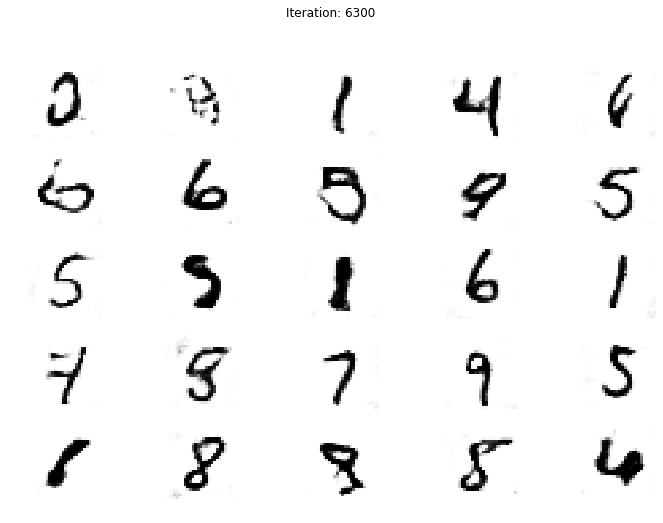

Iteration:  6301 [D loss: 0.71223, acc.:  49.61%] [G loss: 0.75545]
Iteration:  6302 [D loss: 0.70434, acc.:  50.39%] [G loss: 0.76350]
Iteration:  6303 [D loss: 0.70199, acc.:  50.78%] [G loss: 0.76182]
Iteration:  6304 [D loss: 0.70954, acc.:  52.34%] [G loss: 0.74734]
Iteration:  6305 [D loss: 0.69730, acc.:  53.91%] [G loss: 0.77786]
Iteration:  6306 [D loss: 0.70552, acc.:  51.95%] [G loss: 0.76115]
Iteration:  6307 [D loss: 0.70405, acc.:  50.00%] [G loss: 0.76703]
Iteration:  6308 [D loss: 0.71476, acc.:  47.27%] [G loss: 0.75056]
Iteration:  6309 [D loss: 0.68491, acc.:  54.30%] [G loss: 0.77196]
Iteration:  6310 [D loss: 0.70489, acc.:  50.39%] [G loss: 0.74533]
Iteration:  6311 [D loss: 0.69430, acc.:  53.52%] [G loss: 0.73679]
Iteration:  6312 [D loss: 0.71832, acc.:  44.53%] [G loss: 0.74340]
Iteration:  6313 [D loss: 0.70139, acc.:  49.22%] [G loss: 0.78644]
Iteration:  6314 [D loss: 0.70305, acc.:  50.78%] [G loss: 0.77488]
Iteration:  6315 [D loss: 0.70002, acc.:  50.78%

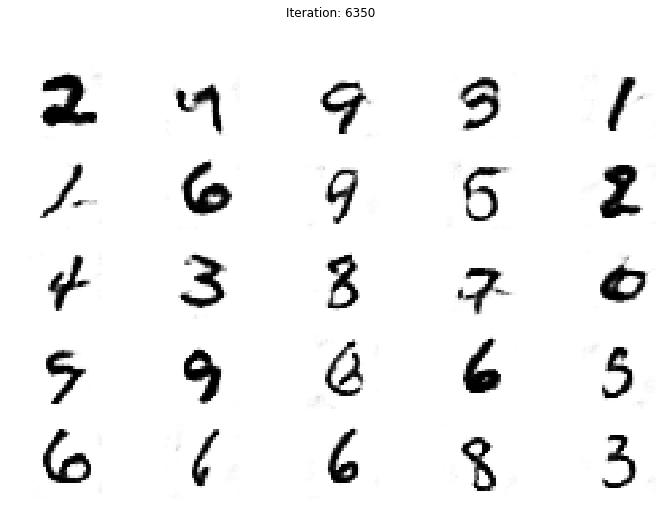

Iteration:  6351 [D loss: 0.70345, acc.:  52.73%] [G loss: 0.79273]
Iteration:  6352 [D loss: 0.72347, acc.:  46.48%] [G loss: 0.74416]
Iteration:  6353 [D loss: 0.69263, acc.:  52.73%] [G loss: 0.73836]
Iteration:  6354 [D loss: 0.72181, acc.:  49.61%] [G loss: 0.77681]
Iteration:  6355 [D loss: 0.69168, acc.:  52.34%] [G loss: 0.81228]
Iteration:  6356 [D loss: 0.71887, acc.:  48.83%] [G loss: 0.73438]
Iteration:  6357 [D loss: 0.69354, acc.:  53.12%] [G loss: 0.75960]
Iteration:  6358 [D loss: 0.71410, acc.:  47.66%] [G loss: 0.74935]
Iteration:  6359 [D loss: 0.69219, acc.:  54.69%] [G loss: 0.77971]
Iteration:  6360 [D loss: 0.70562, acc.:  50.78%] [G loss: 0.76220]
Iteration:  6361 [D loss: 0.70711, acc.:  50.00%] [G loss: 0.75007]
Iteration:  6362 [D loss: 0.72104, acc.:  46.88%] [G loss: 0.77076]
Iteration:  6363 [D loss: 0.68997, acc.:  48.05%] [G loss: 0.74205]
Iteration:  6364 [D loss: 0.68803, acc.:  51.95%] [G loss: 0.77166]
Iteration:  6365 [D loss: 0.71116, acc.:  45.70%

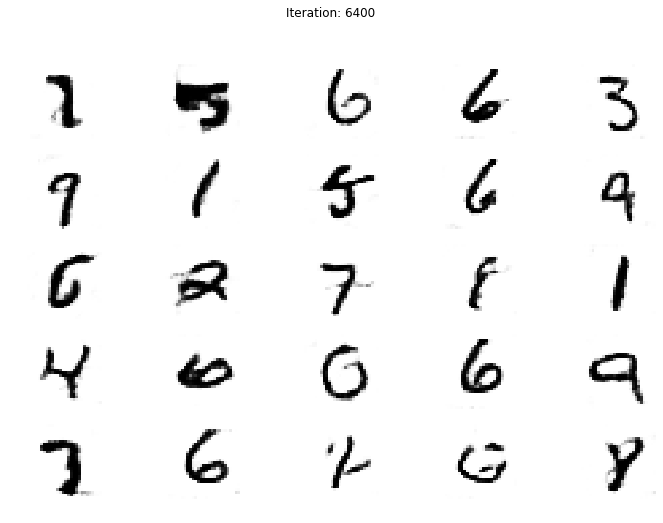

Iteration:  6401 [D loss: 0.70910, acc.:  50.39%] [G loss: 0.75559]
Iteration:  6402 [D loss: 0.71881, acc.:  47.27%] [G loss: 0.75430]
Iteration:  6403 [D loss: 0.70732, acc.:  53.12%] [G loss: 0.77971]
Iteration:  6404 [D loss: 0.69949, acc.:  51.56%] [G loss: 0.76454]
Iteration:  6405 [D loss: 0.69558, acc.:  56.25%] [G loss: 0.75863]
Iteration:  6406 [D loss: 0.69657, acc.:  53.91%] [G loss: 0.79147]
Iteration:  6407 [D loss: 0.70241, acc.:  51.56%] [G loss: 0.77502]
Iteration:  6408 [D loss: 0.71214, acc.:  51.95%] [G loss: 0.81288]
Iteration:  6409 [D loss: 0.71621, acc.:  49.61%] [G loss: 0.76540]
Iteration:  6410 [D loss: 0.71858, acc.:  48.05%] [G loss: 0.73478]
Iteration:  6411 [D loss: 0.72957, acc.:  46.09%] [G loss: 0.73475]
Iteration:  6412 [D loss: 0.71497, acc.:  48.83%] [G loss: 0.75004]
Iteration:  6413 [D loss: 0.69699, acc.:  55.08%] [G loss: 0.74921]
Iteration:  6414 [D loss: 0.70121, acc.:  54.69%] [G loss: 0.77304]
Iteration:  6415 [D loss: 0.69224, acc.:  55.47%

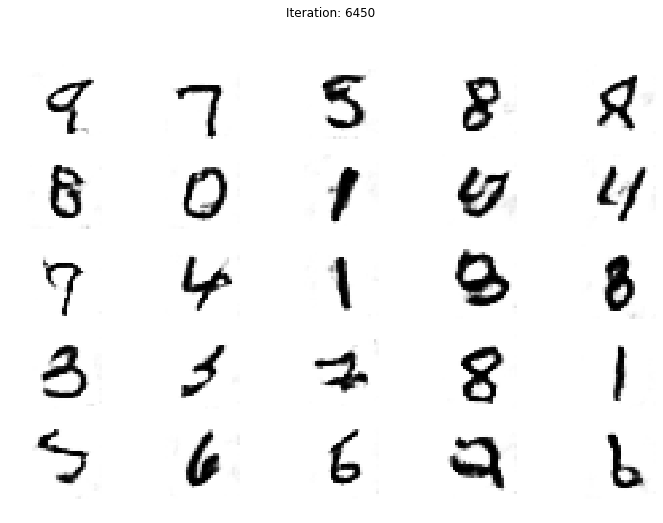

Iteration:  6451 [D loss: 0.70728, acc.:  48.05%] [G loss: 0.77944]
Iteration:  6452 [D loss: 0.73079, acc.:  41.41%] [G loss: 0.79459]
Iteration:  6453 [D loss: 0.70312, acc.:  51.56%] [G loss: 0.75667]
Iteration:  6454 [D loss: 0.69817, acc.:  50.39%] [G loss: 0.77201]
Iteration:  6455 [D loss: 0.71146, acc.:  49.22%] [G loss: 0.75323]
Iteration:  6456 [D loss: 0.70771, acc.:  51.17%] [G loss: 0.76621]
Iteration:  6457 [D loss: 0.70192, acc.:  53.12%] [G loss: 0.78301]
Iteration:  6458 [D loss: 0.69238, acc.:  52.73%] [G loss: 0.76711]
Iteration:  6459 [D loss: 0.69956, acc.:  51.56%] [G loss: 0.79374]
Iteration:  6460 [D loss: 0.71104, acc.:  47.66%] [G loss: 0.76525]
Iteration:  6461 [D loss: 0.71788, acc.:  46.88%] [G loss: 0.78249]
Iteration:  6462 [D loss: 0.70890, acc.:  50.00%] [G loss: 0.76217]
Iteration:  6463 [D loss: 0.69633, acc.:  53.52%] [G loss: 0.76620]
Iteration:  6464 [D loss: 0.70529, acc.:  50.78%] [G loss: 0.77504]
Iteration:  6465 [D loss: 0.70565, acc.:  47.27%

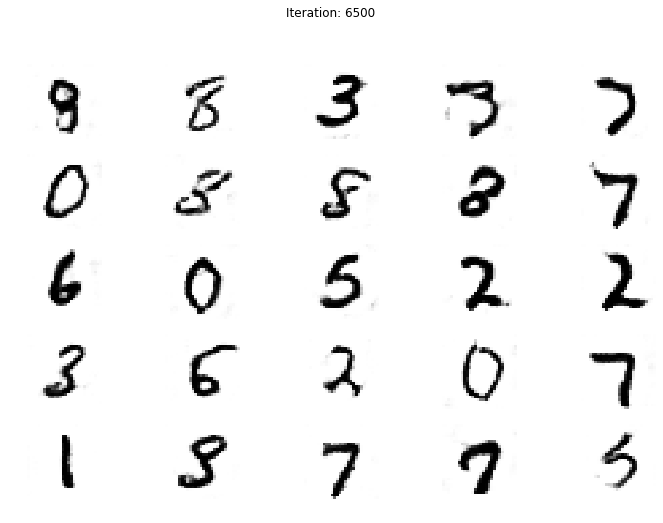

Iteration:  6501 [D loss: 0.70644, acc.:  50.78%] [G loss: 0.74131]
Iteration:  6502 [D loss: 0.69525, acc.:  54.30%] [G loss: 0.75143]
Iteration:  6503 [D loss: 0.73642, acc.:  46.09%] [G loss: 0.79999]
Iteration:  6504 [D loss: 0.69469, acc.:  47.66%] [G loss: 0.76682]
Iteration:  6505 [D loss: 0.69117, acc.:  53.12%] [G loss: 0.82478]
Iteration:  6506 [D loss: 0.68000, acc.:  53.12%] [G loss: 0.71903]
Iteration:  6507 [D loss: 0.71129, acc.:  50.00%] [G loss: 0.73894]
Iteration:  6508 [D loss: 0.70728, acc.:  50.78%] [G loss: 0.74762]
Iteration:  6509 [D loss: 0.72404, acc.:  43.36%] [G loss: 0.75604]
Iteration:  6510 [D loss: 0.71293, acc.:  46.48%] [G loss: 0.75002]
Iteration:  6511 [D loss: 0.70801, acc.:  49.61%] [G loss: 0.76565]
Iteration:  6512 [D loss: 0.73289, acc.:  42.58%] [G loss: 0.77331]
Iteration:  6513 [D loss: 0.71754, acc.:  48.44%] [G loss: 0.77652]
Iteration:  6514 [D loss: 0.71022, acc.:  49.22%] [G loss: 0.77778]
Iteration:  6515 [D loss: 0.71592, acc.:  46.48%

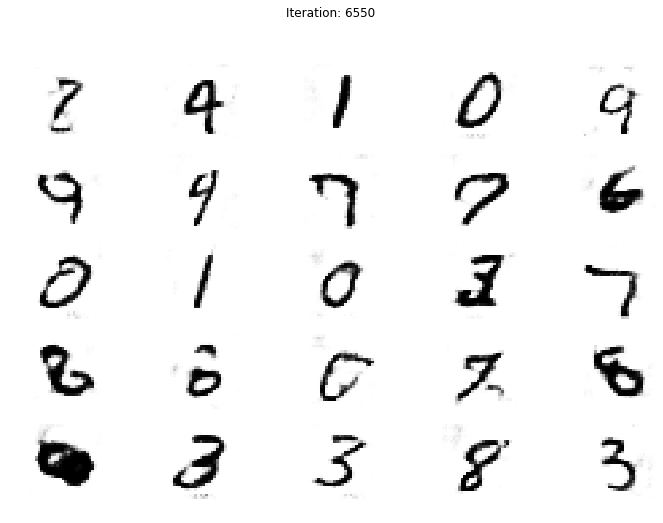

Iteration:  6551 [D loss: 0.70585, acc.:  52.73%] [G loss: 0.76329]
Iteration:  6552 [D loss: 0.70098, acc.:  52.73%] [G loss: 0.75192]
Iteration:  6553 [D loss: 0.69713, acc.:  50.78%] [G loss: 0.77221]
Iteration:  6554 [D loss: 0.70740, acc.:  50.39%] [G loss: 0.74982]
Iteration:  6555 [D loss: 0.71550, acc.:  44.92%] [G loss: 0.76604]
Iteration:  6556 [D loss: 0.72775, acc.:  41.80%] [G loss: 0.74208]
Iteration:  6557 [D loss: 0.68992, acc.:  52.73%] [G loss: 0.78661]
Iteration:  6558 [D loss: 0.71234, acc.:  51.17%] [G loss: 0.75607]
Iteration:  6559 [D loss: 0.68699, acc.:  55.47%] [G loss: 0.75500]
Iteration:  6560 [D loss: 0.72232, acc.:  48.44%] [G loss: 0.76371]
Iteration:  6561 [D loss: 0.70671, acc.:  51.17%] [G loss: 0.73693]
Iteration:  6562 [D loss: 0.71300, acc.:  48.83%] [G loss: 0.74621]
Iteration:  6563 [D loss: 0.73564, acc.:  46.88%] [G loss: 0.74348]
Iteration:  6564 [D loss: 0.69960, acc.:  50.00%] [G loss: 0.74934]
Iteration:  6565 [D loss: 0.71728, acc.:  46.48%

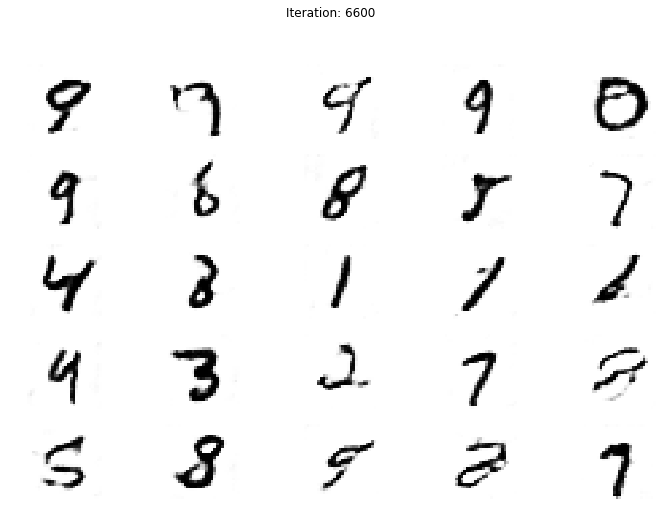

Iteration:  6601 [D loss: 0.70028, acc.:  52.34%] [G loss: 0.74199]
Iteration:  6602 [D loss: 0.69891, acc.:  51.95%] [G loss: 0.76045]
Iteration:  6603 [D loss: 0.72319, acc.:  44.53%] [G loss: 0.78778]
Iteration:  6604 [D loss: 0.71298, acc.:  50.39%] [G loss: 0.74229]
Iteration:  6605 [D loss: 0.71025, acc.:  50.78%] [G loss: 0.76069]
Iteration:  6606 [D loss: 0.70705, acc.:  50.78%] [G loss: 0.77474]
Iteration:  6607 [D loss: 0.69500, acc.:  51.17%] [G loss: 0.77534]
Iteration:  6608 [D loss: 0.71504, acc.:  46.09%] [G loss: 0.77931]
Iteration:  6609 [D loss: 0.69296, acc.:  51.17%] [G loss: 0.76835]
Iteration:  6610 [D loss: 0.69694, acc.:  51.56%] [G loss: 0.77755]
Iteration:  6611 [D loss: 0.69911, acc.:  50.78%] [G loss: 0.77243]
Iteration:  6612 [D loss: 0.68692, acc.:  56.25%] [G loss: 0.76232]
Iteration:  6613 [D loss: 0.69402, acc.:  47.27%] [G loss: 0.74218]
Iteration:  6614 [D loss: 0.71785, acc.:  42.97%] [G loss: 0.77086]
Iteration:  6615 [D loss: 0.70306, acc.:  51.17%

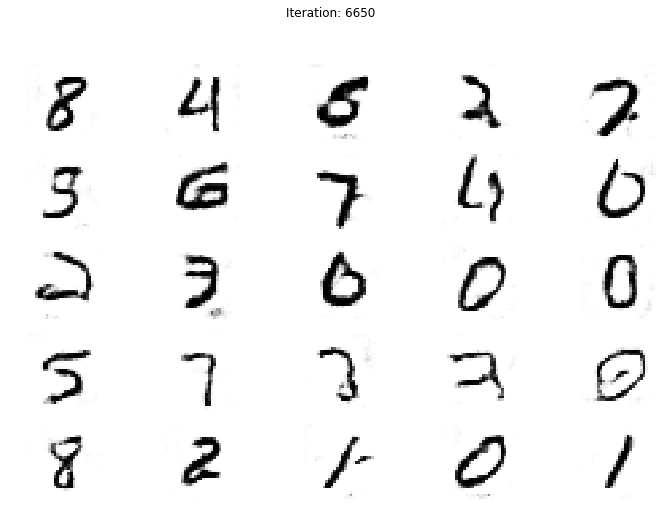

Iteration:  6651 [D loss: 0.70150, acc.:  50.39%] [G loss: 0.76965]
Iteration:  6652 [D loss: 0.70687, acc.:  49.22%] [G loss: 0.78167]
Iteration:  6653 [D loss: 0.70368, acc.:  51.95%] [G loss: 0.76432]
Iteration:  6654 [D loss: 0.73671, acc.:  45.70%] [G loss: 0.79006]
Iteration:  6655 [D loss: 0.72339, acc.:  46.09%] [G loss: 0.77918]
Iteration:  6656 [D loss: 0.70194, acc.:  47.27%] [G loss: 0.73995]
Iteration:  6657 [D loss: 0.70812, acc.:  51.17%] [G loss: 0.74455]
Iteration:  6658 [D loss: 0.70304, acc.:  52.73%] [G loss: 0.74453]
Iteration:  6659 [D loss: 0.69377, acc.:  60.55%] [G loss: 0.76978]
Iteration:  6660 [D loss: 0.70874, acc.:  46.09%] [G loss: 0.74981]
Iteration:  6661 [D loss: 0.70202, acc.:  50.78%] [G loss: 0.78551]
Iteration:  6662 [D loss: 0.72958, acc.:  41.02%] [G loss: 0.75082]
Iteration:  6663 [D loss: 0.70568, acc.:  52.73%] [G loss: 0.76484]
Iteration:  6664 [D loss: 0.69457, acc.:  51.56%] [G loss: 0.74625]
Iteration:  6665 [D loss: 0.70876, acc.:  51.56%

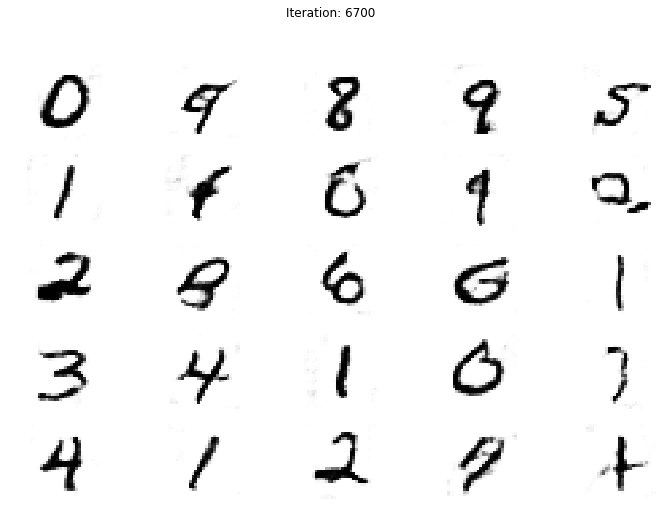

Iteration:  6701 [D loss: 0.70116, acc.:  52.34%] [G loss: 0.75509]
Iteration:  6702 [D loss: 0.70138, acc.:  51.56%] [G loss: 0.77735]
Iteration:  6703 [D loss: 0.70840, acc.:  49.22%] [G loss: 0.75307]
Iteration:  6704 [D loss: 0.70687, acc.:  47.66%] [G loss: 0.77074]
Iteration:  6705 [D loss: 0.68366, acc.:  56.25%] [G loss: 0.76303]
Iteration:  6706 [D loss: 0.67998, acc.:  55.47%] [G loss: 0.77464]
Iteration:  6707 [D loss: 0.69692, acc.:  50.00%] [G loss: 0.75088]
Iteration:  6708 [D loss: 0.70617, acc.:  50.00%] [G loss: 0.74323]
Iteration:  6709 [D loss: 0.70862, acc.:  50.39%] [G loss: 0.77108]
Iteration:  6710 [D loss: 0.69547, acc.:  51.56%] [G loss: 0.78446]
Iteration:  6711 [D loss: 0.68444, acc.:  56.25%] [G loss: 0.75617]
Iteration:  6712 [D loss: 0.72016, acc.:  45.31%] [G loss: 0.77051]
Iteration:  6713 [D loss: 0.69093, acc.:  55.86%] [G loss: 0.77005]
Iteration:  6714 [D loss: 0.71239, acc.:  49.61%] [G loss: 0.77598]
Iteration:  6715 [D loss: 0.71225, acc.:  49.22%

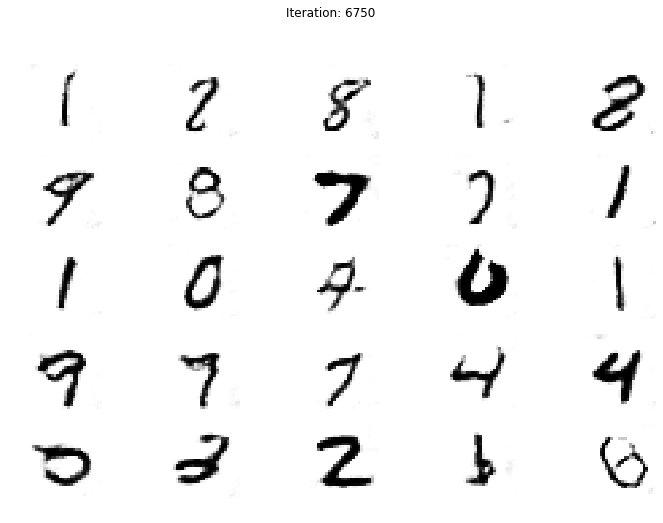

Iteration:  6751 [D loss: 0.73525, acc.:  39.06%] [G loss: 0.76558]
Iteration:  6752 [D loss: 0.70766, acc.:  48.05%] [G loss: 0.76937]
Iteration:  6753 [D loss: 0.71081, acc.:  48.83%] [G loss: 0.76955]
Iteration:  6754 [D loss: 0.73021, acc.:  41.02%] [G loss: 0.76674]
Iteration:  6755 [D loss: 0.69525, acc.:  51.17%] [G loss: 0.77809]
Iteration:  6756 [D loss: 0.72987, acc.:  41.80%] [G loss: 0.74075]
Iteration:  6757 [D loss: 0.72964, acc.:  46.09%] [G loss: 0.75703]
Iteration:  6758 [D loss: 0.72790, acc.:  47.27%] [G loss: 0.76370]
Iteration:  6759 [D loss: 0.71297, acc.:  46.48%] [G loss: 0.78619]
Iteration:  6760 [D loss: 0.70730, acc.:  50.39%] [G loss: 0.75578]
Iteration:  6761 [D loss: 0.69698, acc.:  50.00%] [G loss: 0.76404]
Iteration:  6762 [D loss: 0.69711, acc.:  50.39%] [G loss: 0.76872]
Iteration:  6763 [D loss: 0.69002, acc.:  56.25%] [G loss: 0.76541]
Iteration:  6764 [D loss: 0.70945, acc.:  55.47%] [G loss: 0.78930]
Iteration:  6765 [D loss: 0.71204, acc.:  50.00%

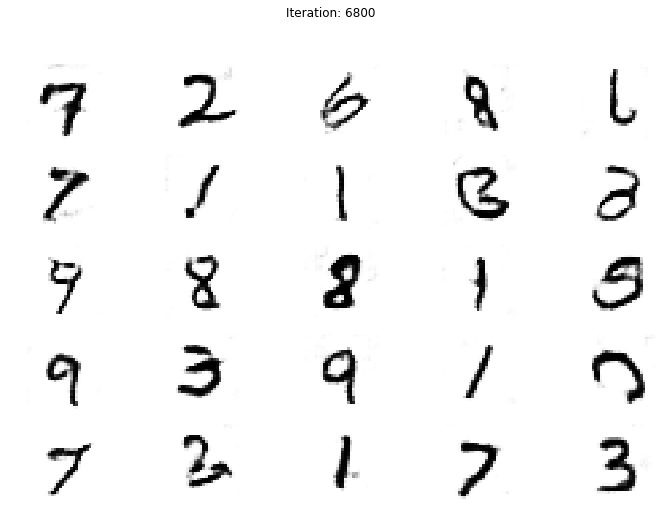

Iteration:  6801 [D loss: 0.69638, acc.:  53.91%] [G loss: 0.74874]
Iteration:  6802 [D loss: 0.67991, acc.:  53.91%] [G loss: 0.76800]
Iteration:  6803 [D loss: 0.70754, acc.:  49.61%] [G loss: 0.78785]
Iteration:  6804 [D loss: 0.70511, acc.:  48.44%] [G loss: 0.77944]
Iteration:  6805 [D loss: 0.72446, acc.:  46.09%] [G loss: 0.75895]
Iteration:  6806 [D loss: 0.70213, acc.:  51.17%] [G loss: 0.76514]
Iteration:  6807 [D loss: 0.69143, acc.:  55.47%] [G loss: 0.76722]
Iteration:  6808 [D loss: 0.70439, acc.:  49.22%] [G loss: 0.72576]
Iteration:  6809 [D loss: 0.70601, acc.:  47.66%] [G loss: 0.72734]
Iteration:  6810 [D loss: 0.72074, acc.:  46.48%] [G loss: 0.73820]
Iteration:  6811 [D loss: 0.70312, acc.:  49.61%] [G loss: 0.73869]
Iteration:  6812 [D loss: 0.70081, acc.:  52.34%] [G loss: 0.76906]
Iteration:  6813 [D loss: 0.70103, acc.:  46.48%] [G loss: 0.76172]
Iteration:  6814 [D loss: 0.69972, acc.:  51.56%] [G loss: 0.74854]
Iteration:  6815 [D loss: 0.72128, acc.:  46.88%

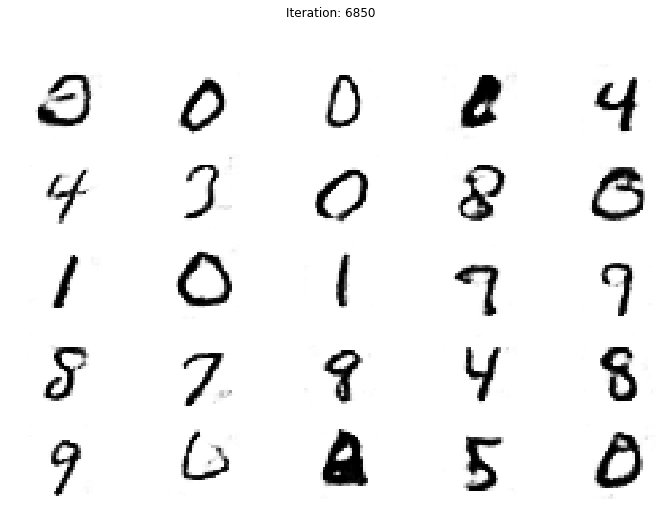

Iteration:  6851 [D loss: 0.71517, acc.:  42.97%] [G loss: 0.79739]
Iteration:  6852 [D loss: 0.69467, acc.:  51.56%] [G loss: 0.75646]
Iteration:  6853 [D loss: 0.72001, acc.:  46.09%] [G loss: 0.74075]
Iteration:  6854 [D loss: 0.70909, acc.:  51.17%] [G loss: 0.74606]
Iteration:  6855 [D loss: 0.70749, acc.:  47.66%] [G loss: 0.75326]
Iteration:  6856 [D loss: 0.68798, acc.:  55.47%] [G loss: 0.75938]
Iteration:  6857 [D loss: 0.73022, acc.:  44.14%] [G loss: 0.71833]
Iteration:  6858 [D loss: 0.71905, acc.:  49.22%] [G loss: 0.71299]
Iteration:  6859 [D loss: 0.71785, acc.:  48.05%] [G loss: 0.77738]
Iteration:  6860 [D loss: 0.72091, acc.:  46.48%] [G loss: 0.75412]
Iteration:  6861 [D loss: 0.70724, acc.:  51.95%] [G loss: 0.77724]
Iteration:  6862 [D loss: 0.68908, acc.:  52.34%] [G loss: 0.77542]
Iteration:  6863 [D loss: 0.70445, acc.:  53.52%] [G loss: 0.77233]
Iteration:  6864 [D loss: 0.70104, acc.:  53.12%] [G loss: 0.76918]
Iteration:  6865 [D loss: 0.70032, acc.:  51.56%

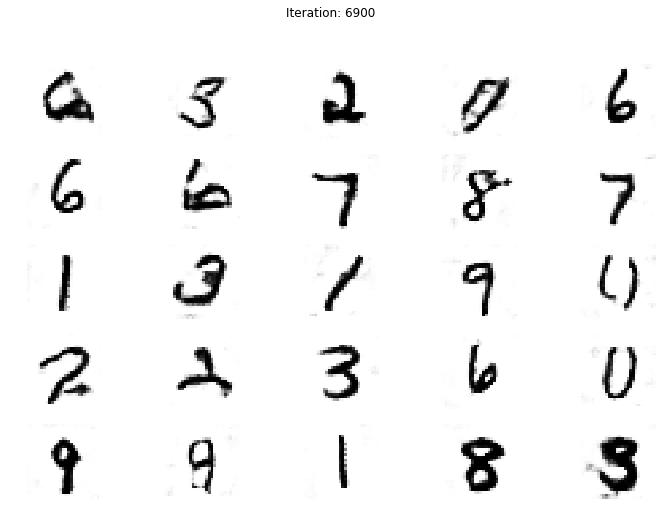

Iteration:  6901 [D loss: 0.69867, acc.:  51.17%] [G loss: 0.73638]
Iteration:  6902 [D loss: 0.71164, acc.:  46.88%] [G loss: 0.75604]
Iteration:  6903 [D loss: 0.72624, acc.:  47.27%] [G loss: 0.74063]
Iteration:  6904 [D loss: 0.68946, acc.:  53.52%] [G loss: 0.77033]
Iteration:  6905 [D loss: 0.69394, acc.:  55.47%] [G loss: 0.76848]
Iteration:  6906 [D loss: 0.71364, acc.:  48.05%] [G loss: 0.77249]
Iteration:  6907 [D loss: 0.71229, acc.:  52.73%] [G loss: 0.76810]
Iteration:  6908 [D loss: 0.69861, acc.:  55.47%] [G loss: 0.78503]
Iteration:  6909 [D loss: 0.69512, acc.:  50.39%] [G loss: 0.74743]
Iteration:  6910 [D loss: 0.72046, acc.:  49.22%] [G loss: 0.75089]
Iteration:  6911 [D loss: 0.71237, acc.:  47.66%] [G loss: 0.77450]
Iteration:  6912 [D loss: 0.69081, acc.:  54.30%] [G loss: 0.73743]
Iteration:  6913 [D loss: 0.69817, acc.:  51.17%] [G loss: 0.74972]
Iteration:  6914 [D loss: 0.69992, acc.:  51.95%] [G loss: 0.76348]
Iteration:  6915 [D loss: 0.69534, acc.:  52.73%

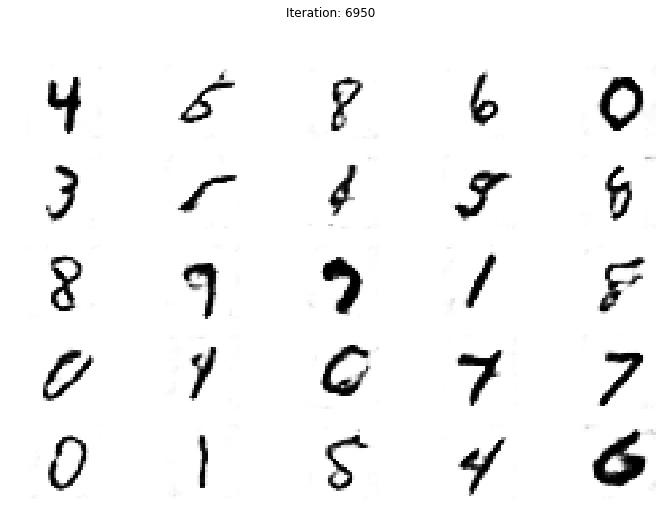

Iteration:  6951 [D loss: 0.70494, acc.:  49.61%] [G loss: 0.74508]
Iteration:  6952 [D loss: 0.68692, acc.:  54.30%] [G loss: 0.75271]
Iteration:  6953 [D loss: 0.70210, acc.:  48.83%] [G loss: 0.77512]
Iteration:  6954 [D loss: 0.69043, acc.:  55.47%] [G loss: 0.75793]
Iteration:  6955 [D loss: 0.72259, acc.:  44.53%] [G loss: 0.78926]
Iteration:  6956 [D loss: 0.70250, acc.:  53.12%] [G loss: 0.79118]
Iteration:  6957 [D loss: 0.68319, acc.:  51.17%] [G loss: 0.76007]
Iteration:  6958 [D loss: 0.69150, acc.:  53.52%] [G loss: 0.73871]
Iteration:  6959 [D loss: 0.70784, acc.:  49.61%] [G loss: 0.78610]
Iteration:  6960 [D loss: 0.71965, acc.:  45.70%] [G loss: 0.72533]
Iteration:  6961 [D loss: 0.70647, acc.:  49.22%] [G loss: 0.74941]
Iteration:  6962 [D loss: 0.70289, acc.:  48.83%] [G loss: 0.74592]
Iteration:  6963 [D loss: 0.68574, acc.:  54.69%] [G loss: 0.74199]
Iteration:  6964 [D loss: 0.69477, acc.:  53.91%] [G loss: 0.75565]
Iteration:  6965 [D loss: 0.71238, acc.:  48.05%

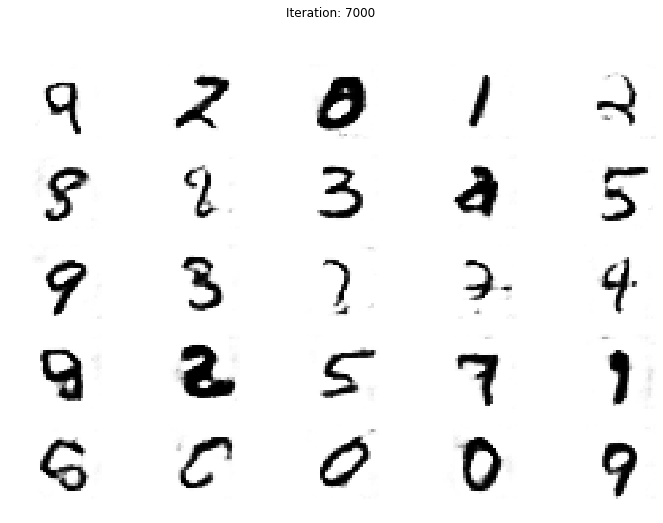

Iteration:  7001 [D loss: 0.69970, acc.:  55.86%] [G loss: 0.77996]
Iteration:  7002 [D loss: 0.72236, acc.:  49.61%] [G loss: 0.76402]
Iteration:  7003 [D loss: 0.68597, acc.:  53.12%] [G loss: 0.75505]
Iteration:  7004 [D loss: 0.72712, acc.:  46.09%] [G loss: 0.74274]
Iteration:  7005 [D loss: 0.69421, acc.:  51.17%] [G loss: 0.77337]
Iteration:  7006 [D loss: 0.70603, acc.:  51.56%] [G loss: 0.77972]
Iteration:  7007 [D loss: 0.68719, acc.:  53.91%] [G loss: 0.78992]
Iteration:  7008 [D loss: 0.69978, acc.:  50.00%] [G loss: 0.80017]
Iteration:  7009 [D loss: 0.68389, acc.:  58.98%] [G loss: 0.79059]
Iteration:  7010 [D loss: 0.71476, acc.:  48.05%] [G loss: 0.75056]
Iteration:  7011 [D loss: 0.69245, acc.:  55.08%] [G loss: 0.76921]
Iteration:  7012 [D loss: 0.70659, acc.:  51.17%] [G loss: 0.75299]
Iteration:  7013 [D loss: 0.71015, acc.:  48.05%] [G loss: 0.73598]
Iteration:  7014 [D loss: 0.69673, acc.:  52.34%] [G loss: 0.75925]
Iteration:  7015 [D loss: 0.73114, acc.:  42.97%

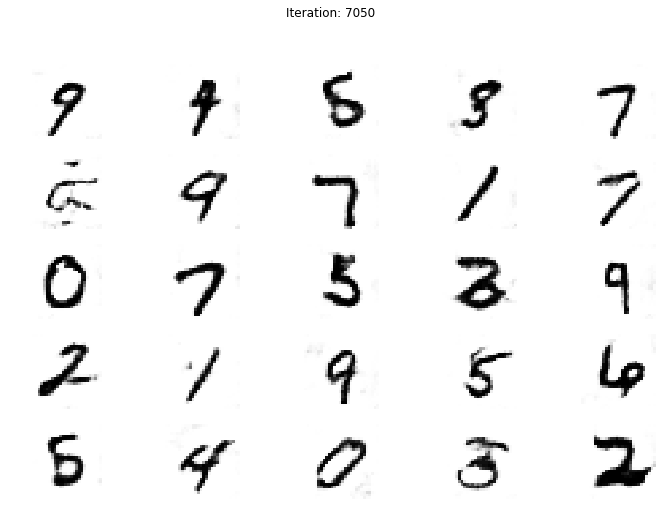

Iteration:  7051 [D loss: 0.71852, acc.:  49.61%] [G loss: 0.76822]
Iteration:  7052 [D loss: 0.69749, acc.:  47.27%] [G loss: 0.74823]
Iteration:  7053 [D loss: 0.70393, acc.:  52.34%] [G loss: 0.78108]
Iteration:  7054 [D loss: 0.71602, acc.:  50.00%] [G loss: 0.73321]
Iteration:  7055 [D loss: 0.72375, acc.:  46.48%] [G loss: 0.77095]
Iteration:  7056 [D loss: 0.71068, acc.:  48.44%] [G loss: 0.78014]
Iteration:  7057 [D loss: 0.71672, acc.:  48.05%] [G loss: 0.75807]
Iteration:  7058 [D loss: 0.71782, acc.:  46.09%] [G loss: 0.78684]
Iteration:  7059 [D loss: 0.69268, acc.:  52.34%] [G loss: 0.74137]
Iteration:  7060 [D loss: 0.70196, acc.:  46.48%] [G loss: 0.76356]
Iteration:  7061 [D loss: 0.69395, acc.:  52.34%] [G loss: 0.74927]
Iteration:  7062 [D loss: 0.68290, acc.:  53.12%] [G loss: 0.76884]
Iteration:  7063 [D loss: 0.67762, acc.:  58.98%] [G loss: 0.76946]
Iteration:  7064 [D loss: 0.69363, acc.:  52.73%] [G loss: 0.76956]
Iteration:  7065 [D loss: 0.71907, acc.:  47.27%

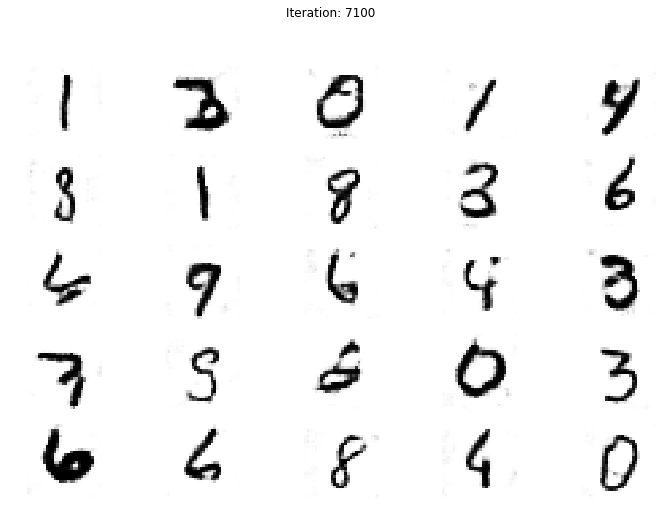

Iteration:  7101 [D loss: 0.67703, acc.:  52.73%] [G loss: 0.75589]
Iteration:  7102 [D loss: 0.72991, acc.:  44.92%] [G loss: 0.75807]
Iteration:  7103 [D loss: 0.69993, acc.:  49.22%] [G loss: 0.76126]
Iteration:  7104 [D loss: 0.72105, acc.:  45.31%] [G loss: 0.76815]
Iteration:  7105 [D loss: 0.71268, acc.:  46.48%] [G loss: 0.76570]
Iteration:  7106 [D loss: 0.72991, acc.:  41.80%] [G loss: 0.77588]
Iteration:  7107 [D loss: 0.72256, acc.:  43.75%] [G loss: 0.75783]
Iteration:  7108 [D loss: 0.71329, acc.:  47.27%] [G loss: 0.75837]
Iteration:  7109 [D loss: 0.70977, acc.:  50.39%] [G loss: 0.75168]
Iteration:  7110 [D loss: 0.70643, acc.:  48.83%] [G loss: 0.73133]
Iteration:  7111 [D loss: 0.72574, acc.:  46.48%] [G loss: 0.74562]
Iteration:  7112 [D loss: 0.69606, acc.:  53.12%] [G loss: 0.78633]
Iteration:  7113 [D loss: 0.69444, acc.:  51.17%] [G loss: 0.72592]
Iteration:  7114 [D loss: 0.70442, acc.:  57.03%] [G loss: 0.74426]
Iteration:  7115 [D loss: 0.71862, acc.:  43.75%

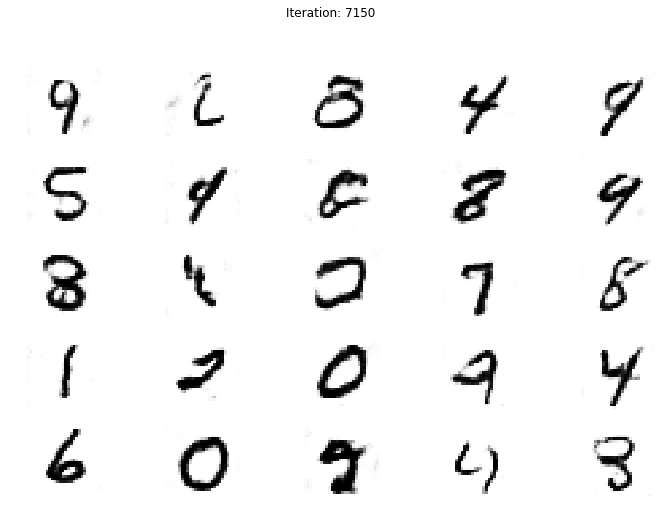

Iteration:  7151 [D loss: 0.72227, acc.:  47.66%] [G loss: 0.77890]
Iteration:  7152 [D loss: 0.72057, acc.:  48.44%] [G loss: 0.77623]
Iteration:  7153 [D loss: 0.71595, acc.:  48.83%] [G loss: 0.76005]
Iteration:  7154 [D loss: 0.71365, acc.:  46.88%] [G loss: 0.77902]
Iteration:  7155 [D loss: 0.72743, acc.:  46.48%] [G loss: 0.76700]
Iteration:  7156 [D loss: 0.71052, acc.:  48.44%] [G loss: 0.76543]
Iteration:  7157 [D loss: 0.71239, acc.:  50.39%] [G loss: 0.75831]
Iteration:  7158 [D loss: 0.71138, acc.:  46.88%] [G loss: 0.75800]
Iteration:  7159 [D loss: 0.71804, acc.:  46.09%] [G loss: 0.75191]
Iteration:  7160 [D loss: 0.69903, acc.:  49.22%] [G loss: 0.75987]
Iteration:  7161 [D loss: 0.70980, acc.:  48.83%] [G loss: 0.76458]
Iteration:  7162 [D loss: 0.71414, acc.:  51.95%] [G loss: 0.78615]
Iteration:  7163 [D loss: 0.70145, acc.:  50.00%] [G loss: 0.76258]
Iteration:  7164 [D loss: 0.69539, acc.:  54.69%] [G loss: 0.77023]
Iteration:  7165 [D loss: 0.70409, acc.:  51.17%

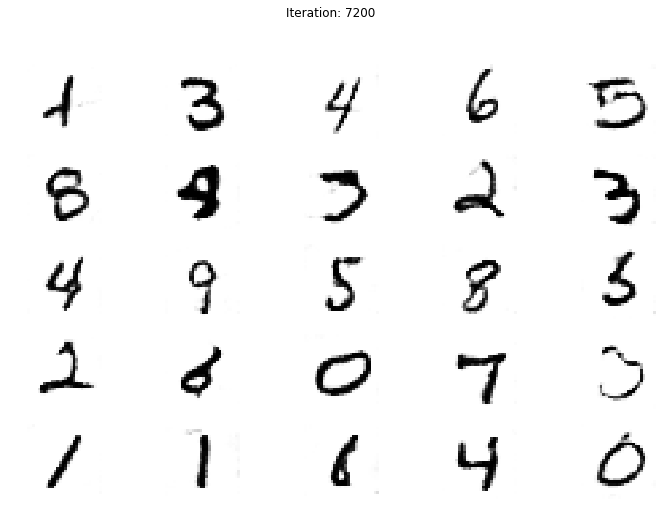

Iteration:  7201 [D loss: 0.69880, acc.:  53.52%] [G loss: 0.74101]
Iteration:  7202 [D loss: 0.69955, acc.:  52.73%] [G loss: 0.73466]
Iteration:  7203 [D loss: 0.69489, acc.:  53.12%] [G loss: 0.76850]
Iteration:  7204 [D loss: 0.69762, acc.:  49.61%] [G loss: 0.75529]
Iteration:  7205 [D loss: 0.72392, acc.:  45.70%] [G loss: 0.74093]
Iteration:  7206 [D loss: 0.71196, acc.:  49.22%] [G loss: 0.76986]
Iteration:  7207 [D loss: 0.71880, acc.:  44.92%] [G loss: 0.77114]
Iteration:  7208 [D loss: 0.70852, acc.:  50.39%] [G loss: 0.74648]
Iteration:  7209 [D loss: 0.71306, acc.:  53.91%] [G loss: 0.77307]
Iteration:  7210 [D loss: 0.68558, acc.:  52.34%] [G loss: 0.77788]
Iteration:  7211 [D loss: 0.70150, acc.:  50.39%] [G loss: 0.76024]
Iteration:  7212 [D loss: 0.72009, acc.:  46.09%] [G loss: 0.77337]
Iteration:  7213 [D loss: 0.72239, acc.:  47.66%] [G loss: 0.76674]
Iteration:  7214 [D loss: 0.70418, acc.:  51.95%] [G loss: 0.77358]
Iteration:  7215 [D loss: 0.72055, acc.:  46.88%

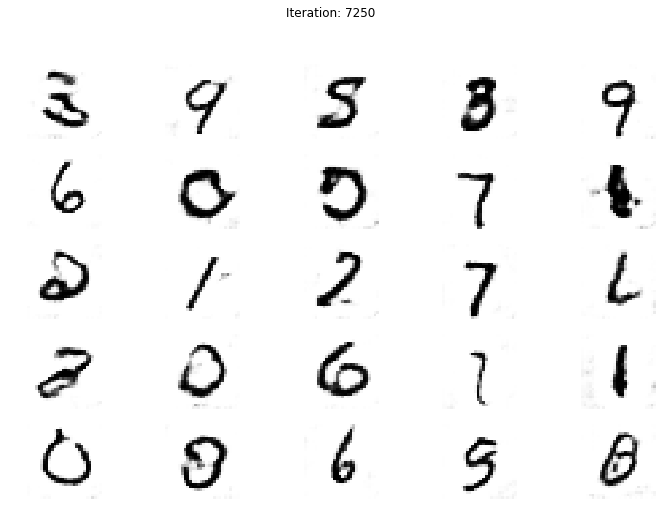

Iteration:  7251 [D loss: 0.68681, acc.:  56.25%] [G loss: 0.74867]
Iteration:  7252 [D loss: 0.71098, acc.:  46.09%] [G loss: 0.75854]
Iteration:  7253 [D loss: 0.71119, acc.:  50.78%] [G loss: 0.76849]
Iteration:  7254 [D loss: 0.71098, acc.:  48.83%] [G loss: 0.77024]
Iteration:  7255 [D loss: 0.70435, acc.:  48.44%] [G loss: 0.75435]
Iteration:  7256 [D loss: 0.71327, acc.:  44.53%] [G loss: 0.77621]
Iteration:  7257 [D loss: 0.69971, acc.:  51.95%] [G loss: 0.78460]
Iteration:  7258 [D loss: 0.71905, acc.:  44.53%] [G loss: 0.76948]
Iteration:  7259 [D loss: 0.72113, acc.:  43.75%] [G loss: 0.77100]
Iteration:  7260 [D loss: 0.71881, acc.:  48.83%] [G loss: 0.77172]
Iteration:  7261 [D loss: 0.69893, acc.:  49.61%] [G loss: 0.76411]
Iteration:  7262 [D loss: 0.71006, acc.:  49.61%] [G loss: 0.74341]
Iteration:  7263 [D loss: 0.69699, acc.:  56.64%] [G loss: 0.76906]
Iteration:  7264 [D loss: 0.69612, acc.:  52.73%] [G loss: 0.77899]
Iteration:  7265 [D loss: 0.71759, acc.:  44.92%

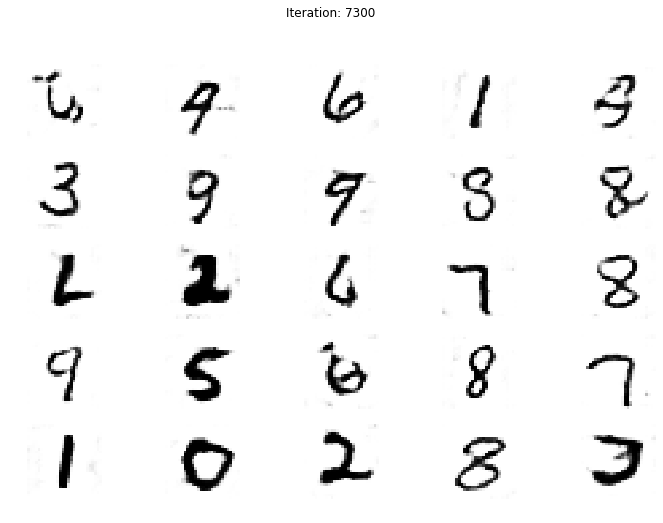

Iteration:  7301 [D loss: 0.69986, acc.:  53.12%] [G loss: 0.75352]
Iteration:  7302 [D loss: 0.72650, acc.:  44.53%] [G loss: 0.75874]
Iteration:  7303 [D loss: 0.68749, acc.:  51.95%] [G loss: 0.77392]
Iteration:  7304 [D loss: 0.70427, acc.:  51.56%] [G loss: 0.77938]
Iteration:  7305 [D loss: 0.70202, acc.:  50.78%] [G loss: 0.75352]
Iteration:  7306 [D loss: 0.70889, acc.:  50.00%] [G loss: 0.75012]
Iteration:  7307 [D loss: 0.70644, acc.:  52.73%] [G loss: 0.72875]
Iteration:  7308 [D loss: 0.69937, acc.:  53.52%] [G loss: 0.76203]
Iteration:  7309 [D loss: 0.69937, acc.:  50.39%] [G loss: 0.75262]
Iteration:  7310 [D loss: 0.71558, acc.:  47.66%] [G loss: 0.74599]
Iteration:  7311 [D loss: 0.71876, acc.:  47.27%] [G loss: 0.77282]
Iteration:  7312 [D loss: 0.73518, acc.:  42.19%] [G loss: 0.73867]
Iteration:  7313 [D loss: 0.71229, acc.:  47.66%] [G loss: 0.76353]
Iteration:  7314 [D loss: 0.69913, acc.:  48.83%] [G loss: 0.76242]
Iteration:  7315 [D loss: 0.70102, acc.:  50.78%

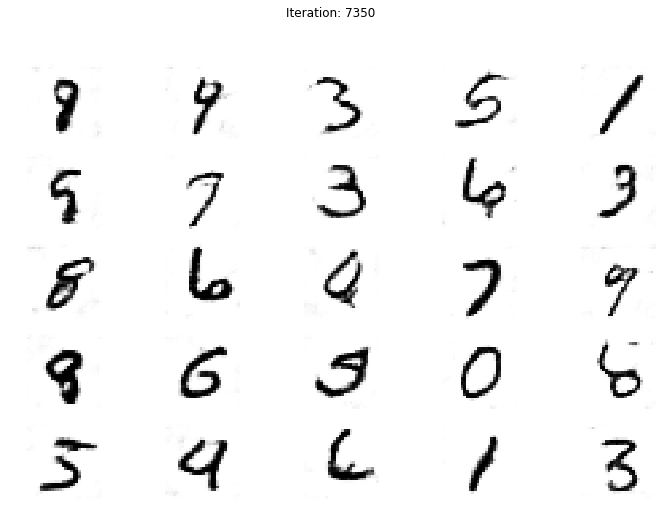

Iteration:  7351 [D loss: 0.69119, acc.:  54.30%] [G loss: 0.75646]
Iteration:  7352 [D loss: 0.71495, acc.:  46.09%] [G loss: 0.75841]
Iteration:  7353 [D loss: 0.69979, acc.:  52.34%] [G loss: 0.76268]
Iteration:  7354 [D loss: 0.71570, acc.:  44.92%] [G loss: 0.75280]
Iteration:  7355 [D loss: 0.68420, acc.:  53.12%] [G loss: 0.74775]
Iteration:  7356 [D loss: 0.69614, acc.:  51.95%] [G loss: 0.77871]
Iteration:  7357 [D loss: 0.69699, acc.:  51.56%] [G loss: 0.76627]
Iteration:  7358 [D loss: 0.71414, acc.:  49.61%] [G loss: 0.77193]
Iteration:  7359 [D loss: 0.71625, acc.:  46.88%] [G loss: 0.75057]
Iteration:  7360 [D loss: 0.71915, acc.:  49.22%] [G loss: 0.76973]
Iteration:  7361 [D loss: 0.69716, acc.:  52.34%] [G loss: 0.75823]
Iteration:  7362 [D loss: 0.68389, acc.:  57.81%] [G loss: 0.76893]
Iteration:  7363 [D loss: 0.70300, acc.:  49.22%] [G loss: 0.73013]
Iteration:  7364 [D loss: 0.70090, acc.:  51.95%] [G loss: 0.73969]
Iteration:  7365 [D loss: 0.70752, acc.:  51.17%

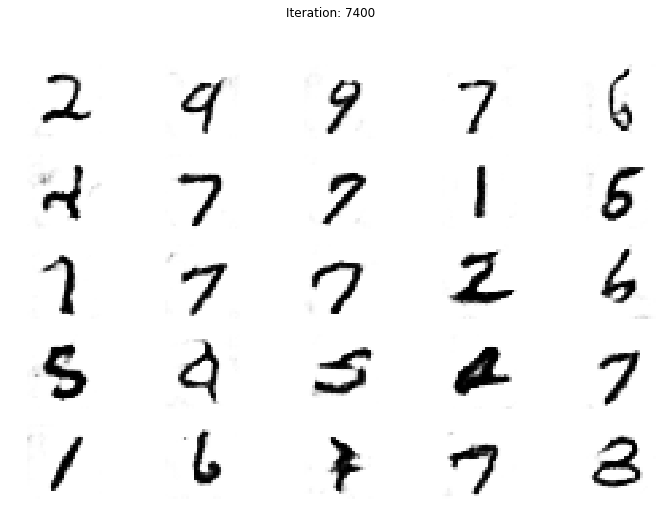

Iteration:  7401 [D loss: 0.70924, acc.:  52.73%] [G loss: 0.75983]
Iteration:  7402 [D loss: 0.72086, acc.:  48.83%] [G loss: 0.75458]
Iteration:  7403 [D loss: 0.71357, acc.:  44.92%] [G loss: 0.79176]
Iteration:  7404 [D loss: 0.72644, acc.:  46.48%] [G loss: 0.73824]
Iteration:  7405 [D loss: 0.70198, acc.:  50.78%] [G loss: 0.73517]
Iteration:  7406 [D loss: 0.71184, acc.:  46.09%] [G loss: 0.75405]
Iteration:  7407 [D loss: 0.70521, acc.:  50.78%] [G loss: 0.76126]
Iteration:  7408 [D loss: 0.70353, acc.:  48.05%] [G loss: 0.77263]
Iteration:  7409 [D loss: 0.69541, acc.:  50.78%] [G loss: 0.75295]
Iteration:  7410 [D loss: 0.69121, acc.:  51.56%] [G loss: 0.76832]
Iteration:  7411 [D loss: 0.71897, acc.:  46.88%] [G loss: 0.75090]
Iteration:  7412 [D loss: 0.73054, acc.:  42.19%] [G loss: 0.76439]
Iteration:  7413 [D loss: 0.70395, acc.:  50.00%] [G loss: 0.73070]
Iteration:  7414 [D loss: 0.69741, acc.:  53.91%] [G loss: 0.77365]
Iteration:  7415 [D loss: 0.68830, acc.:  55.08%

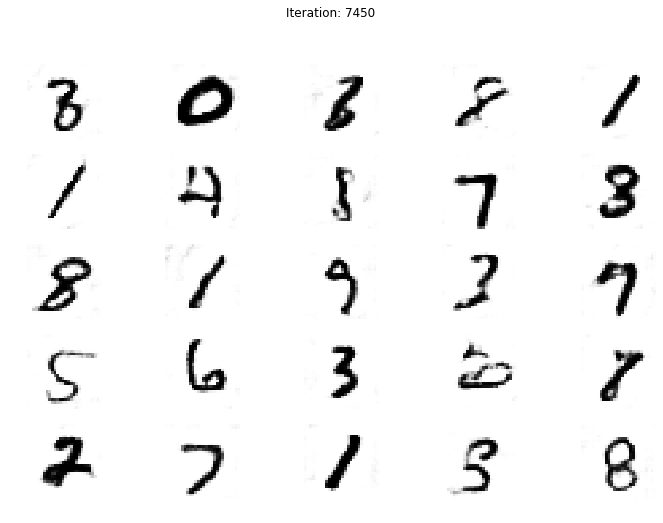

Iteration:  7451 [D loss: 0.70449, acc.:  50.00%] [G loss: 0.75910]
Iteration:  7452 [D loss: 0.69508, acc.:  53.91%] [G loss: 0.72492]
Iteration:  7453 [D loss: 0.69440, acc.:  53.52%] [G loss: 0.77964]
Iteration:  7454 [D loss: 0.68737, acc.:  53.91%] [G loss: 0.75498]
Iteration:  7455 [D loss: 0.69002, acc.:  50.00%] [G loss: 0.76942]
Iteration:  7456 [D loss: 0.70107, acc.:  46.48%] [G loss: 0.75417]
Iteration:  7457 [D loss: 0.72243, acc.:  48.83%] [G loss: 0.77792]
Iteration:  7458 [D loss: 0.69442, acc.:  53.52%] [G loss: 0.77256]
Iteration:  7459 [D loss: 0.71039, acc.:  47.66%] [G loss: 0.74719]
Iteration:  7460 [D loss: 0.70068, acc.:  55.08%] [G loss: 0.74001]
Iteration:  7461 [D loss: 0.68811, acc.:  53.52%] [G loss: 0.76074]
Iteration:  7462 [D loss: 0.70375, acc.:  52.34%] [G loss: 0.74551]
Iteration:  7463 [D loss: 0.72494, acc.:  47.66%] [G loss: 0.74995]
Iteration:  7464 [D loss: 0.70226, acc.:  53.52%] [G loss: 0.78441]
Iteration:  7465 [D loss: 0.71318, acc.:  47.66%

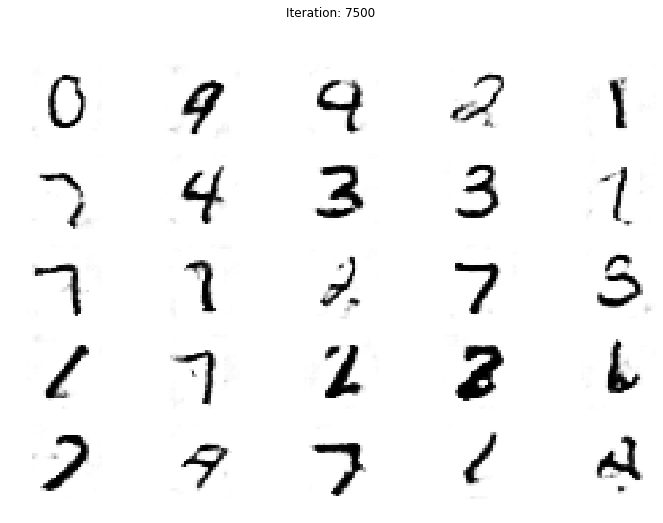

Iteration:  7501 [D loss: 0.73433, acc.:  42.19%] [G loss: 0.76583]
Iteration:  7502 [D loss: 0.71802, acc.:  48.05%] [G loss: 0.76177]
Iteration:  7503 [D loss: 0.68152, acc.:  57.03%] [G loss: 0.73111]
Iteration:  7504 [D loss: 0.70537, acc.:  47.27%] [G loss: 0.78170]
Iteration:  7505 [D loss: 0.69822, acc.:  50.39%] [G loss: 0.78695]
Iteration:  7506 [D loss: 0.69029, acc.:  51.17%] [G loss: 0.77154]
Iteration:  7507 [D loss: 0.70516, acc.:  52.73%] [G loss: 0.77486]
Iteration:  7508 [D loss: 0.68806, acc.:  56.25%] [G loss: 0.79515]
Iteration:  7509 [D loss: 0.69734, acc.:  53.52%] [G loss: 0.76289]
Iteration:  7510 [D loss: 0.69635, acc.:  55.08%] [G loss: 0.77581]
Iteration:  7511 [D loss: 0.70673, acc.:  51.95%] [G loss: 0.76110]
Iteration:  7512 [D loss: 0.69762, acc.:  50.39%] [G loss: 0.76076]
Iteration:  7513 [D loss: 0.72379, acc.:  44.14%] [G loss: 0.76327]
Iteration:  7514 [D loss: 0.73676, acc.:  41.41%] [G loss: 0.79517]
Iteration:  7515 [D loss: 0.70433, acc.:  48.44%

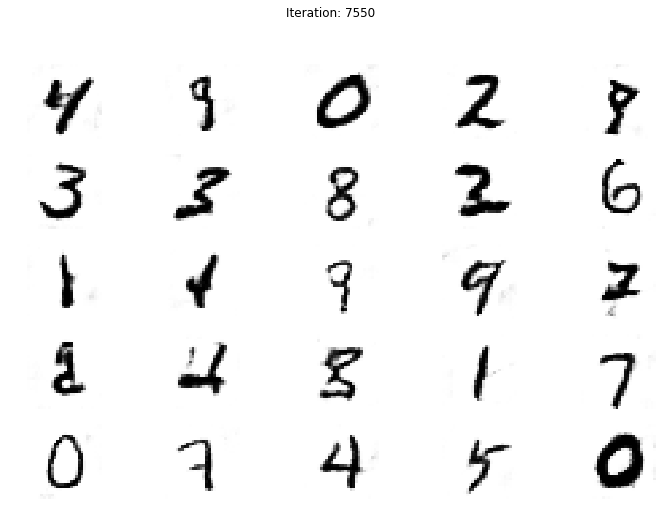

Iteration:  7551 [D loss: 0.70433, acc.:  51.17%] [G loss: 0.75540]
Iteration:  7552 [D loss: 0.68733, acc.:  54.69%] [G loss: 0.75990]
Iteration:  7553 [D loss: 0.69904, acc.:  48.44%] [G loss: 0.79014]
Iteration:  7554 [D loss: 0.69467, acc.:  53.12%] [G loss: 0.74078]
Iteration:  7555 [D loss: 0.71817, acc.:  44.53%] [G loss: 0.77079]
Iteration:  7556 [D loss: 0.70621, acc.:  51.95%] [G loss: 0.73523]
Iteration:  7557 [D loss: 0.71032, acc.:  48.83%] [G loss: 0.77782]
Iteration:  7558 [D loss: 0.69622, acc.:  53.12%] [G loss: 0.77119]
Iteration:  7559 [D loss: 0.71449, acc.:  52.73%] [G loss: 0.75829]
Iteration:  7560 [D loss: 0.71635, acc.:  48.05%] [G loss: 0.79123]
Iteration:  7561 [D loss: 0.70190, acc.:  51.17%] [G loss: 0.76172]
Iteration:  7562 [D loss: 0.72356, acc.:  50.00%] [G loss: 0.76002]
Iteration:  7563 [D loss: 0.72124, acc.:  44.53%] [G loss: 0.76094]
Iteration:  7564 [D loss: 0.71212, acc.:  46.88%] [G loss: 0.76584]
Iteration:  7565 [D loss: 0.68050, acc.:  54.30%

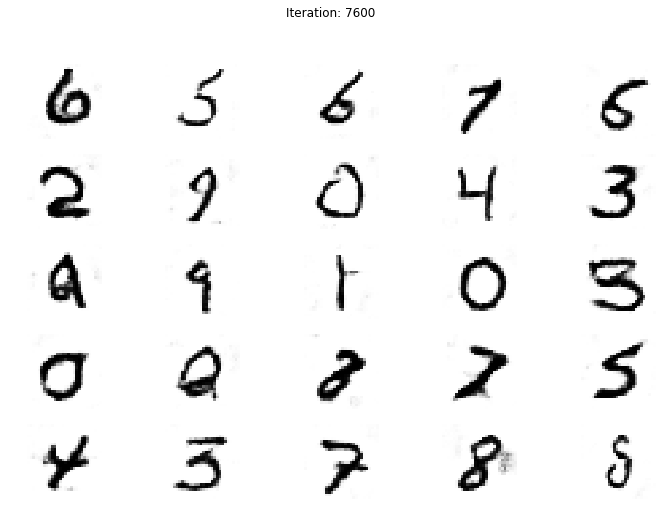

Iteration:  7601 [D loss: 0.70110, acc.:  49.61%] [G loss: 0.75050]
Iteration:  7602 [D loss: 0.69053, acc.:  56.64%] [G loss: 0.77700]
Iteration:  7603 [D loss: 0.69740, acc.:  52.34%] [G loss: 0.74800]
Iteration:  7604 [D loss: 0.71978, acc.:  47.66%] [G loss: 0.75893]
Iteration:  7605 [D loss: 0.70026, acc.:  51.17%] [G loss: 0.77827]
Iteration:  7606 [D loss: 0.70929, acc.:  48.83%] [G loss: 0.75114]
Iteration:  7607 [D loss: 0.69568, acc.:  55.08%] [G loss: 0.74384]
Iteration:  7608 [D loss: 0.71324, acc.:  47.66%] [G loss: 0.77152]
Iteration:  7609 [D loss: 0.71070, acc.:  51.95%] [G loss: 0.76908]
Iteration:  7610 [D loss: 0.70338, acc.:  49.61%] [G loss: 0.73008]
Iteration:  7611 [D loss: 0.70439, acc.:  47.27%] [G loss: 0.78026]
Iteration:  7612 [D loss: 0.72463, acc.:  43.75%] [G loss: 0.75559]
Iteration:  7613 [D loss: 0.70634, acc.:  53.52%] [G loss: 0.75193]
Iteration:  7614 [D loss: 0.71438, acc.:  49.22%] [G loss: 0.73282]
Iteration:  7615 [D loss: 0.70607, acc.:  50.00%

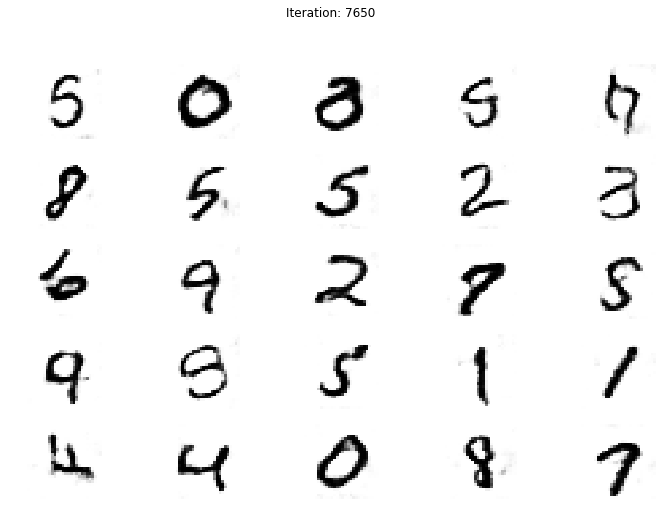

Iteration:  7651 [D loss: 0.72026, acc.:  45.70%] [G loss: 0.75918]
Iteration:  7652 [D loss: 0.69929, acc.:  50.78%] [G loss: 0.75043]
Iteration:  7653 [D loss: 0.72142, acc.:  44.14%] [G loss: 0.74288]
Iteration:  7654 [D loss: 0.69626, acc.:  52.73%] [G loss: 0.76634]
Iteration:  7655 [D loss: 0.70529, acc.:  51.56%] [G loss: 0.75915]
Iteration:  7656 [D loss: 0.72105, acc.:  47.27%] [G loss: 0.75268]
Iteration:  7657 [D loss: 0.70299, acc.:  50.00%] [G loss: 0.76453]
Iteration:  7658 [D loss: 0.70258, acc.:  52.73%] [G loss: 0.74130]
Iteration:  7659 [D loss: 0.69229, acc.:  50.00%] [G loss: 0.74113]
Iteration:  7660 [D loss: 0.69786, acc.:  53.12%] [G loss: 0.72124]
Iteration:  7661 [D loss: 0.70902, acc.:  49.61%] [G loss: 0.72078]
Iteration:  7662 [D loss: 0.72194, acc.:  43.75%] [G loss: 0.72848]
Iteration:  7663 [D loss: 0.68826, acc.:  57.03%] [G loss: 0.77690]
Iteration:  7664 [D loss: 0.68802, acc.:  54.30%] [G loss: 0.74838]
Iteration:  7665 [D loss: 0.71010, acc.:  50.39%

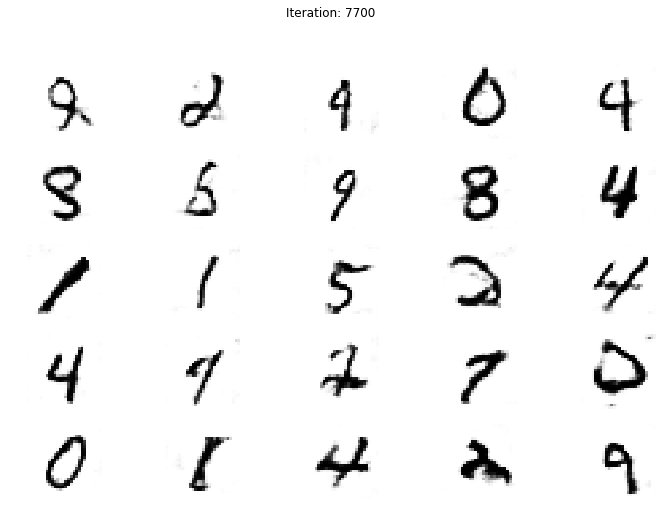

Iteration:  7701 [D loss: 0.70701, acc.:  50.39%] [G loss: 0.76210]
Iteration:  7702 [D loss: 0.70621, acc.:  50.39%] [G loss: 0.73896]
Iteration:  7703 [D loss: 0.70328, acc.:  51.56%] [G loss: 0.75232]
Iteration:  7704 [D loss: 0.70508, acc.:  49.61%] [G loss: 0.74959]
Iteration:  7705 [D loss: 0.69233, acc.:  57.42%] [G loss: 0.74311]
Iteration:  7706 [D loss: 0.72371, acc.:  43.36%] [G loss: 0.75743]
Iteration:  7707 [D loss: 0.70215, acc.:  55.47%] [G loss: 0.73935]
Iteration:  7708 [D loss: 0.72523, acc.:  43.36%] [G loss: 0.73233]
Iteration:  7709 [D loss: 0.69664, acc.:  51.56%] [G loss: 0.73492]
Iteration:  7710 [D loss: 0.69893, acc.:  50.00%] [G loss: 0.76752]
Iteration:  7711 [D loss: 0.67765, acc.:  56.25%] [G loss: 0.78046]
Iteration:  7712 [D loss: 0.71973, acc.:  46.88%] [G loss: 0.76289]
Iteration:  7713 [D loss: 0.68967, acc.:  53.12%] [G loss: 0.75527]
Iteration:  7714 [D loss: 0.69110, acc.:  52.73%] [G loss: 0.76241]
Iteration:  7715 [D loss: 0.70876, acc.:  47.66%

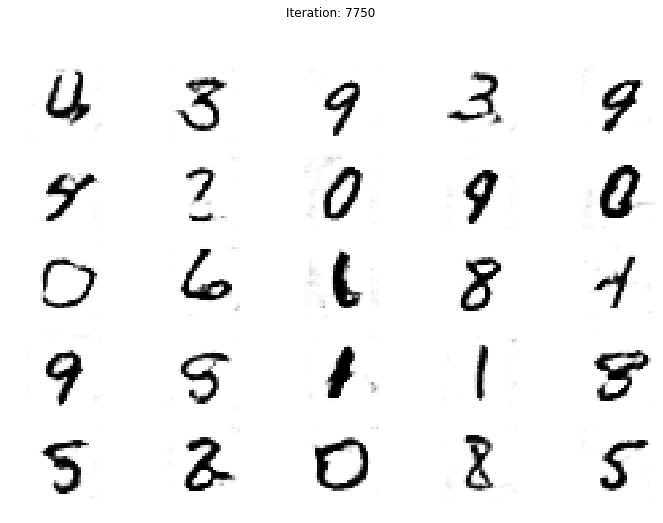

Iteration:  7751 [D loss: 0.71901, acc.:  47.27%] [G loss: 0.74053]
Iteration:  7752 [D loss: 0.69356, acc.:  49.22%] [G loss: 0.74982]
Iteration:  7753 [D loss: 0.69686, acc.:  50.78%] [G loss: 0.75268]
Iteration:  7754 [D loss: 0.72556, acc.:  42.97%] [G loss: 0.74779]
Iteration:  7755 [D loss: 0.70531, acc.:  50.00%] [G loss: 0.76267]
Iteration:  7756 [D loss: 0.69720, acc.:  51.56%] [G loss: 0.75135]
Iteration:  7757 [D loss: 0.71674, acc.:  51.56%] [G loss: 0.74564]
Iteration:  7758 [D loss: 0.69968, acc.:  50.78%] [G loss: 0.75099]
Iteration:  7759 [D loss: 0.70071, acc.:  52.73%] [G loss: 0.74695]
Iteration:  7760 [D loss: 0.70187, acc.:  51.56%] [G loss: 0.78497]
Iteration:  7761 [D loss: 0.71051, acc.:  48.05%] [G loss: 0.77042]
Iteration:  7762 [D loss: 0.70437, acc.:  50.39%] [G loss: 0.74920]
Iteration:  7763 [D loss: 0.71205, acc.:  46.48%] [G loss: 0.75291]
Iteration:  7764 [D loss: 0.71876, acc.:  45.70%] [G loss: 0.74692]
Iteration:  7765 [D loss: 0.73117, acc.:  40.62%

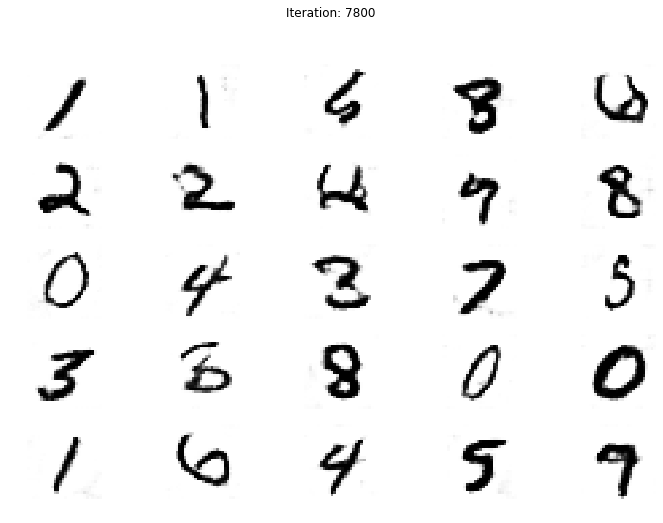

Iteration:  7801 [D loss: 0.72989, acc.:  46.88%] [G loss: 0.73242]
Iteration:  7802 [D loss: 0.70781, acc.:  51.17%] [G loss: 0.74410]
Iteration:  7803 [D loss: 0.72059, acc.:  45.31%] [G loss: 0.73086]
Iteration:  7804 [D loss: 0.70915, acc.:  46.48%] [G loss: 0.72601]
Iteration:  7805 [D loss: 0.70641, acc.:  49.22%] [G loss: 0.75755]
Iteration:  7806 [D loss: 0.70442, acc.:  50.78%] [G loss: 0.76383]
Iteration:  7807 [D loss: 0.73792, acc.:  44.14%] [G loss: 0.77133]
Iteration:  7808 [D loss: 0.71543, acc.:  48.05%] [G loss: 0.76343]
Iteration:  7809 [D loss: 0.68160, acc.:  53.52%] [G loss: 0.78881]
Iteration:  7810 [D loss: 0.70696, acc.:  50.00%] [G loss: 0.76503]
Iteration:  7811 [D loss: 0.70981, acc.:  49.61%] [G loss: 0.77650]
Iteration:  7812 [D loss: 0.70943, acc.:  52.73%] [G loss: 0.76277]
Iteration:  7813 [D loss: 0.69890, acc.:  53.91%] [G loss: 0.77275]
Iteration:  7814 [D loss: 0.70898, acc.:  47.27%] [G loss: 0.78393]
Iteration:  7815 [D loss: 0.70894, acc.:  49.61%

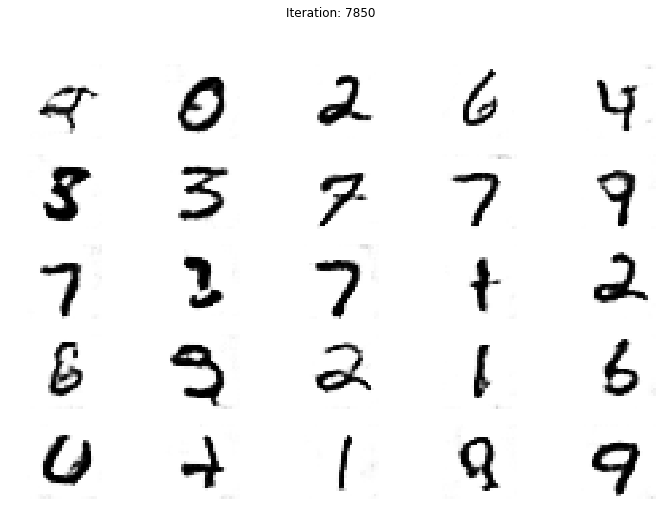

Iteration:  7851 [D loss: 0.69588, acc.:  51.95%] [G loss: 0.73794]
Iteration:  7852 [D loss: 0.69482, acc.:  54.30%] [G loss: 0.75533]
Iteration:  7853 [D loss: 0.70087, acc.:  50.78%] [G loss: 0.72959]
Iteration:  7854 [D loss: 0.69236, acc.:  53.91%] [G loss: 0.74311]
Iteration:  7855 [D loss: 0.70211, acc.:  51.17%] [G loss: 0.72966]
Iteration:  7856 [D loss: 0.68890, acc.:  52.34%] [G loss: 0.75822]
Iteration:  7857 [D loss: 0.70993, acc.:  48.83%] [G loss: 0.74641]
Iteration:  7858 [D loss: 0.70108, acc.:  49.61%] [G loss: 0.76837]
Iteration:  7859 [D loss: 0.70996, acc.:  44.92%] [G loss: 0.75112]
Iteration:  7860 [D loss: 0.69283, acc.:  56.25%] [G loss: 0.73758]
Iteration:  7861 [D loss: 0.70719, acc.:  50.00%] [G loss: 0.78075]
Iteration:  7862 [D loss: 0.71311, acc.:  51.17%] [G loss: 0.76129]
Iteration:  7863 [D loss: 0.69755, acc.:  53.12%] [G loss: 0.77874]
Iteration:  7864 [D loss: 0.70456, acc.:  49.22%] [G loss: 0.77164]
Iteration:  7865 [D loss: 0.71256, acc.:  47.66%

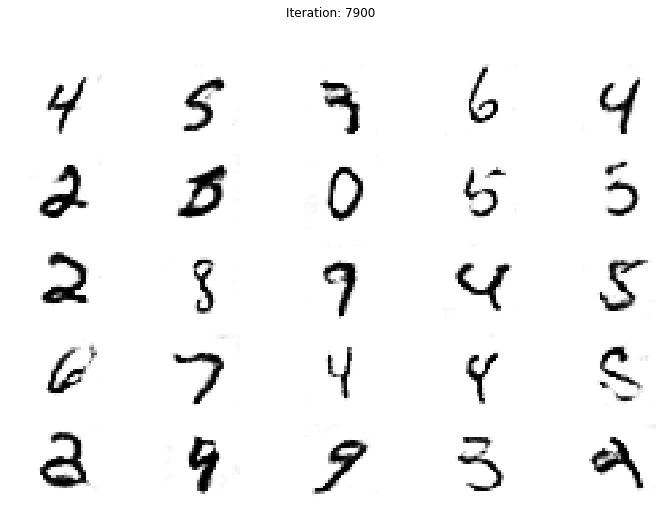

Iteration:  7901 [D loss: 0.69502, acc.:  49.61%] [G loss: 0.77062]
Iteration:  7902 [D loss: 0.69747, acc.:  48.44%] [G loss: 0.72004]
Iteration:  7903 [D loss: 0.71012, acc.:  48.05%] [G loss: 0.75317]
Iteration:  7904 [D loss: 0.69924, acc.:  49.61%] [G loss: 0.77330]
Iteration:  7905 [D loss: 0.69737, acc.:  51.56%] [G loss: 0.75230]
Iteration:  7906 [D loss: 0.69280, acc.:  55.08%] [G loss: 0.74960]
Iteration:  7907 [D loss: 0.70245, acc.:  53.12%] [G loss: 0.73013]
Iteration:  7908 [D loss: 0.71012, acc.:  49.22%] [G loss: 0.77298]
Iteration:  7909 [D loss: 0.71837, acc.:  48.83%] [G loss: 0.76191]
Iteration:  7910 [D loss: 0.68578, acc.:  58.59%] [G loss: 0.72831]
Iteration:  7911 [D loss: 0.70173, acc.:  48.05%] [G loss: 0.73650]
Iteration:  7912 [D loss: 0.69534, acc.:  50.00%] [G loss: 0.75560]
Iteration:  7913 [D loss: 0.71652, acc.:  48.44%] [G loss: 0.77004]
Iteration:  7914 [D loss: 0.70614, acc.:  48.44%] [G loss: 0.77578]
Iteration:  7915 [D loss: 0.71547, acc.:  49.61%

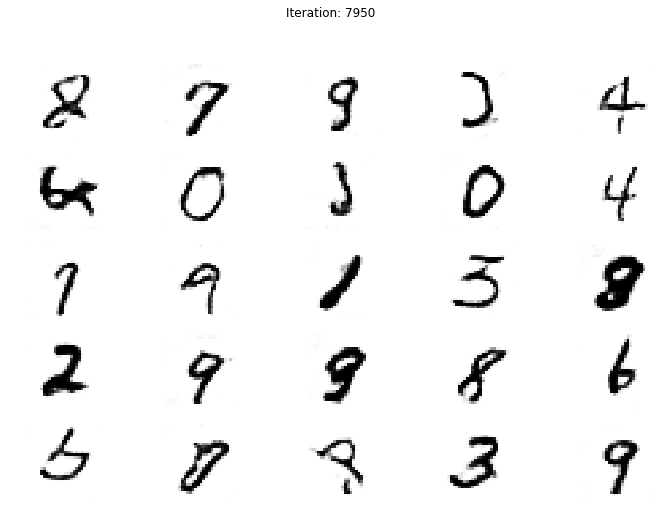

Iteration:  7951 [D loss: 0.69774, acc.:  51.95%] [G loss: 0.72483]
Iteration:  7952 [D loss: 0.70817, acc.:  50.00%] [G loss: 0.75090]
Iteration:  7953 [D loss: 0.70973, acc.:  52.34%] [G loss: 0.74376]
Iteration:  7954 [D loss: 0.70095, acc.:  52.34%] [G loss: 0.73243]
Iteration:  7955 [D loss: 0.72390, acc.:  40.23%] [G loss: 0.73254]
Iteration:  7956 [D loss: 0.69879, acc.:  49.61%] [G loss: 0.71623]
Iteration:  7957 [D loss: 0.72313, acc.:  46.09%] [G loss: 0.77389]
Iteration:  7958 [D loss: 0.69993, acc.:  53.12%] [G loss: 0.74480]
Iteration:  7959 [D loss: 0.71829, acc.:  44.92%] [G loss: 0.73664]
Iteration:  7960 [D loss: 0.70867, acc.:  49.22%] [G loss: 0.77825]
Iteration:  7961 [D loss: 0.69346, acc.:  54.69%] [G loss: 0.77020]
Iteration:  7962 [D loss: 0.68520, acc.:  55.08%] [G loss: 0.76150]
Iteration:  7963 [D loss: 0.67985, acc.:  58.59%] [G loss: 0.73172]
Iteration:  7964 [D loss: 0.69605, acc.:  51.17%] [G loss: 0.73273]
Iteration:  7965 [D loss: 0.71072, acc.:  49.22%

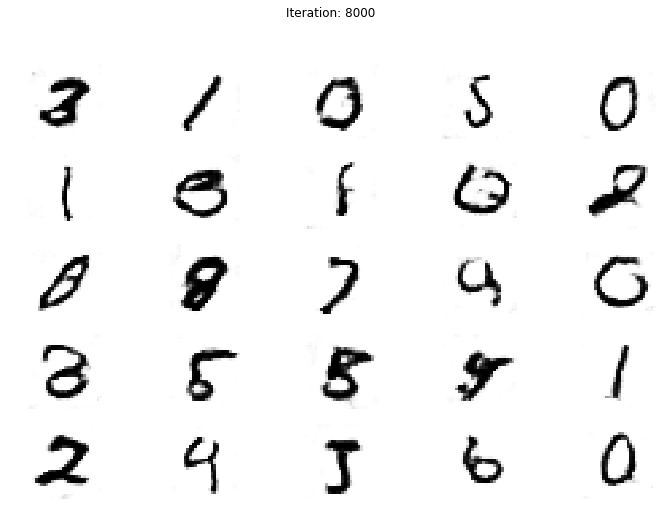

Iteration:  8001 [D loss: 0.72369, acc.:  44.53%] [G loss: 0.74264]
Iteration:  8002 [D loss: 0.70369, acc.:  52.34%] [G loss: 0.75781]
Iteration:  8003 [D loss: 0.69505, acc.:  53.91%] [G loss: 0.75066]
Iteration:  8004 [D loss: 0.70015, acc.:  50.39%] [G loss: 0.74185]
Iteration:  8005 [D loss: 0.69523, acc.:  51.17%] [G loss: 0.77587]
Iteration:  8006 [D loss: 0.69849, acc.:  51.95%] [G loss: 0.76970]
Iteration:  8007 [D loss: 0.72482, acc.:  48.05%] [G loss: 0.73862]
Iteration:  8008 [D loss: 0.68998, acc.:  53.12%] [G loss: 0.74487]
Iteration:  8009 [D loss: 0.68028, acc.:  56.64%] [G loss: 0.74305]
Iteration:  8010 [D loss: 0.69801, acc.:  52.73%] [G loss: 0.76245]
Iteration:  8011 [D loss: 0.69643, acc.:  54.69%] [G loss: 0.76089]
Iteration:  8012 [D loss: 0.70638, acc.:  48.05%] [G loss: 0.73447]
Iteration:  8013 [D loss: 0.69847, acc.:  53.91%] [G loss: 0.74028]
Iteration:  8014 [D loss: 0.69631, acc.:  51.17%] [G loss: 0.75878]
Iteration:  8015 [D loss: 0.70660, acc.:  49.61%

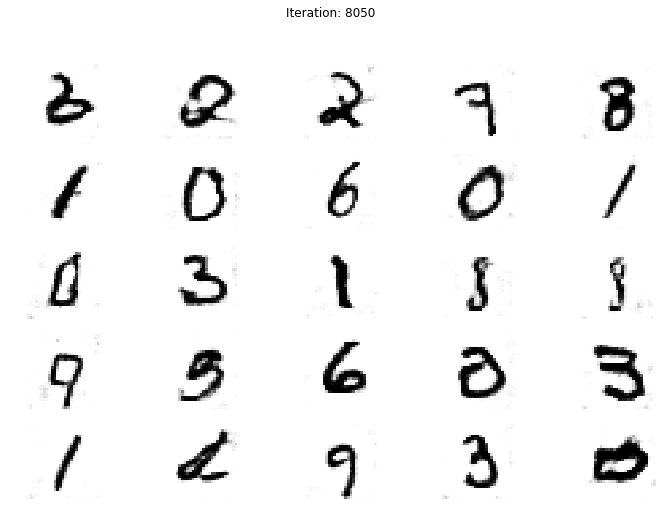

Iteration:  8051 [D loss: 0.68896, acc.:  54.69%] [G loss: 0.74015]
Iteration:  8052 [D loss: 0.70484, acc.:  49.22%] [G loss: 0.75110]
Iteration:  8053 [D loss: 0.71258, acc.:  44.92%] [G loss: 0.73963]
Iteration:  8054 [D loss: 0.69320, acc.:  50.39%] [G loss: 0.74261]
Iteration:  8055 [D loss: 0.69756, acc.:  51.17%] [G loss: 0.75843]
Iteration:  8056 [D loss: 0.69421, acc.:  49.61%] [G loss: 0.76725]
Iteration:  8057 [D loss: 0.71044, acc.:  44.14%] [G loss: 0.76806]
Iteration:  8058 [D loss: 0.69871, acc.:  49.61%] [G loss: 0.74355]
Iteration:  8059 [D loss: 0.70251, acc.:  51.95%] [G loss: 0.74975]
Iteration:  8060 [D loss: 0.70508, acc.:  50.78%] [G loss: 0.74913]
Iteration:  8061 [D loss: 0.70568, acc.:  50.39%] [G loss: 0.71542]
Iteration:  8062 [D loss: 0.69152, acc.:  57.42%] [G loss: 0.73772]
Iteration:  8063 [D loss: 0.70440, acc.:  50.78%] [G loss: 0.74214]
Iteration:  8064 [D loss: 0.69927, acc.:  51.95%] [G loss: 0.77392]
Iteration:  8065 [D loss: 0.71301, acc.:  50.78%

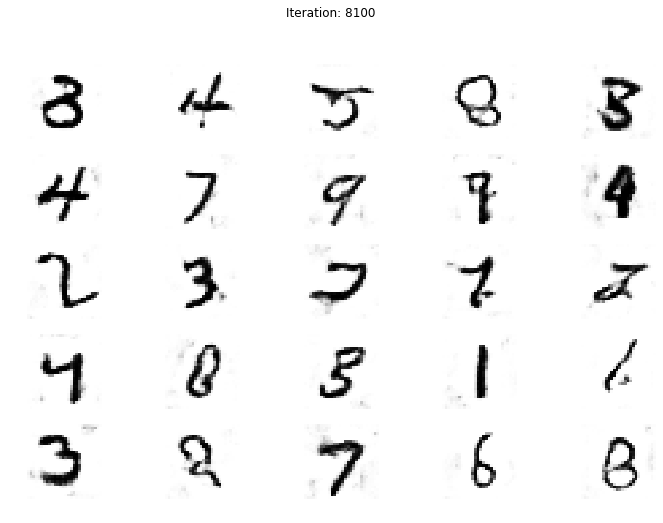

Iteration:  8101 [D loss: 0.70021, acc.:  55.08%] [G loss: 0.74010]
Iteration:  8102 [D loss: 0.71965, acc.:  43.75%] [G loss: 0.76157]
Iteration:  8103 [D loss: 0.71088, acc.:  45.31%] [G loss: 0.78022]
Iteration:  8104 [D loss: 0.69038, acc.:  52.34%] [G loss: 0.75880]
Iteration:  8105 [D loss: 0.70805, acc.:  50.00%] [G loss: 0.73569]
Iteration:  8106 [D loss: 0.71764, acc.:  45.70%] [G loss: 0.74906]
Iteration:  8107 [D loss: 0.71539, acc.:  46.88%] [G loss: 0.77913]
Iteration:  8108 [D loss: 0.69419, acc.:  56.64%] [G loss: 0.76567]
Iteration:  8109 [D loss: 0.70132, acc.:  50.78%] [G loss: 0.76729]
Iteration:  8110 [D loss: 0.71193, acc.:  48.83%] [G loss: 0.75241]
Iteration:  8111 [D loss: 0.70890, acc.:  51.17%] [G loss: 0.76935]
Iteration:  8112 [D loss: 0.69898, acc.:  49.22%] [G loss: 0.77637]
Iteration:  8113 [D loss: 0.68688, acc.:  55.08%] [G loss: 0.77955]
Iteration:  8114 [D loss: 0.70492, acc.:  52.73%] [G loss: 0.74079]
Iteration:  8115 [D loss: 0.71702, acc.:  48.05%

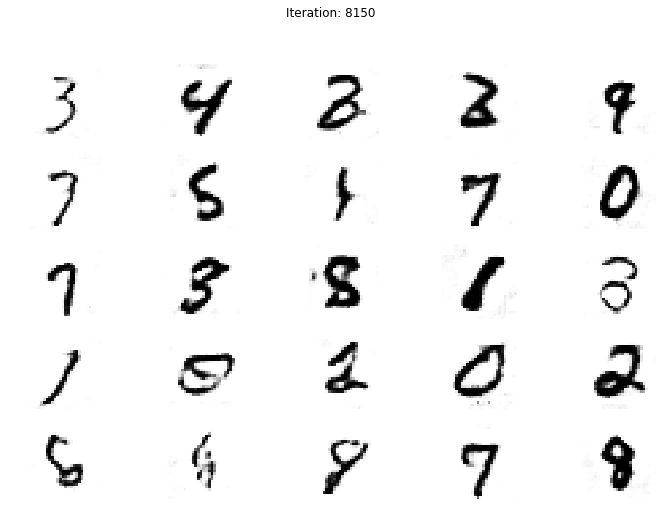

Iteration:  8151 [D loss: 0.71761, acc.:  46.09%] [G loss: 0.72589]
Iteration:  8152 [D loss: 0.70986, acc.:  48.05%] [G loss: 0.75144]
Iteration:  8153 [D loss: 0.71517, acc.:  45.31%] [G loss: 0.76721]
Iteration:  8154 [D loss: 0.69680, acc.:  53.52%] [G loss: 0.74386]
Iteration:  8155 [D loss: 0.71072, acc.:  51.17%] [G loss: 0.74390]
Iteration:  8156 [D loss: 0.71044, acc.:  51.56%] [G loss: 0.75890]
Iteration:  8157 [D loss: 0.72387, acc.:  48.44%] [G loss: 0.77556]
Iteration:  8158 [D loss: 0.71603, acc.:  45.31%] [G loss: 0.74121]
Iteration:  8159 [D loss: 0.69910, acc.:  53.52%] [G loss: 0.78306]
Iteration:  8160 [D loss: 0.72360, acc.:  46.09%] [G loss: 0.75653]
Iteration:  8161 [D loss: 0.71420, acc.:  49.22%] [G loss: 0.76296]
Iteration:  8162 [D loss: 0.70887, acc.:  50.39%] [G loss: 0.72564]
Iteration:  8163 [D loss: 0.73711, acc.:  44.14%] [G loss: 0.73837]
Iteration:  8164 [D loss: 0.71569, acc.:  48.05%] [G loss: 0.77733]
Iteration:  8165 [D loss: 0.71936, acc.:  45.70%

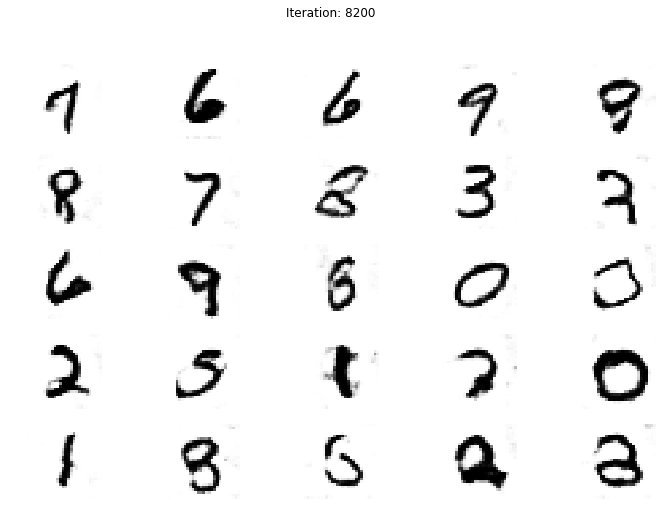

Iteration:  8201 [D loss: 0.70515, acc.:  49.61%] [G loss: 0.76091]
Iteration:  8202 [D loss: 0.70969, acc.:  48.83%] [G loss: 0.73960]
Iteration:  8203 [D loss: 0.70541, acc.:  51.95%] [G loss: 0.74437]
Iteration:  8204 [D loss: 0.71703, acc.:  47.66%] [G loss: 0.74471]
Iteration:  8205 [D loss: 0.68209, acc.:  58.59%] [G loss: 0.74791]
Iteration:  8206 [D loss: 0.69883, acc.:  51.56%] [G loss: 0.75602]
Iteration:  8207 [D loss: 0.70558, acc.:  53.12%] [G loss: 0.76340]
Iteration:  8208 [D loss: 0.70007, acc.:  51.95%] [G loss: 0.75495]
Iteration:  8209 [D loss: 0.68790, acc.:  53.52%] [G loss: 0.75584]
Iteration:  8210 [D loss: 0.69128, acc.:  52.34%] [G loss: 0.75751]
Iteration:  8211 [D loss: 0.69997, acc.:  51.95%] [G loss: 0.74151]
Iteration:  8212 [D loss: 0.70191, acc.:  51.95%] [G loss: 0.75584]
Iteration:  8213 [D loss: 0.71010, acc.:  48.44%] [G loss: 0.75385]
Iteration:  8214 [D loss: 0.69608, acc.:  51.17%] [G loss: 0.75899]
Iteration:  8215 [D loss: 0.71206, acc.:  44.92%

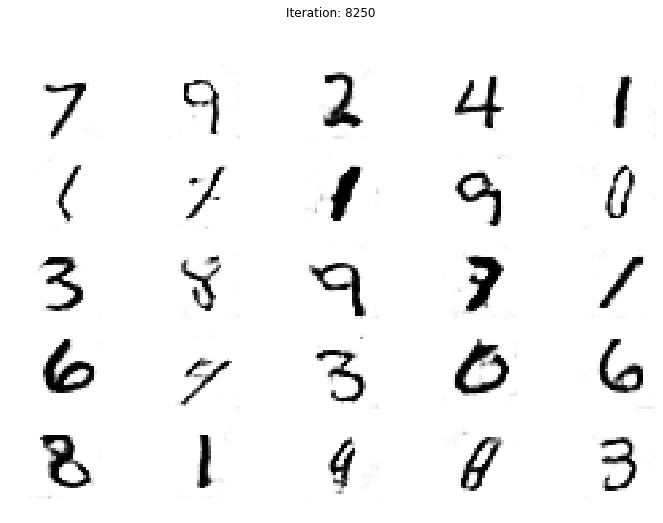

Iteration:  8251 [D loss: 0.71037, acc.:  47.66%] [G loss: 0.72419]
Iteration:  8252 [D loss: 0.69499, acc.:  50.00%] [G loss: 0.77190]
Iteration:  8253 [D loss: 0.70120, acc.:  51.56%] [G loss: 0.77199]
Iteration:  8254 [D loss: 0.69737, acc.:  55.08%] [G loss: 0.74236]
Iteration:  8255 [D loss: 0.70466, acc.:  49.22%] [G loss: 0.79754]
Iteration:  8256 [D loss: 0.70268, acc.:  50.39%] [G loss: 0.76988]
Iteration:  8257 [D loss: 0.70094, acc.:  54.69%] [G loss: 0.75711]
Iteration:  8258 [D loss: 0.69930, acc.:  46.88%] [G loss: 0.73384]
Iteration:  8259 [D loss: 0.72718, acc.:  39.06%] [G loss: 0.72559]
Iteration:  8260 [D loss: 0.71724, acc.:  42.97%] [G loss: 0.75095]
Iteration:  8261 [D loss: 0.69204, acc.:  51.17%] [G loss: 0.72200]
Iteration:  8262 [D loss: 0.70805, acc.:  47.27%] [G loss: 0.76009]
Iteration:  8263 [D loss: 0.69184, acc.:  54.30%] [G loss: 0.72020]
Iteration:  8264 [D loss: 0.70688, acc.:  47.27%] [G loss: 0.73093]
Iteration:  8265 [D loss: 0.71209, acc.:  48.44%

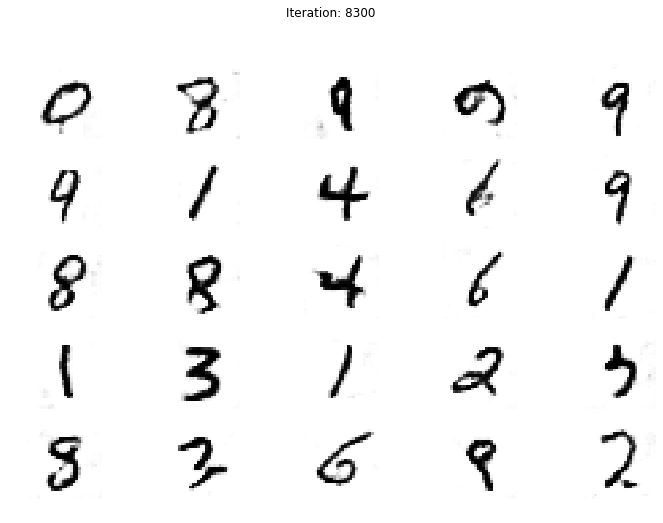

Iteration:  8301 [D loss: 0.68833, acc.:  53.12%] [G loss: 0.74692]
Iteration:  8302 [D loss: 0.70112, acc.:  50.78%] [G loss: 0.76258]
Iteration:  8303 [D loss: 0.70678, acc.:  50.78%] [G loss: 0.74380]
Iteration:  8304 [D loss: 0.71234, acc.:  47.66%] [G loss: 0.73319]
Iteration:  8305 [D loss: 0.71275, acc.:  48.44%] [G loss: 0.75081]
Iteration:  8306 [D loss: 0.71480, acc.:  45.31%] [G loss: 0.74450]
Iteration:  8307 [D loss: 0.71669, acc.:  45.31%] [G loss: 0.76097]
Iteration:  8308 [D loss: 0.70971, acc.:  47.27%] [G loss: 0.74332]
Iteration:  8309 [D loss: 0.69795, acc.:  51.95%] [G loss: 0.77843]
Iteration:  8310 [D loss: 0.71168, acc.:  47.27%] [G loss: 0.75155]
Iteration:  8311 [D loss: 0.70088, acc.:  53.91%] [G loss: 0.74033]
Iteration:  8312 [D loss: 0.71979, acc.:  45.31%] [G loss: 0.76197]
Iteration:  8313 [D loss: 0.68453, acc.:  53.52%] [G loss: 0.78543]
Iteration:  8314 [D loss: 0.69637, acc.:  55.08%] [G loss: 0.75269]
Iteration:  8315 [D loss: 0.71668, acc.:  45.31%

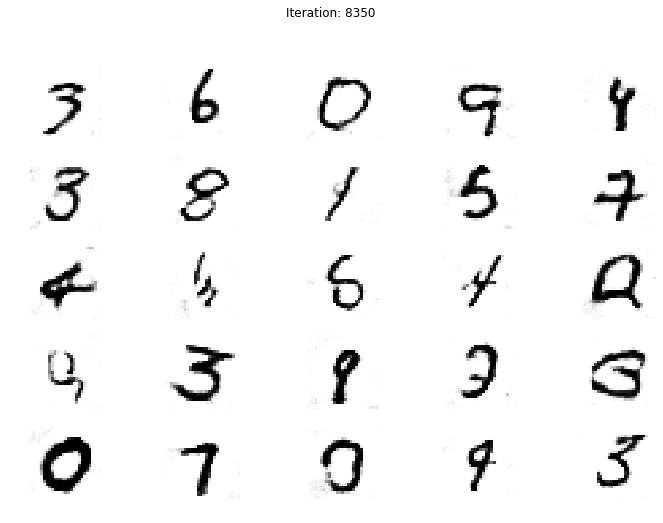

Iteration:  8351 [D loss: 0.69720, acc.:  51.17%] [G loss: 0.74832]
Iteration:  8352 [D loss: 0.70470, acc.:  52.73%] [G loss: 0.74267]
Iteration:  8353 [D loss: 0.72350, acc.:  50.39%] [G loss: 0.73399]
Iteration:  8354 [D loss: 0.69607, acc.:  52.73%] [G loss: 0.74475]
Iteration:  8355 [D loss: 0.68705, acc.:  54.69%] [G loss: 0.73915]
Iteration:  8356 [D loss: 0.69526, acc.:  52.73%] [G loss: 0.73816]
Iteration:  8357 [D loss: 0.71763, acc.:  45.31%] [G loss: 0.74074]
Iteration:  8358 [D loss: 0.69304, acc.:  54.69%] [G loss: 0.76596]
Iteration:  8359 [D loss: 0.69837, acc.:  50.39%] [G loss: 0.78001]
Iteration:  8360 [D loss: 0.69321, acc.:  50.39%] [G loss: 0.78156]
Iteration:  8361 [D loss: 0.68675, acc.:  55.08%] [G loss: 0.74351]
Iteration:  8362 [D loss: 0.71381, acc.:  45.31%] [G loss: 0.74416]
Iteration:  8363 [D loss: 0.71335, acc.:  45.70%] [G loss: 0.73977]
Iteration:  8364 [D loss: 0.72171, acc.:  44.14%] [G loss: 0.76723]
Iteration:  8365 [D loss: 0.68692, acc.:  50.39%

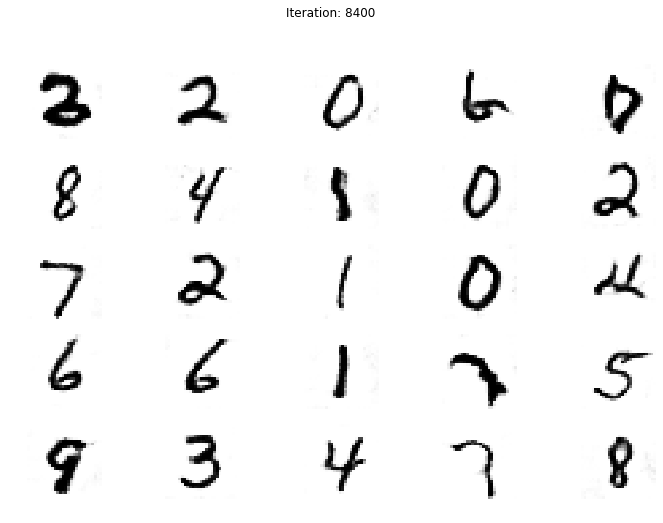

Iteration:  8401 [D loss: 0.70403, acc.:  50.39%] [G loss: 0.72882]
Iteration:  8402 [D loss: 0.70787, acc.:  50.78%] [G loss: 0.72828]
Iteration:  8403 [D loss: 0.70504, acc.:  51.56%] [G loss: 0.73873]
Iteration:  8404 [D loss: 0.70553, acc.:  49.61%] [G loss: 0.76930]
Iteration:  8405 [D loss: 0.71386, acc.:  48.83%] [G loss: 0.74983]
Iteration:  8406 [D loss: 0.69914, acc.:  51.17%] [G loss: 0.74504]
Iteration:  8407 [D loss: 0.69489, acc.:  58.98%] [G loss: 0.75083]
Iteration:  8408 [D loss: 0.70417, acc.:  47.66%] [G loss: 0.74863]
Iteration:  8409 [D loss: 0.72017, acc.:  46.88%] [G loss: 0.77605]
Iteration:  8410 [D loss: 0.71729, acc.:  48.83%] [G loss: 0.75408]
Iteration:  8411 [D loss: 0.68977, acc.:  53.12%] [G loss: 0.77196]
Iteration:  8412 [D loss: 0.73419, acc.:  42.19%] [G loss: 0.72384]
Iteration:  8413 [D loss: 0.71072, acc.:  49.61%] [G loss: 0.75039]
Iteration:  8414 [D loss: 0.72214, acc.:  44.53%] [G loss: 0.73102]
Iteration:  8415 [D loss: 0.70029, acc.:  51.56%

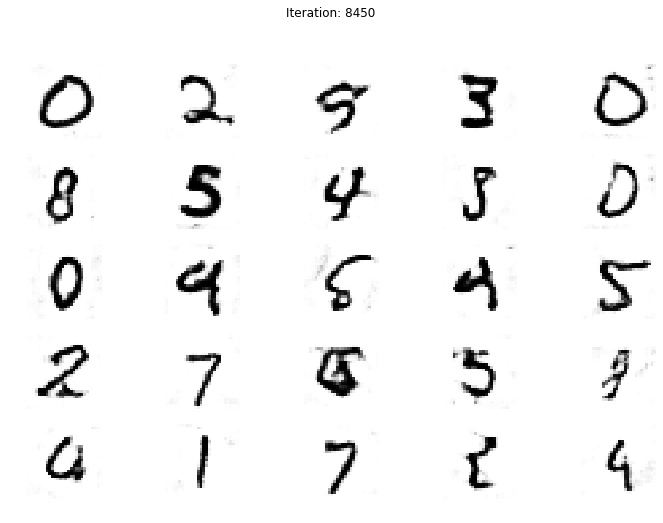

Iteration:  8451 [D loss: 0.71224, acc.:  50.78%] [G loss: 0.75092]
Iteration:  8452 [D loss: 0.68454, acc.:  57.42%] [G loss: 0.73225]
Iteration:  8453 [D loss: 0.69396, acc.:  50.78%] [G loss: 0.73349]
Iteration:  8454 [D loss: 0.69297, acc.:  51.17%] [G loss: 0.76062]
Iteration:  8455 [D loss: 0.72510, acc.:  42.19%] [G loss: 0.78131]
Iteration:  8456 [D loss: 0.69968, acc.:  48.05%] [G loss: 0.75776]
Iteration:  8457 [D loss: 0.72004, acc.:  46.48%] [G loss: 0.75912]
Iteration:  8458 [D loss: 0.69723, acc.:  53.91%] [G loss: 0.75204]
Iteration:  8459 [D loss: 0.70574, acc.:  49.61%] [G loss: 0.73486]
Iteration:  8460 [D loss: 0.71421, acc.:  48.44%] [G loss: 0.74865]
Iteration:  8461 [D loss: 0.70920, acc.:  48.83%] [G loss: 0.73809]
Iteration:  8462 [D loss: 0.71127, acc.:  47.27%] [G loss: 0.75779]
Iteration:  8463 [D loss: 0.69354, acc.:  53.52%] [G loss: 0.74066]
Iteration:  8464 [D loss: 0.68068, acc.:  55.86%] [G loss: 0.73469]
Iteration:  8465 [D loss: 0.71606, acc.:  43.36%

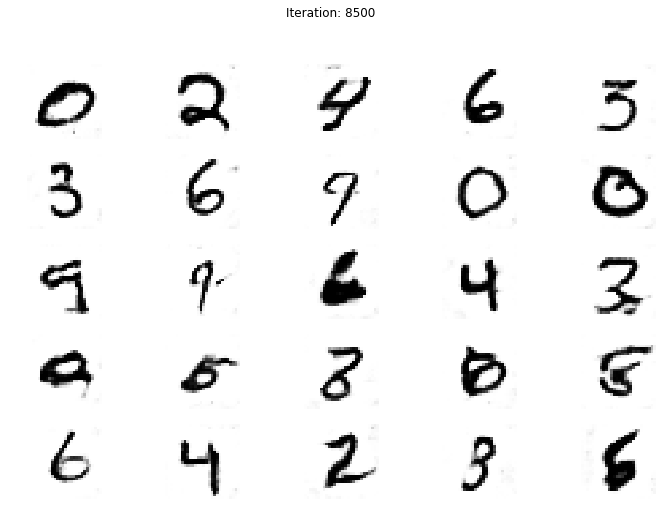

Iteration:  8501 [D loss: 0.69570, acc.:  48.44%] [G loss: 0.76160]
Iteration:  8502 [D loss: 0.68786, acc.:  54.30%] [G loss: 0.76379]
Iteration:  8503 [D loss: 0.71495, acc.:  47.27%] [G loss: 0.76357]
Iteration:  8504 [D loss: 0.70406, acc.:  47.66%] [G loss: 0.77452]
Iteration:  8505 [D loss: 0.71565, acc.:  51.95%] [G loss: 0.76176]
Iteration:  8506 [D loss: 0.72184, acc.:  42.58%] [G loss: 0.76158]
Iteration:  8507 [D loss: 0.70420, acc.:  48.44%] [G loss: 0.74078]
Iteration:  8508 [D loss: 0.69268, acc.:  53.91%] [G loss: 0.73856]
Iteration:  8509 [D loss: 0.71426, acc.:  46.48%] [G loss: 0.74196]
Iteration:  8510 [D loss: 0.69955, acc.:  49.61%] [G loss: 0.74903]
Iteration:  8511 [D loss: 0.70109, acc.:  49.22%] [G loss: 0.77034]
Iteration:  8512 [D loss: 0.70366, acc.:  51.56%] [G loss: 0.75258]
Iteration:  8513 [D loss: 0.71520, acc.:  47.66%] [G loss: 0.76257]
Iteration:  8514 [D loss: 0.67411, acc.:  58.98%] [G loss: 0.75044]
Iteration:  8515 [D loss: 0.71340, acc.:  50.00%

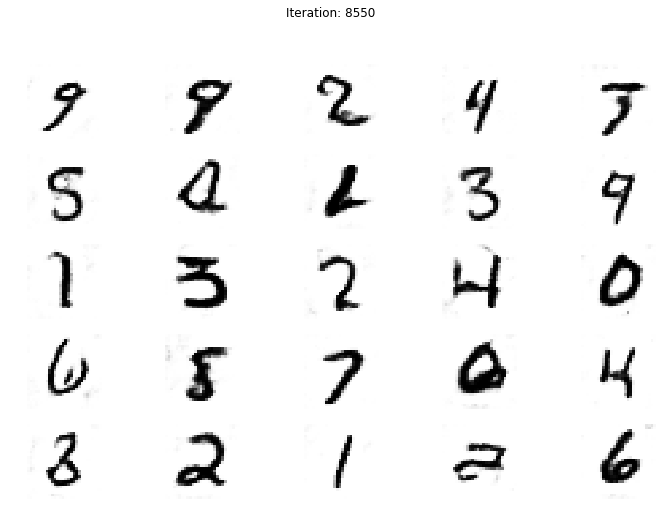

Iteration:  8551 [D loss: 0.70520, acc.:  51.56%] [G loss: 0.74289]
Iteration:  8552 [D loss: 0.72186, acc.:  46.09%] [G loss: 0.75013]
Iteration:  8553 [D loss: 0.70062, acc.:  49.22%] [G loss: 0.74653]
Iteration:  8554 [D loss: 0.71088, acc.:  49.22%] [G loss: 0.75845]
Iteration:  8555 [D loss: 0.70883, acc.:  44.92%] [G loss: 0.74412]
Iteration:  8556 [D loss: 0.68527, acc.:  55.08%] [G loss: 0.73953]
Iteration:  8557 [D loss: 0.70666, acc.:  49.22%] [G loss: 0.73999]
Iteration:  8558 [D loss: 0.69255, acc.:  53.91%] [G loss: 0.75339]
Iteration:  8559 [D loss: 0.68940, acc.:  53.91%] [G loss: 0.75524]
Iteration:  8560 [D loss: 0.70728, acc.:  48.83%] [G loss: 0.74067]
Iteration:  8561 [D loss: 0.70277, acc.:  53.52%] [G loss: 0.75876]
Iteration:  8562 [D loss: 0.70016, acc.:  52.73%] [G loss: 0.76569]
Iteration:  8563 [D loss: 0.70552, acc.:  49.22%] [G loss: 0.72708]
Iteration:  8564 [D loss: 0.71829, acc.:  48.83%] [G loss: 0.74200]
Iteration:  8565 [D loss: 0.70381, acc.:  53.91%

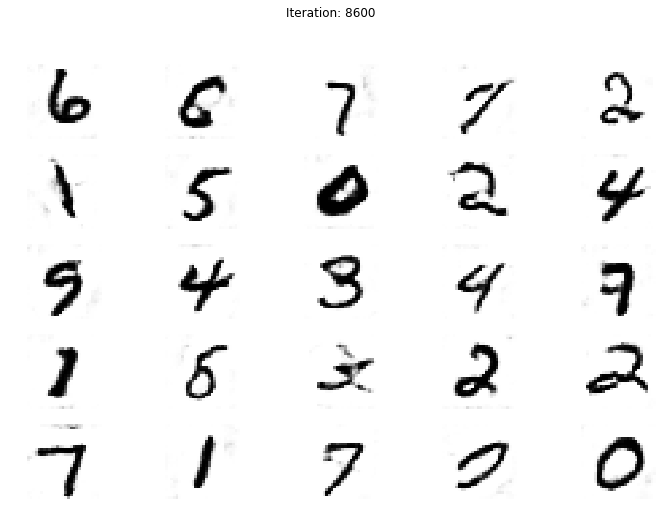

Iteration:  8601 [D loss: 0.71689, acc.:  47.27%] [G loss: 0.73746]
Iteration:  8602 [D loss: 0.69608, acc.:  51.56%] [G loss: 0.74978]
Iteration:  8603 [D loss: 0.71258, acc.:  45.31%] [G loss: 0.73720]
Iteration:  8604 [D loss: 0.71496, acc.:  47.66%] [G loss: 0.74330]
Iteration:  8605 [D loss: 0.71720, acc.:  51.56%] [G loss: 0.75784]
Iteration:  8606 [D loss: 0.71180, acc.:  46.09%] [G loss: 0.78740]
Iteration:  8607 [D loss: 0.71338, acc.:  46.48%] [G loss: 0.77216]
Iteration:  8608 [D loss: 0.71013, acc.:  48.83%] [G loss: 0.75470]
Iteration:  8609 [D loss: 0.71013, acc.:  47.66%] [G loss: 0.72946]
Iteration:  8610 [D loss: 0.69185, acc.:  57.03%] [G loss: 0.74961]
Iteration:  8611 [D loss: 0.70814, acc.:  49.22%] [G loss: 0.76142]
Iteration:  8612 [D loss: 0.71329, acc.:  46.09%] [G loss: 0.74680]
Iteration:  8613 [D loss: 0.71231, acc.:  48.05%] [G loss: 0.74420]
Iteration:  8614 [D loss: 0.69957, acc.:  50.00%] [G loss: 0.76468]
Iteration:  8615 [D loss: 0.70409, acc.:  48.44%

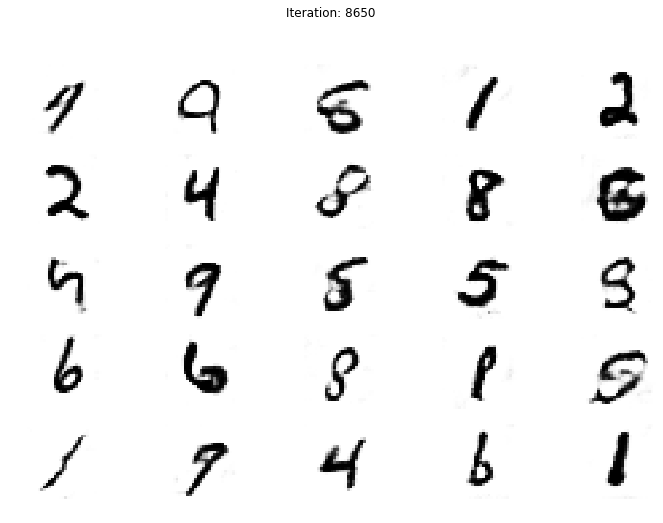

Iteration:  8651 [D loss: 0.69592, acc.:  52.34%] [G loss: 0.70616]
Iteration:  8652 [D loss: 0.69114, acc.:  56.64%] [G loss: 0.76296]
Iteration:  8653 [D loss: 0.68770, acc.:  52.73%] [G loss: 0.74680]
Iteration:  8654 [D loss: 0.70781, acc.:  50.00%] [G loss: 0.73365]
Iteration:  8655 [D loss: 0.69329, acc.:  52.34%] [G loss: 0.73011]
Iteration:  8656 [D loss: 0.70848, acc.:  48.83%] [G loss: 0.74782]
Iteration:  8657 [D loss: 0.72036, acc.:  48.44%] [G loss: 0.75626]
Iteration:  8658 [D loss: 0.71602, acc.:  47.66%] [G loss: 0.75372]
Iteration:  8659 [D loss: 0.69458, acc.:  50.00%] [G loss: 0.74570]
Iteration:  8660 [D loss: 0.70726, acc.:  50.39%] [G loss: 0.72675]
Iteration:  8661 [D loss: 0.71418, acc.:  48.83%] [G loss: 0.74097]
Iteration:  8662 [D loss: 0.69009, acc.:  56.64%] [G loss: 0.74779]
Iteration:  8663 [D loss: 0.70108, acc.:  52.34%] [G loss: 0.76733]
Iteration:  8664 [D loss: 0.69962, acc.:  50.78%] [G loss: 0.74358]
Iteration:  8665 [D loss: 0.71774, acc.:  46.48%

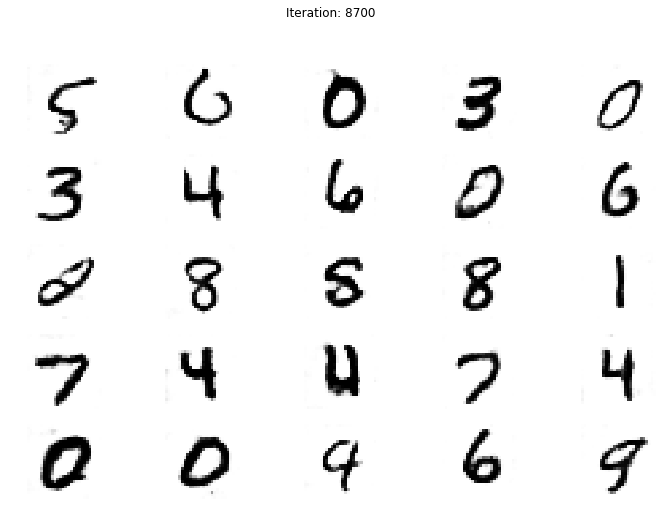

Iteration:  8701 [D loss: 0.71427, acc.:  48.44%] [G loss: 0.75934]
Iteration:  8702 [D loss: 0.70491, acc.:  48.83%] [G loss: 0.75142]
Iteration:  8703 [D loss: 0.69084, acc.:  54.30%] [G loss: 0.79015]
Iteration:  8704 [D loss: 0.69320, acc.:  53.91%] [G loss: 0.75463]
Iteration:  8705 [D loss: 0.69560, acc.:  53.91%] [G loss: 0.76765]
Iteration:  8706 [D loss: 0.69733, acc.:  49.22%] [G loss: 0.73546]
Iteration:  8707 [D loss: 0.69859, acc.:  52.73%] [G loss: 0.75357]
Iteration:  8708 [D loss: 0.72793, acc.:  44.53%] [G loss: 0.73271]
Iteration:  8709 [D loss: 0.69308, acc.:  51.95%] [G loss: 0.75970]
Iteration:  8710 [D loss: 0.72431, acc.:  43.75%] [G loss: 0.77672]
Iteration:  8711 [D loss: 0.69544, acc.:  53.12%] [G loss: 0.75128]
Iteration:  8712 [D loss: 0.70182, acc.:  46.09%] [G loss: 0.78371]
Iteration:  8713 [D loss: 0.71595, acc.:  48.05%] [G loss: 0.76283]
Iteration:  8714 [D loss: 0.69840, acc.:  54.69%] [G loss: 0.75442]
Iteration:  8715 [D loss: 0.69987, acc.:  51.56%

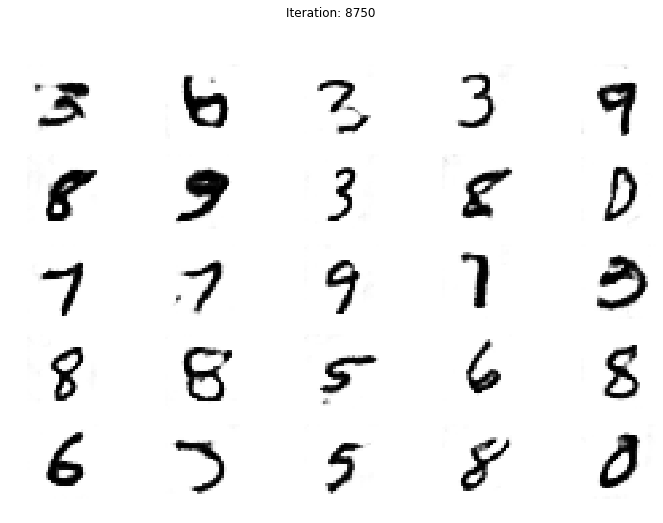

Iteration:  8751 [D loss: 0.69412, acc.:  51.95%] [G loss: 0.73288]
Iteration:  8752 [D loss: 0.69089, acc.:  54.30%] [G loss: 0.74328]
Iteration:  8753 [D loss: 0.70884, acc.:  46.48%] [G loss: 0.74085]
Iteration:  8754 [D loss: 0.70159, acc.:  52.73%] [G loss: 0.73718]
Iteration:  8755 [D loss: 0.70725, acc.:  50.39%] [G loss: 0.74189]
Iteration:  8756 [D loss: 0.71543, acc.:  46.09%] [G loss: 0.75516]
Iteration:  8757 [D loss: 0.70562, acc.:  46.48%] [G loss: 0.75552]
Iteration:  8758 [D loss: 0.72287, acc.:  48.44%] [G loss: 0.77100]
Iteration:  8759 [D loss: 0.70038, acc.:  51.17%] [G loss: 0.76441]
Iteration:  8760 [D loss: 0.70016, acc.:  50.78%] [G loss: 0.73749]
Iteration:  8761 [D loss: 0.69562, acc.:  51.17%] [G loss: 0.76973]
Iteration:  8762 [D loss: 0.68730, acc.:  54.30%] [G loss: 0.76383]
Iteration:  8763 [D loss: 0.67829, acc.:  58.59%] [G loss: 0.78312]
Iteration:  8764 [D loss: 0.69624, acc.:  52.34%] [G loss: 0.74451]
Iteration:  8765 [D loss: 0.69749, acc.:  48.83%

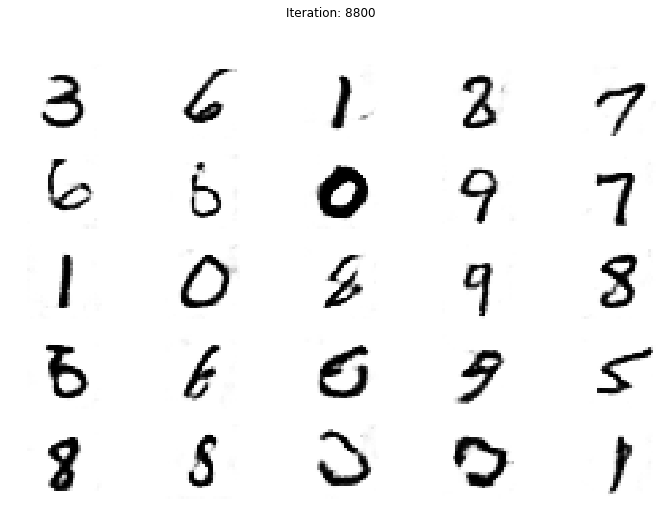

Iteration:  8801 [D loss: 0.71367, acc.:  49.22%] [G loss: 0.71673]
Iteration:  8802 [D loss: 0.73687, acc.:  44.14%] [G loss: 0.75143]
Iteration:  8803 [D loss: 0.70094, acc.:  48.05%] [G loss: 0.74584]
Iteration:  8804 [D loss: 0.69296, acc.:  52.73%] [G loss: 0.75907]
Iteration:  8805 [D loss: 0.67923, acc.:  57.42%] [G loss: 0.73954]
Iteration:  8806 [D loss: 0.70328, acc.:  47.27%] [G loss: 0.75719]
Iteration:  8807 [D loss: 0.68219, acc.:  57.81%] [G loss: 0.76190]
Iteration:  8808 [D loss: 0.69682, acc.:  52.34%] [G loss: 0.75618]
Iteration:  8809 [D loss: 0.71682, acc.:  47.27%] [G loss: 0.75752]
Iteration:  8810 [D loss: 0.69903, acc.:  52.73%] [G loss: 0.74769]
Iteration:  8811 [D loss: 0.70899, acc.:  50.00%] [G loss: 0.75277]
Iteration:  8812 [D loss: 0.70250, acc.:  51.56%] [G loss: 0.78032]
Iteration:  8813 [D loss: 0.71483, acc.:  46.48%] [G loss: 0.75550]
Iteration:  8814 [D loss: 0.70669, acc.:  49.22%] [G loss: 0.73978]
Iteration:  8815 [D loss: 0.70834, acc.:  47.66%

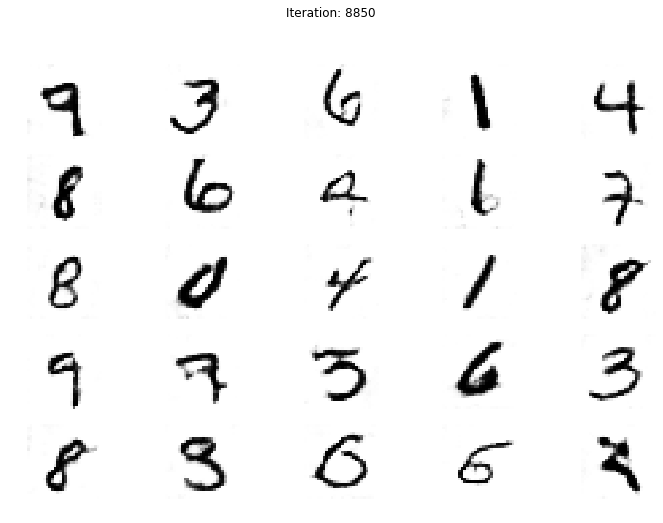

Iteration:  8851 [D loss: 0.70889, acc.:  48.05%] [G loss: 0.74839]
Iteration:  8852 [D loss: 0.71770, acc.:  44.53%] [G loss: 0.73397]
Iteration:  8853 [D loss: 0.71797, acc.:  47.27%] [G loss: 0.74407]
Iteration:  8854 [D loss: 0.70844, acc.:  47.27%] [G loss: 0.73904]
Iteration:  8855 [D loss: 0.71053, acc.:  48.05%] [G loss: 0.76899]
Iteration:  8856 [D loss: 0.71525, acc.:  48.44%] [G loss: 0.77046]
Iteration:  8857 [D loss: 0.70646, acc.:  49.61%] [G loss: 0.71511]
Iteration:  8858 [D loss: 0.71745, acc.:  41.80%] [G loss: 0.73206]
Iteration:  8859 [D loss: 0.70411, acc.:  49.61%] [G loss: 0.74413]
Iteration:  8860 [D loss: 0.70702, acc.:  49.22%] [G loss: 0.74860]
Iteration:  8861 [D loss: 0.69711, acc.:  51.17%] [G loss: 0.79007]
Iteration:  8862 [D loss: 0.69621, acc.:  52.34%] [G loss: 0.74365]
Iteration:  8863 [D loss: 0.70127, acc.:  48.44%] [G loss: 0.74032]
Iteration:  8864 [D loss: 0.72349, acc.:  47.66%] [G loss: 0.77380]
Iteration:  8865 [D loss: 0.71122, acc.:  48.44%

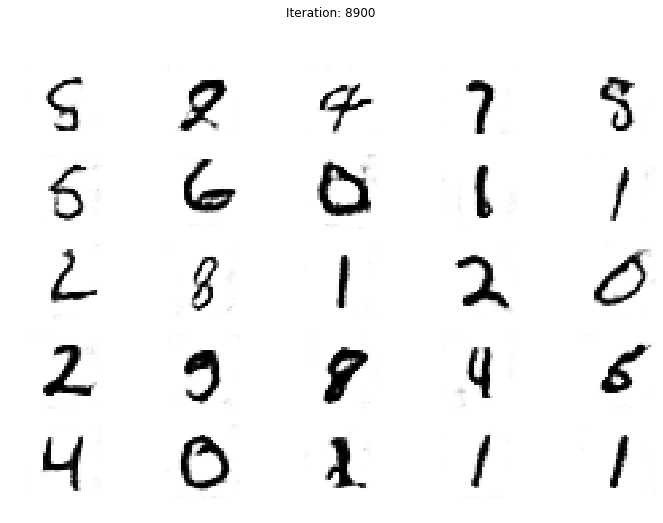

Iteration:  8901 [D loss: 0.71203, acc.:  49.61%] [G loss: 0.78980]
Iteration:  8902 [D loss: 0.71041, acc.:  46.09%] [G loss: 0.73930]
Iteration:  8903 [D loss: 0.70037, acc.:  51.95%] [G loss: 0.76368]
Iteration:  8904 [D loss: 0.69739, acc.:  52.34%] [G loss: 0.76139]
Iteration:  8905 [D loss: 0.71836, acc.:  42.58%] [G loss: 0.76817]
Iteration:  8906 [D loss: 0.70538, acc.:  47.66%] [G loss: 0.75539]
Iteration:  8907 [D loss: 0.70200, acc.:  53.91%] [G loss: 0.73588]
Iteration:  8908 [D loss: 0.70977, acc.:  50.78%] [G loss: 0.75986]
Iteration:  8909 [D loss: 0.70600, acc.:  46.09%] [G loss: 0.77521]
Iteration:  8910 [D loss: 0.68949, acc.:  56.25%] [G loss: 0.73575]
Iteration:  8911 [D loss: 0.70380, acc.:  52.34%] [G loss: 0.73955]
Iteration:  8912 [D loss: 0.71131, acc.:  50.00%] [G loss: 0.75340]
Iteration:  8913 [D loss: 0.71901, acc.:  44.14%] [G loss: 0.73135]
Iteration:  8914 [D loss: 0.69130, acc.:  53.52%] [G loss: 0.72590]
Iteration:  8915 [D loss: 0.70656, acc.:  48.05%

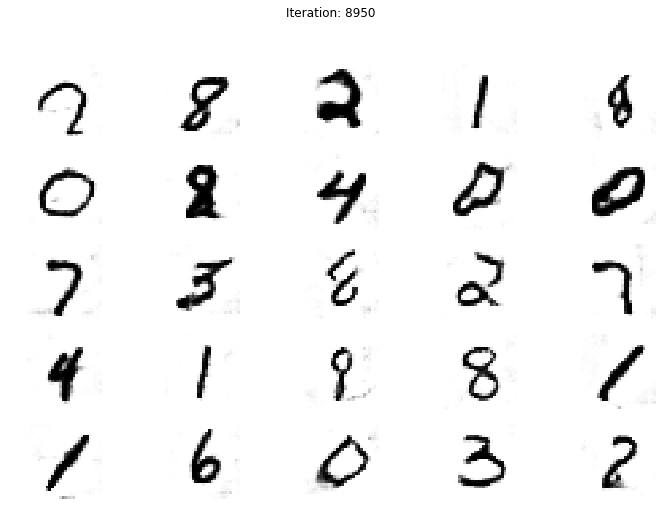

Iteration:  8951 [D loss: 0.69843, acc.:  50.78%] [G loss: 0.77554]
Iteration:  8952 [D loss: 0.69633, acc.:  49.61%] [G loss: 0.77041]
Iteration:  8953 [D loss: 0.71933, acc.:  42.97%] [G loss: 0.77117]
Iteration:  8954 [D loss: 0.70413, acc.:  53.12%] [G loss: 0.76740]
Iteration:  8955 [D loss: 0.69997, acc.:  50.78%] [G loss: 0.75579]
Iteration:  8956 [D loss: 0.71006, acc.:  49.22%] [G loss: 0.74620]
Iteration:  8957 [D loss: 0.70331, acc.:  48.44%] [G loss: 0.74132]
Iteration:  8958 [D loss: 0.70115, acc.:  48.83%] [G loss: 0.76222]
Iteration:  8959 [D loss: 0.69958, acc.:  49.22%] [G loss: 0.76823]
Iteration:  8960 [D loss: 0.71172, acc.:  50.78%] [G loss: 0.73934]
Iteration:  8961 [D loss: 0.73663, acc.:  44.53%] [G loss: 0.73088]
Iteration:  8962 [D loss: 0.68541, acc.:  57.81%] [G loss: 0.74117]
Iteration:  8963 [D loss: 0.71237, acc.:  41.80%] [G loss: 0.72166]
Iteration:  8964 [D loss: 0.71972, acc.:  45.31%] [G loss: 0.73864]
Iteration:  8965 [D loss: 0.70718, acc.:  49.22%

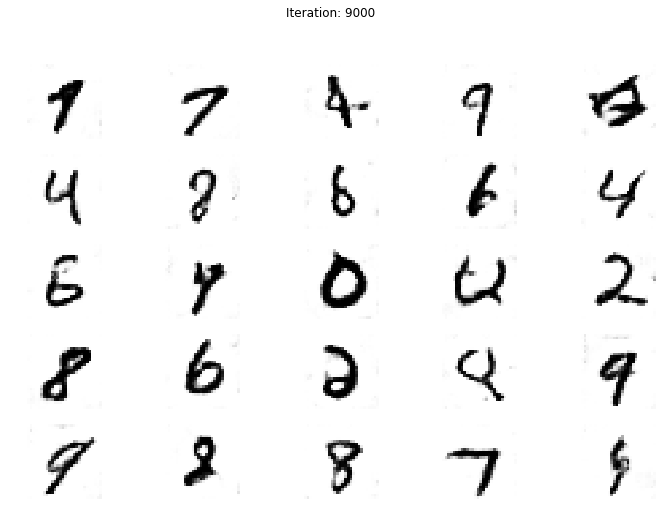

Iteration:  9001 [D loss: 0.69931, acc.:  51.17%] [G loss: 0.77542]
Iteration:  9002 [D loss: 0.68953, acc.:  53.91%] [G loss: 0.74772]
Iteration:  9003 [D loss: 0.71095, acc.:  45.70%] [G loss: 0.74797]
Iteration:  9004 [D loss: 0.69997, acc.:  49.22%] [G loss: 0.77779]
Iteration:  9005 [D loss: 0.70505, acc.:  50.78%] [G loss: 0.72676]
Iteration:  9006 [D loss: 0.70186, acc.:  47.27%] [G loss: 0.75499]
Iteration:  9007 [D loss: 0.70783, acc.:  49.22%] [G loss: 0.75514]
Iteration:  9008 [D loss: 0.69192, acc.:  51.17%] [G loss: 0.75441]
Iteration:  9009 [D loss: 0.71086, acc.:  50.39%] [G loss: 0.76325]
Iteration:  9010 [D loss: 0.69170, acc.:  53.91%] [G loss: 0.75655]
Iteration:  9011 [D loss: 0.70758, acc.:  44.53%] [G loss: 0.74436]
Iteration:  9012 [D loss: 0.71347, acc.:  48.05%] [G loss: 0.76259]
Iteration:  9013 [D loss: 0.71209, acc.:  51.95%] [G loss: 0.77150]
Iteration:  9014 [D loss: 0.72139, acc.:  41.80%] [G loss: 0.75689]
Iteration:  9015 [D loss: 0.69463, acc.:  52.73%

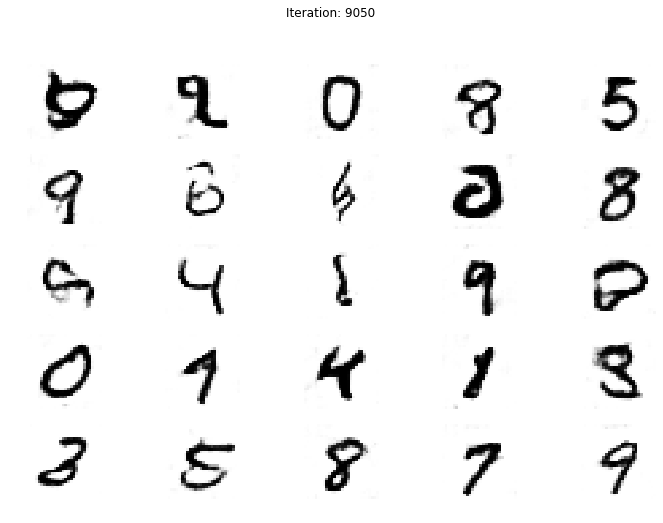

Iteration:  9051 [D loss: 0.72930, acc.:  40.62%] [G loss: 0.74589]
Iteration:  9052 [D loss: 0.70880, acc.:  50.78%] [G loss: 0.75321]
Iteration:  9053 [D loss: 0.70644, acc.:  51.17%] [G loss: 0.76182]
Iteration:  9054 [D loss: 0.70385, acc.:  47.66%] [G loss: 0.74888]
Iteration:  9055 [D loss: 0.69890, acc.:  49.61%] [G loss: 0.76232]
Iteration:  9056 [D loss: 0.69709, acc.:  53.52%] [G loss: 0.76119]
Iteration:  9057 [D loss: 0.67859, acc.:  57.81%] [G loss: 0.75092]
Iteration:  9058 [D loss: 0.69858, acc.:  52.34%] [G loss: 0.74446]
Iteration:  9059 [D loss: 0.70441, acc.:  48.83%] [G loss: 0.76217]
Iteration:  9060 [D loss: 0.71985, acc.:  47.66%] [G loss: 0.77425]
Iteration:  9061 [D loss: 0.70724, acc.:  46.88%] [G loss: 0.76777]
Iteration:  9062 [D loss: 0.69901, acc.:  51.17%] [G loss: 0.76075]
Iteration:  9063 [D loss: 0.69906, acc.:  50.39%] [G loss: 0.75831]
Iteration:  9064 [D loss: 0.70178, acc.:  48.05%] [G loss: 0.77301]
Iteration:  9065 [D loss: 0.70753, acc.:  51.17%

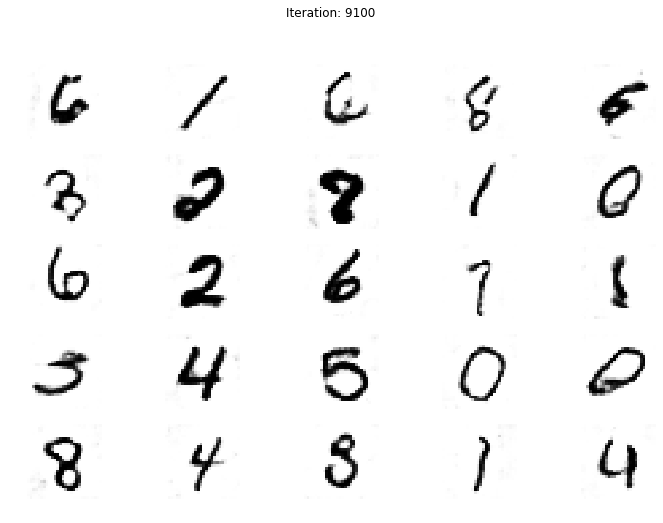

Iteration:  9101 [D loss: 0.69975, acc.:  52.73%] [G loss: 0.75360]
Iteration:  9102 [D loss: 0.71874, acc.:  48.83%] [G loss: 0.75476]
Iteration:  9103 [D loss: 0.69838, acc.:  51.56%] [G loss: 0.74511]
Iteration:  9104 [D loss: 0.70386, acc.:  46.88%] [G loss: 0.75340]
Iteration:  9105 [D loss: 0.69021, acc.:  53.12%] [G loss: 0.74044]
Iteration:  9106 [D loss: 0.69750, acc.:  50.39%] [G loss: 0.73355]
Iteration:  9107 [D loss: 0.69270, acc.:  52.73%] [G loss: 0.71840]
Iteration:  9108 [D loss: 0.70421, acc.:  46.48%] [G loss: 0.73248]
Iteration:  9109 [D loss: 0.68912, acc.:  54.69%] [G loss: 0.75488]
Iteration:  9110 [D loss: 0.70326, acc.:  50.00%] [G loss: 0.74314]
Iteration:  9111 [D loss: 0.71292, acc.:  50.78%] [G loss: 0.75078]
Iteration:  9112 [D loss: 0.70620, acc.:  50.78%] [G loss: 0.74582]
Iteration:  9113 [D loss: 0.71478, acc.:  48.44%] [G loss: 0.76842]
Iteration:  9114 [D loss: 0.69225, acc.:  51.56%] [G loss: 0.75808]
Iteration:  9115 [D loss: 0.71326, acc.:  47.27%

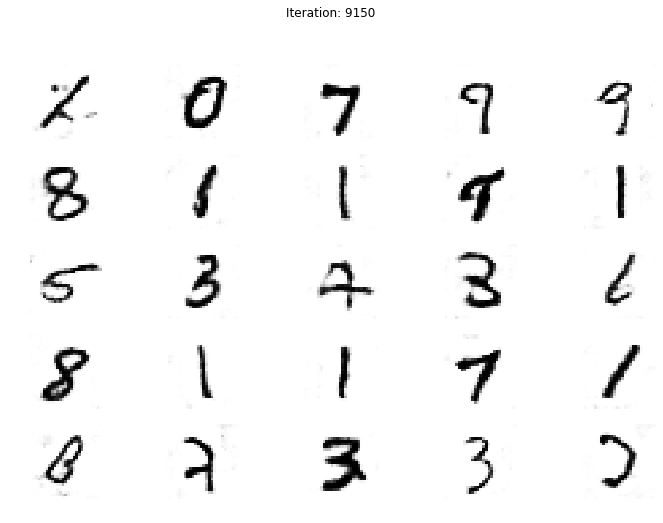

Iteration:  9151 [D loss: 0.68373, acc.:  56.64%] [G loss: 0.75130]
Iteration:  9152 [D loss: 0.70156, acc.:  50.78%] [G loss: 0.72824]
Iteration:  9153 [D loss: 0.70263, acc.:  52.73%] [G loss: 0.78126]
Iteration:  9154 [D loss: 0.70973, acc.:  48.83%] [G loss: 0.75004]
Iteration:  9155 [D loss: 0.71889, acc.:  44.92%] [G loss: 0.74890]
Iteration:  9156 [D loss: 0.70938, acc.:  47.66%] [G loss: 0.77568]
Iteration:  9157 [D loss: 0.70683, acc.:  45.31%] [G loss: 0.76093]
Iteration:  9158 [D loss: 0.69347, acc.:  50.78%] [G loss: 0.74165]
Iteration:  9159 [D loss: 0.69788, acc.:  50.00%] [G loss: 0.76195]
Iteration:  9160 [D loss: 0.70691, acc.:  47.66%] [G loss: 0.75624]
Iteration:  9161 [D loss: 0.70347, acc.:  51.95%] [G loss: 0.75716]
Iteration:  9162 [D loss: 0.70528, acc.:  48.44%] [G loss: 0.76364]
Iteration:  9163 [D loss: 0.71970, acc.:  47.27%] [G loss: 0.73267]
Iteration:  9164 [D loss: 0.68836, acc.:  52.34%] [G loss: 0.75492]
Iteration:  9165 [D loss: 0.71125, acc.:  50.78%

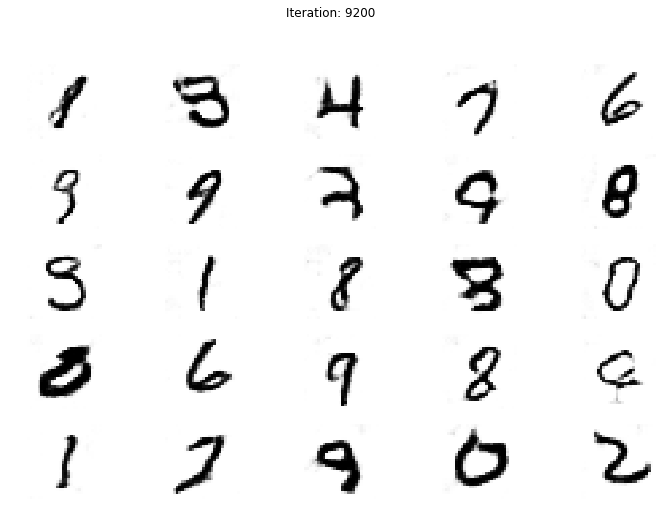

Iteration:  9201 [D loss: 0.68817, acc.:  51.56%] [G loss: 0.75854]
Iteration:  9202 [D loss: 0.71786, acc.:  44.53%] [G loss: 0.75000]
Iteration:  9203 [D loss: 0.69755, acc.:  48.83%] [G loss: 0.72447]
Iteration:  9204 [D loss: 0.71821, acc.:  42.97%] [G loss: 0.72787]
Iteration:  9205 [D loss: 0.69212, acc.:  53.12%] [G loss: 0.77088]
Iteration:  9206 [D loss: 0.71350, acc.:  46.48%] [G loss: 0.76487]
Iteration:  9207 [D loss: 0.69989, acc.:  55.08%] [G loss: 0.75091]
Iteration:  9208 [D loss: 0.71381, acc.:  47.27%] [G loss: 0.73409]
Iteration:  9209 [D loss: 0.69815, acc.:  51.17%] [G loss: 0.78004]
Iteration:  9210 [D loss: 0.69432, acc.:  53.12%] [G loss: 0.71785]
Iteration:  9211 [D loss: 0.71287, acc.:  45.70%] [G loss: 0.74346]
Iteration:  9212 [D loss: 0.70887, acc.:  47.27%] [G loss: 0.76228]
Iteration:  9213 [D loss: 0.69016, acc.:  50.39%] [G loss: 0.75962]
Iteration:  9214 [D loss: 0.70102, acc.:  51.56%] [G loss: 0.76659]
Iteration:  9215 [D loss: 0.69500, acc.:  56.64%

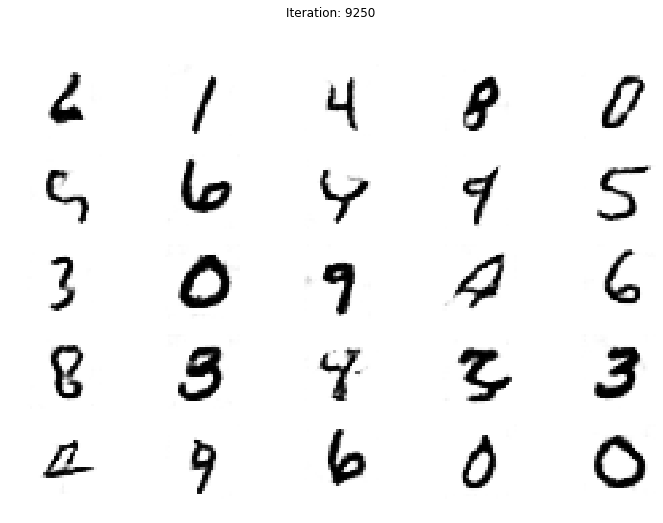

Iteration:  9251 [D loss: 0.71049, acc.:  49.22%] [G loss: 0.75697]
Iteration:  9252 [D loss: 0.71028, acc.:  43.36%] [G loss: 0.75831]
Iteration:  9253 [D loss: 0.71435, acc.:  44.53%] [G loss: 0.73032]
Iteration:  9254 [D loss: 0.71210, acc.:  46.48%] [G loss: 0.74512]
Iteration:  9255 [D loss: 0.69001, acc.:  52.73%] [G loss: 0.76384]
Iteration:  9256 [D loss: 0.71142, acc.:  50.39%] [G loss: 0.74196]
Iteration:  9257 [D loss: 0.72143, acc.:  44.53%] [G loss: 0.74030]
Iteration:  9258 [D loss: 0.69590, acc.:  51.56%] [G loss: 0.75115]
Iteration:  9259 [D loss: 0.71798, acc.:  46.09%] [G loss: 0.75259]
Iteration:  9260 [D loss: 0.69472, acc.:  52.34%] [G loss: 0.74176]
Iteration:  9261 [D loss: 0.70249, acc.:  47.66%] [G loss: 0.73508]
Iteration:  9262 [D loss: 0.68816, acc.:  55.47%] [G loss: 0.76628]
Iteration:  9263 [D loss: 0.70319, acc.:  51.95%] [G loss: 0.74641]
Iteration:  9264 [D loss: 0.70537, acc.:  47.66%] [G loss: 0.74734]
Iteration:  9265 [D loss: 0.71812, acc.:  46.48%

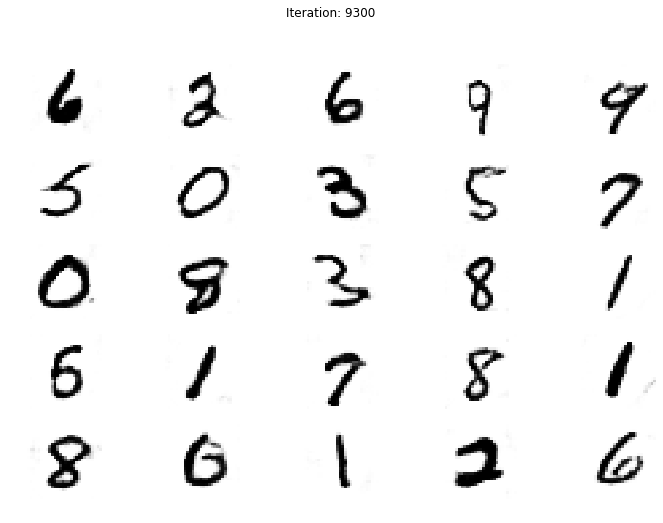

Iteration:  9301 [D loss: 0.73136, acc.:  41.80%] [G loss: 0.71614]
Iteration:  9302 [D loss: 0.70726, acc.:  48.05%] [G loss: 0.74360]
Iteration:  9303 [D loss: 0.69927, acc.:  51.17%] [G loss: 0.77302]
Iteration:  9304 [D loss: 0.71413, acc.:  45.31%] [G loss: 0.75978]
Iteration:  9305 [D loss: 0.69514, acc.:  56.25%] [G loss: 0.76137]
Iteration:  9306 [D loss: 0.69629, acc.:  50.39%] [G loss: 0.73129]
Iteration:  9307 [D loss: 0.70418, acc.:  50.00%] [G loss: 0.77349]
Iteration:  9308 [D loss: 0.70706, acc.:  49.61%] [G loss: 0.73329]
Iteration:  9309 [D loss: 0.71086, acc.:  46.48%] [G loss: 0.74109]
Iteration:  9310 [D loss: 0.70048, acc.:  52.34%] [G loss: 0.74767]
Iteration:  9311 [D loss: 0.70489, acc.:  53.12%] [G loss: 0.74819]
Iteration:  9312 [D loss: 0.71778, acc.:  43.75%] [G loss: 0.76329]
Iteration:  9313 [D loss: 0.68853, acc.:  53.91%] [G loss: 0.76987]
Iteration:  9314 [D loss: 0.71785, acc.:  46.88%] [G loss: 0.75799]
Iteration:  9315 [D loss: 0.70710, acc.:  50.00%

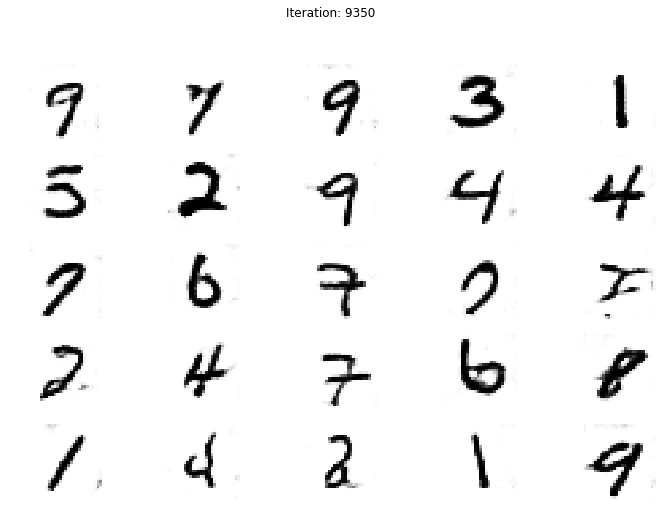

Iteration:  9351 [D loss: 0.70767, acc.:  46.88%] [G loss: 0.73998]
Iteration:  9352 [D loss: 0.70503, acc.:  48.05%] [G loss: 0.74663]
Iteration:  9353 [D loss: 0.71661, acc.:  48.44%] [G loss: 0.76892]
Iteration:  9354 [D loss: 0.69780, acc.:  51.17%] [G loss: 0.75587]
Iteration:  9355 [D loss: 0.69031, acc.:  58.98%] [G loss: 0.75204]
Iteration:  9356 [D loss: 0.71313, acc.:  45.70%] [G loss: 0.73551]
Iteration:  9357 [D loss: 0.70659, acc.:  46.88%] [G loss: 0.75528]
Iteration:  9358 [D loss: 0.69791, acc.:  50.78%] [G loss: 0.73918]
Iteration:  9359 [D loss: 0.68564, acc.:  56.25%] [G loss: 0.73263]
Iteration:  9360 [D loss: 0.69892, acc.:  53.52%] [G loss: 0.76039]
Iteration:  9361 [D loss: 0.71668, acc.:  44.53%] [G loss: 0.75189]
Iteration:  9362 [D loss: 0.71893, acc.:  46.88%] [G loss: 0.72135]
Iteration:  9363 [D loss: 0.71435, acc.:  46.09%] [G loss: 0.74405]
Iteration:  9364 [D loss: 0.69565, acc.:  51.56%] [G loss: 0.76680]
Iteration:  9365 [D loss: 0.71064, acc.:  47.27%

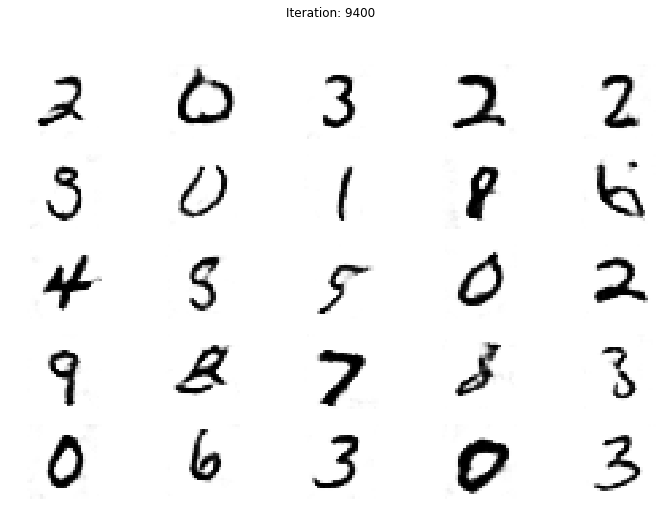

Iteration:  9401 [D loss: 0.71918, acc.:  43.36%] [G loss: 0.75442]
Iteration:  9402 [D loss: 0.70642, acc.:  49.61%] [G loss: 0.75151]
Iteration:  9403 [D loss: 0.71261, acc.:  46.88%] [G loss: 0.73000]
Iteration:  9404 [D loss: 0.70673, acc.:  45.31%] [G loss: 0.74435]
Iteration:  9405 [D loss: 0.70157, acc.:  49.61%] [G loss: 0.74086]
Iteration:  9406 [D loss: 0.70751, acc.:  49.22%] [G loss: 0.75311]
Iteration:  9407 [D loss: 0.70866, acc.:  47.27%] [G loss: 0.75132]
Iteration:  9408 [D loss: 0.70179, acc.:  51.17%] [G loss: 0.73480]
Iteration:  9409 [D loss: 0.71055, acc.:  50.39%] [G loss: 0.72413]
Iteration:  9410 [D loss: 0.70432, acc.:  48.44%] [G loss: 0.76058]
Iteration:  9411 [D loss: 0.68369, acc.:  56.64%] [G loss: 0.73370]
Iteration:  9412 [D loss: 0.67841, acc.:  57.81%] [G loss: 0.74977]
Iteration:  9413 [D loss: 0.72364, acc.:  46.09%] [G loss: 0.75049]
Iteration:  9414 [D loss: 0.71131, acc.:  45.31%] [G loss: 0.76817]
Iteration:  9415 [D loss: 0.73474, acc.:  40.62%

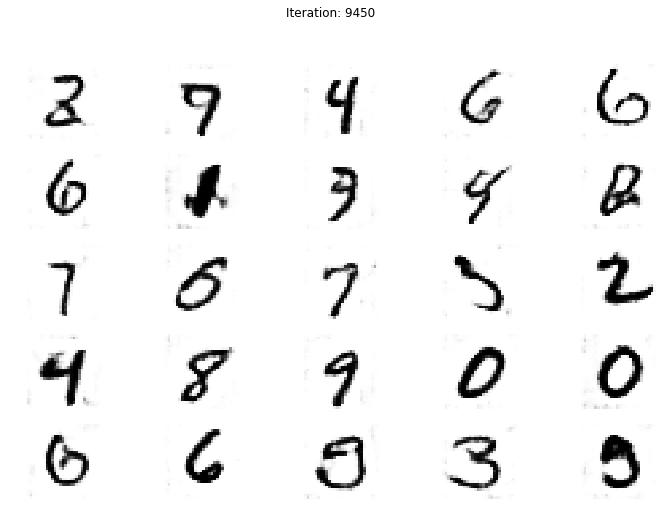

Iteration:  9451 [D loss: 0.71993, acc.:  46.48%] [G loss: 0.76277]
Iteration:  9452 [D loss: 0.72480, acc.:  43.36%] [G loss: 0.74894]
Iteration:  9453 [D loss: 0.71556, acc.:  46.09%] [G loss: 0.76357]
Iteration:  9454 [D loss: 0.70438, acc.:  46.48%] [G loss: 0.74249]
Iteration:  9455 [D loss: 0.70749, acc.:  49.22%] [G loss: 0.74828]
Iteration:  9456 [D loss: 0.69993, acc.:  49.22%] [G loss: 0.75118]
Iteration:  9457 [D loss: 0.71505, acc.:  46.88%] [G loss: 0.74550]
Iteration:  9458 [D loss: 0.71074, acc.:  46.48%] [G loss: 0.76582]
Iteration:  9459 [D loss: 0.71405, acc.:  51.17%] [G loss: 0.73437]
Iteration:  9460 [D loss: 0.69238, acc.:  55.86%] [G loss: 0.75482]
Iteration:  9461 [D loss: 0.71738, acc.:  45.70%] [G loss: 0.73083]
Iteration:  9462 [D loss: 0.69671, acc.:  51.17%] [G loss: 0.74101]
Iteration:  9463 [D loss: 0.71894, acc.:  41.80%] [G loss: 0.75466]
Iteration:  9464 [D loss: 0.73071, acc.:  40.62%] [G loss: 0.74765]
Iteration:  9465 [D loss: 0.71470, acc.:  46.88%

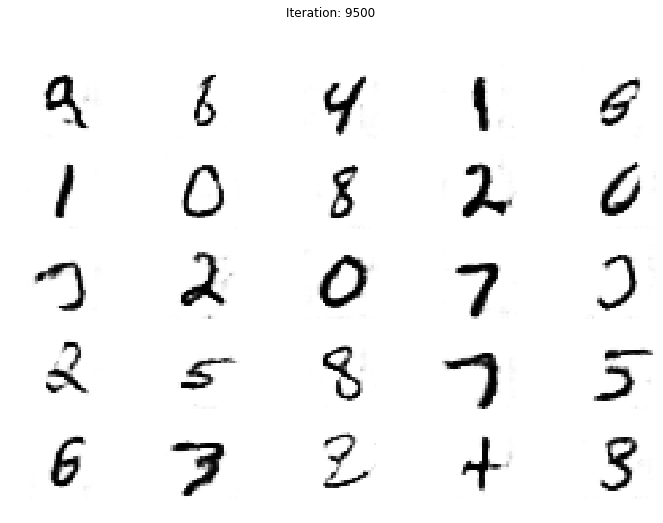

Iteration:  9501 [D loss: 0.69951, acc.:  50.00%] [G loss: 0.75718]
Iteration:  9502 [D loss: 0.69195, acc.:  51.95%] [G loss: 0.73632]
Iteration:  9503 [D loss: 0.69380, acc.:  55.08%] [G loss: 0.74608]
Iteration:  9504 [D loss: 0.70848, acc.:  48.44%] [G loss: 0.72475]
Iteration:  9505 [D loss: 0.71430, acc.:  46.88%] [G loss: 0.73246]
Iteration:  9506 [D loss: 0.70165, acc.:  52.34%] [G loss: 0.72398]
Iteration:  9507 [D loss: 0.70834, acc.:  47.66%] [G loss: 0.72866]
Iteration:  9508 [D loss: 0.70075, acc.:  45.31%] [G loss: 0.71465]
Iteration:  9509 [D loss: 0.70716, acc.:  50.00%] [G loss: 0.72632]
Iteration:  9510 [D loss: 0.71097, acc.:  48.83%] [G loss: 0.76585]
Iteration:  9511 [D loss: 0.68871, acc.:  50.39%] [G loss: 0.72491]
Iteration:  9512 [D loss: 0.70725, acc.:  49.22%] [G loss: 0.73412]
Iteration:  9513 [D loss: 0.70323, acc.:  49.22%] [G loss: 0.74648]
Iteration:  9514 [D loss: 0.69737, acc.:  49.61%] [G loss: 0.74466]
Iteration:  9515 [D loss: 0.69969, acc.:  48.05%

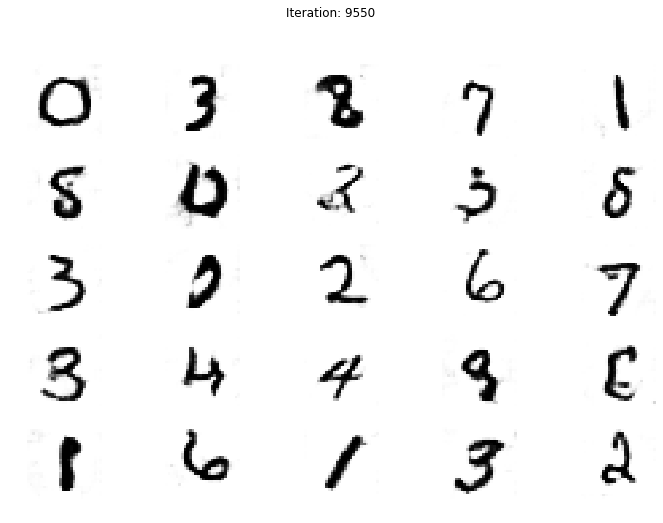

Iteration:  9551 [D loss: 0.70984, acc.:  49.61%] [G loss: 0.75263]
Iteration:  9552 [D loss: 0.71162, acc.:  48.05%] [G loss: 0.73350]
Iteration:  9553 [D loss: 0.70931, acc.:  48.83%] [G loss: 0.72865]
Iteration:  9554 [D loss: 0.70406, acc.:  49.61%] [G loss: 0.75625]
Iteration:  9555 [D loss: 0.72680, acc.:  44.92%] [G loss: 0.72864]
Iteration:  9556 [D loss: 0.69949, acc.:  50.78%] [G loss: 0.73220]
Iteration:  9557 [D loss: 0.70209, acc.:  51.56%] [G loss: 0.73782]
Iteration:  9558 [D loss: 0.69458, acc.:  49.61%] [G loss: 0.76573]
Iteration:  9559 [D loss: 0.69901, acc.:  50.39%] [G loss: 0.76621]
Iteration:  9560 [D loss: 0.70672, acc.:  51.17%] [G loss: 0.77098]
Iteration:  9561 [D loss: 0.70092, acc.:  51.17%] [G loss: 0.77088]
Iteration:  9562 [D loss: 0.71532, acc.:  48.44%] [G loss: 0.75725]
Iteration:  9563 [D loss: 0.69528, acc.:  53.52%] [G loss: 0.75632]
Iteration:  9564 [D loss: 0.70525, acc.:  51.17%] [G loss: 0.74840]
Iteration:  9565 [D loss: 0.69515, acc.:  49.22%

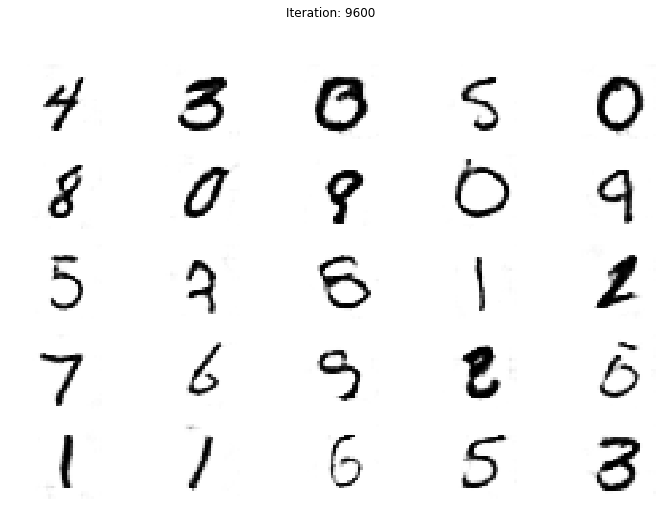

Iteration:  9601 [D loss: 0.69716, acc.:  52.34%] [G loss: 0.74531]
Iteration:  9602 [D loss: 0.69717, acc.:  54.69%] [G loss: 0.74941]
Iteration:  9603 [D loss: 0.70710, acc.:  48.44%] [G loss: 0.72681]
Iteration:  9604 [D loss: 0.70738, acc.:  48.83%] [G loss: 0.74316]
Iteration:  9605 [D loss: 0.70674, acc.:  46.48%] [G loss: 0.73581]
Iteration:  9606 [D loss: 0.70461, acc.:  50.39%] [G loss: 0.74950]
Iteration:  9607 [D loss: 0.70149, acc.:  52.73%] [G loss: 0.72031]
Iteration:  9608 [D loss: 0.72234, acc.:  44.92%] [G loss: 0.74310]
Iteration:  9609 [D loss: 0.70585, acc.:  49.61%] [G loss: 0.76042]
Iteration:  9610 [D loss: 0.71800, acc.:  46.48%] [G loss: 0.75740]
Iteration:  9611 [D loss: 0.70230, acc.:  52.34%] [G loss: 0.75672]
Iteration:  9612 [D loss: 0.70665, acc.:  51.56%] [G loss: 0.76456]
Iteration:  9613 [D loss: 0.70352, acc.:  49.61%] [G loss: 0.76826]
Iteration:  9614 [D loss: 0.68868, acc.:  52.73%] [G loss: 0.76732]
Iteration:  9615 [D loss: 0.70529, acc.:  46.48%

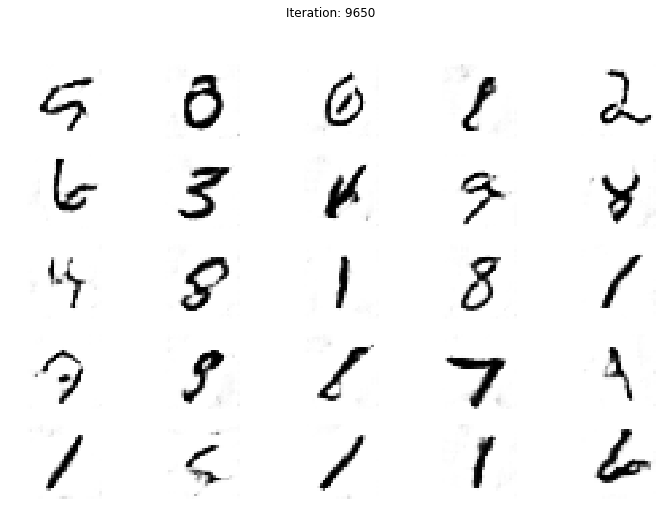

Iteration:  9651 [D loss: 0.71558, acc.:  45.31%] [G loss: 0.73324]
Iteration:  9652 [D loss: 0.71560, acc.:  46.88%] [G loss: 0.72977]
Iteration:  9653 [D loss: 0.71257, acc.:  44.53%] [G loss: 0.73904]
Iteration:  9654 [D loss: 0.70814, acc.:  50.39%] [G loss: 0.72756]
Iteration:  9655 [D loss: 0.69314, acc.:  52.73%] [G loss: 0.76710]
Iteration:  9656 [D loss: 0.69204, acc.:  53.91%] [G loss: 0.74075]
Iteration:  9657 [D loss: 0.72487, acc.:  43.75%] [G loss: 0.75964]
Iteration:  9658 [D loss: 0.70668, acc.:  45.31%] [G loss: 0.75887]
Iteration:  9659 [D loss: 0.70532, acc.:  46.48%] [G loss: 0.76797]
Iteration:  9660 [D loss: 0.69147, acc.:  51.56%] [G loss: 0.74798]
Iteration:  9661 [D loss: 0.69234, acc.:  52.34%] [G loss: 0.75045]
Iteration:  9662 [D loss: 0.70162, acc.:  47.27%] [G loss: 0.75164]
Iteration:  9663 [D loss: 0.71138, acc.:  45.70%] [G loss: 0.74133]
Iteration:  9664 [D loss: 0.68991, acc.:  52.34%] [G loss: 0.73890]
Iteration:  9665 [D loss: 0.70218, acc.:  47.27%

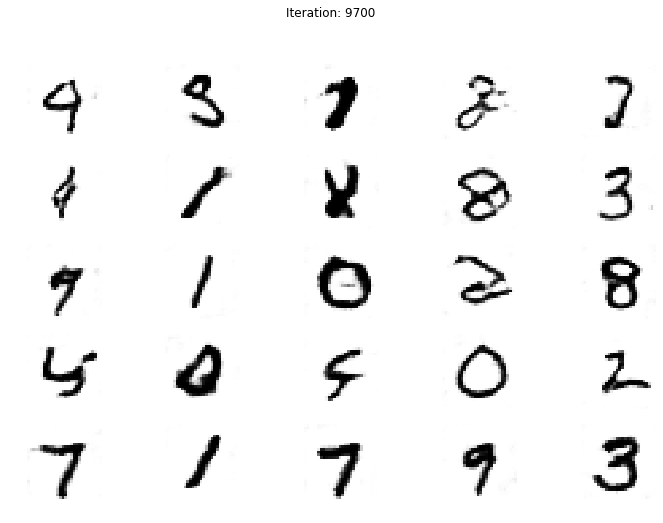

Iteration:  9701 [D loss: 0.71538, acc.:  45.31%] [G loss: 0.73172]
Iteration:  9702 [D loss: 0.71939, acc.:  50.39%] [G loss: 0.76408]
Iteration:  9703 [D loss: 0.72197, acc.:  43.36%] [G loss: 0.75238]
Iteration:  9704 [D loss: 0.70182, acc.:  53.12%] [G loss: 0.73013]
Iteration:  9705 [D loss: 0.69418, acc.:  51.95%] [G loss: 0.75953]
Iteration:  9706 [D loss: 0.70379, acc.:  49.61%] [G loss: 0.72980]
Iteration:  9707 [D loss: 0.70363, acc.:  49.22%] [G loss: 0.76108]
Iteration:  9708 [D loss: 0.69459, acc.:  53.12%] [G loss: 0.74266]
Iteration:  9709 [D loss: 0.69429, acc.:  50.39%] [G loss: 0.74276]
Iteration:  9710 [D loss: 0.74521, acc.:  39.45%] [G loss: 0.76048]
Iteration:  9711 [D loss: 0.69489, acc.:  54.30%] [G loss: 0.75586]
Iteration:  9712 [D loss: 0.68621, acc.:  51.95%] [G loss: 0.72990]
Iteration:  9713 [D loss: 0.69007, acc.:  55.86%] [G loss: 0.73408]
Iteration:  9714 [D loss: 0.72553, acc.:  44.92%] [G loss: 0.70718]
Iteration:  9715 [D loss: 0.70965, acc.:  45.31%

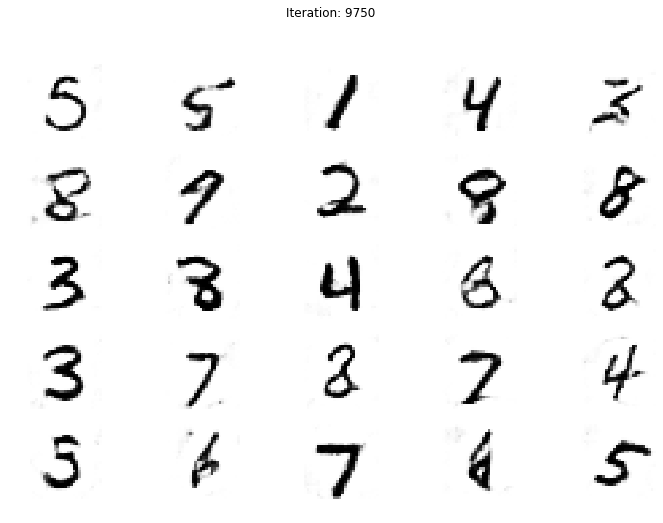

Iteration:  9751 [D loss: 0.71807, acc.:  46.09%] [G loss: 0.77711]
Iteration:  9752 [D loss: 0.71430, acc.:  46.09%] [G loss: 0.74312]
Iteration:  9753 [D loss: 0.70359, acc.:  48.44%] [G loss: 0.76793]
Iteration:  9754 [D loss: 0.70349, acc.:  46.09%] [G loss: 0.73970]
Iteration:  9755 [D loss: 0.69044, acc.:  51.56%] [G loss: 0.78232]
Iteration:  9756 [D loss: 0.71021, acc.:  45.70%] [G loss: 0.75310]
Iteration:  9757 [D loss: 0.70877, acc.:  48.83%] [G loss: 0.74067]
Iteration:  9758 [D loss: 0.70132, acc.:  50.00%] [G loss: 0.75419]
Iteration:  9759 [D loss: 0.71045, acc.:  47.27%] [G loss: 0.74447]
Iteration:  9760 [D loss: 0.71287, acc.:  48.83%] [G loss: 0.73880]
Iteration:  9761 [D loss: 0.70102, acc.:  50.78%] [G loss: 0.75241]
Iteration:  9762 [D loss: 0.69813, acc.:  51.17%] [G loss: 0.74629]
Iteration:  9763 [D loss: 0.71374, acc.:  47.66%] [G loss: 0.76584]
Iteration:  9764 [D loss: 0.73394, acc.:  40.62%] [G loss: 0.77610]
Iteration:  9765 [D loss: 0.69592, acc.:  55.08%

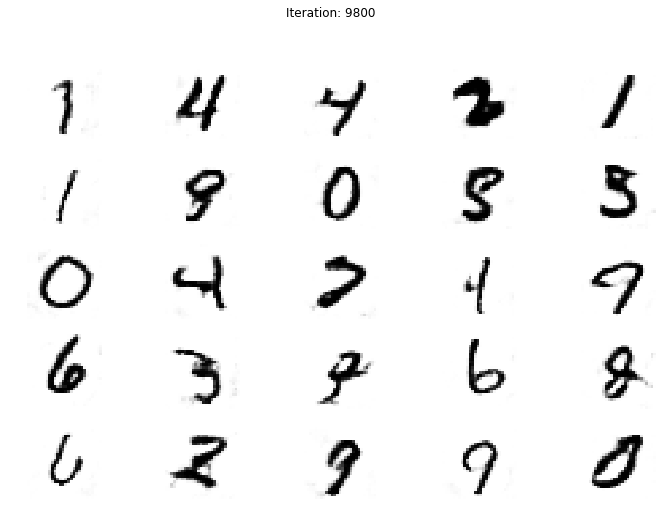

Iteration:  9801 [D loss: 0.70125, acc.:  50.78%] [G loss: 0.76601]
Iteration:  9802 [D loss: 0.70283, acc.:  49.61%] [G loss: 0.74448]
Iteration:  9803 [D loss: 0.70352, acc.:  52.34%] [G loss: 0.72810]
Iteration:  9804 [D loss: 0.70074, acc.:  52.73%] [G loss: 0.71595]
Iteration:  9805 [D loss: 0.70660, acc.:  44.14%] [G loss: 0.72921]
Iteration:  9806 [D loss: 0.70789, acc.:  48.83%] [G loss: 0.75260]
Iteration:  9807 [D loss: 0.68750, acc.:  55.86%] [G loss: 0.75821]
Iteration:  9808 [D loss: 0.70374, acc.:  48.44%] [G loss: 0.75802]
Iteration:  9809 [D loss: 0.70609, acc.:  48.44%] [G loss: 0.73035]
Iteration:  9810 [D loss: 0.69861, acc.:  51.17%] [G loss: 0.76468]
Iteration:  9811 [D loss: 0.70918, acc.:  47.66%] [G loss: 0.75305]
Iteration:  9812 [D loss: 0.69315, acc.:  54.30%] [G loss: 0.72752]
Iteration:  9813 [D loss: 0.69398, acc.:  49.22%] [G loss: 0.76214]
Iteration:  9814 [D loss: 0.69759, acc.:  51.56%] [G loss: 0.75667]
Iteration:  9815 [D loss: 0.69256, acc.:  53.52%

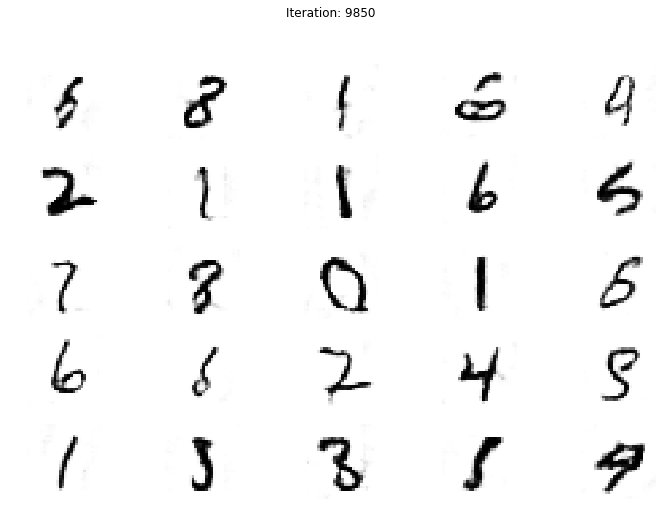

Iteration:  9851 [D loss: 0.70746, acc.:  49.22%] [G loss: 0.75395]
Iteration:  9852 [D loss: 0.68946, acc.:  54.69%] [G loss: 0.75163]
Iteration:  9853 [D loss: 0.71252, acc.:  48.05%] [G loss: 0.75929]
Iteration:  9854 [D loss: 0.71455, acc.:  49.22%] [G loss: 0.75240]
Iteration:  9855 [D loss: 0.70248, acc.:  50.00%] [G loss: 0.75201]
Iteration:  9856 [D loss: 0.69180, acc.:  55.08%] [G loss: 0.74735]
Iteration:  9857 [D loss: 0.71461, acc.:  47.27%] [G loss: 0.74293]
Iteration:  9858 [D loss: 0.70729, acc.:  48.05%] [G loss: 0.75271]
Iteration:  9859 [D loss: 0.70403, acc.:  49.22%] [G loss: 0.73870]
Iteration:  9860 [D loss: 0.71685, acc.:  46.48%] [G loss: 0.75796]
Iteration:  9861 [D loss: 0.69497, acc.:  51.17%] [G loss: 0.73586]
Iteration:  9862 [D loss: 0.70239, acc.:  46.88%] [G loss: 0.73598]
Iteration:  9863 [D loss: 0.69014, acc.:  53.52%] [G loss: 0.73038]
Iteration:  9864 [D loss: 0.69544, acc.:  53.91%] [G loss: 0.73931]
Iteration:  9865 [D loss: 0.71004, acc.:  46.88%

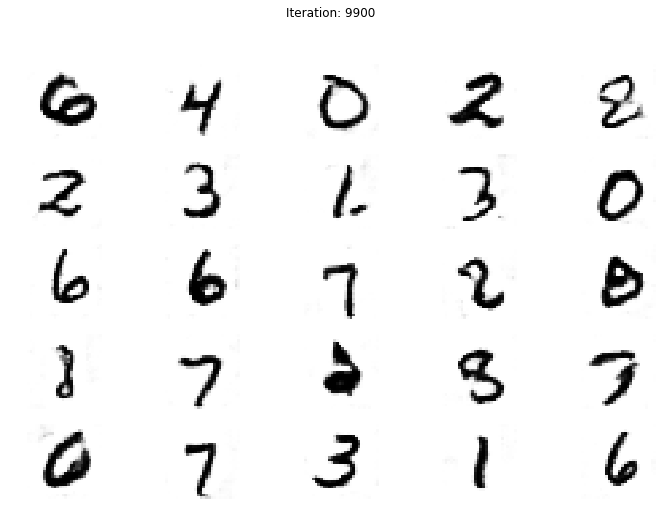

Iteration:  9901 [D loss: 0.71894, acc.:  43.36%] [G loss: 0.74761]
Iteration:  9902 [D loss: 0.71036, acc.:  51.56%] [G loss: 0.73831]
Iteration:  9903 [D loss: 0.69092, acc.:  54.30%] [G loss: 0.75982]
Iteration:  9904 [D loss: 0.71597, acc.:  44.14%] [G loss: 0.73162]
Iteration:  9905 [D loss: 0.70347, acc.:  50.78%] [G loss: 0.76017]
Iteration:  9906 [D loss: 0.72425, acc.:  43.36%] [G loss: 0.75365]
Iteration:  9907 [D loss: 0.68797, acc.:  50.78%] [G loss: 0.77271]
Iteration:  9908 [D loss: 0.71061, acc.:  45.70%] [G loss: 0.77100]
Iteration:  9909 [D loss: 0.69585, acc.:  54.69%] [G loss: 0.74729]
Iteration:  9910 [D loss: 0.70375, acc.:  48.44%] [G loss: 0.76793]
Iteration:  9911 [D loss: 0.69649, acc.:  52.73%] [G loss: 0.74747]
Iteration:  9912 [D loss: 0.70211, acc.:  54.30%] [G loss: 0.75911]
Iteration:  9913 [D loss: 0.70662, acc.:  51.17%] [G loss: 0.77237]
Iteration:  9914 [D loss: 0.69824, acc.:  53.12%] [G loss: 0.75943]
Iteration:  9915 [D loss: 0.69016, acc.:  51.17%

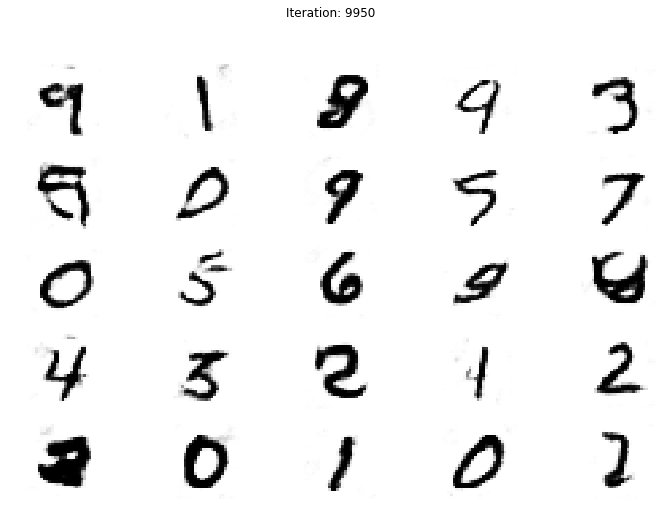

Iteration:  9951 [D loss: 0.70649, acc.:  44.53%] [G loss: 0.75693]
Iteration:  9952 [D loss: 0.69288, acc.:  52.73%] [G loss: 0.77672]
Iteration:  9953 [D loss: 0.72052, acc.:  45.70%] [G loss: 0.76522]
Iteration:  9954 [D loss: 0.71919, acc.:  43.36%] [G loss: 0.74935]
Iteration:  9955 [D loss: 0.71320, acc.:  45.31%] [G loss: 0.72994]
Iteration:  9956 [D loss: 0.70158, acc.:  49.61%] [G loss: 0.71344]
Iteration:  9957 [D loss: 0.72248, acc.:  46.88%] [G loss: 0.72444]
Iteration:  9958 [D loss: 0.70989, acc.:  47.27%] [G loss: 0.74897]
Iteration:  9959 [D loss: 0.70448, acc.:  50.00%] [G loss: 0.76602]
Iteration:  9960 [D loss: 0.69720, acc.:  46.48%] [G loss: 0.73608]
Iteration:  9961 [D loss: 0.69058, acc.:  49.22%] [G loss: 0.77156]
Iteration:  9962 [D loss: 0.70055, acc.:  47.27%] [G loss: 0.76749]
Iteration:  9963 [D loss: 0.69519, acc.:  51.56%] [G loss: 0.74917]
Iteration:  9964 [D loss: 0.70206, acc.:  49.22%] [G loss: 0.72977]
Iteration:  9965 [D loss: 0.70184, acc.:  47.66%

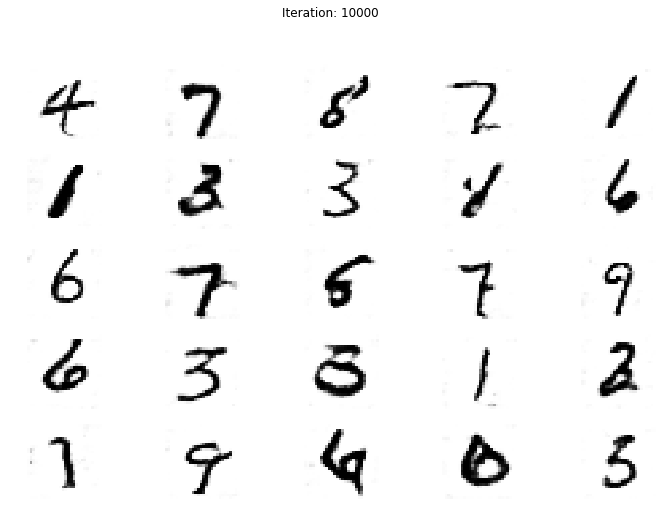

Iteration: 10001 [D loss: 0.70409, acc.:  49.22%] [G loss: 0.74979]
Iteration: 10002 [D loss: 0.71033, acc.:  47.27%] [G loss: 0.73998]


In [0]:
# Adversarial ground truths.
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for iteration in range(iterations + 2):

    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random half of images.
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    imgs = x_train[idx]

    # Sample noise and generate a batch of new images.
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    gen_imgs = generator.predict(noise)

    # Train the discriminator (real classified as ones and generated as zeros).
    d_loss_real = discriminator.train_on_batch(imgs, valid)
    losses['d_loss_real'].append(d_loss_real)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    losses['d_loss_fake'].append(d_loss_fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    losses['d_loss'].append(d_loss.tolist())

    # ---------------------
    #  Train Generator
    # ---------------------

    # Sample novel noise.
    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    # Train the generator (wants discriminator to mistake images as real).
    g_loss = combined.train_on_batch(noise, valid)
    losses['g_loss'].append(g_loss)

    # Print progress.
    print("Iteration: {:5d} [D loss: {:1.5f}, acc.: {:6.2f}%] [G loss: {:1.5f}]".format(iteration + 1, d_loss[0], 100 * d_loss[1], g_loss))

    # Save generated image samples.
    if (iteration + 1) % 50 == 0 or iteration == 0:
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, latent_dim))
        gen_imgs = generator.predict(noise)

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray_r')
                axs[i,j].axis('off')
                cnt += 1
        fig.suptitle("Iteration: {:d}".format(iteration + 1))
        fig.savefig("{:s}iteration_{:d}.png".format(save_path_image, iteration + 1))
        plt.show()
        plt.close()

In [0]:
save_path_training = "training/"
if not os.path.exists(save_path_training):
    os.mkdir(save_path_training)

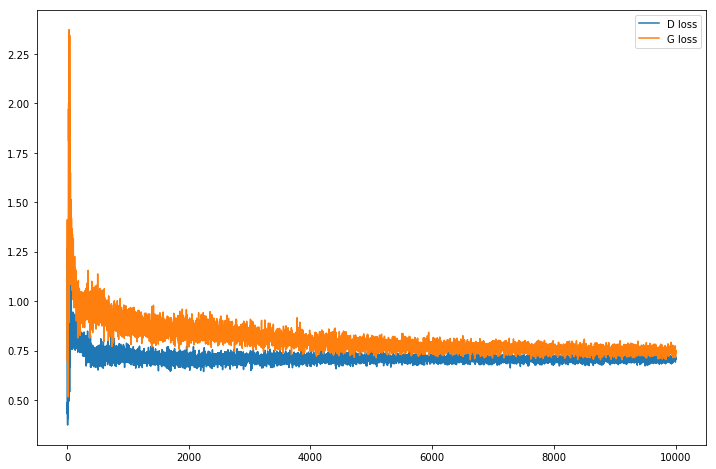

In [0]:
plt.plot(np.array(losses['d_loss'])[:,0], label="D loss")
plt.plot(np.array(losses['g_loss'])[:], label="G loss")

plt.legend(loc="best")
plt.savefig("{:s}D and G loss".format(save_path_training))
plt.show()

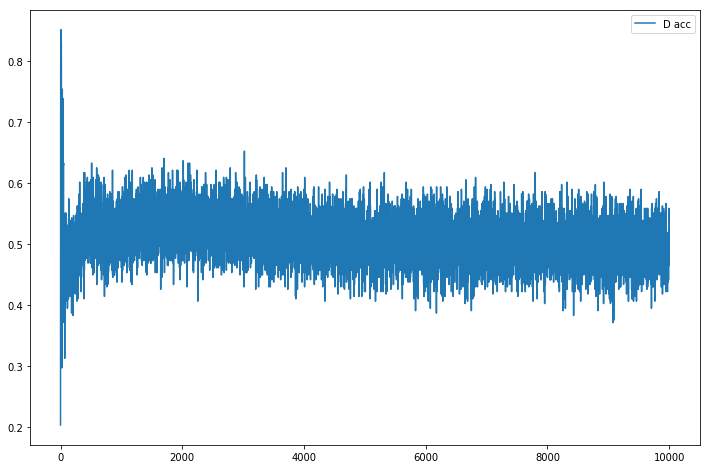

In [0]:
plt.plot(np.array(losses['d_loss'])[:,1], label="D acc")

plt.legend(loc="best")
plt.savefig("{:s}D acc".format(save_path_training))
plt.show()

## Load and Save GAN Models

In [0]:
model_path = "models/"
if not os.path.exists(model_path):
    os.mkdir(model_path)

discriminator_path = model_path + "discriminator.h5"
generator_path = model_path + "generator.h5"
combined_path = model_path + "combined.h5"

In [0]:
# Save models.
discriminator.save(discriminator_path)
generator.save(generator_path)
combined.save(combined_path)

In [0]:
# Load models.
discriminator = load_model(discriminator_path)
generator = load_model(generator_path)
combined = load_model(combined_path)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [0]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 7, 7, 64)        

In [0]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0 

In [0]:
combined.summary()

Model: "combined"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
generator (Model)            (None, 28, 28, 1)         1041473   
_________________________________________________________________
discriminator (Model)        (None, 1)                 393729    
Total params: 1,435,202
Trainable params: 1,433,538
Non-trainable params: 1,664
_________________________________________________________________


## Generate from Latent Space

In [0]:
save_path_gen_image = "gen_images/"
if not os.path.exists(save_path_gen_image):
    os.mkdir(save_path_gen_image)
gen_count = 0

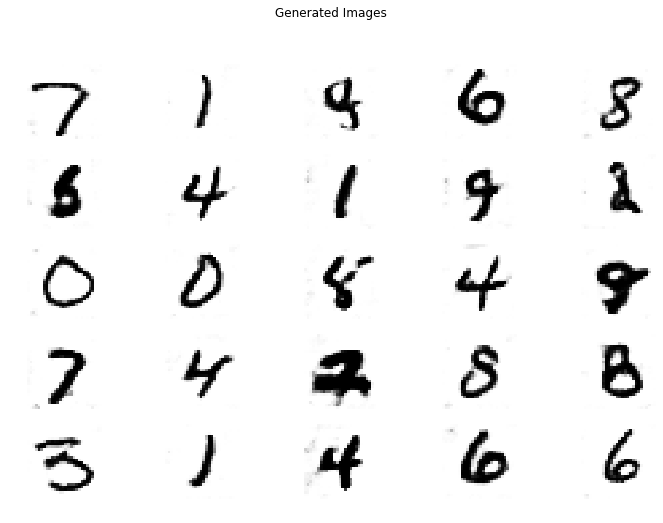

In [0]:
r, c = 5, 5
noise = np.random.normal(0, 1, (r * c, latent_dim))
gen_imgs = generator.predict(noise)

fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray_r')
        axs[i,j].axis('off')
        cnt += 1
fig.suptitle("Generated Images")
fig.savefig("{:s}gen_image_{:d}.png".format(save_path_gen_image, gen_count))
plt.show()
plt.close()

gen_count += 1

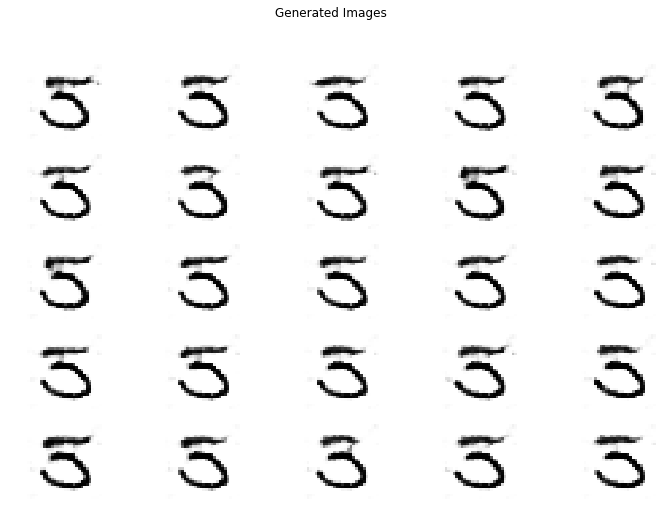

In [0]:
r, c = 5, 5
init_noise = np.random.normal(0, 1, (latent_dim,))
noise_center = np.tile(init_noise, (r * c, 1))
noise = noise_center + np.random.normal(0, 0.2, (r * c, latent_dim))
gen_imgs = generator.predict(noise)

fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray_r')
        axs[i,j].axis('off')
        cnt += 1
fig.suptitle("Generated Images")
fig.savefig("{:s}gen_image_{:d}.png".format(save_path_gen_image, gen_count))
plt.show()
plt.close()

gen_count += 1

In [0]:
# Only with 2D-shaped z.




# Classifier

## Training

In [0]:
classifier = Sequential()
classifier.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=img_shape))
classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.25))
classifier.add(Flatten())
classifier.add(Dense(128, activation='relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(10, activation='softmax'))

classifier.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [0]:
classifier_history = classifier.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_split=0.1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 54000 samples, validate on 6000 samples
Epoch 1/10





54000/54000 [==============================] - 16s 296us/step - loss: 0.2791 - acc: 0.9137 - val_loss: 0.0595 - val_acc: 0.9818
Epoch 2/10
54000/54000 [==============================] - 8s 146us/step - loss: 0.0890 - acc: 0.9732 - val_loss: 0.0443 - val_acc: 0.9878
Epoch 3/10
54000/54000 [==============================] - 8s 146us/step - loss: 0.0645 - acc: 0.9807 - val_loss: 0.0365 - val_acc: 0.9905
Epoch 4/10
54000/54000 [==============================] - 8s 149us/step - loss: 0.0537 - acc: 0.9839 - val_loss: 0.0326 - val_acc: 0.9902
Epoch 5/10
54000/54000 [==============================] - 8s 146us/step - loss: 0.0472 - acc: 0.9860 - val_loss: 0.0398 - val_acc: 0.9888
Epoch 6/10
54000/54000 [==============================] - 8s 149us/step - loss: 0.0422 - acc: 0.9869 - val_loss: 0.0343 - val_acc: 0.9912
Epoch 7/10
54000/540

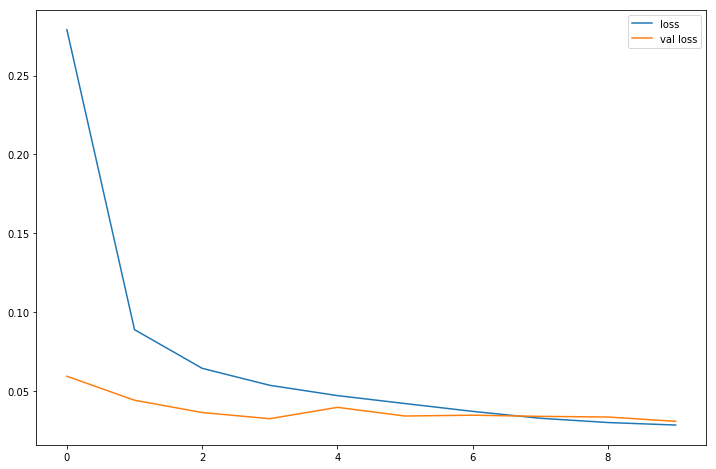

In [0]:
plt.plot(classifier_history.history['loss'], label="loss")
plt.plot(classifier_history.history['val_loss'], label="val loss")

plt.legend(loc="best")
plt.show()
plt.close()

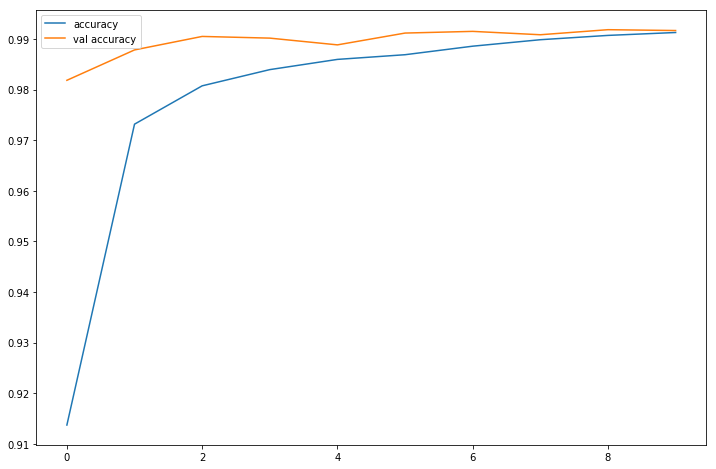

In [0]:
plt.plot(classifier_history.history['acc'], label="accuracy")
plt.plot(classifier_history.history['val_acc'], label="val accuracy")

plt.legend(loc="best")
plt.show()
plt.close()

In [0]:
test_eval = classifier.evaluate(x_test, y_test)
print("Testing Loss:    {:1.7f}".format(test_eval[0]))
print("Testing Accracy: {:5.2f}%".format(test_eval[1] * 100))

10000/10000 [==============================] - 1s 98us/step
Testing Loss:    0.0276485
Testing Accracy: 99.17%


## Save and Load Classifier Model

In [0]:
model_path = "models/"
if not os.path.exists(model_path):
    os.mkdir(model_path)

classifier_path = model_path + "classifier.h5"

In [0]:
# Save models.
classifier.save(classifier_path)

In [0]:
# Load models.
classifier = load_model(classifier_path)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




## Classifying Generated Images

In [0]:
save_path_gen_classify = "gen_classify/"
if not os.path.exists(save_path_gen_classify):
    os.mkdir(save_path_gen_classify)
gen_classify_count = 0

In [0]:
r, c = 5, 5
noise = np.random.normal(0, 1, (r * c, latent_dim))
gen_imgs = generator.predict(noise)
preds = classifier.predict(gen_imgs)

fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray_r')
        axs[i,j].axis('off')
        axs[i,j].title.set_text("Pred:{:d}".format(np.argmax(preds[cnt])))
        cnt += 1
fig.suptitle("Generated Images Classified")
fig.savefig("{:s}gen_classify_{:d}.png".format(save_path_gen_classify, gen_classify_count))
plt.show()
plt.close()

gen_classify_count += 1

NameError: ignored

## Classifying Hand-Drawn Images

In [0]:
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image
import cv2

canvas_html = """
<canvas width=%d height=%d></canvas>
<button>Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}
canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}
var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(filename='drawing.png', w=200, h=200, line_width=1):
  display(HTML(canvas_html % (w, h, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return len(binary)

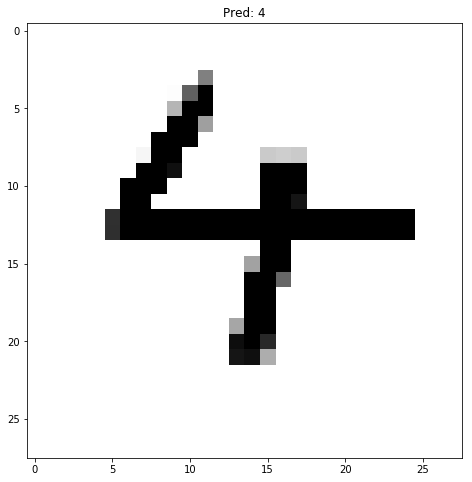

In [0]:
# Let user draw.
draw(line_width=15)

# Pre-process image.
drawing = Image.open('drawing.png')
drawing = np.array(drawing)
drawing = drawing[:,:,3]
drawing = cv2.resize(drawing, dsize=(x_dim, y_dim), interpolation=cv2.INTER_CUBIC)
drawing = drawing / 255 * 2 - 1

# Make prediction.
pred = classifier.predict(drawing.reshape(1, x_dim, y_dim, channels))

# Show result.
plt.imshow(drawing, cmap='gray_r')
plt.title("Pred: {:d}".format(np.argmax(pred[0])))
plt.show()
plt.close()

# Playground

In [0]:
# Build generator model.
z = Input(shape=(latent_dim,))
x = Dense(128 * 7 * 7, kernel_initializer=init)(z)
x = LeakyReLU(0.2)(x)
x = Reshape((7, 7, 128))(x)

x = Conv2D(128, kernel_size=3, strides=(1, 1), padding="same", kernel_initializer=init)(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

x = Conv2DTranspose(128, kernel_size=3, strides=(2, 2), padding="same", kernel_initializer=init)(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

x = Conv2D(64, kernel_size=3, strides=(1, 1), padding="same", kernel_initializer=init)(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

x = Conv2DTranspose(64, kernel_size=3, strides=(2, 2), padding="same", kernel_initializer=init)(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

x = Conv2D(channels, kernel_size=3, strides=(1, 1), padding="same", kernel_initializer=init)(x)
x = Activation("tanh")(x)

generator = Model(z, x)
generator.name = "generator"
generator.summary()

In [0]:
# Build discriminator model.
img_input = Input(shape=img_shape)
x = Conv2D(32, kernel_size=3, strides=(2, 2), padding="same", kernel_initializer=init)(img_input)
x = LeakyReLU(0.2)(x)
x = Dropout(0.25)(x)

x = Conv2D(64, kernel_size=3, strides=(2, 2), padding="same", kernel_initializer=init)(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = Dropout(0.25)(x)

x = Conv2D(128, kernel_size=3, strides=(2, 2), padding="same", kernel_initializer=init)(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = Dropout(0.25)(x)

x = Conv2D(256, kernel_size=3, strides=(1, 1), padding="same", kernel_initializer=init)(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(1, kernel_initializer=init)(x)
x = Activation("sigmoid")(x)

discriminator = Model(img_input, x)
discriminator.name = "discriminator"
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])
discriminator.summary()